# Diversity Score on the MovieLens Dataset

In this notebook, we look at measuring diversity of movie consumption in the MovieLens dataset. This dataset comes from the interaction between users and movies at [MovieLens](https://movielens.org/), a public movie recommendation service run by [GroupLens](https://grouplens.org/), based at the University of Minesotta.

Our goal is to try Spotify's diversity measure on the MovieLens dataset. This will require training a MovieLens model on the dataset, followed by computing the Generalist-Specialist metric on users.

In [58]:
import os
import pandas as pd
import numpy as np
import re
import logging  
import multiprocessing
import matplotlib
import matplotlib.pyplot as plt
import requests
import seaborn as sns

from time import time
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from tqdm import tqdm

from core.util import *
from core.metrics import *

%matplotlib inline

font = {"size" : 18}
matplotlib.rc('font', **font)

logger = setup_logging()

## Dataset Download and Preparation

First we download the dataset into the current working directory and unzip it. We also set up the paths to the user interaction with movies and ratings they gave.

In [18]:
dataset_dir_name = "ml-latest"
base_path = os.path.join(os.getcwd(), dataset_dir_name)
ratings_path = os.path.join(base_path, "ratings.csv")
links_path = os.path.join(base_path, "links.csv")
movies_path = os.path.join(base_path, "movies.csv")

In [19]:
if not os.path.exists(base_path):
    dataset_url = "http://files.grouplens.org/datasets/movielens/" + dataset_dir_name + ".zip"
    # don't download if not necessary     
    if not os.path.exists(base_path + ".zip"):
        download_dataset(dataset_url, base_path + ".zip")
    
    logger.info("unzipping file")
    unzip_file(dataset_dir_name + ".zip")

## Read and Explore Dataset

We convert the Unix timestamps to a more human-friendly datetime format. 

In [20]:
ratings_df = pd.read_csv(ratings_path)

In [21]:
ratings_df["date"] = pd.to_datetime(ratings_df["timestamp"], unit="s")
ratings_df["month"] = ratings_df["date"].dt.month
ratings_df["year"] = ratings_df["date"].dt.year
ratings_df["movieId"] = ratings_df["movieId"].apply(str)

In [22]:
users_movies = ratings_df.sort_values(by=["timestamp"]).groupby(
    "userId", 
    as_index=False
).apply(
    lambda x: dict(zip(x["movieId"], x["rating"]))
).reset_index(name="movie_id_ratings")

In [23]:
users_movies.head()

index                                   movie_id_ratings
0      0  {'3826': 2.0, '307': 3.5, '1590': 2.5, '2478':...
1      1  {'1962': 4.0, '849': 3.5, '2108': 3.5, '2746':...
2      2  {'1321': 4.0, '960': 3.0, '1221': 4.0, '3171':...
3      3  {'2683': 3.5, '2997': 4.0, '786': 4.0, '1527':...
4      4  {'1186': 2.0, '2485': 3.0, '728': 3.0, '3178':...

## Training the Model

Here, we train the Word2Vec model. We set out model parameters to 
* word vector size at 50 dimensions
* the minimum word count is 5, which means a movie needs to appear at least 5 times before it is included in the model

In [24]:
# model parameters
WORD_VECTOR_SIZE = 50  # dimension of word vector size (multiple of 4 for best performance)
MIN_WORD_COUNT = 5 # minimum number of times a word must appear in the dataset to be included as a word vector

In [25]:
movies_list = users_movies["movie_id_ratings"].apply(lambda x: list(x.keys()))

In [26]:
cores = multiprocessing.cpu_count()
model = Word2Vec(min_count=MIN_WORD_COUNT,
                     window=2,
                     size=WORD_VECTOR_SIZE,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=10,
                     workers=cores-1)

WARNING - 21:13:22: consider setting layer size to a multiple of 4 for greater performance


In [27]:
t = time()
model.build_vocab(movies_list, progress_per=10000)
logger.info("Time to build vocab: {} mins".format(round((time() - t) / 60, 2)))

INFO - 21:13:22: collecting all words and their counts
INFO - 21:13:22: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:13:22: PROGRESS: at sentence #10000, processed 994882 words, keeping 22011 word types
INFO - 21:13:22: PROGRESS: at sentence #20000, processed 1955233 words, keeping 25926 word types
INFO - 21:13:22: PROGRESS: at sentence #30000, processed 2901806 words, keeping 28887 word types
INFO - 21:13:23: PROGRESS: at sentence #40000, processed 3879652 words, keeping 31329 word types
INFO - 21:13:23: PROGRESS: at sentence #50000, processed 4873537 words, keeping 33318 word types
INFO - 21:13:23: PROGRESS: at sentence #60000, processed 5833186 words, keeping 34816 word types
INFO - 21:13:23: PROGRESS: at sentence #70000, processed 6816332 words, keeping 36633 word types
INFO - 21:13:23: PROGRESS: at sentence #80000, processed 7772985 words, keeping 38394 word types
INFO - 21:13:23: PROGRESS: at sentence #90000, processed 8731983 words, keeping 39544 w

In [28]:
t = time()
model.train(movies_list, total_examples=model.corpus_count, epochs=15, report_delay=1)
logger.info("Time to train the model: {} mins".format(round((time() - t) / 60, 2)))

INFO - 21:13:31: training model with 11 workers on 30824 vocabulary and 50 features, using sg=0 hs=0 sample=6e-05 negative=10 window=2
INFO - 21:13:32: EPOCH 1 - PROGRESS: at 10.84% examples, 1805320 words/s, in_qsize 20, out_qsize 1
INFO - 21:13:33: EPOCH 1 - PROGRESS: at 21.72% examples, 1812250 words/s, in_qsize 19, out_qsize 2
INFO - 21:13:34: EPOCH 1 - PROGRESS: at 32.73% examples, 1812704 words/s, in_qsize 20, out_qsize 1
INFO - 21:13:35: EPOCH 1 - PROGRESS: at 43.35% examples, 1814733 words/s, in_qsize 20, out_qsize 1
INFO - 21:13:36: EPOCH 1 - PROGRESS: at 53.79% examples, 1807047 words/s, in_qsize 20, out_qsize 1
INFO - 21:13:37: EPOCH 1 - PROGRESS: at 64.12% examples, 1796365 words/s, in_qsize 19, out_qsize 2
INFO - 21:13:38: EPOCH 1 - PROGRESS: at 74.20% examples, 1783336 words/s, in_qsize 17, out_qsize 4
INFO - 21:13:39: EPOCH 1 - PROGRESS: at 84.49% examples, 1776161 words/s, in_qsize 17, out_qsize 4
INFO - 21:13:40: EPOCH 1 - PROGRESS: at 94.53% examples, 1769888 words/s,

INFO - 21:14:19: EPOCH 5 - PROGRESS: at 84.45% examples, 1578414 words/s, in_qsize 18, out_qsize 3
INFO - 21:14:20: EPOCH 5 - PROGRESS: at 92.29% examples, 1555211 words/s, in_qsize 21, out_qsize 0
INFO - 21:14:21: worker thread finished; awaiting finish of 10 more threads
INFO - 21:14:21: worker thread finished; awaiting finish of 9 more threads
INFO - 21:14:21: worker thread finished; awaiting finish of 8 more threads
INFO - 21:14:21: worker thread finished; awaiting finish of 7 more threads
INFO - 21:14:21: worker thread finished; awaiting finish of 6 more threads
INFO - 21:14:21: worker thread finished; awaiting finish of 5 more threads
INFO - 21:14:21: worker thread finished; awaiting finish of 4 more threads
INFO - 21:14:21: worker thread finished; awaiting finish of 3 more threads
INFO - 21:14:21: worker thread finished; awaiting finish of 2 more threads
INFO - 21:14:21: worker thread finished; awaiting finish of 1 more threads
INFO - 21:14:21: worker thread finished; awaiting f

INFO - 21:15:02: worker thread finished; awaiting finish of 6 more threads
INFO - 21:15:02: worker thread finished; awaiting finish of 5 more threads
INFO - 21:15:02: worker thread finished; awaiting finish of 4 more threads
INFO - 21:15:02: worker thread finished; awaiting finish of 3 more threads
INFO - 21:15:02: worker thread finished; awaiting finish of 2 more threads
INFO - 21:15:02: worker thread finished; awaiting finish of 1 more threads
INFO - 21:15:02: worker thread finished; awaiting finish of 0 more threads
INFO - 21:15:02: EPOCH - 9 : training on 27753444 raw words (16979594 effective words) took 9.6s, 1767927 effective words/s
INFO - 21:15:03: EPOCH 10 - PROGRESS: at 10.38% examples, 1711561 words/s, in_qsize 20, out_qsize 1
INFO - 21:15:04: EPOCH 10 - PROGRESS: at 20.93% examples, 1735265 words/s, in_qsize 21, out_qsize 0
INFO - 21:15:05: EPOCH 10 - PROGRESS: at 30.06% examples, 1669121 words/s, in_qsize 17, out_qsize 4
INFO - 21:15:06: EPOCH 10 - PROGRESS: at 40.38% exa

INFO - 21:15:44: EPOCH 14 - PROGRESS: at 32.46% examples, 1804518 words/s, in_qsize 21, out_qsize 0
INFO - 21:15:45: EPOCH 14 - PROGRESS: at 42.01% examples, 1766436 words/s, in_qsize 20, out_qsize 1
INFO - 21:15:46: EPOCH 14 - PROGRESS: at 51.49% examples, 1728380 words/s, in_qsize 17, out_qsize 4
INFO - 21:15:47: EPOCH 14 - PROGRESS: at 61.43% examples, 1721094 words/s, in_qsize 20, out_qsize 1
INFO - 21:15:48: EPOCH 14 - PROGRESS: at 70.97% examples, 1708269 words/s, in_qsize 19, out_qsize 2
INFO - 21:15:49: EPOCH 14 - PROGRESS: at 80.90% examples, 1696477 words/s, in_qsize 17, out_qsize 4
INFO - 21:15:50: EPOCH 14 - PROGRESS: at 90.30% examples, 1687080 words/s, in_qsize 19, out_qsize 2
INFO - 21:15:51: EPOCH 14 - PROGRESS: at 99.46% examples, 1675661 words/s, in_qsize 16, out_qsize 0
INFO - 21:15:51: worker thread finished; awaiting finish of 10 more threads
INFO - 21:15:51: worker thread finished; awaiting finish of 9 more threads
INFO - 21:15:51: worker thread finished; awaiting

In [29]:
# since we're no longer going to train further
model.init_sims(replace=True)

INFO - 21:16:01: precomputing L2-norms of word weight vectors


In [30]:
logger.info(f"Corpus size: {model.corpus_count}")

INFO - 21:16:01: Corpus size: 283228


## Compute Generalist-Specialist Score

Now that we've trained the model, we're in a position to apply the Generalist-Specialist score to all users in MovieLens dataset. 

In [54]:
users_movies["gs_score"] = users_movies["movie_id_ratings"].apply(lambda x: generalist_specialist_score(model, x))

C:\ProgramData\Anaconda3\envs\tabnet-env\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\ProgramData\Anaconda3\envs\tabnet-env\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
WARNING - 21:53:09: 141980 not contained in model
WARNING - 21:53:09: 141978 not contained in model
WARNING - 21:53:09: 141980 not contained in model
WARNING - 21:53:09: 141978 not contained in model
WARNING - 21:53:09: 140864 not contained in model
WARNING - 21:53:09: 140864 not contained in model
WARNING - 21:53:09: 172751 not contained in model
WARNING - 21:53:09: 142088 not contained in model
WARNING - 21:53:09: 158561 not contained in model
WARNING - 21:53:09: 158027 not contained in model
WARNING - 21:53:09: 172751 not contained in model
WARNING - 21:53:09: 142088 not con

WARNING - 21:53:12: 95504 not contained in model
WARNING - 21:53:12: 137226 not contained in model
WARNING - 21:53:12: 139485 not contained in model
WARNING - 21:53:12: 107735 not contained in model
WARNING - 21:53:12: 135412 not contained in model
WARNING - 21:53:12: 136554 not contained in model
WARNING - 21:53:12: 145728 not contained in model
WARNING - 21:53:12: 143565 not contained in model
WARNING - 21:53:12: 157893 not contained in model
WARNING - 21:53:12: 158306 not contained in model
WARNING - 21:53:12: 158308 not contained in model
WARNING - 21:53:12: 158312 not contained in model
WARNING - 21:53:12: 158320 not contained in model
WARNING - 21:53:12: 158324 not contained in model
WARNING - 21:53:12: 158328 not contained in model
WARNING - 21:53:12: 102917 not contained in model
WARNING - 21:53:12: 155864 not contained in model
WARNING - 21:53:12: 134953 not contained in model
WARNING - 21:53:12: 48235 not contained in model
WARNING - 21:53:12: 95504 not contained in model
WAR

WARNING - 21:53:13: 147746 not contained in model
WARNING - 21:53:13: 147057 not contained in model
WARNING - 21:53:13: 157306 not contained in model
WARNING - 21:53:13: 162952 not contained in model
WARNING - 21:53:13: 127843 not contained in model
WARNING - 21:53:13: 163539 not contained in model
WARNING - 21:53:13: 169206 not contained in model
WARNING - 21:53:13: 151623 not contained in model
WARNING - 21:53:13: 157118 not contained in model
WARNING - 21:53:13: 129268 not contained in model
WARNING - 21:53:13: 147746 not contained in model
WARNING - 21:53:13: 147057 not contained in model
WARNING - 21:53:13: 157306 not contained in model
WARNING - 21:53:13: 162952 not contained in model
WARNING - 21:53:13: 127843 not contained in model
WARNING - 21:53:13: 163539 not contained in model
WARNING - 21:53:13: 169206 not contained in model
WARNING - 21:53:13: 101835 not contained in model
WARNING - 21:53:13: 101835 not contained in model
WARNING - 21:53:13: 107836 not contained in model


WARNING - 21:53:15: 164538 not contained in model
WARNING - 21:53:15: 164845 not contained in model
WARNING - 21:53:15: 165097 not contained in model
WARNING - 21:53:15: 143617 not contained in model
WARNING - 21:53:15: 128762 not contained in model
WARNING - 21:53:15: 171511 not contained in model
WARNING - 21:53:15: 159331 not contained in model
WARNING - 21:53:15: 134120 not contained in model
WARNING - 21:53:15: 155425 not contained in model
WARNING - 21:53:15: 172567 not contained in model
WARNING - 21:53:15: 128788 not contained in model
WARNING - 21:53:15: 175245 not contained in model
WARNING - 21:53:15: 175751 not contained in model
WARNING - 21:53:15: 176815 not contained in model
WARNING - 21:53:15: 176981 not contained in model
WARNING - 21:53:15: 174417 not contained in model
WARNING - 21:53:15: 141000 not contained in model
WARNING - 21:53:15: 128193 not contained in model
WARNING - 21:53:15: 135673 not contained in model
WARNING - 21:53:15: 103413 not contained in model


WARNING - 21:53:16: 167060 not contained in model
WARNING - 21:53:16: 167044 not contained in model
WARNING - 21:53:16: 167058 not contained in model
WARNING - 21:53:16: 167060 not contained in model
WARNING - 21:53:16: 136560 not contained in model
WARNING - 21:53:16: 153586 not contained in model
WARNING - 21:53:16: 136560 not contained in model
WARNING - 21:53:16: 153586 not contained in model
WARNING - 21:53:16: 178473 not contained in model
WARNING - 21:53:16: 178481 not contained in model
WARNING - 21:53:16: 178483 not contained in model
WARNING - 21:53:16: 178485 not contained in model
WARNING - 21:53:16: 147060 not contained in model
WARNING - 21:53:16: 178489 not contained in model
WARNING - 21:53:16: 170030 not contained in model
WARNING - 21:53:16: 178497 not contained in model
WARNING - 21:53:16: 146914 not contained in model
WARNING - 21:53:16: 178499 not contained in model
WARNING - 21:53:16: 104774 not contained in model
WARNING - 21:53:16: 165365 not contained in model


WARNING - 21:53:17: 189649 not contained in model
WARNING - 21:53:17: 130144 not contained in model
WARNING - 21:53:17: 189659 not contained in model
WARNING - 21:53:17: 98169 not contained in model
WARNING - 21:53:17: 70439 not contained in model
WARNING - 21:53:17: 124881 not contained in model
WARNING - 21:53:17: 190485 not contained in model
WARNING - 21:53:17: 190489 not contained in model
WARNING - 21:53:17: 190557 not contained in model
WARNING - 21:53:17: 179995 not contained in model
WARNING - 21:53:17: 175471 not contained in model
WARNING - 21:53:17: 177367 not contained in model
WARNING - 21:53:17: 122234 not contained in model
WARNING - 21:53:17: 190451 not contained in model
WARNING - 21:53:17: 169156 not contained in model
WARNING - 21:53:17: 190869 not contained in model
WARNING - 21:53:17: 190871 not contained in model
WARNING - 21:53:17: 168736 not contained in model
WARNING - 21:53:17: 191173 not contained in model
WARNING - 21:53:17: 184625 not contained in model
WA

WARNING - 21:53:17: 180323 not contained in model
WARNING - 21:53:17: 169860 not contained in model
WARNING - 21:53:17: 138824 not contained in model
WARNING - 21:53:17: 184045 not contained in model
WARNING - 21:53:17: 156972 not contained in model
WARNING - 21:53:17: 70331 not contained in model
WARNING - 21:53:17: 185043 not contained in model
WARNING - 21:53:17: 173187 not contained in model
WARNING - 21:53:17: 122563 not contained in model
WARNING - 21:53:17: 185561 not contained in model
WARNING - 21:53:17: 181423 not contained in model
WARNING - 21:53:17: 186313 not contained in model
WARNING - 21:53:17: 180731 not contained in model
WARNING - 21:53:17: 186963 not contained in model
WARNING - 21:53:17: 131846 not contained in model
WARNING - 21:53:17: 187107 not contained in model
WARNING - 21:53:17: 139515 not contained in model
WARNING - 21:53:17: 177653 not contained in model
WARNING - 21:53:17: 188029 not contained in model
WARNING - 21:53:17: 187241 not contained in model
W

WARNING - 21:53:18: 182523 not contained in model
WARNING - 21:53:18: 182525 not contained in model
WARNING - 21:53:18: 182517 not contained in model
WARNING - 21:53:18: 182513 not contained in model
WARNING - 21:53:18: 182511 not contained in model
WARNING - 21:53:18: 182617 not contained in model
WARNING - 21:53:18: 145939 not contained in model
WARNING - 21:53:18: 147053 not contained in model
WARNING - 21:53:18: 182625 not contained in model
WARNING - 21:53:18: 182627 not contained in model
WARNING - 21:53:18: 182629 not contained in model
WARNING - 21:53:18: 182631 not contained in model
WARNING - 21:53:18: 182635 not contained in model
WARNING - 21:53:18: 74086 not contained in model
WARNING - 21:53:18: 94107 not contained in model
WARNING - 21:53:18: 74086 not contained in model
WARNING - 21:53:18: 94107 not contained in model
WARNING - 21:53:19: 136078 not contained in model
WARNING - 21:53:19: 114832 not contained in model
WARNING - 21:53:19: 167658 not contained in model
WARN

WARNING - 21:53:23: 124797 not contained in model
WARNING - 21:53:23: 121959 not contained in model
WARNING - 21:53:23: 146303 not contained in model
WARNING - 21:53:23: 168710 not contained in model
WARNING - 21:53:23: 159942 not contained in model
WARNING - 21:53:23: 128719 not contained in model
WARNING - 21:53:23: 150298 not contained in model
WARNING - 21:53:23: 141932 not contained in model
WARNING - 21:53:23: 131178 not contained in model
WARNING - 21:53:23: 150246 not contained in model
WARNING - 21:53:23: 172417 not contained in model
WARNING - 21:53:23: 145084 not contained in model
WARNING - 21:53:23: 150190 not contained in model
WARNING - 21:53:23: 186179 not contained in model
WARNING - 21:53:23: 189093 not contained in model
WARNING - 21:53:23: 114489 not contained in model
WARNING - 21:53:23: 112212 not contained in model
WARNING - 21:53:23: 124797 not contained in model
WARNING - 21:53:23: 121959 not contained in model
WARNING - 21:53:23: 146303 not contained in model


WARNING - 21:53:24: 173717 not contained in model
WARNING - 21:53:24: 177447 not contained in model
WARNING - 21:53:24: 177575 not contained in model
WARNING - 21:53:25: 6929 not contained in model
WARNING - 21:53:25: 71806 not contained in model
WARNING - 21:53:25: 71888 not contained in model
WARNING - 21:53:25: 31258 not contained in model
WARNING - 21:53:25: 37949 not contained in model
WARNING - 21:53:25: 83310 not contained in model
WARNING - 21:53:25: 91933 not contained in model
WARNING - 21:53:25: 97334 not contained in model
WARNING - 21:53:25: 98595 not contained in model
WARNING - 21:53:25: 101226 not contained in model
WARNING - 21:53:25: 94475 not contained in model
WARNING - 21:53:25: 109573 not contained in model
WARNING - 21:53:25: 115653 not contained in model
WARNING - 21:53:25: 115826 not contained in model
WARNING - 21:53:25: 117732 not contained in model
WARNING - 21:53:25: 82840 not contained in model
WARNING - 21:53:25: 124537 not contained in model
WARNING - 21

WARNING - 21:53:26: 148886 not contained in model
WARNING - 21:53:26: 166153 not contained in model
WARNING - 21:53:26: 141666 not contained in model
WARNING - 21:53:26: 173153 not contained in model
WARNING - 21:53:26: 132386 not contained in model
WARNING - 21:53:26: 111917 not contained in model
WARNING - 21:53:26: 184853 not contained in model
WARNING - 21:53:26: 184859 not contained in model
WARNING - 21:53:26: 184853 not contained in model
WARNING - 21:53:26: 184859 not contained in model
WARNING - 21:53:26: 160826 not contained in model
WARNING - 21:53:26: 160826 not contained in model
WARNING - 21:53:26: 141375 not contained in model
WARNING - 21:53:26: 141381 not contained in model
WARNING - 21:53:26: 141375 not contained in model
WARNING - 21:53:26: 141381 not contained in model
WARNING - 21:53:27: 56724 not contained in model
WARNING - 21:53:27: 98253 not contained in model
WARNING - 21:53:27: 56724 not contained in model
WARNING - 21:53:27: 98253 not contained in model
WARN

WARNING - 21:53:29: 184749 not contained in model
WARNING - 21:53:29: 184751 not contained in model
WARNING - 21:53:29: 184753 not contained in model
WARNING - 21:53:29: 184755 not contained in model
WARNING - 21:53:29: 184757 not contained in model
WARNING - 21:53:29: 184759 not contained in model
WARNING - 21:53:29: 184763 not contained in model
WARNING - 21:53:29: 184765 not contained in model
WARNING - 21:53:29: 184767 not contained in model
WARNING - 21:53:29: 184769 not contained in model
WARNING - 21:53:29: 184775 not contained in model
WARNING - 21:53:29: 184777 not contained in model
WARNING - 21:53:29: 184213 not contained in model
WARNING - 21:53:29: 184779 not contained in model
WARNING - 21:53:29: 184781 not contained in model
WARNING - 21:53:29: 187661 not contained in model
WARNING - 21:53:29: 187663 not contained in model
WARNING - 21:53:29: 189699 not contained in model
WARNING - 21:53:29: 190087 not contained in model
WARNING - 21:53:29: 190307 not contained in model


WARNING - 21:53:31: 132476 not contained in model
WARNING - 21:53:31: 132474 not contained in model
WARNING - 21:53:31: 132478 not contained in model
WARNING - 21:53:31: 130558 not contained in model
WARNING - 21:53:31: 155407 not contained in model
WARNING - 21:53:31: 90495 not contained in model
WARNING - 21:53:31: 168888 not contained in model
WARNING - 21:53:31: 172463 not contained in model
WARNING - 21:53:31: 138544 not contained in model
WARNING - 21:53:31: 117450 not contained in model
WARNING - 21:53:31: 177715 not contained in model
WARNING - 21:53:31: 177501 not contained in model
WARNING - 21:53:31: 181203 not contained in model
WARNING - 21:53:31: 112081 not contained in model
WARNING - 21:53:31: 189471 not contained in model
WARNING - 21:53:31: 192375 not contained in model
WARNING - 21:53:31: 192103 not contained in model
WARNING - 21:53:31: 192587 not contained in model
WARNING - 21:53:31: 192737 not contained in model
WARNING - 21:53:31: 185985 not contained in model
W

WARNING - 21:53:34: 178569 not contained in model
WARNING - 21:53:34: 178571 not contained in model
WARNING - 21:53:34: 178575 not contained in model
WARNING - 21:53:34: 178555 not contained in model
WARNING - 21:53:34: 178577 not contained in model
WARNING - 21:53:34: 178579 not contained in model
WARNING - 21:53:34: 178581 not contained in model
WARNING - 21:53:34: 178583 not contained in model
WARNING - 21:53:34: 178585 not contained in model
WARNING - 21:53:34: 165161 not contained in model
WARNING - 21:53:34: 131743 not contained in model
WARNING - 21:53:34: 124326 not contained in model
WARNING - 21:53:34: 162458 not contained in model
WARNING - 21:53:34: 152169 not contained in model
WARNING - 21:53:34: 138098 not contained in model
WARNING - 21:53:34: 125609 not contained in model
WARNING - 21:53:34: 146698 not contained in model
WARNING - 21:53:34: 142416 not contained in model
WARNING - 21:53:34: 124825 not contained in model
WARNING - 21:53:34: 160551 not contained in model


WARNING - 21:53:35: 154414 not contained in model
WARNING - 21:53:35: 92951 not contained in model
WARNING - 21:53:35: 141203 not contained in model
WARNING - 21:53:35: 128948 not contained in model
WARNING - 21:53:35: 124735 not contained in model
WARNING - 21:53:35: 134372 not contained in model
WARNING - 21:53:35: 81954 not contained in model
WARNING - 21:53:35: 71702 not contained in model
WARNING - 21:53:35: 163975 not contained in model
WARNING - 21:53:35: 115911 not contained in model
WARNING - 21:53:35: 141650 not contained in model
WARNING - 21:53:35: 127333 not contained in model
WARNING - 21:53:35: 90199 not contained in model
WARNING - 21:53:35: 162740 not contained in model
WARNING - 21:53:35: 145072 not contained in model
WARNING - 21:53:35: 89133 not contained in model
WARNING - 21:53:35: 109708 not contained in model
WARNING - 21:53:35: 136303 not contained in model
WARNING - 21:53:35: 157355 not contained in model
WARNING - 21:53:35: 140443 not contained in model
WARNI

WARNING - 21:53:36: 127176 not contained in model
WARNING - 21:53:36: 142560 not contained in model
WARNING - 21:53:36: 101803 not contained in model
WARNING - 21:53:36: 154878 not contained in model
WARNING - 21:53:36: 121101 not contained in model
WARNING - 21:53:36: 125105 not contained in model
WARNING - 21:53:36: 154786 not contained in model
WARNING - 21:53:36: 144190 not contained in model
WARNING - 21:53:36: 152812 not contained in model
WARNING - 21:53:36: 95565 not contained in model
WARNING - 21:53:36: 131382 not contained in model
WARNING - 21:53:36: 139048 not contained in model
WARNING - 21:53:36: 86455 not contained in model
WARNING - 21:53:36: 175977 not contained in model
WARNING - 21:53:36: 101986 not contained in model
WARNING - 21:53:36: 139048 not contained in model
WARNING - 21:53:36: 86455 not contained in model
WARNING - 21:53:36: 175977 not contained in model
WARNING - 21:53:36: 101986 not contained in model
WARNING - 21:53:36: 177781 not contained in model
WAR

WARNING - 21:53:39: 131884 not contained in model
WARNING - 21:53:39: 161640 not contained in model
WARNING - 21:53:39: 150477 not contained in model
WARNING - 21:53:39: 150477 not contained in model
WARNING - 21:53:39: 45038 not contained in model
WARNING - 21:53:39: 45038 not contained in model
WARNING - 21:53:39: 166868 not contained in model
WARNING - 21:53:39: 132662 not contained in model
WARNING - 21:53:39: 166870 not contained in model
WARNING - 21:53:39: 166876 not contained in model
WARNING - 21:53:39: 158308 not contained in model
WARNING - 21:53:39: 166880 not contained in model
WARNING - 21:53:39: 166512 not contained in model
WARNING - 21:53:39: 166882 not contained in model
WARNING - 21:53:39: 166884 not contained in model
WARNING - 21:53:39: 166886 not contained in model
WARNING - 21:53:39: 135743 not contained in model
WARNING - 21:53:39: 166888 not contained in model
WARNING - 21:53:39: 166890 not contained in model
WARNING - 21:53:39: 102910 not contained in model
WA

WARNING - 21:53:41: 137288 not contained in model
WARNING - 21:53:41: 129777 not contained in model
WARNING - 21:53:41: 129775 not contained in model
WARNING - 21:53:41: 129769 not contained in model
WARNING - 21:53:41: 129767 not contained in model
WARNING - 21:53:41: 129777 not contained in model
WARNING - 21:53:41: 129775 not contained in model
WARNING - 21:53:41: 129769 not contained in model
WARNING - 21:53:41: 129767 not contained in model
WARNING - 21:53:41: 126212 not contained in model
WARNING - 21:53:41: 176293 not contained in model
WARNING - 21:53:41: 174307 not contained in model
WARNING - 21:53:41: 187011 not contained in model
WARNING - 21:53:41: 146499 not contained in model
WARNING - 21:53:41: 176847 not contained in model
WARNING - 21:53:41: 145859 not contained in model
WARNING - 21:53:41: 183405 not contained in model
WARNING - 21:53:41: 154790 not contained in model
WARNING - 21:53:41: 126210 not contained in model
WARNING - 21:53:41: 159488 not contained in model


WARNING - 21:53:45: 133243 not contained in model
WARNING - 21:53:45: 134174 not contained in model
WARNING - 21:53:45: 134176 not contained in model
WARNING - 21:53:45: 144848 not contained in model
WARNING - 21:53:45: 132036 not contained in model
WARNING - 21:53:45: 158563 not contained in model
WARNING - 21:53:45: 98938 not contained in model
WARNING - 21:53:45: 167472 not contained in model
WARNING - 21:53:45: 175713 not contained in model
WARNING - 21:53:45: 175715 not contained in model
WARNING - 21:53:45: 175717 not contained in model
WARNING - 21:53:45: 167554 not contained in model
WARNING - 21:53:45: 158737 not contained in model
WARNING - 21:53:45: 185293 not contained in model
WARNING - 21:53:45: 183015 not contained in model
WARNING - 21:53:45: 188511 not contained in model
WARNING - 21:53:45: 174443 not contained in model
WARNING - 21:53:45: 177255 not contained in model
WARNING - 21:53:45: 65698 not contained in model
WARNING - 21:53:45: 65698 not contained in model
WAR

WARNING - 21:53:46: 121403 not contained in model
WARNING - 21:53:46: 80596 not contained in model
WARNING - 21:53:46: 82491 not contained in model
WARNING - 21:53:46: 26264 not contained in model
WARNING - 21:53:46: 132436 not contained in model
WARNING - 21:53:46: 154690 not contained in model
WARNING - 21:53:46: 131624 not contained in model
WARNING - 21:53:46: 139705 not contained in model
WARNING - 21:53:46: 139361 not contained in model
WARNING - 21:53:46: 120200 not contained in model
WARNING - 21:53:46: 141896 not contained in model
WARNING - 21:53:46: 139016 not contained in model
WARNING - 21:53:46: 137847 not contained in model
WARNING - 21:53:46: 161772 not contained in model
WARNING - 21:53:46: 131728 not contained in model
WARNING - 21:53:46: 132370 not contained in model
WARNING - 21:53:46: 147456 not contained in model
WARNING - 21:53:46: 143141 not contained in model
WARNING - 21:53:46: 154290 not contained in model
WARNING - 21:53:46: 139559 not contained in model
WAR

WARNING - 21:53:48: 187081 not contained in model
WARNING - 21:53:48: 174229 not contained in model
WARNING - 21:53:48: 174823 not contained in model
WARNING - 21:53:48: 177539 not contained in model
WARNING - 21:53:48: 136223 not contained in model
WARNING - 21:53:48: 193731 not contained in model
WARNING - 21:53:48: 112185 not contained in model
WARNING - 21:53:48: 121005 not contained in model
WARNING - 21:53:48: 126412 not contained in model
WARNING - 21:53:48: 103064 not contained in model
WARNING - 21:53:48: 133339 not contained in model
WARNING - 21:53:48: 137486 not contained in model
WARNING - 21:53:48: 139578 not contained in model
WARNING - 21:53:48: 152310 not contained in model
WARNING - 21:53:48: 183903 not contained in model
WARNING - 21:53:48: 187079 not contained in model
WARNING - 21:53:48: 187081 not contained in model
WARNING - 21:53:48: 174229 not contained in model
WARNING - 21:53:48: 174823 not contained in model
WARNING - 21:53:48: 177539 not contained in model


WARNING - 21:53:50: 167958 not contained in model
WARNING - 21:53:50: 167960 not contained in model
WARNING - 21:53:50: 167962 not contained in model
WARNING - 21:53:50: 167966 not contained in model
WARNING - 21:53:50: 167968 not contained in model
WARNING - 21:53:50: 162800 not contained in model
WARNING - 21:53:50: 185643 not contained in model
WARNING - 21:53:50: 185645 not contained in model
WARNING - 21:53:50: 185647 not contained in model
WARNING - 21:53:50: 185649 not contained in model
WARNING - 21:53:50: 185651 not contained in model
WARNING - 21:53:50: 185653 not contained in model
WARNING - 21:53:50: 185657 not contained in model
WARNING - 21:53:50: 185659 not contained in model
WARNING - 21:53:50: 185661 not contained in model
WARNING - 21:53:50: 185663 not contained in model
WARNING - 21:53:50: 185667 not contained in model
WARNING - 21:53:50: 185671 not contained in model
WARNING - 21:53:50: 163521 not contained in model
WARNING - 21:53:50: 163523 not contained in model


WARNING - 21:53:53: 187793 not contained in model
WARNING - 21:53:53: 187617 not contained in model
WARNING - 21:53:53: 187803 not contained in model
WARNING - 21:53:53: 187805 not contained in model
WARNING - 21:53:53: 187799 not contained in model
WARNING - 21:53:53: 187797 not contained in model
WARNING - 21:53:53: 187791 not contained in model
WARNING - 21:53:53: 187793 not contained in model
WARNING - 21:53:53: 186559 not contained in model
WARNING - 21:53:53: 186559 not contained in model
WARNING - 21:53:53: 175559 not contained in model
WARNING - 21:53:53: 175557 not contained in model
WARNING - 21:53:53: 175555 not contained in model
WARNING - 21:53:53: 175553 not contained in model
WARNING - 21:53:53: 175551 not contained in model
WARNING - 21:53:53: 175549 not contained in model
WARNING - 21:53:53: 175547 not contained in model
WARNING - 21:53:53: 175545 not contained in model
WARNING - 21:53:53: 175559 not contained in model
WARNING - 21:53:53: 175557 not contained in model


WARNING - 21:53:58: 152453 not contained in model
WARNING - 21:53:58: 71276 not contained in model
WARNING - 21:53:58: 153182 not contained in model
WARNING - 21:53:58: 147214 not contained in model
WARNING - 21:53:58: 154594 not contained in model
WARNING - 21:53:58: 141814 not contained in model
WARNING - 21:53:58: 128231 not contained in model
WARNING - 21:53:58: 115277 not contained in model
WARNING - 21:53:58: 134627 not contained in model
WARNING - 21:53:58: 172651 not contained in model
WARNING - 21:53:58: 172759 not contained in model
WARNING - 21:53:58: 172081 not contained in model
WARNING - 21:53:58: 173791 not contained in model
WARNING - 21:53:58: 118446 not contained in model
WARNING - 21:53:58: 172753 not contained in model
WARNING - 21:53:58: 152153 not contained in model
WARNING - 21:53:58: 182397 not contained in model
WARNING - 21:53:58: 172727 not contained in model
WARNING - 21:53:58: 183939 not contained in model
WARNING - 21:53:58: 166209 not contained in model
W

WARNING - 21:53:59: 173347 not contained in model
WARNING - 21:53:59: 173485 not contained in model
WARNING - 21:53:59: 173705 not contained in model
WARNING - 21:53:59: 98328 not contained in model
WARNING - 21:53:59: 174721 not contained in model
WARNING - 21:53:59: 174803 not contained in model
WARNING - 21:53:59: 191167 not contained in model
WARNING - 21:53:59: 193041 not contained in model
WARNING - 21:53:59: 171863 not contained in model
WARNING - 21:53:59: 193463 not contained in model
WARNING - 21:53:59: 193483 not contained in model
WARNING - 21:53:59: 193525 not contained in model
WARNING - 21:53:59: 193679 not contained in model
WARNING - 21:53:59: 140056 not contained in model
WARNING - 21:53:59: 169830 not contained in model
WARNING - 21:53:59: 169832 not contained in model
WARNING - 21:53:59: 169834 not contained in model
WARNING - 21:53:59: 169836 not contained in model
WARNING - 21:53:59: 152633 not contained in model
WARNING - 21:53:59: 169838 not contained in model
W

WARNING - 21:54:02: 183269 not contained in model
WARNING - 21:54:02: 165579 not contained in model
WARNING - 21:54:02: 190805 not contained in model
WARNING - 21:54:02: 166375 not contained in model
WARNING - 21:54:02: 99737 not contained in model
WARNING - 21:54:02: 26050 not contained in model
WARNING - 21:54:02: 103478 not contained in model
WARNING - 21:54:02: 104588 not contained in model
WARNING - 21:54:02: 105338 not contained in model
WARNING - 21:54:02: 106403 not contained in model
WARNING - 21:54:02: 99737 not contained in model
WARNING - 21:54:02: 26050 not contained in model
WARNING - 21:54:02: 103478 not contained in model
WARNING - 21:54:02: 104588 not contained in model
WARNING - 21:54:02: 105338 not contained in model
WARNING - 21:54:02: 106403 not contained in model
WARNING - 21:54:02: 106525 not contained in model
WARNING - 21:54:02: 106525 not contained in model
WARNING - 21:54:03: 174669 not contained in model
WARNING - 21:54:03: 174669 not contained in model
WARN

WARNING - 21:54:05: 165717 not contained in model
WARNING - 21:54:05: 180487 not contained in model
WARNING - 21:54:05: 174917 not contained in model
WARNING - 21:54:05: 180301 not contained in model
WARNING - 21:54:05: 171563 not contained in model
WARNING - 21:54:05: 179143 not contained in model
WARNING - 21:54:05: 179147 not contained in model
WARNING - 21:54:05: 180695 not contained in model
WARNING - 21:54:05: 179151 not contained in model
WARNING - 21:54:05: 180489 not contained in model
WARNING - 21:54:05: 162400 not contained in model
WARNING - 21:54:05: 176169 not contained in model
WARNING - 21:54:05: 173909 not contained in model
WARNING - 21:54:05: 182535 not contained in model
WARNING - 21:54:05: 167524 not contained in model
WARNING - 21:54:05: 167528 not contained in model
WARNING - 21:54:05: 174025 not contained in model
WARNING - 21:54:05: 174029 not contained in model
WARNING - 21:54:05: 175259 not contained in model
WARNING - 21:54:05: 175803 not contained in model


WARNING - 21:54:07: 175409 not contained in model
WARNING - 21:54:07: 165797 not contained in model
WARNING - 21:54:07: 166786 not contained in model
WARNING - 21:54:07: 113490 not contained in model
WARNING - 21:54:07: 138618 not contained in model
WARNING - 21:54:07: 175463 not contained in model
WARNING - 21:54:07: 175409 not contained in model
WARNING - 21:54:07: 165797 not contained in model
WARNING - 21:54:07: 166786 not contained in model
WARNING - 21:54:07: 113490 not contained in model
WARNING - 21:54:07: 138618 not contained in model
WARNING - 21:54:07: 175463 not contained in model
WARNING - 21:54:07: 105841 not contained in model
WARNING - 21:54:07: 105841 not contained in model
WARNING - 21:54:07: 113831 not contained in model
WARNING - 21:54:07: 113831 not contained in model
WARNING - 21:54:07: 143697 not contained in model
WARNING - 21:54:07: 171845 not contained in model
WARNING - 21:54:07: 171847 not contained in model
WARNING - 21:54:07: 171851 not contained in model


WARNING - 21:54:08: 179109 not contained in model
WARNING - 21:54:08: 183245 not contained in model
WARNING - 21:54:08: 184081 not contained in model
WARNING - 21:54:08: 184083 not contained in model
WARNING - 21:54:08: 184085 not contained in model
WARNING - 21:54:08: 83656 not contained in model
WARNING - 21:54:08: 84164 not contained in model
WARNING - 21:54:08: 79104 not contained in model
WARNING - 21:54:08: 36286 not contained in model
WARNING - 21:54:08: 90432 not contained in model
WARNING - 21:54:08: 90815 not contained in model
WARNING - 21:54:08: 94782 not contained in model
WARNING - 21:54:08: 97808 not contained in model
WARNING - 21:54:08: 97806 not contained in model
WARNING - 21:54:08: 102828 not contained in model
WARNING - 21:54:08: 27759 not contained in model
WARNING - 21:54:08: 109002 not contained in model
WARNING - 21:54:08: 110269 not contained in model
WARNING - 21:54:08: 110948 not contained in model
WARNING - 21:54:08: 116477 not contained in model
WARNING - 

WARNING - 21:54:09: 185541 not contained in model
WARNING - 21:54:09: 182581 not contained in model
WARNING - 21:54:09: 139275 not contained in model
WARNING - 21:54:09: 186609 not contained in model
WARNING - 21:54:09: 189015 not contained in model
WARNING - 21:54:09: 167810 not contained in model
WARNING - 21:54:09: 170445 not contained in model
WARNING - 21:54:09: 192345 not contained in model
WARNING - 21:54:09: 189647 not contained in model
WARNING - 21:54:09: 188491 not contained in model
WARNING - 21:54:09: 188179 not contained in model
WARNING - 21:54:09: 188179 not contained in model
WARNING - 21:54:09: 187463 not contained in model
WARNING - 21:54:09: 187463 not contained in model
WARNING - 21:54:09: 99699 not contained in model
WARNING - 21:54:09: 99699 not contained in model
WARNING - 21:54:09: 150373 not contained in model
WARNING - 21:54:09: 150373 not contained in model
WARNING - 21:54:09: 78043 not contained in model
WARNING - 21:54:09: 78045 not contained in model
WARN

WARNING - 21:54:12: 118874 not contained in model
WARNING - 21:54:12: 120578 not contained in model
WARNING - 21:54:12: 131786 not contained in model
WARNING - 21:54:12: 138132 not contained in model
WARNING - 21:54:12: 138694 not contained in model
WARNING - 21:54:12: 140156 not contained in model
WARNING - 21:54:12: 140158 not contained in model
WARNING - 21:54:12: 124623 not contained in model
WARNING - 21:54:12: 141722 not contained in model
WARNING - 21:54:12: 149938 not contained in model
WARNING - 21:54:12: 151931 not contained in model
WARNING - 21:54:12: 152181 not contained in model
WARNING - 21:54:12: 152487 not contained in model
WARNING - 21:54:12: 162458 not contained in model
WARNING - 21:54:12: 170661 not contained in model
WARNING - 21:54:12: 173371 not contained in model
WARNING - 21:54:12: 176475 not contained in model
WARNING - 21:54:12: 178317 not contained in model
WARNING - 21:54:12: 179873 not contained in model
WARNING - 21:54:12: 181137 not contained in model


WARNING - 21:54:14: 102523 not contained in model
WARNING - 21:54:14: 144916 not contained in model
WARNING - 21:54:14: 166711 not contained in model
WARNING - 21:54:14: 153240 not contained in model
WARNING - 21:54:14: 143180 not contained in model
WARNING - 21:54:14: 163799 not contained in model
WARNING - 21:54:14: 124095 not contained in model
WARNING - 21:54:14: 174557 not contained in model
WARNING - 21:54:14: 169890 not contained in model
WARNING - 21:54:14: 176525 not contained in model
WARNING - 21:54:14: 124192 not contained in model
WARNING - 21:54:14: 180417 not contained in model
WARNING - 21:54:14: 146020 not contained in model
WARNING - 21:54:14: 170979 not contained in model
WARNING - 21:54:14: 175617 not contained in model
WARNING - 21:54:14: 173323 not contained in model
WARNING - 21:54:14: 133804 not contained in model
WARNING - 21:54:14: 177053 not contained in model
WARNING - 21:54:14: 169304 not contained in model
WARNING - 21:54:14: 179527 not contained in model


WARNING - 21:54:18: 184209 not contained in model
WARNING - 21:54:18: 184215 not contained in model
WARNING - 21:54:18: 184219 not contained in model
WARNING - 21:54:18: 160273 not contained in model
WARNING - 21:54:18: 186785 not contained in model
WARNING - 21:54:18: 190769 not contained in model
WARNING - 21:54:18: 191291 not contained in model
WARNING - 21:54:18: 191293 not contained in model
WARNING - 21:54:18: 191295 not contained in model
WARNING - 21:54:18: 191297 not contained in model
WARNING - 21:54:18: 191299 not contained in model
WARNING - 21:54:18: 191301 not contained in model
WARNING - 21:54:18: 189213 not contained in model
WARNING - 21:54:18: 155141 not contained in model
WARNING - 21:54:18: 191303 not contained in model
WARNING - 21:54:18: 191305 not contained in model
WARNING - 21:54:18: 191307 not contained in model
WARNING - 21:54:18: 191309 not contained in model
WARNING - 21:54:18: 191311 not contained in model
WARNING - 21:54:18: 191313 not contained in model


WARNING - 21:54:20: 170621 not contained in model
WARNING - 21:54:20: 125287 not contained in model
WARNING - 21:54:20: 125287 not contained in model
WARNING - 21:54:20: 191217 not contained in model
WARNING - 21:54:20: 191217 not contained in model
WARNING - 21:54:20: 139741 not contained in model
WARNING - 21:54:20: 191877 not contained in model
WARNING - 21:54:20: 192975 not contained in model
WARNING - 21:54:20: 139741 not contained in model
WARNING - 21:54:20: 191877 not contained in model
WARNING - 21:54:20: 192975 not contained in model
WARNING - 21:54:21: 70439 not contained in model
WARNING - 21:54:21: 70439 not contained in model
WARNING - 21:54:21: 185391 not contained in model
WARNING - 21:54:21: 190029 not contained in model
WARNING - 21:54:21: 185391 not contained in model
WARNING - 21:54:21: 190029 not contained in model
WARNING - 21:54:21: 124279 not contained in model
WARNING - 21:54:21: 164584 not contained in model
WARNING - 21:54:21: 124279 not contained in model
WA

WARNING - 21:54:23: 159050 not contained in model
WARNING - 21:54:23: 132739 not contained in model
WARNING - 21:54:23: 162358 not contained in model
WARNING - 21:54:23: 159048 not contained in model
WARNING - 21:54:23: 165649 not contained in model
WARNING - 21:54:23: 159055 not contained in model
WARNING - 21:54:23: 166476 not contained in model
WARNING - 21:54:23: 129522 not contained in model
WARNING - 21:54:23: 159053 not contained in model
WARNING - 21:54:23: 159044 not contained in model
WARNING - 21:54:23: 167816 not contained in model
WARNING - 21:54:23: 122563 not contained in model
WARNING - 21:54:23: 159057 not contained in model
WARNING - 21:54:23: 171221 not contained in model
WARNING - 21:54:23: 171051 not contained in model
WARNING - 21:54:23: 146954 not contained in model
WARNING - 21:54:23: 171755 not contained in model
WARNING - 21:54:23: 141286 not contained in model
WARNING - 21:54:23: 173149 not contained in model
WARNING - 21:54:23: 139243 not contained in model


WARNING - 21:54:23: 182773 not contained in model
WARNING - 21:54:23: 127567 not contained in model
WARNING - 21:54:23: 173211 not contained in model
WARNING - 21:54:23: 169632 not contained in model
WARNING - 21:54:23: 156765 not contained in model
WARNING - 21:54:23: 187973 not contained in model
WARNING - 21:54:23: 182791 not contained in model
WARNING - 21:54:23: 151054 not contained in model
WARNING - 21:54:23: 32773 not contained in model
WARNING - 21:54:23: 182951 not contained in model
WARNING - 21:54:23: 114333 not contained in model
WARNING - 21:54:23: 183607 not contained in model
WARNING - 21:54:23: 176663 not contained in model
WARNING - 21:54:23: 162500 not contained in model
WARNING - 21:54:23: 190889 not contained in model
WARNING - 21:54:23: 168472 not contained in model
WARNING - 21:54:23: 177411 not contained in model
WARNING - 21:54:23: 181329 not contained in model
WARNING - 21:54:23: 185755 not contained in model
WARNING - 21:54:23: 146362 not contained in model
W

WARNING - 21:54:25: 145972 not contained in model
WARNING - 21:54:25: 146666 not contained in model
WARNING - 21:54:25: 164755 not contained in model
WARNING - 21:54:25: 166201 not contained in model
WARNING - 21:54:25: 167266 not contained in model
WARNING - 21:54:25: 172297 not contained in model
WARNING - 21:54:25: 158912 not contained in model
WARNING - 21:54:25: 158914 not contained in model
WARNING - 21:54:25: 162390 not contained in model
WARNING - 21:54:25: 166247 not contained in model
WARNING - 21:54:25: 179721 not contained in model
WARNING - 21:54:25: 176115 not contained in model
WARNING - 21:54:25: 176507 not contained in model
WARNING - 21:54:25: 177277 not contained in model
WARNING - 21:54:25: 182435 not contained in model
WARNING - 21:54:25: 183313 not contained in model
WARNING - 21:54:25: 164787 not contained in model
WARNING - 21:54:25: 164771 not contained in model
WARNING - 21:54:25: 192361 not contained in model
WARNING - 21:54:25: 192581 not contained in model


WARNING - 21:54:28: 81198 not contained in model
WARNING - 21:54:28: 125041 not contained in model
WARNING - 21:54:28: 124527 not contained in model
WARNING - 21:54:28: 112021 not contained in model
WARNING - 21:54:28: 132749 not contained in model
WARNING - 21:54:28: 78093 not contained in model
WARNING - 21:54:28: 93263 not contained in model
WARNING - 21:54:28: 124566 not contained in model
WARNING - 21:54:28: 102487 not contained in model
WARNING - 21:54:28: 151084 not contained in model
WARNING - 21:54:28: 117190 not contained in model
WARNING - 21:54:28: 164572 not contained in model
WARNING - 21:54:28: 164574 not contained in model
WARNING - 21:54:28: 142428 not contained in model
WARNING - 21:54:28: 120414 not contained in model
WARNING - 21:54:28: 123479 not contained in model
WARNING - 21:54:28: 123579 not contained in model
WARNING - 21:54:28: 98286 not contained in model
WARNING - 21:54:28: 81198 not contained in model
WARNING - 21:54:28: 125041 not contained in model
WARNI

WARNING - 21:54:31: 159099 not contained in model
WARNING - 21:54:31: 136662 not contained in model
WARNING - 21:54:31: 159099 not contained in model
WARNING - 21:54:31: 136662 not contained in model
WARNING - 21:54:31: 141118 not contained in model
WARNING - 21:54:31: 141118 not contained in model
WARNING - 21:54:32: 162898 not contained in model
WARNING - 21:54:32: 141934 not contained in model
WARNING - 21:54:32: 162898 not contained in model
WARNING - 21:54:32: 141934 not contained in model
WARNING - 21:54:32: 155555 not contained in model
WARNING - 21:54:32: 155559 not contained in model
WARNING - 21:54:32: 155555 not contained in model
WARNING - 21:54:32: 155559 not contained in model
WARNING - 21:54:32: 111785 not contained in model
WARNING - 21:54:32: 172233 not contained in model
WARNING - 21:54:32: 103245 not contained in model
WARNING - 21:54:32: 156675 not contained in model
WARNING - 21:54:32: 161008 not contained in model
WARNING - 21:54:32: 178129 not contained in model


WARNING - 21:54:34: 74673 not contained in model
WARNING - 21:54:34: 96771 not contained in model
WARNING - 21:54:34: 106076 not contained in model
WARNING - 21:54:34: 129849 not contained in model
WARNING - 21:54:34: 94431 not contained in model
WARNING - 21:54:34: 125978 not contained in model
WARNING - 21:54:34: 94657 not contained in model
WARNING - 21:54:34: 136830 not contained in model
WARNING - 21:54:34: 166322 not contained in model
WARNING - 21:54:34: 169382 not contained in model
WARNING - 21:54:34: 96771 not contained in model
WARNING - 21:54:34: 106076 not contained in model
WARNING - 21:54:34: 129849 not contained in model
WARNING - 21:54:34: 94431 not contained in model
WARNING - 21:54:34: 125978 not contained in model
WARNING - 21:54:34: 94657 not contained in model
WARNING - 21:54:34: 136830 not contained in model
WARNING - 21:54:34: 166322 not contained in model
WARNING - 21:54:34: 169382 not contained in model
WARNING - 21:54:34: 164157 not contained in model
WARNING

WARNING - 21:54:36: 151479 not contained in model
WARNING - 21:54:36: 190701 not contained in model
WARNING - 21:54:36: 190703 not contained in model
WARNING - 21:54:36: 94339 not contained in model
WARNING - 21:54:36: 130185 not contained in model
WARNING - 21:54:36: 140343 not contained in model
WARNING - 21:54:36: 124408 not contained in model
WARNING - 21:54:36: 124763 not contained in model
WARNING - 21:54:36: 140347 not contained in model
WARNING - 21:54:36: 140353 not contained in model
WARNING - 21:54:36: 140363 not contained in model
WARNING - 21:54:36: 122133 not contained in model
WARNING - 21:54:36: 119643 not contained in model
WARNING - 21:54:36: 105618 not contained in model
WARNING - 21:54:36: 140369 not contained in model
WARNING - 21:54:36: 140371 not contained in model
WARNING - 21:54:36: 124817 not contained in model
WARNING - 21:54:36: 140373 not contained in model
WARNING - 21:54:36: 140375 not contained in model
WARNING - 21:54:36: 106832 not contained in model
W

WARNING - 21:54:38: 99085 not contained in model
WARNING - 21:54:38: 99273 not contained in model
WARNING - 21:54:38: 99270 not contained in model
WARNING - 21:54:38: 104595 not contained in model
WARNING - 21:54:38: 106004 not contained in model
WARNING - 21:54:38: 108076 not contained in model
WARNING - 21:54:38: 110752 not contained in model
WARNING - 21:54:38: 112577 not contained in model
WARNING - 21:54:38: 112921 not contained in model
WARNING - 21:54:38: 116012 not contained in model
WARNING - 21:54:38: 134025 not contained in model
WARNING - 21:54:38: 165231 not contained in model
WARNING - 21:54:38: 165573 not contained in model
WARNING - 21:54:38: 123695 not contained in model
WARNING - 21:54:38: 123002 not contained in model
WARNING - 21:54:38: 166375 not contained in model
WARNING - 21:54:38: 167132 not contained in model
WARNING - 21:54:38: 166389 not contained in model
WARNING - 21:54:38: 113943 not contained in model
WARNING - 21:54:38: 169696 not contained in model
WAR

WARNING - 21:54:38: 164206 not contained in model
WARNING - 21:54:38: 160686 not contained in model
WARNING - 21:54:38: 164687 not contained in model
WARNING - 21:54:38: 165571 not contained in model
WARNING - 21:54:38: 165687 not contained in model
WARNING - 21:54:38: 139602 not contained in model
WARNING - 21:54:38: 166743 not contained in model
WARNING - 21:54:38: 167594 not contained in model
WARNING - 21:54:38: 169956 not contained in model
WARNING - 21:54:38: 170669 not contained in model
WARNING - 21:54:38: 170909 not contained in model
WARNING - 21:54:38: 171037 not contained in model
WARNING - 21:54:38: 171309 not contained in model
WARNING - 21:54:38: 171321 not contained in model
WARNING - 21:54:38: 171355 not contained in model
WARNING - 21:54:38: 143894 not contained in model
WARNING - 21:54:38: 175839 not contained in model
WARNING - 21:54:38: 175969 not contained in model
WARNING - 21:54:38: 176323 not contained in model
WARNING - 21:54:38: 176703 not contained in model


WARNING - 21:54:40: 185619 not contained in model
WARNING - 21:54:40: 185621 not contained in model
WARNING - 21:54:40: 185623 not contained in model
WARNING - 21:54:40: 185625 not contained in model
WARNING - 21:54:40: 185627 not contained in model
WARNING - 21:54:40: 183255 not contained in model
WARNING - 21:54:40: 185629 not contained in model
WARNING - 21:54:40: 185631 not contained in model
WARNING - 21:54:40: 185633 not contained in model
WARNING - 21:54:40: 161092 not contained in model
WARNING - 21:54:40: 185635 not contained in model
WARNING - 21:54:40: 185637 not contained in model
WARNING - 21:54:40: 185639 not contained in model
WARNING - 21:54:40: 185641 not contained in model
WARNING - 21:54:40: 165145 not contained in model
WARNING - 21:54:40: 142094 not contained in model
WARNING - 21:54:40: 185691 not contained in model
WARNING - 21:54:40: 185693 not contained in model
WARNING - 21:54:40: 185695 not contained in model
WARNING - 21:54:40: 177299 not contained in model


WARNING - 21:54:41: 89285 not contained in model
WARNING - 21:54:41: 89401 not contained in model
WARNING - 21:54:41: 90167 not contained in model
WARNING - 21:54:41: 90545 not contained in model
WARNING - 21:54:41: 91362 not contained in model
WARNING - 21:54:41: 94819 not contained in model
WARNING - 21:54:41: 96571 not contained in model
WARNING - 21:54:41: 97494 not contained in model
WARNING - 21:54:41: 98693 not contained in model
WARNING - 21:54:41: 100042 not contained in model
WARNING - 21:54:41: 101402 not contained in model
WARNING - 21:54:41: 101446 not contained in model
WARNING - 21:54:41: 27235 not contained in model
WARNING - 21:54:41: 101706 not contained in model
WARNING - 21:54:41: 101803 not contained in model
WARNING - 21:54:41: 101855 not contained in model
WARNING - 21:54:41: 101944 not contained in model
WARNING - 21:54:41: 101979 not contained in model
WARNING - 21:54:41: 102965 not contained in model
WARNING - 21:54:41: 103515 not contained in model
WARNING - 

WARNING - 21:54:41: 166441 not contained in model
WARNING - 21:54:41: 172551 not contained in model
WARNING - 21:54:41: 175993 not contained in model
WARNING - 21:54:41: 175999 not contained in model
WARNING - 21:54:41: 176001 not contained in model
WARNING - 21:54:41: 176003 not contained in model
WARNING - 21:54:41: 176007 not contained in model
WARNING - 21:54:42: 145937 not contained in model
WARNING - 21:54:42: 148657 not contained in model
WARNING - 21:54:42: 148659 not contained in model
WARNING - 21:54:42: 148661 not contained in model
WARNING - 21:54:42: 148717 not contained in model
WARNING - 21:54:42: 145937 not contained in model
WARNING - 21:54:42: 148657 not contained in model
WARNING - 21:54:42: 148659 not contained in model
WARNING - 21:54:42: 148661 not contained in model
WARNING - 21:54:42: 148717 not contained in model
WARNING - 21:54:42: 115023 not contained in model
WARNING - 21:54:42: 115023 not contained in model
WARNING - 21:54:42: 78885 not contained in model
W

WARNING - 21:54:44: 99329 not contained in model
WARNING - 21:54:44: 123300 not contained in model
WARNING - 21:54:44: 131552 not contained in model
WARNING - 21:54:44: 122331 not contained in model
WARNING - 21:54:44: 105117 not contained in model
WARNING - 21:54:44: 130808 not contained in model
WARNING - 21:54:44: 130670 not contained in model
WARNING - 21:54:44: 124001 not contained in model
WARNING - 21:54:44: 152236 not contained in model
WARNING - 21:54:44: 106914 not contained in model
WARNING - 21:54:44: 154234 not contained in model
WARNING - 21:54:44: 130892 not contained in model
WARNING - 21:54:44: 116461 not contained in model
WARNING - 21:54:44: 153268 not contained in model
WARNING - 21:54:44: 109231 not contained in model
WARNING - 21:54:44: 123125 not contained in model
WARNING - 21:54:44: 150866 not contained in model
WARNING - 21:54:44: 166560 not contained in model
WARNING - 21:54:44: 180989 not contained in model
WARNING - 21:54:44: 180991 not contained in model
W

WARNING - 21:54:47: 183331 not contained in model
WARNING - 21:54:47: 183333 not contained in model
WARNING - 21:54:47: 116425 not contained in model
WARNING - 21:54:47: 120434 not contained in model
WARNING - 21:54:47: 183427 not contained in model
WARNING - 21:54:47: 183431 not contained in model
WARNING - 21:54:47: 183433 not contained in model
WARNING - 21:54:47: 177705 not contained in model
WARNING - 21:54:47: 161159 not contained in model
WARNING - 21:54:47: 183569 not contained in model
WARNING - 21:54:47: 175009 not contained in model
WARNING - 21:54:47: 172293 not contained in model
WARNING - 21:54:47: 183571 not contained in model
WARNING - 21:54:47: 131592 not contained in model
WARNING - 21:54:47: 182905 not contained in model
WARNING - 21:54:47: 179343 not contained in model
WARNING - 21:54:47: 184513 not contained in model
WARNING - 21:54:47: 190495 not contained in model
WARNING - 21:54:47: 193507 not contained in model
WARNING - 21:54:47: 193509 not contained in model


WARNING - 21:54:50: 94291 not contained in model
WARNING - 21:54:50: 96601 not contained in model
WARNING - 21:54:50: 167090 not contained in model
WARNING - 21:54:50: 145606 not contained in model
WARNING - 21:54:50: 136922 not contained in model
WARNING - 21:54:50: 145606 not contained in model
WARNING - 21:54:50: 136922 not contained in model
WARNING - 21:54:50: 148863 not contained in model
WARNING - 21:54:50: 148863 not contained in model
WARNING - 21:54:50: 158713 not contained in model
WARNING - 21:54:50: 158715 not contained in model
WARNING - 21:54:50: 158713 not contained in model
WARNING - 21:54:50: 158715 not contained in model
WARNING - 21:54:50: 159851 not contained in model
WARNING - 21:54:50: 159851 not contained in model
WARNING - 21:54:51: 144148 not contained in model
WARNING - 21:54:51: 146648 not contained in model
WARNING - 21:54:51: 189149 not contained in model
WARNING - 21:54:51: 190577 not contained in model
WARNING - 21:54:51: 144148 not contained in model
WA

WARNING - 21:54:52: 170839 not contained in model
WARNING - 21:54:52: 168718 not contained in model
WARNING - 21:54:52: 87378 not contained in model
WARNING - 21:54:52: 122319 not contained in model
WARNING - 21:54:52: 167690 not contained in model
WARNING - 21:54:52: 179883 not contained in model
WARNING - 21:54:52: 176165 not contained in model
WARNING - 21:54:52: 180097 not contained in model
WARNING - 21:54:52: 112610 not contained in model
WARNING - 21:54:52: 110531 not contained in model
WARNING - 21:54:52: 180241 not contained in model
WARNING - 21:54:52: 179869 not contained in model
WARNING - 21:54:52: 181567 not contained in model
WARNING - 21:54:52: 182495 not contained in model
WARNING - 21:54:52: 183195 not contained in model
WARNING - 21:54:52: 183225 not contained in model
WARNING - 21:54:52: 178153 not contained in model
WARNING - 21:54:52: 183487 not contained in model
WARNING - 21:54:52: 183675 not contained in model
WARNING - 21:54:52: 176207 not contained in model
W

WARNING - 21:54:53: 176165 not contained in model
WARNING - 21:54:53: 180097 not contained in model
WARNING - 21:54:53: 112610 not contained in model
WARNING - 21:54:53: 110531 not contained in model
WARNING - 21:54:53: 180241 not contained in model
WARNING - 21:54:53: 179869 not contained in model
WARNING - 21:54:53: 181567 not contained in model
WARNING - 21:54:53: 182495 not contained in model
WARNING - 21:54:53: 183195 not contained in model
WARNING - 21:54:53: 183225 not contained in model
WARNING - 21:54:53: 178153 not contained in model
WARNING - 21:54:53: 183487 not contained in model
WARNING - 21:54:53: 183675 not contained in model
WARNING - 21:54:53: 176207 not contained in model
WARNING - 21:54:53: 183809 not contained in model
WARNING - 21:54:53: 124813 not contained in model
WARNING - 21:54:53: 168888 not contained in model
WARNING - 21:54:53: 179933 not contained in model
WARNING - 21:54:53: 169862 not contained in model
WARNING - 21:54:53: 176145 not contained in model


WARNING - 21:54:54: 138894 not contained in model
WARNING - 21:54:54: 151643 not contained in model
WARNING - 21:54:54: 152141 not contained in model
WARNING - 21:54:54: 154317 not contained in model
WARNING - 21:54:54: 155058 not contained in model
WARNING - 21:54:54: 155395 not contained in model
WARNING - 21:54:54: 155511 not contained in model
WARNING - 21:54:54: 155992 not contained in model
WARNING - 21:54:54: 156974 not contained in model
WARNING - 21:54:54: 132247 not contained in model
WARNING - 21:54:54: 164701 not contained in model
WARNING - 21:54:54: 165701 not contained in model
WARNING - 21:54:54: 128205 not contained in model
WARNING - 21:54:54: 124733 not contained in model
WARNING - 21:54:54: 151561 not contained in model
WARNING - 21:54:54: 164274 not contained in model
WARNING - 21:54:54: 167478 not contained in model
WARNING - 21:54:54: 109835 not contained in model
WARNING - 21:54:54: 120476 not contained in model
WARNING - 21:54:54: 171065 not contained in model


WARNING - 21:54:57: 103078 not contained in model
WARNING - 21:54:57: 103116 not contained in model
WARNING - 21:54:57: 103118 not contained in model
WARNING - 21:54:57: 103226 not contained in model
WARNING - 21:54:57: 103545 not contained in model
WARNING - 21:54:57: 103600 not contained in model
WARNING - 21:54:57: 33092 not contained in model
WARNING - 21:54:57: 27293 not contained in model
WARNING - 21:54:57: 104363 not contained in model
WARNING - 21:54:57: 104595 not contained in model
WARNING - 21:54:57: 104971 not contained in model
WARNING - 21:54:57: 104973 not contained in model
WARNING - 21:54:57: 105155 not contained in model
WARNING - 21:54:57: 105240 not contained in model
WARNING - 21:54:57: 105328 not contained in model
WARNING - 21:54:57: 105663 not contained in model
WARNING - 21:54:57: 105767 not contained in model
WARNING - 21:54:57: 106208 not contained in model
WARNING - 21:54:57: 106355 not contained in model
WARNING - 21:54:57: 107096 not contained in model
WA

WARNING - 21:54:57: 114702 not contained in model
WARNING - 21:54:57: 115826 not contained in model
WARNING - 21:54:57: 116772 not contained in model
WARNING - 21:54:57: 117374 not contained in model
WARNING - 21:54:57: 120631 not contained in model
WARNING - 21:54:57: 126438 not contained in model
WARNING - 21:54:57: 128740 not contained in model
WARNING - 21:54:57: 129667 not contained in model
WARNING - 21:54:57: 129673 not contained in model
WARNING - 21:54:57: 130079 not contained in model
WARNING - 21:54:57: 130852 not contained in model
WARNING - 21:54:57: 117316 not contained in model
WARNING - 21:54:57: 138942 not contained in model
WARNING - 21:54:57: 122098 not contained in model
WARNING - 21:54:57: 141464 not contained in model
WARNING - 21:54:57: 141747 not contained in model
WARNING - 21:54:57: 141898 not contained in model
WARNING - 21:54:57: 142214 not contained in model
WARNING - 21:54:57: 131082 not contained in model
WARNING - 21:54:57: 142887 not contained in model


WARNING - 21:54:59: 184831 not contained in model
WARNING - 21:54:59: 148869 not contained in model
WARNING - 21:54:59: 175109 not contained in model
WARNING - 21:54:59: 171221 not contained in model
WARNING - 21:54:59: 162962 not contained in model
WARNING - 21:54:59: 123596 not contained in model
WARNING - 21:54:59: 126407 not contained in model
WARNING - 21:54:59: 150473 not contained in model
WARNING - 21:54:59: 156740 not contained in model
WARNING - 21:54:59: 186873 not contained in model
WARNING - 21:54:59: 159044 not contained in model
WARNING - 21:54:59: 187277 not contained in model
WARNING - 21:54:59: 131380 not contained in model
WARNING - 21:54:59: 182357 not contained in model
WARNING - 21:54:59: 164532 not contained in model
WARNING - 21:54:59: 127865 not contained in model
WARNING - 21:54:59: 122531 not contained in model
WARNING - 21:54:59: 134763 not contained in model
WARNING - 21:54:59: 173105 not contained in model
WARNING - 21:54:59: 72571 not contained in model
W

WARNING - 21:55:00: 165081 not contained in model
WARNING - 21:55:00: 158348 not contained in model
WARNING - 21:55:00: 77776 not contained in model
WARNING - 21:55:00: 139461 not contained in model
WARNING - 21:55:00: 182931 not contained in model
WARNING - 21:55:00: 176025 not contained in model
WARNING - 21:55:00: 176047 not contained in model
WARNING - 21:55:00: 180425 not contained in model
WARNING - 21:55:00: 64611 not contained in model
WARNING - 21:55:00: 73991 not contained in model
WARNING - 21:55:00: 26880 not contained in model
WARNING - 21:55:00: 73922 not contained in model
WARNING - 21:55:00: 98004 not contained in model
WARNING - 21:55:00: 106700 not contained in model
WARNING - 21:55:00: 123298 not contained in model
WARNING - 21:55:00: 119583 not contained in model
WARNING - 21:55:00: 121340 not contained in model
WARNING - 21:55:00: 114573 not contained in model
WARNING - 21:55:00: 118036 not contained in model
WARNING - 21:55:00: 130748 not contained in model
WARNIN

WARNING - 21:55:01: 72267 not contained in model
WARNING - 21:55:01: 78379 not contained in model
WARNING - 21:55:01: 90897 not contained in model
WARNING - 21:55:01: 91268 not contained in model
WARNING - 21:55:01: 53187 not contained in model
WARNING - 21:55:01: 94427 not contained in model
WARNING - 21:55:01: 96706 not contained in model
WARNING - 21:55:01: 96962 not contained in model
WARNING - 21:55:01: 97026 not contained in model
WARNING - 21:55:01: 46588 not contained in model
WARNING - 21:55:01: 102870 not contained in model
WARNING - 21:55:01: 102980 not contained in model
WARNING - 21:55:01: 98059 not contained in model
WARNING - 21:55:01: 103044 not contained in model
WARNING - 21:55:01: 105051 not contained in model
WARNING - 21:55:01: 105079 not contained in model
WARNING - 21:55:01: 112814 not contained in model
WARNING - 21:55:01: 114172 not contained in model
WARNING - 21:55:01: 114188 not contained in model
WARNING - 21:55:01: 135422 not contained in model
WARNING - 2

WARNING - 21:55:04: 103418 not contained in model
WARNING - 21:55:04: 103418 not contained in model
WARNING - 21:55:04: 118195 not contained in model
WARNING - 21:55:04: 118195 not contained in model
WARNING - 21:55:04: 133461 not contained in model
WARNING - 21:55:04: 133461 not contained in model
WARNING - 21:55:04: 138260 not contained in model
WARNING - 21:55:04: 138260 not contained in model
WARNING - 21:55:04: 176499 not contained in model
WARNING - 21:55:04: 176501 not contained in model
WARNING - 21:55:04: 166603 not contained in model
WARNING - 21:55:04: 176531 not contained in model
WARNING - 21:55:04: 176555 not contained in model
WARNING - 21:55:04: 176541 not contained in model
WARNING - 21:55:04: 183739 not contained in model
WARNING - 21:55:04: 185741 not contained in model
WARNING - 21:55:04: 185743 not contained in model
WARNING - 21:55:04: 181449 not contained in model
WARNING - 21:55:04: 185839 not contained in model
WARNING - 21:55:04: 185837 not contained in model


WARNING - 21:55:05: 170323 not contained in model
WARNING - 21:55:05: 165807 not contained in model
WARNING - 21:55:05: 118276 not contained in model
WARNING - 21:55:05: 124334 not contained in model
WARNING - 21:55:05: 165589 not contained in model
WARNING - 21:55:05: 166609 not contained in model
WARNING - 21:55:05: 171587 not contained in model
WARNING - 21:55:05: 104748 not contained in model
WARNING - 21:55:05: 110318 not contained in model
WARNING - 21:55:05: 132294 not contained in model
WARNING - 21:55:05: 139259 not contained in model
WARNING - 21:55:05: 139445 not contained in model
WARNING - 21:55:05: 142788 not contained in model
WARNING - 21:55:05: 153464 not contained in model
WARNING - 21:55:05: 160348 not contained in model
WARNING - 21:55:05: 167852 not contained in model
WARNING - 21:55:05: 168540 not contained in model
WARNING - 21:55:05: 169292 not contained in model
WARNING - 21:55:05: 171711 not contained in model
WARNING - 21:55:05: 172569 not contained in model


WARNING - 21:55:07: 139651 not contained in model
WARNING - 21:55:07: 81274 not contained in model
WARNING - 21:55:07: 93757 not contained in model
WARNING - 21:55:07: 81274 not contained in model
WARNING - 21:55:07: 93757 not contained in model
WARNING - 21:55:07: 141745 not contained in model
WARNING - 21:55:07: 141745 not contained in model
WARNING - 21:55:07: 98078 not contained in model
WARNING - 21:55:07: 129476 not contained in model
WARNING - 21:55:07: 98078 not contained in model
WARNING - 21:55:07: 129476 not contained in model
WARNING - 21:55:08: 143639 not contained in model
WARNING - 21:55:08: 143639 not contained in model
WARNING - 21:55:08: 170229 not contained in model
WARNING - 21:55:08: 170231 not contained in model
WARNING - 21:55:08: 170229 not contained in model
WARNING - 21:55:08: 170231 not contained in model
WARNING - 21:55:08: 184685 not contained in model
WARNING - 21:55:08: 184685 not contained in model
WARNING - 21:55:08: 173439 not contained in model
WARNIN

WARNING - 21:55:13: 183065 not contained in model
WARNING - 21:55:13: 183063 not contained in model
WARNING - 21:55:13: 106854 not contained in model
WARNING - 21:55:13: 106854 not contained in model
WARNING - 21:55:13: 126148 not contained in model
WARNING - 21:55:13: 126148 not contained in model
WARNING - 21:55:13: 174885 not contained in model
WARNING - 21:55:13: 174881 not contained in model
WARNING - 21:55:13: 175353 not contained in model
WARNING - 21:55:13: 175349 not contained in model
WARNING - 21:55:13: 175347 not contained in model
WARNING - 21:55:13: 174885 not contained in model
WARNING - 21:55:13: 174881 not contained in model
WARNING - 21:55:13: 175353 not contained in model
WARNING - 21:55:13: 175349 not contained in model
WARNING - 21:55:13: 175347 not contained in model
WARNING - 21:55:13: 175389 not contained in model
WARNING - 21:55:13: 123675 not contained in model
WARNING - 21:55:13: 175389 not contained in model
WARNING - 21:55:13: 123675 not contained in model


WARNING - 21:55:16: 170281 not contained in model
WARNING - 21:55:16: 169918 not contained in model
WARNING - 21:55:16: 116672 not contained in model
WARNING - 21:55:16: 116271 not contained in model
WARNING - 21:55:16: 172419 not contained in model
WARNING - 21:55:16: 172931 not contained in model
WARNING - 21:55:16: 172933 not contained in model
WARNING - 21:55:16: 172961 not contained in model
WARNING - 21:55:16: 172983 not contained in model
WARNING - 21:55:16: 172991 not contained in model
WARNING - 21:55:16: 139769 not contained in model
WARNING - 21:55:16: 172993 not contained in model
WARNING - 21:55:16: 172995 not contained in model
WARNING - 21:55:16: 131278 not contained in model
WARNING - 21:55:16: 172997 not contained in model
WARNING - 21:55:16: 133345 not contained in model
WARNING - 21:55:16: 172999 not contained in model
WARNING - 21:55:16: 173001 not contained in model
WARNING - 21:55:16: 92845 not contained in model
WARNING - 21:55:16: 157286 not contained in model
W

WARNING - 21:55:16: 179675 not contained in model
WARNING - 21:55:16: 179677 not contained in model
WARNING - 21:55:16: 179679 not contained in model
WARNING - 21:55:16: 179181 not contained in model
WARNING - 21:55:16: 179681 not contained in model
WARNING - 21:55:16: 187415 not contained in model
WARNING - 21:55:16: 90068 not contained in model
WARNING - 21:55:16: 178105 not contained in model
WARNING - 21:55:16: 136499 not contained in model
WARNING - 21:55:16: 122210 not contained in model
WARNING - 21:55:16: 185405 not contained in model
WARNING - 21:55:16: 142945 not contained in model
WARNING - 21:55:16: 150872 not contained in model
WARNING - 21:55:16: 189911 not contained in model
WARNING - 21:55:16: 189913 not contained in model
WARNING - 21:55:16: 148703 not contained in model
WARNING - 21:55:16: 171001 not contained in model
WARNING - 21:55:16: 182211 not contained in model
WARNING - 21:55:16: 167514 not contained in model
WARNING - 21:55:16: 121405 not contained in model
W

WARNING - 21:55:16: 125475 not contained in model
WARNING - 21:55:16: 165425 not contained in model
WARNING - 21:55:16: 173045 not contained in model
WARNING - 21:55:16: 173047 not contained in model
WARNING - 21:55:16: 173049 not contained in model
WARNING - 21:55:16: 157731 not contained in model
WARNING - 21:55:16: 173051 not contained in model
WARNING - 21:55:16: 173053 not contained in model
WARNING - 21:55:16: 173055 not contained in model
WARNING - 21:55:16: 173057 not contained in model
WARNING - 21:55:16: 173059 not contained in model
WARNING - 21:55:16: 173061 not contained in model
WARNING - 21:55:16: 173063 not contained in model
WARNING - 21:55:16: 128023 not contained in model
WARNING - 21:55:16: 173065 not contained in model
WARNING - 21:55:16: 173067 not contained in model
WARNING - 21:55:16: 173071 not contained in model
WARNING - 21:55:16: 173073 not contained in model
WARNING - 21:55:16: 173075 not contained in model
WARNING - 21:55:16: 173077 not contained in model


WARNING - 21:55:17: 183577 not contained in model
WARNING - 21:55:17: 172941 not contained in model
WARNING - 21:55:17: 182047 not contained in model
WARNING - 21:55:17: 173439 not contained in model
WARNING - 21:55:17: 173439 not contained in model
WARNING - 21:55:17: 155243 not contained in model
WARNING - 21:55:17: 155243 not contained in model
WARNING - 21:55:17: 184237 not contained in model
WARNING - 21:55:17: 157573 not contained in model
WARNING - 21:55:17: 174111 not contained in model
WARNING - 21:55:17: 174797 not contained in model
WARNING - 21:55:17: 179499 not contained in model
WARNING - 21:55:17: 179501 not contained in model
WARNING - 21:55:17: 179503 not contained in model
WARNING - 21:55:17: 179505 not contained in model
WARNING - 21:55:17: 179507 not contained in model
WARNING - 21:55:17: 180233 not contained in model
WARNING - 21:55:17: 180235 not contained in model
WARNING - 21:55:17: 180237 not contained in model
WARNING - 21:55:17: 180579 not contained in model


WARNING - 21:55:19: 154321 not contained in model
WARNING - 21:55:19: 154323 not contained in model
WARNING - 21:55:19: 185899 not contained in model
WARNING - 21:55:19: 185951 not contained in model
WARNING - 21:55:19: 188199 not contained in model
WARNING - 21:55:19: 145277 not contained in model
WARNING - 21:55:19: 145277 not contained in model
WARNING - 21:55:19: 128750 not contained in model
WARNING - 21:55:19: 178557 not contained in model
WARNING - 21:55:19: 128750 not contained in model
WARNING - 21:55:19: 178557 not contained in model
WARNING - 21:55:20: 89365 not contained in model
WARNING - 21:55:20: 89365 not contained in model
WARNING - 21:55:20: 160519 not contained in model
WARNING - 21:55:20: 140791 not contained in model
WARNING - 21:55:20: 180029 not contained in model
WARNING - 21:55:20: 160519 not contained in model
WARNING - 21:55:20: 140791 not contained in model
WARNING - 21:55:20: 180029 not contained in model
WARNING - 21:55:20: 134443 not contained in model
WA

WARNING - 21:55:21: 158163 not contained in model
WARNING - 21:55:21: 130688 not contained in model
WARNING - 21:55:21: 118113 not contained in model
WARNING - 21:55:21: 118226 not contained in model
WARNING - 21:55:21: 143807 not contained in model
WARNING - 21:55:21: 123254 not contained in model
WARNING - 21:55:21: 158172 not contained in model
WARNING - 21:55:21: 125117 not contained in model
WARNING - 21:55:21: 158184 not contained in model
WARNING - 21:55:21: 133515 not contained in model
WARNING - 21:55:21: 110535 not contained in model
WARNING - 21:55:21: 113016 not contained in model
WARNING - 21:55:21: 156535 not contained in model
WARNING - 21:55:21: 113803 not contained in model
WARNING - 21:55:21: 157419 not contained in model
WARNING - 21:55:21: 158384 not contained in model
WARNING - 21:55:21: 120618 not contained in model
WARNING - 21:55:21: 153722 not contained in model
WARNING - 21:55:21: 157869 not contained in model
WARNING - 21:55:21: 157871 not contained in model


WARNING - 21:55:21: 183357 not contained in model
WARNING - 21:55:21: 184919 not contained in model
WARNING - 21:55:21: 185341 not contained in model
WARNING - 21:55:21: 184905 not contained in model
WARNING - 21:55:21: 175367 not contained in model
WARNING - 21:55:21: 172143 not contained in model
WARNING - 21:55:21: 185533 not contained in model
WARNING - 21:55:21: 189617 not contained in model
WARNING - 21:55:21: 188597 not contained in model
WARNING - 21:55:21: 186841 not contained in model
WARNING - 21:55:21: 185631 not contained in model
WARNING - 21:55:21: 187019 not contained in model
WARNING - 21:55:21: 90605 not contained in model
WARNING - 21:55:21: 120384 not contained in model
WARNING - 21:55:21: 128740 not contained in model
WARNING - 21:55:21: 100222 not contained in model
WARNING - 21:55:21: 91664 not contained in model
WARNING - 21:55:21: 124292 not contained in model
WARNING - 21:55:21: 124963 not contained in model
WARNING - 21:55:21: 101754 not contained in model
WA

WARNING - 21:55:23: 125634 not contained in model
WARNING - 21:55:23: 140255 not contained in model
WARNING - 21:55:23: 141892 not contained in model
WARNING - 21:55:23: 59651 not contained in model
WARNING - 21:55:23: 145144 not contained in model
WARNING - 21:55:23: 162928 not contained in model
WARNING - 21:55:23: 164451 not contained in model
WARNING - 21:55:23: 183713 not contained in model
WARNING - 21:55:23: 187631 not contained in model
WARNING - 21:55:23: 187629 not contained in model
WARNING - 21:55:23: 192269 not contained in model
WARNING - 21:55:23: 93900 not contained in model
WARNING - 21:55:23: 125634 not contained in model
WARNING - 21:55:23: 140255 not contained in model
WARNING - 21:55:23: 141892 not contained in model
WARNING - 21:55:23: 59651 not contained in model
WARNING - 21:55:23: 145144 not contained in model
WARNING - 21:55:23: 162928 not contained in model
WARNING - 21:55:23: 164451 not contained in model
WARNING - 21:55:23: 183713 not contained in model
WAR

WARNING - 21:55:26: 148076 not contained in model
WARNING - 21:55:26: 148078 not contained in model
WARNING - 21:55:26: 148276 not contained in model
WARNING - 21:55:26: 103729 not contained in model
WARNING - 21:55:26: 148392 not contained in model
WARNING - 21:55:26: 148394 not contained in model
WARNING - 21:55:26: 148398 not contained in model
WARNING - 21:55:26: 148400 not contained in model
WARNING - 21:55:26: 148691 not contained in model
WARNING - 21:55:26: 149104 not contained in model
WARNING - 21:55:26: 149328 not contained in model
WARNING - 21:55:26: 149674 not contained in model
WARNING - 21:55:26: 150156 not contained in model
WARNING - 21:55:26: 150190 not contained in model
WARNING - 21:55:26: 124781 not contained in model
WARNING - 21:55:26: 145500 not contained in model
WARNING - 21:55:26: 148725 not contained in model
WARNING - 21:55:26: 160090 not contained in model
WARNING - 21:55:26: 123097 not contained in model
WARNING - 21:55:26: 161280 not contained in model


WARNING - 21:55:29: 166299 not contained in model
WARNING - 21:55:29: 166299 not contained in model
WARNING - 21:55:30: 147841 not contained in model
WARNING - 21:55:30: 147839 not contained in model
WARNING - 21:55:30: 147841 not contained in model
WARNING - 21:55:30: 147839 not contained in model
WARNING - 21:55:30: 141656 not contained in model
WARNING - 21:55:30: 141656 not contained in model
WARNING - 21:55:30: 109680 not contained in model
WARNING - 21:55:30: 109680 not contained in model
WARNING - 21:55:30: 141118 not contained in model
WARNING - 21:55:30: 141118 not contained in model
WARNING - 21:55:30: 140198 not contained in model
WARNING - 21:55:30: 140198 not contained in model
WARNING - 21:55:30: 100633 not contained in model
WARNING - 21:55:30: 100633 not contained in model
WARNING - 21:55:30: 160688 not contained in model
WARNING - 21:55:30: 160688 not contained in model
WARNING - 21:55:30: 99735 not contained in model
WARNING - 21:55:30: 99737 not contained in model
WA

WARNING - 21:55:32: 184147 not contained in model
WARNING - 21:55:32: 161820 not contained in model
WARNING - 21:55:32: 161816 not contained in model
WARNING - 21:55:32: 161822 not contained in model
WARNING - 21:55:32: 184149 not contained in model
WARNING - 21:55:32: 184151 not contained in model
WARNING - 21:55:32: 123876 not contained in model
WARNING - 21:55:32: 164857 not contained in model
WARNING - 21:55:32: 184135 not contained in model
WARNING - 21:55:32: 184137 not contained in model
WARNING - 21:55:32: 184139 not contained in model
WARNING - 21:55:32: 184141 not contained in model
WARNING - 21:55:32: 184143 not contained in model
WARNING - 21:55:32: 184145 not contained in model
WARNING - 21:55:32: 184147 not contained in model
WARNING - 21:55:32: 161820 not contained in model
WARNING - 21:55:32: 161816 not contained in model
WARNING - 21:55:32: 161822 not contained in model
WARNING - 21:55:32: 184149 not contained in model
WARNING - 21:55:32: 184151 not contained in model


WARNING - 21:55:35: 66811 not contained in model
WARNING - 21:55:35: 146008 not contained in model
WARNING - 21:55:35: 66811 not contained in model
WARNING - 21:55:35: 146008 not contained in model
WARNING - 21:55:35: 140533 not contained in model
WARNING - 21:55:35: 140533 not contained in model
WARNING - 21:55:35: 168276 not contained in model
WARNING - 21:55:35: 168276 not contained in model
WARNING - 21:55:35: 80792 not contained in model
WARNING - 21:55:35: 80792 not contained in model
WARNING - 21:55:35: 54988 not contained in model
WARNING - 21:55:35: 54988 not contained in model
WARNING - 21:55:35: 98467 not contained in model
WARNING - 21:55:35: 98467 not contained in model
WARNING - 21:55:35: 102794 not contained in model
WARNING - 21:55:35: 170575 not contained in model
WARNING - 21:55:35: 102794 not contained in model
WARNING - 21:55:35: 170575 not contained in model
WARNING - 21:55:35: 187095 not contained in model
WARNING - 21:55:35: 187095 not contained in model
WARNING 

WARNING - 21:55:37: 80742 not contained in model
WARNING - 21:55:37: 74056 not contained in model
WARNING - 21:55:37: 148091 not contained in model
WARNING - 21:55:38: 157146 not contained in model
WARNING - 21:55:38: 157148 not contained in model
WARNING - 21:55:38: 80742 not contained in model
WARNING - 21:55:38: 74056 not contained in model
WARNING - 21:55:38: 148091 not contained in model
WARNING - 21:55:38: 157146 not contained in model
WARNING - 21:55:38: 157148 not contained in model
WARNING - 21:55:38: 167176 not contained in model
WARNING - 21:55:38: 167176 not contained in model
WARNING - 21:55:38: 162446 not contained in model
WARNING - 21:55:38: 162446 not contained in model
WARNING - 21:55:38: 147404 not contained in model
WARNING - 21:55:38: 131720 not contained in model
WARNING - 21:55:38: 174013 not contained in model
WARNING - 21:55:38: 147404 not contained in model
WARNING - 21:55:38: 131720 not contained in model
WARNING - 21:55:38: 174013 not contained in model
WARN

WARNING - 21:55:40: 107234 not contained in model
WARNING - 21:55:40: 107266 not contained in model
WARNING - 21:55:40: 107268 not contained in model
WARNING - 21:55:40: 107270 not contained in model
WARNING - 21:55:40: 107456 not contained in model
WARNING - 21:55:40: 107458 not contained in model
WARNING - 21:55:40: 107460 not contained in model
WARNING - 21:55:40: 107765 not contained in model
WARNING - 21:55:40: 107860 not contained in model
WARNING - 21:55:40: 107897 not contained in model
WARNING - 21:55:40: 107899 not contained in model
WARNING - 21:55:40: 108070 not contained in model
WARNING - 21:55:40: 108072 not contained in model
WARNING - 21:55:40: 108074 not contained in model
WARNING - 21:55:40: 108261 not contained in model
WARNING - 21:55:40: 108479 not contained in model
WARNING - 21:55:40: 108481 not contained in model
WARNING - 21:55:40: 108588 not contained in model
WARNING - 21:55:40: 108590 not contained in model
WARNING - 21:55:40: 108685 not contained in model


WARNING - 21:55:40: 129449 not contained in model
WARNING - 21:55:40: 133673 not contained in model
WARNING - 21:55:40: 133810 not contained in model
WARNING - 21:55:40: 133812 not contained in model
WARNING - 21:55:40: 133816 not contained in model
WARNING - 21:55:40: 133818 not contained in model
WARNING - 21:55:40: 133820 not contained in model
WARNING - 21:55:40: 133828 not contained in model
WARNING - 21:55:40: 133830 not contained in model
WARNING - 21:55:40: 136950 not contained in model
WARNING - 21:55:40: 136954 not contained in model
WARNING - 21:55:40: 136958 not contained in model
WARNING - 21:55:40: 136960 not contained in model
WARNING - 21:55:40: 136964 not contained in model
WARNING - 21:55:40: 136966 not contained in model
WARNING - 21:55:40: 136968 not contained in model
WARNING - 21:55:40: 136970 not contained in model
WARNING - 21:55:40: 165615 not contained in model
WARNING - 21:55:40: 189175 not contained in model
WARNING - 21:55:40: 193323 not contained in model


WARNING - 21:55:42: 187079 not contained in model
WARNING - 21:55:42: 187161 not contained in model
WARNING - 21:55:42: 104764 not contained in model
WARNING - 21:55:42: 104764 not contained in model
WARNING - 21:55:42: 152218 not contained in model
WARNING - 21:55:42: 152220 not contained in model
WARNING - 21:55:42: 152218 not contained in model
WARNING - 21:55:42: 152220 not contained in model
WARNING - 21:55:43: 189879 not contained in model
WARNING - 21:55:43: 189879 not contained in model
WARNING - 21:55:43: 132184 not contained in model
WARNING - 21:55:43: 171671 not contained in model
WARNING - 21:55:43: 176803 not contained in model
WARNING - 21:55:43: 162450 not contained in model
WARNING - 21:55:43: 151503 not contained in model
WARNING - 21:55:43: 180301 not contained in model
WARNING - 21:55:43: 160830 not contained in model
WARNING - 21:55:43: 192013 not contained in model
WARNING - 21:55:43: 132184 not contained in model
WARNING - 21:55:43: 171671 not contained in model


WARNING - 21:55:45: 121785 not contained in model
WARNING - 21:55:45: 145160 not contained in model
WARNING - 21:55:45: 121785 not contained in model
WARNING - 21:55:46: 42189 not contained in model
WARNING - 21:55:46: 102499 not contained in model
WARNING - 21:55:46: 121586 not contained in model
WARNING - 21:55:46: 149114 not contained in model
WARNING - 21:55:46: 149550 not contained in model
WARNING - 21:55:46: 177177 not contained in model
WARNING - 21:55:46: 176525 not contained in model
WARNING - 21:55:46: 184667 not contained in model
WARNING - 21:55:46: 42189 not contained in model
WARNING - 21:55:46: 102499 not contained in model
WARNING - 21:55:46: 121586 not contained in model
WARNING - 21:55:46: 149114 not contained in model
WARNING - 21:55:46: 149550 not contained in model
WARNING - 21:55:46: 177177 not contained in model
WARNING - 21:55:46: 176525 not contained in model
WARNING - 21:55:46: 184667 not contained in model
WARNING - 21:55:46: 190743 not contained in model
WA

WARNING - 21:55:48: 184859 not contained in model
WARNING - 21:55:49: 184847 not contained in model
WARNING - 21:55:49: 184849 not contained in model
WARNING - 21:55:49: 184851 not contained in model
WARNING - 21:55:49: 184853 not contained in model
WARNING - 21:55:49: 184859 not contained in model
WARNING - 21:55:49: 184847 not contained in model
WARNING - 21:55:49: 184849 not contained in model
WARNING - 21:55:49: 149656 not contained in model
WARNING - 21:55:49: 149656 not contained in model
WARNING - 21:55:49: 90208 not contained in model
WARNING - 21:55:49: 90208 not contained in model
WARNING - 21:55:49: 101823 not contained in model
WARNING - 21:55:49: 101823 not contained in model
WARNING - 21:55:49: 193595 not contained in model
WARNING - 21:55:49: 193595 not contained in model
WARNING - 21:55:49: 185677 not contained in model
WARNING - 21:55:49: 168770 not contained in model
WARNING - 21:55:49: 185677 not contained in model
WARNING - 21:55:49: 168770 not contained in model
WA

WARNING - 21:55:51: 25981 not contained in model
WARNING - 21:55:51: 132302 not contained in model
WARNING - 21:55:51: 128265 not contained in model
WARNING - 21:55:51: 178743 not contained in model
WARNING - 21:55:51: 151068 not contained in model
WARNING - 21:55:51: 89806 not contained in model
WARNING - 21:55:51: 114569 not contained in model
WARNING - 21:55:51: 94027 not contained in model
WARNING - 21:55:51: 186961 not contained in model
WARNING - 21:55:51: 185487 not contained in model
WARNING - 21:55:51: 175517 not contained in model
WARNING - 21:55:51: 136395 not contained in model
WARNING - 21:55:51: 122167 not contained in model
WARNING - 21:55:51: 122272 not contained in model
WARNING - 21:55:51: 124178 not contained in model
WARNING - 21:55:51: 124380 not contained in model
WARNING - 21:55:51: 116309 not contained in model
WARNING - 21:55:51: 111919 not contained in model
WARNING - 21:55:51: 117670 not contained in model
WARNING - 21:55:51: 151062 not contained in model
WAR

WARNING - 21:55:52: 102107 not contained in model
WARNING - 21:55:52: 159253 not contained in model
WARNING - 21:55:52: 177033 not contained in model
WARNING - 21:55:52: 179763 not contained in model
WARNING - 21:55:52: 180055 not contained in model
WARNING - 21:55:52: 180677 not contained in model
WARNING - 21:55:52: 181665 not contained in model
WARNING - 21:55:52: 183859 not contained in model
WARNING - 21:55:52: 184371 not contained in model
WARNING - 21:55:52: 159261 not contained in model
WARNING - 21:55:52: 188417 not contained in model
WARNING - 21:55:52: 189035 not contained in model
WARNING - 21:55:52: 175321 not contained in model
WARNING - 21:55:52: 175319 not contained in model
WARNING - 21:55:52: 174549 not contained in model
WARNING - 21:55:52: 174547 not contained in model
WARNING - 21:55:52: 174531 not contained in model
WARNING - 21:55:52: 174529 not contained in model
WARNING - 21:55:52: 174429 not contained in model
WARNING - 21:55:52: 95161 not contained in model
W

WARNING - 21:55:56: 192331 not contained in model
WARNING - 21:55:56: 192677 not contained in model
WARNING - 21:55:56: 192923 not contained in model
WARNING - 21:55:56: 193013 not contained in model
WARNING - 21:55:56: 193737 not contained in model
WARNING - 21:55:56: 130828 not contained in model
WARNING - 21:55:56: 130828 not contained in model
WARNING - 21:55:56: 32421 not contained in model
WARNING - 21:55:56: 32421 not contained in model
WARNING - 21:55:56: 6253 not contained in model
WARNING - 21:55:56: 6253 not contained in model
WARNING - 21:55:56: 171083 not contained in model
WARNING - 21:55:56: 172701 not contained in model
WARNING - 21:55:56: 172413 not contained in model
WARNING - 21:55:56: 171157 not contained in model
WARNING - 21:55:56: 171761 not contained in model
WARNING - 21:55:56: 171083 not contained in model
WARNING - 21:55:56: 172701 not contained in model
WARNING - 21:55:56: 172413 not contained in model
WARNING - 21:55:56: 171157 not contained in model
WARNIN

WARNING - 21:55:58: 82751 not contained in model
WARNING - 21:55:58: 83603 not contained in model
WARNING - 21:55:58: 83607 not contained in model
WARNING - 21:55:58: 84162 not contained in model
WARNING - 21:55:58: 84164 not contained in model
WARNING - 21:55:58: 84861 not contained in model
WARNING - 21:55:58: 85284 not contained in model
WARNING - 21:55:58: 85609 not contained in model
WARNING - 21:55:58: 46065 not contained in model
WARNING - 21:55:58: 85694 not contained in model
WARNING - 21:55:58: 86162 not contained in model
WARNING - 21:55:58: 86813 not contained in model
WARNING - 21:55:58: 88089 not contained in model
WARNING - 21:55:58: 88961 not contained in model
WARNING - 21:55:58: 89666 not contained in model
WARNING - 21:55:58: 90258 not contained in model
WARNING - 21:55:58: 90260 not contained in model
WARNING - 21:55:58: 90286 not contained in model
WARNING - 21:55:58: 90303 not contained in model
WARNING - 21:55:58: 90572 not contained in model
WARNING - 21:55:58: 

WARNING - 21:56:00: 182025 not contained in model
WARNING - 21:56:00: 187305 not contained in model
WARNING - 21:56:00: 182287 not contained in model
WARNING - 21:56:00: 141934 not contained in model
WARNING - 21:56:00: 136481 not contained in model
WARNING - 21:56:00: 181801 not contained in model
WARNING - 21:56:00: 181849 not contained in model
WARNING - 21:56:00: 181897 not contained in model
WARNING - 21:56:00: 182025 not contained in model
WARNING - 21:56:01: 188575 not contained in model
WARNING - 21:56:01: 188575 not contained in model
WARNING - 21:56:01: 123854 not contained in model
WARNING - 21:56:01: 88754 not contained in model
WARNING - 21:56:01: 104809 not contained in model
WARNING - 21:56:01: 111578 not contained in model
WARNING - 21:56:01: 91995 not contained in model
WARNING - 21:56:01: 112517 not contained in model
WARNING - 21:56:01: 148705 not contained in model
WARNING - 21:56:01: 148703 not contained in model
WARNING - 21:56:01: 147404 not contained in model
WA

WARNING - 21:56:03: 189807 not contained in model
WARNING - 21:56:03: 192003 not contained in model
WARNING - 21:56:03: 104019 not contained in model
WARNING - 21:56:03: 104019 not contained in model
WARNING - 21:56:03: 192015 not contained in model
WARNING - 21:56:03: 192015 not contained in model
WARNING - 21:56:03: 157206 not contained in model
WARNING - 21:56:03: 157206 not contained in model
WARNING - 21:56:03: 100315 not contained in model
WARNING - 21:56:03: 187821 not contained in model
WARNING - 21:56:03: 187823 not contained in model
WARNING - 21:56:03: 100830 not contained in model
WARNING - 21:56:03: 188503 not contained in model
WARNING - 21:56:03: 188813 not contained in model
WARNING - 21:56:03: 188815 not contained in model
WARNING - 21:56:03: 165513 not contained in model
WARNING - 21:56:03: 188821 not contained in model
WARNING - 21:56:03: 122733 not contained in model
WARNING - 21:56:03: 188819 not contained in model
WARNING - 21:56:03: 100315 not contained in model


WARNING - 21:56:04: 132072 not contained in model
WARNING - 21:56:04: 123061 not contained in model
WARNING - 21:56:04: 149156 not contained in model
WARNING - 21:56:04: 159702 not contained in model
WARNING - 21:56:04: 159704 not contained in model
WARNING - 21:56:04: 159706 not contained in model
WARNING - 21:56:04: 159708 not contained in model
WARNING - 21:56:04: 159710 not contained in model
WARNING - 21:56:04: 159712 not contained in model
WARNING - 21:56:04: 169104 not contained in model
WARNING - 21:56:04: 106802 not contained in model
WARNING - 21:56:04: 147865 not contained in model
WARNING - 21:56:04: 110657 not contained in model
WARNING - 21:56:04: 145398 not contained in model
WARNING - 21:56:04: 153044 not contained in model
WARNING - 21:56:04: 179791 not contained in model
WARNING - 21:56:04: 177273 not contained in model
WARNING - 21:56:04: 155111 not contained in model
WARNING - 21:56:04: 175217 not contained in model
WARNING - 21:56:04: 170999 not contained in model


WARNING - 21:56:06: 150346 not contained in model
WARNING - 21:56:06: 186297 not contained in model
WARNING - 21:56:06: 186299 not contained in model
WARNING - 21:56:06: 150346 not contained in model
WARNING - 21:56:06: 186297 not contained in model
WARNING - 21:56:06: 186299 not contained in model
WARNING - 21:56:06: 145833 not contained in model
WARNING - 21:56:06: 133994 not contained in model
WARNING - 21:56:06: 145833 not contained in model
WARNING - 21:56:06: 133994 not contained in model
WARNING - 21:56:07: 192255 not contained in model
WARNING - 21:56:07: 192255 not contained in model
WARNING - 21:56:07: 136958 not contained in model
WARNING - 21:56:07: 159510 not contained in model
WARNING - 21:56:07: 124484 not contained in model
WARNING - 21:56:07: 149330 not contained in model
WARNING - 21:56:07: 136958 not contained in model
WARNING - 21:56:07: 159510 not contained in model
WARNING - 21:56:07: 124484 not contained in model
WARNING - 21:56:07: 149330 not contained in model


WARNING - 21:56:08: 139259 not contained in model
WARNING - 21:56:08: 177811 not contained in model
WARNING - 21:56:08: 170965 not contained in model
WARNING - 21:56:08: 177877 not contained in model
WARNING - 21:56:08: 177645 not contained in model
WARNING - 21:56:08: 178465 not contained in model
WARNING - 21:56:08: 178479 not contained in model
WARNING - 21:56:08: 178651 not contained in model
WARNING - 21:56:08: 116676 not contained in model
WARNING - 21:56:08: 178817 not contained in model
WARNING - 21:56:08: 178857 not contained in model
WARNING - 21:56:08: 156859 not contained in model
WARNING - 21:56:08: 178941 not contained in model
WARNING - 21:56:08: 179021 not contained in model
WARNING - 21:56:08: 179121 not contained in model
WARNING - 21:56:08: 179167 not contained in model
WARNING - 21:56:08: 179169 not contained in model
WARNING - 21:56:08: 181547 not contained in model
WARNING - 21:56:08: 181569 not contained in model
WARNING - 21:56:08: 189773 not contained in model


WARNING - 21:56:11: 119681 not contained in model
WARNING - 21:56:11: 148805 not contained in model
WARNING - 21:56:11: 139533 not contained in model
WARNING - 21:56:11: 152376 not contained in model
WARNING - 21:56:11: 157184 not contained in model
WARNING - 21:56:11: 139301 not contained in model
WARNING - 21:56:11: 139463 not contained in model
WARNING - 21:56:11: 138120 not contained in model
WARNING - 21:56:11: 154644 not contained in model
WARNING - 21:56:11: 122737 not contained in model
WARNING - 21:56:11: 157059 not contained in model
WARNING - 21:56:11: 165505 not contained in model
WARNING - 21:56:11: 138570 not contained in model
WARNING - 21:56:11: 163641 not contained in model
WARNING - 21:56:11: 149713 not contained in model
WARNING - 21:56:11: 142248 not contained in model
WARNING - 21:56:11: 139002 not contained in model
WARNING - 21:56:11: 157359 not contained in model
WARNING - 21:56:11: 169290 not contained in model
WARNING - 21:56:11: 169292 not contained in model


WARNING - 21:56:13: 140719 not contained in model
WARNING - 21:56:13: 187563 not contained in model
WARNING - 21:56:13: 189359 not contained in model
WARNING - 21:56:13: 184885 not contained in model
WARNING - 21:56:13: 190173 not contained in model
WARNING - 21:56:13: 190783 not contained in model
WARNING - 21:56:13: 193855 not contained in model
WARNING - 21:56:13: 181225 not contained in model
WARNING - 21:56:13: 175679 not contained in model
WARNING - 21:56:13: 132969 not contained in model
WARNING - 21:56:13: 126560 not contained in model
WARNING - 21:56:13: 107754 not contained in model
WARNING - 21:56:13: 182327 not contained in model
WARNING - 21:56:13: 182329 not contained in model
WARNING - 21:56:13: 182331 not contained in model
WARNING - 21:56:13: 182333 not contained in model
WARNING - 21:56:13: 182335 not contained in model
WARNING - 21:56:13: 185523 not contained in model
WARNING - 21:56:13: 185525 not contained in model
WARNING - 21:56:13: 180063 not contained in model


WARNING - 21:56:16: 180259 not contained in model
WARNING - 21:56:16: 180319 not contained in model
WARNING - 21:56:16: 180321 not contained in model
WARNING - 21:56:16: 176297 not contained in model
WARNING - 21:56:16: 180655 not contained in model
WARNING - 21:56:16: 180793 not contained in model
WARNING - 21:56:16: 181565 not contained in model
WARNING - 21:56:16: 182855 not contained in model
WARNING - 21:56:16: 182879 not contained in model
WARNING - 21:56:16: 182903 not contained in model
WARNING - 21:56:16: 154848 not contained in model
WARNING - 21:56:16: 184365 not contained in model
WARNING - 21:56:16: 175563 not contained in model
WARNING - 21:56:16: 185605 not contained in model
WARNING - 21:56:16: 173119 not contained in model
WARNING - 21:56:16: 186483 not contained in model
WARNING - 21:56:16: 177091 not contained in model
WARNING - 21:56:16: 188533 not contained in model
WARNING - 21:56:16: 189645 not contained in model
WARNING - 21:56:16: 189789 not contained in model


WARNING - 21:56:19: 139801 not contained in model
WARNING - 21:56:19: 87511 not contained in model
WARNING - 21:56:19: 150536 not contained in model
WARNING - 21:56:19: 160519 not contained in model
WARNING - 21:56:19: 173211 not contained in model
WARNING - 21:56:19: 90262 not contained in model
WARNING - 21:56:19: 125135 not contained in model
WARNING - 21:56:19: 141934 not contained in model
WARNING - 21:56:19: 119929 not contained in model
WARNING - 21:56:19: 137383 not contained in model
WARNING - 21:56:19: 93191 not contained in model
WARNING - 21:56:19: 142572 not contained in model
WARNING - 21:56:19: 139801 not contained in model
WARNING - 21:56:19: 87511 not contained in model
WARNING - 21:56:19: 150536 not contained in model
WARNING - 21:56:19: 160519 not contained in model
WARNING - 21:56:19: 173211 not contained in model
WARNING - 21:56:19: 136868 not contained in model
WARNING - 21:56:19: 135757 not contained in model
WARNING - 21:56:19: 151985 not contained in model
WARN

WARNING - 21:56:24: 152326 not contained in model
WARNING - 21:56:24: 174959 not contained in model
WARNING - 21:56:24: 170621 not contained in model
WARNING - 21:56:24: 175447 not contained in model
WARNING - 21:56:24: 175511 not contained in model
WARNING - 21:56:24: 180279 not contained in model
WARNING - 21:56:24: 120380 not contained in model
WARNING - 21:56:24: 186751 not contained in model
WARNING - 21:56:24: 186753 not contained in model
WARNING - 21:56:24: 186755 not contained in model
WARNING - 21:56:24: 186757 not contained in model
WARNING - 21:56:24: 186759 not contained in model
WARNING - 21:56:24: 186761 not contained in model
WARNING - 21:56:24: 186763 not contained in model
WARNING - 21:56:24: 186765 not contained in model
WARNING - 21:56:24: 186767 not contained in model
WARNING - 21:56:24: 186769 not contained in model
WARNING - 21:56:24: 186771 not contained in model
WARNING - 21:56:24: 186773 not contained in model
WARNING - 21:56:24: 186775 not contained in model


WARNING - 21:56:26: 193771 not contained in model
WARNING - 21:56:26: 154494 not contained in model
WARNING - 21:56:26: 133966 not contained in model
WARNING - 21:56:26: 152272 not contained in model
WARNING - 21:56:26: 167198 not contained in model
WARNING - 21:56:26: 167490 not contained in model
WARNING - 21:56:26: 168826 not contained in model
WARNING - 21:56:26: 167802 not contained in model
WARNING - 21:56:26: 170553 not contained in model
WARNING - 21:56:26: 171061 not contained in model
WARNING - 21:56:26: 174821 not contained in model
WARNING - 21:56:26: 171661 not contained in model
WARNING - 21:56:26: 175513 not contained in model
WARNING - 21:56:26: 177207 not contained in model
WARNING - 21:56:26: 166844 not contained in model
WARNING - 21:56:26: 174079 not contained in model
WARNING - 21:56:26: 179435 not contained in model
WARNING - 21:56:26: 181553 not contained in model
WARNING - 21:56:26: 183973 not contained in model
WARNING - 21:56:26: 187867 not contained in model


WARNING - 21:56:29: 125465 not contained in model
WARNING - 21:56:29: 114773 not contained in model
WARNING - 21:56:29: 123431 not contained in model
WARNING - 21:56:29: 125884 not contained in model
WARNING - 21:56:29: 96697 not contained in model
WARNING - 21:56:29: 117995 not contained in model
WARNING - 21:56:29: 116195 not contained in model
WARNING - 21:56:29: 162046 not contained in model
WARNING - 21:56:29: 177145 not contained in model
WARNING - 21:56:29: 178481 not contained in model
WARNING - 21:56:29: 126247 not contained in model
WARNING - 21:56:29: 174735 not contained in model
WARNING - 21:56:29: 183049 not contained in model
WARNING - 21:56:29: 184717 not contained in model
WARNING - 21:56:29: 184719 not contained in model
WARNING - 21:56:29: 106690 not contained in model
WARNING - 21:56:29: 116815 not contained in model
WARNING - 21:56:29: 188663 not contained in model
WARNING - 21:56:29: 188945 not contained in model
WARNING - 21:56:29: 189011 not contained in model
W

WARNING - 21:56:30: 158643 not contained in model
WARNING - 21:56:30: 158689 not contained in model
WARNING - 21:56:30: 158695 not contained in model
WARNING - 21:56:30: 26580 not contained in model
WARNING - 21:56:30: 113855 not contained in model
WARNING - 21:56:30: 158747 not contained in model
WARNING - 21:56:30: 161107 not contained in model
WARNING - 21:56:30: 136014 not contained in model
WARNING - 21:56:30: 158755 not contained in model
WARNING - 21:56:30: 114011 not contained in model
WARNING - 21:56:30: 158743 not contained in model
WARNING - 21:56:30: 137711 not contained in model
WARNING - 21:56:30: 158591 not contained in model
WARNING - 21:56:30: 158609 not contained in model
WARNING - 21:56:30: 158617 not contained in model
WARNING - 21:56:30: 158621 not contained in model
WARNING - 21:56:30: 158623 not contained in model
WARNING - 21:56:30: 158625 not contained in model
WARNING - 21:56:30: 158635 not contained in model
WARNING - 21:56:30: 158637 not contained in model
W

WARNING - 21:56:32: 169420 not contained in model
WARNING - 21:56:32: 167134 not contained in model
WARNING - 21:56:32: 115473 not contained in model
WARNING - 21:56:32: 130196 not contained in model
WARNING - 21:56:32: 157344 not contained in model
WARNING - 21:56:32: 157544 not contained in model
WARNING - 21:56:32: 158775 not contained in model
WARNING - 21:56:32: 156095 not contained in model
WARNING - 21:56:32: 149416 not contained in model
WARNING - 21:56:32: 160185 not contained in model
WARNING - 21:56:32: 160654 not contained in model
WARNING - 21:56:32: 160698 not contained in model
WARNING - 21:56:32: 160716 not contained in model
WARNING - 21:56:32: 162622 not contained in model
WARNING - 21:56:32: 142076 not contained in model
WARNING - 21:56:32: 165747 not contained in model
WARNING - 21:56:32: 166759 not contained in model
WARNING - 21:56:32: 176493 not contained in model
WARNING - 21:56:32: 164415 not contained in model
WARNING - 21:56:32: 187111 not contained in model


WARNING - 21:56:34: 170227 not contained in model
WARNING - 21:56:34: 135398 not contained in model
WARNING - 21:56:34: 153440 not contained in model
WARNING - 21:56:34: 83273 not contained in model
WARNING - 21:56:34: 158832 not contained in model
WARNING - 21:56:34: 91924 not contained in model
WARNING - 21:56:34: 162876 not contained in model
WARNING - 21:56:34: 154184 not contained in model
WARNING - 21:56:34: 161064 not contained in model
WARNING - 21:56:34: 174873 not contained in model
WARNING - 21:56:34: 129395 not contained in model
WARNING - 21:56:34: 172725 not contained in model
WARNING - 21:56:34: 172687 not contained in model
WARNING - 21:56:34: 153438 not contained in model
WARNING - 21:56:34: 151281 not contained in model
WARNING - 21:56:34: 122133 not contained in model
WARNING - 21:56:34: 172175 not contained in model
WARNING - 21:56:34: 175525 not contained in model
WARNING - 21:56:34: 175527 not contained in model
WARNING - 21:56:34: 154236 not contained in model
WA

WARNING - 21:56:34: 133321 not contained in model
WARNING - 21:56:34: 120142 not contained in model
WARNING - 21:56:34: 133323 not contained in model
WARNING - 21:56:34: 133327 not contained in model
WARNING - 21:56:34: 133329 not contained in model
WARNING - 21:56:34: 101341 not contained in model
WARNING - 21:56:34: 133379 not contained in model
WARNING - 21:56:34: 133407 not contained in model
WARNING - 21:56:34: 133541 not contained in model
WARNING - 21:56:34: 117180 not contained in model
WARNING - 21:56:34: 133800 not contained in model
WARNING - 21:56:35: 134103 not contained in model
WARNING - 21:56:35: 113354 not contained in model
WARNING - 21:56:35: 134128 not contained in model
WARNING - 21:56:35: 134166 not contained in model
WARNING - 21:56:35: 134202 not contained in model
WARNING - 21:56:35: 134581 not contained in model
WARNING - 21:56:35: 129667 not contained in model
WARNING - 21:56:35: 134951 not contained in model
WARNING - 21:56:35: 122760 not contained in model


WARNING - 21:56:36: 161076 not contained in model
WARNING - 21:56:36: 161072 not contained in model
WARNING - 21:56:36: 161070 not contained in model
WARNING - 21:56:36: 137174 not contained in model
WARNING - 21:56:36: 103112 not contained in model
WARNING - 21:56:36: 149442 not contained in model
WARNING - 21:56:36: 138774 not contained in model
WARNING - 21:56:36: 93187 not contained in model
WARNING - 21:56:36: 161080 not contained in model
WARNING - 21:56:36: 161076 not contained in model
WARNING - 21:56:36: 161072 not contained in model
WARNING - 21:56:36: 161070 not contained in model
WARNING - 21:56:36: 137174 not contained in model
WARNING - 21:56:36: 103112 not contained in model
WARNING - 21:56:36: 149442 not contained in model
WARNING - 21:56:36: 138774 not contained in model
WARNING - 21:56:36: 93187 not contained in model
WARNING - 21:56:37: 156385 not contained in model
WARNING - 21:56:37: 153925 not contained in model
WARNING - 21:56:37: 157334 not contained in model
WA

WARNING - 21:56:38: 104116 not contained in model
WARNING - 21:56:38: 104249 not contained in model
WARNING - 21:56:38: 83791 not contained in model
WARNING - 21:56:38: 104971 not contained in model
WARNING - 21:56:38: 105057 not contained in model
WARNING - 21:56:38: 105189 not contained in model
WARNING - 21:56:38: 106832 not contained in model
WARNING - 21:56:38: 107059 not contained in model
WARNING - 21:56:38: 107503 not contained in model
WARNING - 21:56:38: 101844 not contained in model
WARNING - 21:56:38: 108524 not contained in model
WARNING - 21:56:38: 108531 not contained in model
WARNING - 21:56:38: 108656 not contained in model
WARNING - 21:56:38: 109201 not contained in model
WARNING - 21:56:38: 109418 not contained in model
WARNING - 21:56:38: 41523 not contained in model
WARNING - 21:56:38: 110763 not contained in model
WARNING - 21:56:38: 111310 not contained in model
WARNING - 21:56:38: 111507 not contained in model
WARNING - 21:56:38: 111689 not contained in model
WA

WARNING - 21:56:39: 145893 not contained in model
WARNING - 21:56:39: 145976 not contained in model
WARNING - 21:56:39: 146562 not contained in model
WARNING - 21:56:39: 146690 not contained in model
WARNING - 21:56:39: 147418 not contained in model
WARNING - 21:56:39: 147819 not contained in model
WARNING - 21:56:39: 147855 not contained in model
WARNING - 21:56:39: 147998 not contained in model
WARNING - 21:56:39: 148294 not contained in model
WARNING - 21:56:39: 148288 not contained in model
WARNING - 21:56:39: 148344 not contained in model
WARNING - 21:56:39: 148739 not contained in model
WARNING - 21:56:39: 148982 not contained in model
WARNING - 21:56:39: 149248 not contained in model
WARNING - 21:56:39: 149530 not contained in model
WARNING - 21:56:39: 149856 not contained in model
WARNING - 21:56:39: 150196 not contained in model
WARNING - 21:56:39: 150202 not contained in model
WARNING - 21:56:39: 150417 not contained in model
WARNING - 21:56:39: 150407 not contained in model


WARNING - 21:56:39: 192325 not contained in model
WARNING - 21:56:39: 192699 not contained in model
WARNING - 21:56:39: 193031 not contained in model
WARNING - 21:56:39: 193165 not contained in model
WARNING - 21:56:39: 193347 not contained in model
WARNING - 21:56:39: 193315 not contained in model
WARNING - 21:56:39: 193591 not contained in model
WARNING - 21:56:39: 67896 not contained in model
WARNING - 21:56:39: 68853 not contained in model
WARNING - 21:56:39: 70118 not contained in model
WARNING - 21:56:39: 64410 not contained in model
WARNING - 21:56:39: 58180 not contained in model
WARNING - 21:56:39: 73989 not contained in model
WARNING - 21:56:39: 77491 not contained in model
WARNING - 21:56:40: 26042 not contained in model
WARNING - 21:56:40: 78184 not contained in model
WARNING - 21:56:40: 80292 not contained in model
WARNING - 21:56:40: 80641 not contained in model
WARNING - 21:56:40: 80901 not contained in model
WARNING - 21:56:40: 70914 not contained in model
WARNING - 21:

WARNING - 21:56:40: 124224 not contained in model
WARNING - 21:56:40: 108003 not contained in model
WARNING - 21:56:40: 130562 not contained in model
WARNING - 21:56:40: 131534 not contained in model
WARNING - 21:56:40: 131391 not contained in model
WARNING - 21:56:40: 131386 not contained in model
WARNING - 21:56:40: 131369 not contained in model
WARNING - 21:56:40: 131684 not contained in model
WARNING - 21:56:40: 116564 not contained in model
WARNING - 21:56:40: 132760 not contained in model
WARNING - 21:56:40: 133239 not contained in model
WARNING - 21:56:40: 133600 not contained in model
WARNING - 21:56:40: 133557 not contained in model
WARNING - 21:56:40: 134322 not contained in model
WARNING - 21:56:40: 134294 not contained in model
WARNING - 21:56:40: 134268 not contained in model
WARNING - 21:56:40: 135003 not contained in model
WARNING - 21:56:40: 134935 not contained in model
WARNING - 21:56:40: 135438 not contained in model
WARNING - 21:56:40: 135913 not contained in model


WARNING - 21:56:41: 178865 not contained in model
WARNING - 21:56:41: 179269 not contained in model
WARNING - 21:56:41: 179327 not contained in model
WARNING - 21:56:41: 180343 not contained in model
WARNING - 21:56:41: 177283 not contained in model
WARNING - 21:56:41: 180511 not contained in model
WARNING - 21:56:41: 181431 not contained in model
WARNING - 21:56:41: 169082 not contained in model
WARNING - 21:56:41: 181741 not contained in model
WARNING - 21:56:41: 121390 not contained in model
WARNING - 21:56:41: 125457 not contained in model
WARNING - 21:56:41: 116351 not contained in model
WARNING - 21:56:41: 182763 not contained in model
WARNING - 21:56:41: 182843 not contained in model
WARNING - 21:56:41: 183329 not contained in model
WARNING - 21:56:41: 183587 not contained in model
WARNING - 21:56:41: 183681 not contained in model
WARNING - 21:56:41: 183723 not contained in model
WARNING - 21:56:41: 183861 not contained in model
WARNING - 21:56:41: 183921 not contained in model


WARNING - 21:56:44: 124095 not contained in model
WARNING - 21:56:44: 167090 not contained in model
WARNING - 21:56:44: 149834 not contained in model
WARNING - 21:56:44: 184385 not contained in model
WARNING - 21:56:44: 179719 not contained in model
WARNING - 21:56:44: 179615 not contained in model
WARNING - 21:56:44: 173779 not contained in model
WARNING - 21:56:44: 115901 not contained in model
WARNING - 21:56:44: 174847 not contained in model
WARNING - 21:56:44: 124095 not contained in model
WARNING - 21:56:44: 167090 not contained in model
WARNING - 21:56:44: 149834 not contained in model
WARNING - 21:56:44: 184385 not contained in model
WARNING - 21:56:44: 179719 not contained in model
WARNING - 21:56:44: 179615 not contained in model
WARNING - 21:56:44: 127341 not contained in model
WARNING - 21:56:44: 122337 not contained in model
WARNING - 21:56:44: 127341 not contained in model
WARNING - 21:56:44: 122337 not contained in model
WARNING - 21:56:44: 55626 not contained in model
W

WARNING - 21:56:48: 145182 not contained in model
WARNING - 21:56:48: 156573 not contained in model
WARNING - 21:56:48: 160698 not contained in model
WARNING - 21:56:48: 177005 not contained in model
WARNING - 21:56:48: 177007 not contained in model
WARNING - 21:56:48: 177009 not contained in model
WARNING - 21:56:48: 177011 not contained in model
WARNING - 21:56:48: 177017 not contained in model
WARNING - 21:56:48: 177019 not contained in model
WARNING - 21:56:48: 182393 not contained in model
WARNING - 21:56:48: 182845 not contained in model
WARNING - 21:56:48: 184897 not contained in model
WARNING - 21:56:48: 105521 not contained in model
WARNING - 21:56:48: 184543 not contained in model
WARNING - 21:56:48: 188507 not contained in model
WARNING - 21:56:48: 185547 not contained in model
WARNING - 21:56:48: 189365 not contained in model
WARNING - 21:56:48: 182071 not contained in model
WARNING - 21:56:48: 188001 not contained in model
WARNING - 21:56:48: 181901 not contained in model


WARNING - 21:56:48: 181799 not contained in model
WARNING - 21:56:48: 182033 not contained in model
WARNING - 21:56:48: 182023 not contained in model
WARNING - 21:56:48: 182167 not contained in model
WARNING - 21:56:48: 181963 not contained in model
WARNING - 21:56:48: 182057 not contained in model
WARNING - 21:56:48: 181807 not contained in model
WARNING - 21:56:48: 181791 not contained in model
WARNING - 21:56:48: 182091 not contained in model
WARNING - 21:56:48: 181877 not contained in model
WARNING - 21:56:48: 181851 not contained in model
WARNING - 21:56:48: 181809 not contained in model
WARNING - 21:56:48: 181771 not contained in model
WARNING - 21:56:48: 181997 not contained in model
WARNING - 21:56:48: 182181 not contained in model
WARNING - 21:56:48: 181955 not contained in model
WARNING - 21:56:48: 181853 not contained in model
WARNING - 21:56:48: 181777 not contained in model
WARNING - 21:56:48: 188075 not contained in model
WARNING - 21:56:48: 188079 not contained in model


WARNING - 21:56:51: 171897 not contained in model
WARNING - 21:56:51: 184613 not contained in model
WARNING - 21:56:51: 184723 not contained in model
WARNING - 21:56:51: 179563 not contained in model
WARNING - 21:56:51: 165165 not contained in model
WARNING - 21:56:52: 78885 not contained in model
WARNING - 21:56:52: 78885 not contained in model
WARNING - 21:56:52: 186869 not contained in model
WARNING - 21:56:52: 186883 not contained in model
WARNING - 21:56:52: 186879 not contained in model
WARNING - 21:56:52: 186877 not contained in model
WARNING - 21:56:52: 186869 not contained in model
WARNING - 21:56:52: 186883 not contained in model
WARNING - 21:56:52: 186879 not contained in model
WARNING - 21:56:52: 186877 not contained in model
WARNING - 21:56:52: 178719 not contained in model
WARNING - 21:56:52: 164576 not contained in model
WARNING - 21:56:52: 186393 not contained in model
WARNING - 21:56:52: 193763 not contained in model
WARNING - 21:56:52: 178719 not contained in model
WA

WARNING - 21:56:54: 138800 not contained in model
WARNING - 21:56:54: 139399 not contained in model
WARNING - 21:56:54: 110601 not contained in model
WARNING - 21:56:54: 100001 not contained in model
WARNING - 21:56:54: 144932 not contained in model
WARNING - 21:56:54: 146876 not contained in model
WARNING - 21:56:54: 102039 not contained in model
WARNING - 21:56:54: 148408 not contained in model
WARNING - 21:56:54: 99147 not contained in model
WARNING - 21:56:54: 148638 not contained in model
WARNING - 21:56:54: 125001 not contained in model
WARNING - 21:56:54: 108699 not contained in model
WARNING - 21:56:54: 154341 not contained in model
WARNING - 21:56:54: 155153 not contained in model
WARNING - 21:56:54: 156381 not contained in model
WARNING - 21:56:54: 158542 not contained in model
WARNING - 21:56:54: 145277 not contained in model
WARNING - 21:56:54: 150441 not contained in model
WARNING - 21:56:54: 161618 not contained in model
WARNING - 21:56:54: 123619 not contained in model
W

WARNING - 21:56:54: 160511 not contained in model
WARNING - 21:56:54: 115763 not contained in model
WARNING - 21:56:54: 190025 not contained in model
WARNING - 21:56:54: 136241 not contained in model
WARNING - 21:56:54: 190465 not contained in model
WARNING - 21:56:54: 190527 not contained in model
WARNING - 21:56:54: 190841 not contained in model
WARNING - 21:56:54: 191273 not contained in model
WARNING - 21:56:54: 148294 not contained in model
WARNING - 21:56:54: 192337 not contained in model
WARNING - 21:56:54: 192351 not contained in model
WARNING - 21:56:54: 171183 not contained in model
WARNING - 21:56:54: 193097 not contained in model
WARNING - 21:56:54: 131363 not contained in model
WARNING - 21:56:54: 193479 not contained in model
WARNING - 21:56:54: 150122 not contained in model
WARNING - 21:56:54: 125634 not contained in model
WARNING - 21:56:54: 155172 not contained in model
WARNING - 21:56:54: 161113 not contained in model
WARNING - 21:56:54: 126024 not contained in model


WARNING - 21:56:57: 135931 not contained in model
WARNING - 21:56:57: 116469 not contained in model
WARNING - 21:56:57: 135943 not contained in model
WARNING - 21:56:57: 122531 not contained in model
WARNING - 21:56:57: 135949 not contained in model
WARNING - 21:56:57: 135951 not contained in model
WARNING - 21:56:57: 130900 not contained in model
WARNING - 21:56:57: 105924 not contained in model
WARNING - 21:56:57: 135985 not contained in model
WARNING - 21:56:57: 135987 not contained in model
WARNING - 21:56:57: 120382 not contained in model
WARNING - 21:56:57: 121461 not contained in model
WARNING - 21:56:57: 135993 not contained in model
WARNING - 21:56:57: 136002 not contained in model
WARNING - 21:56:57: 136004 not contained in model
WARNING - 21:56:57: 136006 not contained in model
WARNING - 21:56:57: 136008 not contained in model
WARNING - 21:56:57: 136010 not contained in model
WARNING - 21:56:57: 122339 not contained in model
WARNING - 21:56:57: 136188 not contained in model


WARNING - 21:56:59: 53561 not contained in model
WARNING - 21:56:59: 84669 not contained in model
WARNING - 21:56:59: 81583 not contained in model
WARNING - 21:56:59: 78673 not contained in model
WARNING - 21:56:59: 25851 not contained in model
WARNING - 21:56:59: 75443 not contained in model
WARNING - 21:56:59: 64784 not contained in model
WARNING - 21:56:59: 108003 not contained in model
WARNING - 21:56:59: 116173 not contained in model
WARNING - 21:56:59: 116175 not contained in model
WARNING - 21:56:59: 116177 not contained in model
WARNING - 21:56:59: 116185 not contained in model
WARNING - 21:56:59: 116187 not contained in model
WARNING - 21:56:59: 116189 not contained in model
WARNING - 21:56:59: 112982 not contained in model
WARNING - 21:56:59: 116195 not contained in model
WARNING - 21:56:59: 116197 not contained in model
WARNING - 21:56:59: 116201 not contained in model
WARNING - 21:56:59: 116203 not contained in model
WARNING - 21:56:59: 116211 not contained in model
WARNING

WARNING - 21:56:59: 193821 not contained in model
WARNING - 21:56:59: 125700 not contained in model
WARNING - 21:56:59: 125700 not contained in model
WARNING - 21:57:00: 55476 not contained in model
WARNING - 21:57:00: 104354 not contained in model
WARNING - 21:57:00: 117415 not contained in model
WARNING - 21:57:00: 117584 not contained in model
WARNING - 21:57:00: 55476 not contained in model
WARNING - 21:57:00: 104354 not contained in model
WARNING - 21:57:00: 117415 not contained in model
WARNING - 21:57:00: 117584 not contained in model
WARNING - 21:57:00: 143585 not contained in model
WARNING - 21:57:00: 143585 not contained in model
WARNING - 21:57:00: 122797 not contained in model
WARNING - 21:57:00: 162220 not contained in model
WARNING - 21:57:00: 162222 not contained in model
WARNING - 21:57:00: 162752 not contained in model
WARNING - 21:57:00: 125215 not contained in model
WARNING - 21:57:00: 171351 not contained in model
WARNING - 21:57:00: 173257 not contained in model
WA

WARNING - 21:57:03: 90108 not contained in model
WARNING - 21:57:03: 66539 not contained in model
WARNING - 21:57:03: 81613 not contained in model
WARNING - 21:57:03: 67809 not contained in model
WARNING - 21:57:03: 72571 not contained in model
WARNING - 21:57:03: 107039 not contained in model
WARNING - 21:57:03: 26337 not contained in model
WARNING - 21:57:03: 41596 not contained in model
WARNING - 21:57:03: 108524 not contained in model
WARNING - 21:57:03: 107128 not contained in model
WARNING - 21:57:03: 106376 not contained in model
WARNING - 21:57:03: 94291 not contained in model
WARNING - 21:57:03: 109985 not contained in model
WARNING - 21:57:03: 110004 not contained in model
WARNING - 21:57:03: 111107 not contained in model
WARNING - 21:57:03: 111694 not contained in model
WARNING - 21:57:03: 112365 not contained in model
WARNING - 21:57:03: 112383 not contained in model
WARNING - 21:57:03: 112483 not contained in model
WARNING - 21:57:03: 105117 not contained in model
WARNING 

WARNING - 21:57:03: 132816 not contained in model
WARNING - 21:57:03: 133493 not contained in model
WARNING - 21:57:03: 133501 not contained in model
WARNING - 21:57:03: 133533 not contained in model
WARNING - 21:57:03: 133531 not contained in model
WARNING - 21:57:03: 133796 not contained in model
WARNING - 21:57:03: 134059 not contained in model
WARNING - 21:57:03: 133792 not contained in model
WARNING - 21:57:03: 133489 not contained in model
WARNING - 21:57:03: 123834 not contained in model
WARNING - 21:57:03: 134282 not contained in model
WARNING - 21:57:03: 98078 not contained in model
WARNING - 21:57:03: 134405 not contained in model
WARNING - 21:57:03: 134407 not contained in model
WARNING - 21:57:03: 134409 not contained in model
WARNING - 21:57:03: 134411 not contained in model
WARNING - 21:57:03: 134413 not contained in model
WARNING - 21:57:03: 134415 not contained in model
WARNING - 21:57:03: 134425 not contained in model
WARNING - 21:57:03: 134429 not contained in model
W

WARNING - 21:57:03: 107546 not contained in model
WARNING - 21:57:03: 107656 not contained in model
WARNING - 21:57:03: 142342 not contained in model
WARNING - 21:57:03: 118738 not contained in model
WARNING - 21:57:03: 160221 not contained in model
WARNING - 21:57:03: 111919 not contained in model
WARNING - 21:57:03: 70837 not contained in model
WARNING - 21:57:03: 124029 not contained in model
WARNING - 21:57:03: 130484 not contained in model
WARNING - 21:57:03: 161356 not contained in model
WARNING - 21:57:03: 141056 not contained in model
WARNING - 21:57:03: 73991 not contained in model
WARNING - 21:57:03: 141319 not contained in model
WARNING - 21:57:03: 162128 not contained in model
WARNING - 21:57:03: 162130 not contained in model
WARNING - 21:57:03: 162132 not contained in model
WARNING - 21:57:03: 163414 not contained in model
WARNING - 21:57:03: 128403 not contained in model
WARNING - 21:57:03: 163733 not contained in model
WARNING - 21:57:03: 128816 not contained in model
WA

WARNING - 21:57:03: 119043 not contained in model
WARNING - 21:57:03: 119045 not contained in model
WARNING - 21:57:03: 119049 not contained in model
WARNING - 21:57:03: 119051 not contained in model
WARNING - 21:57:03: 119053 not contained in model
WARNING - 21:57:03: 119055 not contained in model
WARNING - 21:57:03: 119057 not contained in model
WARNING - 21:57:03: 119059 not contained in model
WARNING - 21:57:03: 116014 not contained in model
WARNING - 21:57:03: 118482 not contained in model
WARNING - 21:57:03: 95352 not contained in model
WARNING - 21:57:03: 119812 not contained in model
WARNING - 21:57:03: 119818 not contained in model
WARNING - 21:57:03: 119820 not contained in model
WARNING - 21:57:03: 119822 not contained in model
WARNING - 21:57:03: 119836 not contained in model
WARNING - 21:57:03: 119850 not contained in model
WARNING - 21:57:03: 120524 not contained in model
WARNING - 21:57:03: 120879 not contained in model
WARNING - 21:57:03: 120881 not contained in model
W

WARNING - 21:57:03: 134459 not contained in model
WARNING - 21:57:03: 137934 not contained in model
WARNING - 21:57:03: 139187 not contained in model
WARNING - 21:57:03: 116783 not contained in model
WARNING - 21:57:03: 137875 not contained in model
WARNING - 21:57:03: 134194 not contained in model
WARNING - 21:57:03: 134487 not contained in model
WARNING - 21:57:03: 136275 not contained in model
WARNING - 21:57:03: 137887 not contained in model
WARNING - 21:57:03: 136261 not contained in model
WARNING - 21:57:03: 142002 not contained in model
WARNING - 21:57:03: 142004 not contained in model
WARNING - 21:57:03: 142012 not contained in model
WARNING - 21:57:03: 142048 not contained in model
WARNING - 21:57:03: 121352 not contained in model
WARNING - 21:57:03: 129769 not contained in model
WARNING - 21:57:03: 142302 not contained in model
WARNING - 21:57:03: 142330 not contained in model
WARNING - 21:57:03: 121438 not contained in model
WARNING - 21:57:03: 140667 not contained in model


WARNING - 21:57:04: 179007 not contained in model
WARNING - 21:57:04: 159530 not contained in model
WARNING - 21:57:04: 118508 not contained in model
WARNING - 21:57:04: 145763 not contained in model
WARNING - 21:57:04: 180117 not contained in model
WARNING - 21:57:04: 182441 not contained in model
WARNING - 21:57:04: 126221 not contained in model
WARNING - 21:57:04: 122717 not contained in model
WARNING - 21:57:04: 130364 not contained in model
WARNING - 21:57:04: 183153 not contained in model
WARNING - 21:57:04: 134491 not contained in model
WARNING - 21:57:04: 119047 not contained in model
WARNING - 21:57:04: 141022 not contained in model
WARNING - 21:57:04: 134451 not contained in model
WARNING - 21:57:04: 118534 not contained in model
WARNING - 21:57:04: 140978 not contained in model
WARNING - 21:57:04: 129331 not contained in model
WARNING - 21:57:04: 183627 not contained in model
WARNING - 21:57:04: 183113 not contained in model
WARNING - 21:57:04: 184303 not contained in model


WARNING - 21:57:04: 143187 not contained in model
WARNING - 21:57:04: 182903 not contained in model
WARNING - 21:57:04: 177595 not contained in model
WARNING - 21:57:04: 125047 not contained in model
WARNING - 21:57:04: 112705 not contained in model
WARNING - 21:57:04: 153674 not contained in model
WARNING - 21:57:04: 88160 not contained in model
WARNING - 21:57:04: 88160 not contained in model
WARNING - 21:57:05: 143414 not contained in model
WARNING - 21:57:05: 137445 not contained in model
WARNING - 21:57:05: 31205 not contained in model
WARNING - 21:57:05: 95052 not contained in model
WARNING - 21:57:05: 143418 not contained in model
WARNING - 21:57:05: 117330 not contained in model
WARNING - 21:57:05: 115911 not contained in model
WARNING - 21:57:05: 121417 not contained in model
WARNING - 21:57:05: 136994 not contained in model
WARNING - 21:57:05: 120801 not contained in model
WARNING - 21:57:05: 122803 not contained in model
WARNING - 21:57:05: 91204 not contained in model
WARNI

WARNING - 21:57:07: 169662 not contained in model
WARNING - 21:57:07: 169664 not contained in model
WARNING - 21:57:07: 6606 not contained in model
WARNING - 21:57:07: 154572 not contained in model
WARNING - 21:57:07: 56067 not contained in model
WARNING - 21:57:07: 73286 not contained in model
WARNING - 21:57:07: 73355 not contained in model
WARNING - 21:57:07: 59651 not contained in model
WARNING - 21:57:07: 97148 not contained in model
WARNING - 21:57:07: 98294 not contained in model
WARNING - 21:57:07: 26526 not contained in model
WARNING - 21:57:07: 100653 not contained in model
WARNING - 21:57:07: 100655 not contained in model
WARNING - 21:57:07: 100838 not contained in model
WARNING - 21:57:07: 101006 not contained in model
WARNING - 21:57:07: 102860 not contained in model
WARNING - 21:57:07: 102969 not contained in model
WARNING - 21:57:07: 102972 not contained in model
WARNING - 21:57:07: 102986 not contained in model
WARNING - 21:57:07: 103139 not contained in model
WARNING -

WARNING - 21:57:08: 184109 not contained in model
WARNING - 21:57:08: 187219 not contained in model
WARNING - 21:57:08: 181531 not contained in model
WARNING - 21:57:08: 189143 not contained in model
WARNING - 21:57:08: 189777 not contained in model
WARNING - 21:57:08: 192043 not contained in model
WARNING - 21:57:08: 182491 not contained in model
WARNING - 21:57:08: 193677 not contained in model
WARNING - 21:57:09: 143683 not contained in model
WARNING - 21:57:09: 143685 not contained in model
WARNING - 21:57:09: 117622 not contained in model
WARNING - 21:57:09: 143693 not contained in model
WARNING - 21:57:09: 143687 not contained in model
WARNING - 21:57:09: 143683 not contained in model
WARNING - 21:57:09: 143685 not contained in model
WARNING - 21:57:09: 117622 not contained in model
WARNING - 21:57:09: 143693 not contained in model
WARNING - 21:57:09: 143687 not contained in model
WARNING - 21:57:09: 176631 not contained in model
WARNING - 21:57:09: 180439 not contained in model


WARNING - 21:57:10: 176375 not contained in model
WARNING - 21:57:10: 160588 not contained in model
WARNING - 21:57:10: 161778 not contained in model
WARNING - 21:57:10: 169552 not contained in model
WARNING - 21:57:10: 147118 not contained in model
WARNING - 21:57:10: 185411 not contained in model
WARNING - 21:57:10: 193835 not contained in model
WARNING - 21:57:10: 160588 not contained in model
WARNING - 21:57:10: 161778 not contained in model
WARNING - 21:57:10: 169552 not contained in model
WARNING - 21:57:10: 147118 not contained in model
WARNING - 21:57:10: 185411 not contained in model
WARNING - 21:57:10: 193835 not contained in model
WARNING - 21:57:10: 168458 not contained in model
WARNING - 21:57:10: 192365 not contained in model
WARNING - 21:57:10: 186809 not contained in model
WARNING - 21:57:10: 167478 not contained in model
WARNING - 21:57:10: 168458 not contained in model
WARNING - 21:57:10: 192365 not contained in model
WARNING - 21:57:10: 186809 not contained in model


WARNING - 21:57:13: 192233 not contained in model
WARNING - 21:57:13: 193169 not contained in model
WARNING - 21:57:13: 107581 not contained in model
WARNING - 21:57:13: 107621 not contained in model
WARNING - 21:57:13: 114503 not contained in model
WARNING - 21:57:13: 122938 not contained in model
WARNING - 21:57:13: 117843 not contained in model
WARNING - 21:57:13: 175221 not contained in model
WARNING - 21:57:13: 192233 not contained in model
WARNING - 21:57:13: 193169 not contained in model
WARNING - 21:57:14: 171917 not contained in model
WARNING - 21:57:14: 193629 not contained in model
WARNING - 21:57:14: 193631 not contained in model
WARNING - 21:57:14: 171917 not contained in model
WARNING - 21:57:14: 193629 not contained in model
WARNING - 21:57:14: 193631 not contained in model
WARNING - 21:57:14: 140535 not contained in model
WARNING - 21:57:14: 140535 not contained in model
WARNING - 21:57:14: 193027 not contained in model
WARNING - 21:57:14: 193027 not contained in model


WARNING - 21:57:16: 189057 not contained in model
WARNING - 21:57:16: 101627 not contained in model
WARNING - 21:57:16: 185037 not contained in model
WARNING - 21:57:16: 171341 not contained in model
WARNING - 21:57:16: 190819 not contained in model
WARNING - 21:57:16: 138837 not contained in model
WARNING - 21:57:16: 151741 not contained in model
WARNING - 21:57:16: 189113 not contained in model
WARNING - 21:57:16: 188745 not contained in model
WARNING - 21:57:16: 165889 not contained in model
WARNING - 21:57:16: 170030 not contained in model
WARNING - 21:57:16: 64517 not contained in model
WARNING - 21:57:16: 72400 not contained in model
WARNING - 21:57:16: 48127 not contained in model
WARNING - 21:57:16: 83978 not contained in model
WARNING - 21:57:16: 86990 not contained in model
WARNING - 21:57:16: 87547 not contained in model
WARNING - 21:57:16: 91026 not contained in model
WARNING - 21:57:16: 91362 not contained in model
WARNING - 21:57:16: 91727 not contained in model
WARNING -

WARNING - 21:57:17: 140401 not contained in model
WARNING - 21:57:17: 138914 not contained in model
WARNING - 21:57:17: 97039 not contained in model
WARNING - 21:57:17: 162556 not contained in model
WARNING - 21:57:17: 69687 not contained in model
WARNING - 21:57:17: 69687 not contained in model
WARNING - 21:57:17: 176595 not contained in model
WARNING - 21:57:17: 177155 not contained in model
WARNING - 21:57:17: 176595 not contained in model
WARNING - 21:57:17: 177155 not contained in model
WARNING - 21:57:17: 85476 not contained in model
WARNING - 21:57:17: 85476 not contained in model
WARNING - 21:57:18: 191971 not contained in model
WARNING - 21:57:18: 129301 not contained in model
WARNING - 21:57:18: 191971 not contained in model
WARNING - 21:57:18: 129301 not contained in model
WARNING - 21:57:18: 183835 not contained in model
WARNING - 21:57:18: 183835 not contained in model
WARNING - 21:57:18: 143835 not contained in model
WARNING - 21:57:18: 138890 not contained in model
WARNI

WARNING - 21:57:19: 87890 not contained in model
WARNING - 21:57:19: 87890 not contained in model
WARNING - 21:57:19: 162462 not contained in model
WARNING - 21:57:19: 124957 not contained in model
WARNING - 21:57:19: 160810 not contained in model
WARNING - 21:57:19: 100077 not contained in model
WARNING - 21:57:19: 139397 not contained in model
WARNING - 21:57:19: 149788 not contained in model
WARNING - 21:57:19: 120801 not contained in model
WARNING - 21:57:19: 121409 not contained in model
WARNING - 21:57:19: 143426 not contained in model
WARNING - 21:57:19: 130904 not contained in model
WARNING - 21:57:19: 162462 not contained in model
WARNING - 21:57:19: 124957 not contained in model
WARNING - 21:57:19: 160810 not contained in model
WARNING - 21:57:19: 100077 not contained in model
WARNING - 21:57:19: 139397 not contained in model
WARNING - 21:57:19: 149788 not contained in model
WARNING - 21:57:19: 120801 not contained in model
WARNING - 21:57:19: 121409 not contained in model
WA

WARNING - 21:57:24: 187141 not contained in model
WARNING - 21:57:24: 187527 not contained in model
WARNING - 21:57:24: 187591 not contained in model
WARNING - 21:57:24: 188239 not contained in model
WARNING - 21:57:24: 189695 not contained in model
WARNING - 21:57:24: 170903 not contained in model
WARNING - 21:57:24: 188537 not contained in model
WARNING - 21:57:24: 191703 not contained in model
WARNING - 21:57:24: 140575 not contained in model
WARNING - 21:57:24: 183453 not contained in model
WARNING - 21:57:24: 168780 not contained in model
WARNING - 21:57:24: 182421 not contained in model
WARNING - 21:57:24: 183373 not contained in model
WARNING - 21:57:24: 183255 not contained in model
WARNING - 21:57:24: 183399 not contained in model
WARNING - 21:57:24: 184073 not contained in model
WARNING - 21:57:24: 124863 not contained in model
WARNING - 21:57:24: 187141 not contained in model
WARNING - 21:57:24: 187527 not contained in model
WARNING - 21:57:24: 187591 not contained in model


WARNING - 21:57:26: 152137 not contained in model
WARNING - 21:57:26: 108544 not contained in model
WARNING - 21:57:26: 108544 not contained in model
WARNING - 21:57:26: 173323 not contained in model
WARNING - 21:57:27: 151277 not contained in model
WARNING - 21:57:27: 173323 not contained in model
WARNING - 21:57:27: 151277 not contained in model
WARNING - 21:57:27: 163458 not contained in model
WARNING - 21:57:27: 163462 not contained in model
WARNING - 21:57:27: 163458 not contained in model
WARNING - 21:57:27: 163462 not contained in model
WARNING - 21:57:28: 108745 not contained in model
WARNING - 21:57:28: 125255 not contained in model
WARNING - 21:57:28: 137707 not contained in model
WARNING - 21:57:28: 140721 not contained in model
WARNING - 21:57:28: 139010 not contained in model
WARNING - 21:57:28: 144926 not contained in model
WARNING - 21:57:28: 101642 not contained in model
WARNING - 21:57:28: 145382 not contained in model
WARNING - 21:57:28: 108745 not contained in model


WARNING - 21:57:30: 101754 not contained in model
WARNING - 21:57:30: 101754 not contained in model
WARNING - 21:57:30: 140347 not contained in model
WARNING - 21:57:30: 143942 not contained in model
WARNING - 21:57:30: 122811 not contained in model
WARNING - 21:57:30: 140347 not contained in model
WARNING - 21:57:30: 143942 not contained in model
WARNING - 21:57:30: 122811 not contained in model
WARNING - 21:57:30: 108968 not contained in model
WARNING - 21:57:30: 108968 not contained in model
WARNING - 21:57:30: 162242 not contained in model
WARNING - 21:57:30: 162242 not contained in model
WARNING - 21:57:30: 161092 not contained in model
WARNING - 21:57:30: 164246 not contained in model
WARNING - 21:57:30: 161092 not contained in model
WARNING - 21:57:30: 164246 not contained in model
WARNING - 21:57:30: 87186 not contained in model
WARNING - 21:57:30: 115133 not contained in model
WARNING - 21:57:30: 139881 not contained in model
WARNING - 21:57:30: 156091 not contained in model
W

WARNING - 21:57:33: 98271 not contained in model
WARNING - 21:57:33: 177341 not contained in model
WARNING - 21:57:33: 165113 not contained in model
WARNING - 21:57:33: 168818 not contained in model
WARNING - 21:57:33: 112439 not contained in model
WARNING - 21:57:33: 121879 not contained in model
WARNING - 21:57:33: 153486 not contained in model
WARNING - 21:57:33: 153478 not contained in model
WARNING - 21:57:33: 140127 not contained in model
WARNING - 21:57:33: 98271 not contained in model
WARNING - 21:57:33: 177341 not contained in model
WARNING - 21:57:33: 165113 not contained in model
WARNING - 21:57:33: 168818 not contained in model
WARNING - 21:57:33: 112439 not contained in model
WARNING - 21:57:33: 121879 not contained in model
WARNING - 21:57:33: 153486 not contained in model
WARNING - 21:57:33: 153478 not contained in model
WARNING - 21:57:33: 155741 not contained in model
WARNING - 21:57:33: 155741 not contained in model
WARNING - 21:57:33: 131162 not contained in model
WA

WARNING - 21:57:35: 173115 not contained in model
WARNING - 21:57:35: 142923 not contained in model
WARNING - 21:57:35: 150710 not contained in model
WARNING - 21:57:35: 172961 not contained in model
WARNING - 21:57:35: 145360 not contained in model
WARNING - 21:57:35: 115023 not contained in model
WARNING - 21:57:35: 26580 not contained in model
WARNING - 21:57:35: 157468 not contained in model
WARNING - 21:57:35: 174813 not contained in model
WARNING - 21:57:35: 115379 not contained in model
WARNING - 21:57:35: 139285 not contained in model
WARNING - 21:57:35: 110090 not contained in model
WARNING - 21:57:35: 165187 not contained in model
WARNING - 21:57:35: 176623 not contained in model
WARNING - 21:57:35: 145966 not contained in model
WARNING - 21:57:35: 127837 not contained in model
WARNING - 21:57:35: 138298 not contained in model
WARNING - 21:57:35: 180139 not contained in model
WARNING - 21:57:35: 32773 not contained in model
WARNING - 21:57:35: 141779 not contained in model
WA

WARNING - 21:57:37: 192957 not contained in model
WARNING - 21:57:37: 192959 not contained in model
WARNING - 21:57:37: 192961 not contained in model
WARNING - 21:57:37: 192963 not contained in model
WARNING - 21:57:37: 184845 not contained in model
WARNING - 21:57:37: 181781 not contained in model
WARNING - 21:57:37: 193217 not contained in model
WARNING - 21:57:37: 191867 not contained in model
WARNING - 21:57:37: 193803 not contained in model
WARNING - 21:57:37: 172613 not contained in model
WARNING - 21:57:37: 182993 not contained in model
WARNING - 21:57:37: 179877 not contained in model
WARNING - 21:57:37: 188765 not contained in model
WARNING - 21:57:37: 188767 not contained in model
WARNING - 21:57:37: 188771 not contained in model
WARNING - 21:57:37: 188775 not contained in model
WARNING - 21:57:37: 191093 not contained in model
WARNING - 21:57:37: 190029 not contained in model
WARNING - 21:57:37: 192095 not contained in model
WARNING - 21:57:37: 180179 not contained in model


WARNING - 21:57:41: 162950 not contained in model
WARNING - 21:57:41: 107246 not contained in model
WARNING - 21:57:41: 65370 not contained in model
WARNING - 21:57:41: 153608 not contained in model
WARNING - 21:57:41: 142548 not contained in model
WARNING - 21:57:41: 110568 not contained in model
WARNING - 21:57:41: 144092 not contained in model
WARNING - 21:57:41: 89384 not contained in model
WARNING - 21:57:41: 147889 not contained in model
WARNING - 21:57:41: 116006 not contained in model
WARNING - 21:57:41: 142983 not contained in model
WARNING - 21:57:41: 143283 not contained in model
WARNING - 21:57:41: 138560 not contained in model
WARNING - 21:57:41: 105323 not contained in model
WARNING - 21:57:41: 109168 not contained in model
WARNING - 21:57:41: 157532 not contained in model
WARNING - 21:57:41: 161440 not contained in model
WARNING - 21:57:41: 134902 not contained in model
WARNING - 21:57:41: 132916 not contained in model
WARNING - 21:57:41: 142338 not contained in model
WA

WARNING - 21:57:42: 143906 not contained in model
WARNING - 21:57:42: 157538 not contained in model
WARNING - 21:57:42: 134873 not contained in model
WARNING - 21:57:42: 134875 not contained in model
WARNING - 21:57:42: 124953 not contained in model
WARNING - 21:57:42: 164151 not contained in model
WARNING - 21:57:42: 145785 not contained in model
WARNING - 21:57:42: 135581 not contained in model
WARNING - 21:57:42: 160116 not contained in model
WARNING - 21:57:42: 135893 not contained in model
WARNING - 21:57:42: 133784 not contained in model
WARNING - 21:57:42: 122298 not contained in model
WARNING - 21:57:42: 162194 not contained in model
WARNING - 21:57:42: 142346 not contained in model
WARNING - 21:57:42: 95350 not contained in model
WARNING - 21:57:42: 122992 not contained in model
WARNING - 21:57:42: 148394 not contained in model
WARNING - 21:57:42: 87294 not contained in model
WARNING - 21:57:42: 124629 not contained in model
WARNING - 21:57:42: 120767 not contained in model
WA

WARNING - 21:57:45: 183639 not contained in model
WARNING - 21:57:45: 161752 not contained in model
WARNING - 21:57:45: 188003 not contained in model
WARNING - 21:57:45: 188621 not contained in model
WARNING - 21:57:45: 188673 not contained in model
WARNING - 21:57:45: 188733 not contained in model
WARNING - 21:57:45: 161754 not contained in model
WARNING - 21:57:45: 189183 not contained in model
WARNING - 21:57:45: 189349 not contained in model
WARNING - 21:57:45: 189351 not contained in model
WARNING - 21:57:45: 189505 not contained in model
WARNING - 21:57:45: 190291 not contained in model
WARNING - 21:57:45: 177599 not contained in model
WARNING - 21:57:45: 192483 not contained in model
WARNING - 21:57:45: 192519 not contained in model
WARNING - 21:57:45: 192679 not contained in model
WARNING - 21:57:45: 72516 not contained in model
WARNING - 21:57:45: 155667 not contained in model
WARNING - 21:57:45: 155669 not contained in model
WARNING - 21:57:45: 155687 not contained in model
W

WARNING - 21:57:47: 122141 not contained in model
WARNING - 21:57:47: 133093 not contained in model
WARNING - 21:57:47: 129731 not contained in model
WARNING - 21:57:47: 143683 not contained in model
WARNING - 21:57:47: 148148 not contained in model
WARNING - 21:57:47: 171951 not contained in model
WARNING - 21:57:47: 170903 not contained in model
WARNING - 21:57:47: 189573 not contained in model
WARNING - 21:57:47: 158950 not contained in model
WARNING - 21:57:47: 186197 not contained in model
WARNING - 21:57:47: 138958 not contained in model
WARNING - 21:57:47: 171951 not contained in model
WARNING - 21:57:47: 170903 not contained in model
WARNING - 21:57:47: 189573 not contained in model
WARNING - 21:57:47: 158950 not contained in model
WARNING - 21:57:47: 186197 not contained in model
WARNING - 21:57:47: 138958 not contained in model
WARNING - 21:57:47: 151371 not contained in model
WARNING - 21:57:47: 151371 not contained in model
WARNING - 21:57:47: 139624 not contained in model


WARNING - 21:57:50: 152944 not contained in model
WARNING - 21:57:50: 169882 not contained in model
WARNING - 21:57:50: 173819 not contained in model
WARNING - 21:57:50: 176903 not contained in model
WARNING - 21:57:50: 176905 not contained in model
WARNING - 21:57:50: 177439 not contained in model
WARNING - 21:57:50: 178869 not contained in model
WARNING - 21:57:50: 178923 not contained in model
WARNING - 21:57:50: 169030 not contained in model
WARNING - 21:57:50: 178999 not contained in model
WARNING - 21:57:50: 147827 not contained in model
WARNING - 21:57:50: 166494 not contained in model
WARNING - 21:57:50: 163018 not contained in model
WARNING - 21:57:50: 123729 not contained in model
WARNING - 21:57:50: 189423 not contained in model
WARNING - 21:57:50: 192127 not contained in model
WARNING - 21:57:50: 179381 not contained in model
WARNING - 21:57:50: 89023 not contained in model
WARNING - 21:57:50: 143456 not contained in model
WARNING - 21:57:50: 159753 not contained in model
W

WARNING - 21:57:53: 151881 not contained in model
WARNING - 21:57:53: 162536 not contained in model
WARNING - 21:57:53: 154929 not contained in model
WARNING - 21:57:53: 159992 not contained in model
WARNING - 21:57:53: 162698 not contained in model
WARNING - 21:57:53: 129235 not contained in model
WARNING - 21:57:53: 161898 not contained in model
WARNING - 21:57:53: 160265 not contained in model
WARNING - 21:57:53: 163004 not contained in model
WARNING - 21:57:53: 122143 not contained in model
WARNING - 21:57:53: 140763 not contained in model
WARNING - 21:57:53: 149986 not contained in model
WARNING - 21:57:53: 163398 not contained in model
WARNING - 21:57:53: 26685 not contained in model
WARNING - 21:57:53: 76049 not contained in model
WARNING - 21:57:53: 162008 not contained in model
WARNING - 21:57:53: 127174 not contained in model
WARNING - 21:57:53: 94421 not contained in model
WARNING - 21:57:53: 118232 not contained in model
WARNING - 21:57:53: 117680 not contained in model
WAR

WARNING - 21:57:53: 181041 not contained in model
WARNING - 21:57:53: 184567 not contained in model
WARNING - 21:57:53: 181875 not contained in model
WARNING - 21:57:53: 185717 not contained in model
WARNING - 21:57:53: 184963 not contained in model
WARNING - 21:57:53: 181779 not contained in model
WARNING - 21:57:53: 181821 not contained in model
WARNING - 21:57:53: 181533 not contained in model
WARNING - 21:57:53: 182931 not contained in model
WARNING - 21:57:53: 186403 not contained in model
WARNING - 21:57:53: 187553 not contained in model
WARNING - 21:57:53: 186799 not contained in model
WARNING - 21:57:53: 114585 not contained in model
WARNING - 21:57:53: 186421 not contained in model
WARNING - 21:57:53: 186435 not contained in model
WARNING - 21:57:53: 188865 not contained in model
WARNING - 21:57:53: 187361 not contained in model
WARNING - 21:57:53: 188681 not contained in model
WARNING - 21:57:53: 186289 not contained in model
WARNING - 21:57:53: 187375 not contained in model


WARNING - 21:57:54: 169162 not contained in model
WARNING - 21:57:54: 170145 not contained in model
WARNING - 21:57:54: 170389 not contained in model
WARNING - 21:57:54: 170385 not contained in model
WARNING - 21:57:54: 155591 not contained in model
WARNING - 21:57:54: 170873 not contained in model
WARNING - 21:57:54: 151711 not contained in model
WARNING - 21:57:54: 126052 not contained in model
WARNING - 21:57:54: 163519 not contained in model
WARNING - 21:57:54: 139122 not contained in model
WARNING - 21:57:54: 158072 not contained in model
WARNING - 21:57:54: 170983 not contained in model
WARNING - 21:57:54: 173721 not contained in model
WARNING - 21:57:54: 174263 not contained in model
WARNING - 21:57:54: 174079 not contained in model
WARNING - 21:57:54: 146554 not contained in model
WARNING - 21:57:54: 174063 not contained in model
WARNING - 21:57:54: 158364 not contained in model
WARNING - 21:57:54: 175209 not contained in model
WARNING - 21:57:54: 166546 not contained in model


WARNING - 21:57:54: 160828 not contained in model
WARNING - 21:57:54: 160912 not contained in model
WARNING - 21:57:54: 160938 not contained in model
WARNING - 21:57:54: 144930 not contained in model
WARNING - 21:57:54: 160910 not contained in model
WARNING - 21:57:54: 138894 not contained in model
WARNING - 21:57:54: 160238 not contained in model
WARNING - 21:57:54: 156039 not contained in model
WARNING - 21:57:54: 150736 not contained in model
WARNING - 21:57:54: 175283 not contained in model
WARNING - 21:57:54: 168930 not contained in model
WARNING - 21:57:54: 183149 not contained in model
WARNING - 21:57:54: 190845 not contained in model
WARNING - 21:57:54: 186949 not contained in model
WARNING - 21:57:54: 169846 not contained in model
WARNING - 21:57:54: 167478 not contained in model
WARNING - 21:57:54: 132184 not contained in model
WARNING - 21:57:54: 160828 not contained in model
WARNING - 21:57:54: 160912 not contained in model
WARNING - 21:57:54: 160938 not contained in model


WARNING - 21:57:57: 188777 not contained in model
WARNING - 21:57:57: 189063 not contained in model
WARNING - 21:57:57: 178835 not contained in model
WARNING - 21:57:57: 181553 not contained in model
WARNING - 21:57:57: 183029 not contained in model
WARNING - 21:57:57: 185867 not contained in model
WARNING - 21:57:57: 188777 not contained in model
WARNING - 21:57:57: 189063 not contained in model
WARNING - 21:57:57: 193457 not contained in model
WARNING - 21:57:57: 193457 not contained in model
WARNING - 21:57:57: 162338 not contained in model
WARNING - 21:57:57: 162338 not contained in model
WARNING - 21:57:58: 103101 not contained in model
WARNING - 21:57:58: 103101 not contained in model
WARNING - 21:57:58: 131174 not contained in model
WARNING - 21:57:58: 136526 not contained in model
WARNING - 21:57:58: 127665 not contained in model
WARNING - 21:57:58: 83464 not contained in model
WARNING - 21:57:58: 130596 not contained in model
WARNING - 21:57:58: 103611 not contained in model
W

WARNING - 21:58:01: 146311 not contained in model
WARNING - 21:58:01: 103418 not contained in model
WARNING - 21:58:01: 103418 not contained in model
WARNING - 21:58:01: 120142 not contained in model
WARNING - 21:58:01: 120142 not contained in model
WARNING - 21:58:01: 184651 not contained in model
WARNING - 21:58:01: 184647 not contained in model
WARNING - 21:58:01: 184651 not contained in model
WARNING - 21:58:01: 184647 not contained in model
WARNING - 21:58:02: 167708 not contained in model
WARNING - 21:58:02: 163999 not contained in model
WARNING - 21:58:02: 152922 not contained in model
WARNING - 21:58:02: 167708 not contained in model
WARNING - 21:58:02: 163999 not contained in model
WARNING - 21:58:02: 152922 not contained in model
WARNING - 21:58:02: 165625 not contained in model
WARNING - 21:58:02: 165625 not contained in model
WARNING - 21:58:02: 111519 not contained in model
WARNING - 21:58:02: 111519 not contained in model
WARNING - 21:58:02: 74113 not contained in model
W

WARNING - 21:58:05: 179691 not contained in model
WARNING - 21:58:05: 95305 not contained in model
WARNING - 21:58:05: 142334 not contained in model
WARNING - 21:58:05: 149664 not contained in model
WARNING - 21:58:05: 179015 not contained in model
WARNING - 21:58:05: 178943 not contained in model
WARNING - 21:58:05: 179691 not contained in model
WARNING - 21:58:05: 95305 not contained in model
WARNING - 21:58:05: 142334 not contained in model
WARNING - 21:58:05: 149664 not contained in model
WARNING - 21:58:05: 153182 not contained in model
WARNING - 21:58:05: 170553 not contained in model
WARNING - 21:58:05: 183637 not contained in model
WARNING - 21:58:05: 153182 not contained in model
WARNING - 21:58:05: 170553 not contained in model
WARNING - 21:58:05: 183637 not contained in model
WARNING - 21:58:05: 161300 not contained in model
WARNING - 21:58:05: 161296 not contained in model
WARNING - 21:58:05: 161288 not contained in model
WARNING - 21:58:05: 161300 not contained in model
WA

WARNING - 21:58:08: 7452 not contained in model
WARNING - 21:58:08: 166629 not contained in model
WARNING - 21:58:08: 166629 not contained in model
WARNING - 21:58:09: 130054 not contained in model
WARNING - 21:58:09: 130064 not contained in model
WARNING - 21:58:09: 130500 not contained in model
WARNING - 21:58:09: 130502 not contained in model
WARNING - 21:58:09: 135298 not contained in model
WARNING - 21:58:09: 135300 not contained in model
WARNING - 21:58:09: 135470 not contained in model
WARNING - 21:58:09: 135474 not contained in model
WARNING - 21:58:09: 135476 not contained in model
WARNING - 21:58:09: 144056 not contained in model
WARNING - 21:58:09: 149516 not contained in model
WARNING - 21:58:09: 151281 not contained in model
WARNING - 21:58:09: 151761 not contained in model
WARNING - 21:58:09: 153897 not contained in model
WARNING - 21:58:09: 159980 not contained in model
WARNING - 21:58:09: 161064 not contained in model
WARNING - 21:58:09: 167442 not contained in model
WA

WARNING - 21:58:12: 127142 not contained in model
WARNING - 21:58:12: 167758 not contained in model
WARNING - 21:58:12: 170016 not contained in model
WARNING - 21:58:12: 177177 not contained in model
WARNING - 21:58:12: 179985 not contained in model
WARNING - 21:58:12: 182725 not contained in model
WARNING - 21:58:12: 184133 not contained in model
WARNING - 21:58:12: 184319 not contained in model
WARNING - 21:58:12: 185341 not contained in model
WARNING - 21:58:12: 186545 not contained in model
WARNING - 21:58:12: 187451 not contained in model
WARNING - 21:58:12: 188643 not contained in model
WARNING - 21:58:12: 98439 not contained in model
WARNING - 21:58:12: 115826 not contained in model
WARNING - 21:58:12: 136554 not contained in model
WARNING - 21:58:12: 133835 not contained in model
WARNING - 21:58:12: 147843 not contained in model
WARNING - 21:58:12: 148986 not contained in model
WARNING - 21:58:12: 149336 not contained in model
WARNING - 21:58:12: 149358 not contained in model
W

WARNING - 21:58:13: 187425 not contained in model
WARNING - 21:58:13: 165029 not contained in model
WARNING - 21:58:13: 187427 not contained in model
WARNING - 21:58:13: 166044 not contained in model
WARNING - 21:58:13: 172931 not contained in model
WARNING - 21:58:13: 87633 not contained in model
WARNING - 21:58:13: 187431 not contained in model
WARNING - 21:58:13: 183013 not contained in model
WARNING - 21:58:13: 170225 not contained in model
WARNING - 21:58:13: 170223 not contained in model
WARNING - 21:58:13: 111462 not contained in model
WARNING - 21:58:13: 187435 not contained in model
WARNING - 21:58:13: 187437 not contained in model
WARNING - 21:58:13: 138504 not contained in model
WARNING - 21:58:13: 139036 not contained in model
WARNING - 21:58:13: 116915 not contained in model
WARNING - 21:58:13: 187439 not contained in model
WARNING - 21:58:13: 129058 not contained in model
WARNING - 21:58:13: 184675 not contained in model
WARNING - 21:58:13: 187441 not contained in model
W

WARNING - 21:58:13: 116915 not contained in model
WARNING - 21:58:13: 187439 not contained in model
WARNING - 21:58:13: 129058 not contained in model
WARNING - 21:58:13: 184675 not contained in model
WARNING - 21:58:13: 187441 not contained in model
WARNING - 21:58:13: 138156 not contained in model
WARNING - 21:58:13: 187443 not contained in model
WARNING - 21:58:13: 105481 not contained in model
WARNING - 21:58:14: 159556 not contained in model
WARNING - 21:58:14: 187445 not contained in model
WARNING - 21:58:14: 149524 not contained in model
WARNING - 21:58:14: 172919 not contained in model
WARNING - 21:58:14: 187447 not contained in model
WARNING - 21:58:14: 188203 not contained in model
WARNING - 21:58:14: 188579 not contained in model
WARNING - 21:58:14: 189379 not contained in model
WARNING - 21:58:14: 189571 not contained in model
WARNING - 21:58:14: 189825 not contained in model
WARNING - 21:58:14: 189859 not contained in model
WARNING - 21:58:14: 190113 not contained in model


WARNING - 21:58:15: 86929 not contained in model
WARNING - 21:58:15: 87806 not contained in model
WARNING - 21:58:15: 89802 not contained in model
WARNING - 21:58:15: 96264 not contained in model
WARNING - 21:58:15: 109522 not contained in model
WARNING - 21:58:15: 89098 not contained in model
WARNING - 21:58:15: 111405 not contained in model
WARNING - 21:58:15: 113902 not contained in model
WARNING - 21:58:15: 84976 not contained in model
WARNING - 21:58:15: 139078 not contained in model
WARNING - 21:58:15: 139076 not contained in model
WARNING - 21:58:15: 158416 not contained in model
WARNING - 21:58:15: 96218 not contained in model
WARNING - 21:58:15: 92240 not contained in model
WARNING - 21:58:15: 166451 not contained in model
WARNING - 21:58:15: 128800 not contained in model
WARNING - 21:58:15: 124517 not contained in model
WARNING - 21:58:15: 125089 not contained in model
WARNING - 21:58:15: 173395 not contained in model
WARNING - 21:58:15: 159658 not contained in model
WARNING 

WARNING - 21:58:16: 130176 not contained in model
WARNING - 21:58:16: 137996 not contained in model
WARNING - 21:58:16: 160086 not contained in model
WARNING - 21:58:16: 149536 not contained in model
WARNING - 21:58:16: 110811 not contained in model
WARNING - 21:58:16: 135949 not contained in model
WARNING - 21:58:16: 165181 not contained in model
WARNING - 21:58:16: 168658 not contained in model
WARNING - 21:58:16: 149542 not contained in model
WARNING - 21:58:16: 151957 not contained in model
WARNING - 21:58:16: 139239 not contained in model
WARNING - 21:58:16: 190963 not contained in model
WARNING - 21:58:16: 190903 not contained in model
WARNING - 21:58:16: 190963 not contained in model
WARNING - 21:58:16: 190903 not contained in model
WARNING - 21:58:16: 178385 not contained in model
WARNING - 21:58:16: 178385 not contained in model
WARNING - 21:58:16: 105899 not contained in model
WARNING - 21:58:16: 105899 not contained in model
WARNING - 21:58:16: 149988 not contained in model


WARNING - 21:58:21: 76731 not contained in model
WARNING - 21:58:21: 76731 not contained in model
WARNING - 21:58:21: 89018 not contained in model
WARNING - 21:58:21: 147682 not contained in model
WARNING - 21:58:21: 108658 not contained in model
WARNING - 21:58:21: 89018 not contained in model
WARNING - 21:58:21: 147682 not contained in model
WARNING - 21:58:21: 108658 not contained in model
WARNING - 21:58:22: 78442 not contained in model
WARNING - 21:58:22: 78442 not contained in model
WARNING - 21:58:22: 155565 not contained in model
WARNING - 21:58:22: 135545 not contained in model
WARNING - 21:58:22: 139523 not contained in model
WARNING - 21:58:22: 155565 not contained in model
WARNING - 21:58:22: 135545 not contained in model
WARNING - 21:58:22: 139523 not contained in model
WARNING - 21:58:22: 6929 not contained in model
WARNING - 21:58:22: 6929 not contained in model
WARNING - 21:58:22: 151543 not contained in model
WARNING - 21:58:22: 151543 not contained in model
WARNING - 

WARNING - 21:58:25: 146750 not contained in model
WARNING - 21:58:25: 83345 not contained in model
WARNING - 21:58:25: 174465 not contained in model
WARNING - 21:58:25: 174467 not contained in model
WARNING - 21:58:25: 175599 not contained in model
WARNING - 21:58:25: 151571 not contained in model
WARNING - 21:58:25: 172479 not contained in model
WARNING - 21:58:25: 111946 not contained in model
WARNING - 21:58:25: 176065 not contained in model
WARNING - 21:58:25: 175901 not contained in model
WARNING - 21:58:25: 176067 not contained in model
WARNING - 21:58:25: 115893 not contained in model
WARNING - 21:58:25: 135398 not contained in model
WARNING - 21:58:25: 176071 not contained in model
WARNING - 21:58:25: 172175 not contained in model
WARNING - 21:58:25: 135314 not contained in model
WARNING - 21:58:25: 176117 not contained in model
WARNING - 21:58:25: 176119 not contained in model
WARNING - 21:58:25: 105839 not contained in model
WARNING - 21:58:25: 143813 not contained in model
W

WARNING - 21:58:27: 176303 not contained in model
WARNING - 21:58:27: 176367 not contained in model
WARNING - 21:58:27: 176369 not contained in model
WARNING - 21:58:27: 153228 not contained in model
WARNING - 21:58:27: 176479 not contained in model
WARNING - 21:58:27: 176481 not contained in model
WARNING - 21:58:27: 178925 not contained in model
WARNING - 21:58:27: 178927 not contained in model
WARNING - 21:58:27: 179145 not contained in model
WARNING - 21:58:27: 143013 not contained in model
WARNING - 21:58:27: 179421 not contained in model
WARNING - 21:58:27: 159303 not contained in model
WARNING - 21:58:27: 128297 not contained in model
WARNING - 21:58:27: 169246 not contained in model
WARNING - 21:58:27: 182337 not contained in model
WARNING - 21:58:27: 153058 not contained in model
WARNING - 21:58:27: 182363 not contained in model
WARNING - 21:58:27: 149300 not contained in model
WARNING - 21:58:27: 182665 not contained in model
WARNING - 21:58:27: 163444 not contained in model


WARNING - 21:58:27: 193691 not contained in model
WARNING - 21:58:27: 189863 not contained in model
WARNING - 21:58:27: 4071 not contained in model
WARNING - 21:58:27: 4071 not contained in model
WARNING - 21:58:28: 105936 not contained in model
WARNING - 21:58:28: 117692 not contained in model
WARNING - 21:58:28: 134278 not contained in model
WARNING - 21:58:28: 109602 not contained in model
WARNING - 21:58:28: 153945 not contained in model
WARNING - 21:58:28: 133479 not contained in model
WARNING - 21:58:28: 119836 not contained in model
WARNING - 21:58:28: 121549 not contained in model
WARNING - 21:58:28: 155844 not contained in model
WARNING - 21:58:28: 133029 not contained in model
WARNING - 21:58:28: 130071 not contained in model
WARNING - 21:58:28: 127608 not contained in model
WARNING - 21:58:28: 150722 not contained in model
WARNING - 21:58:28: 153534 not contained in model
WARNING - 21:58:28: 142254 not contained in model
WARNING - 21:58:28: 144676 not contained in model
WARN

WARNING - 21:58:28: 89705 not contained in model
WARNING - 21:58:28: 89965 not contained in model
WARNING - 21:58:28: 89990 not contained in model
WARNING - 21:58:28: 90883 not contained in model
WARNING - 21:58:28: 90886 not contained in model
WARNING - 21:58:28: 90935 not contained in model
WARNING - 21:58:28: 90937 not contained in model
WARNING - 21:58:28: 91208 not contained in model
WARNING - 21:58:28: 91246 not contained in model
WARNING - 21:58:28: 91248 not contained in model
WARNING - 21:58:28: 91503 not contained in model
WARNING - 21:58:28: 91531 not contained in model
WARNING - 21:58:28: 91860 not contained in model
WARNING - 21:58:28: 91862 not contained in model
WARNING - 21:58:28: 92224 not contained in model
WARNING - 21:58:28: 92380 not contained in model
WARNING - 21:58:28: 92382 not contained in model
WARNING - 21:58:28: 92408 not contained in model
WARNING - 21:58:28: 92410 not contained in model
WARNING - 21:58:28: 92435 not contained in model
WARNING - 21:58:28: 

WARNING - 21:58:29: 110267 not contained in model
WARNING - 21:58:29: 110269 not contained in model
WARNING - 21:58:29: 110790 not contained in model
WARNING - 21:58:29: 110794 not contained in model
WARNING - 21:58:29: 111128 not contained in model
WARNING - 21:58:29: 110196 not contained in model
WARNING - 21:58:29: 112253 not contained in model
WARNING - 21:58:29: 112257 not contained in model
WARNING - 21:58:29: 113478 not contained in model
WARNING - 21:58:29: 113541 not contained in model
WARNING - 21:58:29: 113543 not contained in model
WARNING - 21:58:29: 113545 not contained in model
WARNING - 21:58:29: 113634 not contained in model
WARNING - 21:58:29: 113636 not contained in model
WARNING - 21:58:29: 113638 not contained in model
WARNING - 21:58:29: 113721 not contained in model
WARNING - 21:58:29: 113723 not contained in model
WARNING - 21:58:29: 113725 not contained in model
WARNING - 21:58:29: 113765 not contained in model
WARNING - 21:58:29: 114593 not contained in model


WARNING - 21:58:29: 147640 not contained in model
WARNING - 21:58:29: 156611 not contained in model
WARNING - 21:58:29: 152149 not contained in model
WARNING - 21:58:29: 26267 not contained in model
WARNING - 21:58:29: 125151 not contained in model
WARNING - 21:58:29: 156714 not contained in model
WARNING - 21:58:29: 154866 not contained in model
WARNING - 21:58:29: 156962 not contained in model
WARNING - 21:58:29: 156974 not contained in model
WARNING - 21:58:29: 157045 not contained in model
WARNING - 21:58:29: 149854 not contained in model
WARNING - 21:58:29: 156966 not contained in model
WARNING - 21:58:29: 157355 not contained in model
WARNING - 21:58:29: 157357 not contained in model
WARNING - 21:58:29: 147112 not contained in model
WARNING - 21:58:29: 124877 not contained in model
WARNING - 21:58:29: 157546 not contained in model
WARNING - 21:58:29: 157581 not contained in model
WARNING - 21:58:29: 157603 not contained in model
WARNING - 21:58:29: 157605 not contained in model
W

WARNING - 21:58:29: 84500 not contained in model
WARNING - 21:58:29: 84538 not contained in model
WARNING - 21:58:29: 84540 not contained in model
WARNING - 21:58:29: 84768 not contained in model
WARNING - 21:58:29: 85275 not contained in model
WARNING - 21:58:29: 85689 not contained in model
WARNING - 21:58:29: 85738 not contained in model
WARNING - 21:58:29: 86077 not contained in model
WARNING - 21:58:29: 86085 not contained in model
WARNING - 21:58:29: 86451 not contained in model
WARNING - 21:58:29: 86493 not contained in model
WARNING - 21:58:29: 86719 not contained in model
WARNING - 21:58:29: 87002 not contained in model
WARNING - 21:58:29: 87061 not contained in model
WARNING - 21:58:29: 87354 not contained in model
WARNING - 21:58:29: 87378 not contained in model
WARNING - 21:58:29: 59888 not contained in model
WARNING - 21:58:29: 87420 not contained in model
WARNING - 21:58:29: 87633 not contained in model
WARNING - 21:58:29: 72870 not contained in model
WARNING - 21:58:29: 

WARNING - 21:58:29: 100421 not contained in model
WARNING - 21:58:29: 100446 not contained in model
WARNING - 21:58:29: 100448 not contained in model
WARNING - 21:58:29: 100534 not contained in model
WARNING - 21:58:29: 100536 not contained in model
WARNING - 21:58:29: 101337 not contained in model
WARNING - 21:58:29: 102526 not contained in model
WARNING - 21:58:29: 102529 not contained in model
WARNING - 21:58:29: 103827 not contained in model
WARNING - 21:58:29: 103829 not contained in model
WARNING - 21:58:29: 103831 not contained in model
WARNING - 21:58:29: 105299 not contained in model
WARNING - 21:58:29: 105304 not contained in model
WARNING - 21:58:29: 105446 not contained in model
WARNING - 21:58:29: 105448 not contained in model
WARNING - 21:58:29: 99760 not contained in model
WARNING - 21:58:29: 106458 not contained in model
WARNING - 21:58:29: 106460 not contained in model
WARNING - 21:58:29: 106820 not contained in model
WARNING - 21:58:29: 106822 not contained in model
W

WARNING - 21:58:29: 130846 not contained in model
WARNING - 21:58:29: 140427 not contained in model
WARNING - 21:58:29: 140984 not contained in model
WARNING - 21:58:29: 140986 not contained in model
WARNING - 21:58:29: 140988 not contained in model
WARNING - 21:58:29: 140990 not contained in model
WARNING - 21:58:29: 141678 not contained in model
WARNING - 21:58:29: 141680 not contained in model
WARNING - 21:58:29: 141682 not contained in model
WARNING - 21:58:29: 141686 not contained in model
WARNING - 21:58:29: 141739 not contained in model
WARNING - 21:58:29: 141763 not contained in model
WARNING - 21:58:29: 141765 not contained in model
WARNING - 21:58:29: 141888 not contained in model
WARNING - 21:58:29: 142494 not contained in model
WARNING - 21:58:29: 142496 not contained in model
WARNING - 21:58:29: 142965 not contained in model
WARNING - 21:58:29: 142967 not contained in model
WARNING - 21:58:29: 143424 not contained in model
WARNING - 21:58:29: 143442 not contained in model


WARNING - 21:58:29: 192973 not contained in model
WARNING - 21:58:29: 193179 not contained in model
WARNING - 21:58:29: 188131 not contained in model
WARNING - 21:58:29: 188131 not contained in model
WARNING - 21:58:30: 160378 not contained in model
WARNING - 21:58:30: 160378 not contained in model
WARNING - 21:58:30: 109287 not contained in model
WARNING - 21:58:30: 109287 not contained in model
WARNING - 21:58:30: 164691 not contained in model
WARNING - 21:58:30: 190893 not contained in model
WARNING - 21:58:30: 164691 not contained in model
WARNING - 21:58:30: 190893 not contained in model
WARNING - 21:58:30: 169320 not contained in model
WARNING - 21:58:30: 186479 not contained in model
WARNING - 21:58:30: 137473 not contained in model
WARNING - 21:58:30: 169320 not contained in model
WARNING - 21:58:30: 186479 not contained in model
WARNING - 21:58:30: 137473 not contained in model
WARNING - 21:58:30: 164697 not contained in model
WARNING - 21:58:30: 128717 not contained in model


WARNING - 21:58:35: 152557 not contained in model
WARNING - 21:58:35: 153182 not contained in model
WARNING - 21:58:35: 154015 not contained in model
WARNING - 21:58:35: 169422 not contained in model
WARNING - 21:58:35: 169424 not contained in model
WARNING - 21:58:35: 171865 not contained in model
WARNING - 21:58:35: 179657 not contained in model
WARNING - 21:58:35: 179659 not contained in model
WARNING - 21:58:35: 179661 not contained in model
WARNING - 21:58:35: 132338 not contained in model
WARNING - 21:58:35: 169422 not contained in model
WARNING - 21:58:35: 169424 not contained in model
WARNING - 21:58:35: 171865 not contained in model
WARNING - 21:58:35: 179657 not contained in model
WARNING - 21:58:35: 179659 not contained in model
WARNING - 21:58:35: 179661 not contained in model
WARNING - 21:58:35: 132338 not contained in model
WARNING - 21:58:35: 164135 not contained in model
WARNING - 21:58:35: 164139 not contained in model
WARNING - 21:58:35: 164135 not contained in model


WARNING - 21:58:39: 106107 not contained in model
WARNING - 21:58:39: 106115 not contained in model
WARNING - 21:58:39: 26515 not contained in model
WARNING - 21:58:39: 109929 not contained in model
WARNING - 21:58:39: 86988 not contained in model
WARNING - 21:58:39: 92783 not contained in model
WARNING - 21:58:39: 103212 not contained in model
WARNING - 21:58:39: 104743 not contained in model
WARNING - 21:58:39: 106076 not contained in model
WARNING - 21:58:39: 106098 not contained in model
WARNING - 21:58:39: 106107 not contained in model
WARNING - 21:58:39: 106115 not contained in model
WARNING - 21:58:39: 26515 not contained in model
WARNING - 21:58:39: 109929 not contained in model
WARNING - 21:58:39: 119214 not contained in model
WARNING - 21:58:39: 119214 not contained in model
WARNING - 21:58:39: 129921 not contained in model
WARNING - 21:58:39: 129921 not contained in model
WARNING - 21:58:39: 157837 not contained in model
WARNING - 21:58:39: 153887 not contained in model
WARN

WARNING - 21:58:41: 173517 not contained in model
WARNING - 21:58:41: 170619 not contained in model
WARNING - 21:58:41: 189711 not contained in model
WARNING - 21:58:41: 189881 not contained in model
WARNING - 21:58:41: 190061 not contained in model
WARNING - 21:58:41: 190071 not contained in model
WARNING - 21:58:41: 190067 not contained in model
WARNING - 21:58:41: 176661 not contained in model
WARNING - 21:58:41: 124494 not contained in model
WARNING - 21:58:41: 183345 not contained in model
WARNING - 21:58:41: 184787 not contained in model
WARNING - 21:58:41: 172015 not contained in model
WARNING - 21:58:41: 173649 not contained in model
WARNING - 21:58:41: 175413 not contained in model
WARNING - 21:58:41: 183247 not contained in model
WARNING - 21:58:41: 189371 not contained in model
WARNING - 21:58:41: 189369 not contained in model
WARNING - 21:58:41: 189465 not contained in model
WARNING - 21:58:41: 165289 not contained in model
WARNING - 21:58:41: 189849 not contained in model


WARNING - 21:58:45: 118250 not contained in model
WARNING - 21:58:45: 152489 not contained in model
WARNING - 21:58:45: 139088 not contained in model
WARNING - 21:58:45: 90397 not contained in model
WARNING - 21:58:45: 128071 not contained in model
WARNING - 21:58:45: 151412 not contained in model
WARNING - 21:58:45: 131382 not contained in model
WARNING - 21:58:45: 144790 not contained in model
WARNING - 21:58:45: 118786 not contained in model
WARNING - 21:58:45: 110259 not contained in model
WARNING - 21:58:45: 151467 not contained in model
WARNING - 21:58:45: 93397 not contained in model
WARNING - 21:58:45: 110046 not contained in model
WARNING - 21:58:45: 116674 not contained in model
WARNING - 21:58:45: 123262 not contained in model
WARNING - 21:58:45: 123260 not contained in model
WARNING - 21:58:45: 125780 not contained in model
WARNING - 21:58:45: 125840 not contained in model
WARNING - 21:58:45: 127715 not contained in model
WARNING - 21:58:45: 128083 not contained in model
WA

WARNING - 21:58:45: 145428 not contained in model
WARNING - 21:58:46: 148232 not contained in model
WARNING - 21:58:46: 151420 not contained in model
WARNING - 21:58:46: 151418 not contained in model
WARNING - 21:58:46: 151851 not contained in model
WARNING - 21:58:46: 151471 not contained in model
WARNING - 21:58:46: 151465 not contained in model
WARNING - 21:58:46: 151463 not contained in model
WARNING - 21:58:46: 155269 not contained in model
WARNING - 21:58:46: 160064 not contained in model
WARNING - 21:58:46: 160066 not contained in model
WARNING - 21:58:46: 160504 not contained in model
WARNING - 21:58:46: 160506 not contained in model
WARNING - 21:58:46: 101636 not contained in model
WARNING - 21:58:46: 115682 not contained in model
WARNING - 21:58:46: 116588 not contained in model
WARNING - 21:58:46: 119808 not contained in model
WARNING - 21:58:46: 119308 not contained in model
WARNING - 21:58:46: 121809 not contained in model
WARNING - 21:58:46: 122677 not contained in model


WARNING - 21:58:48: 124647 not contained in model
WARNING - 21:58:48: 179103 not contained in model
WARNING - 21:58:48: 179425 not contained in model
WARNING - 21:58:48: 179457 not contained in model
WARNING - 21:58:48: 182953 not contained in model
WARNING - 21:58:48: 162570 not contained in model
WARNING - 21:58:48: 123598 not contained in model
WARNING - 21:58:48: 110046 not contained in model
WARNING - 21:58:48: 162570 not contained in model
WARNING - 21:58:48: 123598 not contained in model
WARNING - 21:58:48: 110046 not contained in model
WARNING - 21:58:48: 142689 not contained in model
WARNING - 21:58:48: 142689 not contained in model
WARNING - 21:58:48: 192961 not contained in model
WARNING - 21:58:48: 192961 not contained in model
WARNING - 21:58:48: 183889 not contained in model
WARNING - 21:58:48: 191855 not contained in model
WARNING - 21:58:48: 191859 not contained in model
WARNING - 21:58:48: 183889 not contained in model
WARNING - 21:58:48: 191855 not contained in model


WARNING - 21:58:51: 193851 not contained in model
WARNING - 21:58:51: 182459 not contained in model
WARNING - 21:58:51: 156071 not contained in model
WARNING - 21:58:51: 180885 not contained in model
WARNING - 21:58:51: 176179 not contained in model
WARNING - 21:58:51: 163040 not contained in model
WARNING - 21:58:51: 142234 not contained in model
WARNING - 21:58:51: 167080 not contained in model
WARNING - 21:58:51: 157148 not contained in model
WARNING - 21:58:51: 174823 not contained in model
WARNING - 21:58:51: 180427 not contained in model
WARNING - 21:58:51: 186537 not contained in model
WARNING - 21:58:51: 186821 not contained in model
WARNING - 21:58:51: 186819 not contained in model
WARNING - 21:58:51: 186823 not contained in model
WARNING - 21:58:51: 186827 not contained in model
WARNING - 21:58:51: 186829 not contained in model
WARNING - 21:58:51: 186831 not contained in model
WARNING - 21:58:51: 186833 not contained in model
WARNING - 21:58:51: 188155 not contained in model


WARNING - 21:58:52: 186227 not contained in model
WARNING - 21:58:52: 186033 not contained in model
WARNING - 21:58:52: 185533 not contained in model
WARNING - 21:58:52: 185371 not contained in model
WARNING - 21:58:52: 185369 not contained in model
WARNING - 21:58:52: 185367 not contained in model
WARNING - 21:58:52: 185283 not contained in model
WARNING - 21:58:52: 185279 not contained in model
WARNING - 21:58:52: 184959 not contained in model
WARNING - 21:58:52: 184813 not contained in model
WARNING - 21:58:52: 184547 not contained in model
WARNING - 21:58:52: 183927 not contained in model
WARNING - 21:58:52: 183501 not contained in model
WARNING - 21:58:52: 182539 not contained in model
WARNING - 21:58:52: 182531 not contained in model
WARNING - 21:58:52: 182295 not contained in model
WARNING - 21:58:52: 182285 not contained in model
WARNING - 21:58:52: 182277 not contained in model
WARNING - 21:58:52: 182265 not contained in model
WARNING - 21:58:52: 182261 not contained in model


WARNING - 21:58:52: 154864 not contained in model
WARNING - 21:58:52: 175275 not contained in model
WARNING - 21:58:52: 177621 not contained in model
WARNING - 21:58:52: 129925 not contained in model
WARNING - 21:58:52: 177583 not contained in model
WARNING - 21:58:52: 86451 not contained in model
WARNING - 21:58:52: 164009 not contained in model
WARNING - 21:58:52: 151565 not contained in model
WARNING - 21:58:52: 187409 not contained in model
WARNING - 21:58:52: 187389 not contained in model
WARNING - 21:58:52: 187385 not contained in model
WARNING - 21:58:52: 187383 not contained in model
WARNING - 21:58:52: 187377 not contained in model
WARNING - 21:58:52: 187375 not contained in model
WARNING - 21:58:52: 187369 not contained in model
WARNING - 21:58:52: 187361 not contained in model
WARNING - 21:58:52: 186613 not contained in model
WARNING - 21:58:52: 186493 not contained in model
WARNING - 21:58:52: 186343 not contained in model
WARNING - 21:58:52: 186327 not contained in model
W

WARNING - 21:58:56: 117152 not contained in model
WARNING - 21:58:56: 70181 not contained in model
WARNING - 21:58:56: 70181 not contained in model
WARNING - 21:58:56: 124456 not contained in model
WARNING - 21:58:56: 124456 not contained in model
WARNING - 21:58:56: 176397 not contained in model
WARNING - 21:58:56: 176397 not contained in model
WARNING - 21:58:56: 185789 not contained in model
WARNING - 21:58:56: 185849 not contained in model
WARNING - 21:58:56: 185915 not contained in model
WARNING - 21:58:56: 185917 not contained in model
WARNING - 21:58:56: 185919 not contained in model
WARNING - 21:58:56: 185789 not contained in model
WARNING - 21:58:56: 185849 not contained in model
WARNING - 21:58:56: 185915 not contained in model
WARNING - 21:58:56: 185917 not contained in model
WARNING - 21:58:56: 185919 not contained in model
WARNING - 21:58:56: 124121 not contained in model
WARNING - 21:58:56: 124121 not contained in model
WARNING - 21:58:56: 133055 not contained in model
WA

WARNING - 21:58:59: 137010 not contained in model
WARNING - 21:58:59: 137012 not contained in model
WARNING - 21:58:59: 137014 not contained in model
WARNING - 21:58:59: 137016 not contained in model
WARNING - 21:58:59: 137018 not contained in model
WARNING - 21:58:59: 137020 not contained in model
WARNING - 21:58:59: 137022 not contained in model
WARNING - 21:58:59: 137024 not contained in model
WARNING - 21:58:59: 137026 not contained in model
WARNING - 21:58:59: 137028 not contained in model
WARNING - 21:58:59: 137030 not contained in model
WARNING - 21:58:59: 125233 not contained in model
WARNING - 21:58:59: 137032 not contained in model
WARNING - 21:58:59: 137038 not contained in model
WARNING - 21:58:59: 137042 not contained in model
WARNING - 21:58:59: 137044 not contained in model
WARNING - 21:58:59: 137046 not contained in model
WARNING - 21:58:59: 137048 not contained in model
WARNING - 21:58:59: 137050 not contained in model
WARNING - 21:58:59: 137052 not contained in model


WARNING - 21:59:02: 141755 not contained in model
WARNING - 21:59:02: 129516 not contained in model
WARNING - 21:59:02: 129516 not contained in model
WARNING - 21:59:03: 121467 not contained in model
WARNING - 21:59:03: 122331 not contained in model
WARNING - 21:59:03: 138586 not contained in model
WARNING - 21:59:03: 121467 not contained in model
WARNING - 21:59:03: 122331 not contained in model
WARNING - 21:59:03: 138586 not contained in model
WARNING - 21:59:03: 72885 not contained in model
WARNING - 21:59:03: 80596 not contained in model
WARNING - 21:59:03: 72885 not contained in model
WARNING - 21:59:03: 80596 not contained in model
WARNING - 21:59:03: 142168 not contained in model
WARNING - 21:59:03: 142168 not contained in model
WARNING - 21:59:03: 189687 not contained in model
WARNING - 21:59:03: 189687 not contained in model
WARNING - 21:59:03: 149702 not contained in model
WARNING - 21:59:03: 168204 not contained in model
WARNING - 21:59:03: 181615 not contained in model
WARN

WARNING - 21:59:05: 66513 not contained in model
WARNING - 21:59:05: 66513 not contained in model
WARNING - 21:59:05: 174431 not contained in model
WARNING - 21:59:05: 174431 not contained in model
WARNING - 21:59:05: 139909 not contained in model
WARNING - 21:59:05: 139909 not contained in model
WARNING - 21:59:05: 143855 not contained in model
WARNING - 21:59:05: 143855 not contained in model
WARNING - 21:59:05: 140567 not contained in model
WARNING - 21:59:05: 140729 not contained in model
WARNING - 21:59:05: 131393 not contained in model
WARNING - 21:59:05: 140830 not contained in model
WARNING - 21:59:05: 140832 not contained in model
WARNING - 21:59:05: 140926 not contained in model
WARNING - 21:59:05: 156412 not contained in model
WARNING - 21:59:05: 133555 not contained in model
WARNING - 21:59:05: 164224 not contained in model
WARNING - 21:59:05: 189499 not contained in model
WARNING - 21:59:05: 140567 not contained in model
WARNING - 21:59:05: 140729 not contained in model
WA

WARNING - 21:59:07: 189785 not contained in model
WARNING - 21:59:08: 98493 not contained in model
WARNING - 21:59:08: 173919 not contained in model
WARNING - 21:59:08: 189785 not contained in model
WARNING - 21:59:08: 172059 not contained in model
WARNING - 21:59:08: 172059 not contained in model
WARNING - 21:59:08: 167296 not contained in model
WARNING - 21:59:08: 167296 not contained in model
WARNING - 21:59:08: 94891 not contained in model
WARNING - 21:59:08: 94891 not contained in model
WARNING - 21:59:08: 81906 not contained in model
WARNING - 21:59:08: 81906 not contained in model
WARNING - 21:59:08: 137599 not contained in model
WARNING - 21:59:08: 137599 not contained in model
WARNING - 21:59:08: 27606 not contained in model
WARNING - 21:59:08: 106725 not contained in model
WARNING - 21:59:08: 154731 not contained in model
WARNING - 21:59:08: 142098 not contained in model
WARNING - 21:59:08: 151802 not contained in model
WARNING - 21:59:08: 27606 not contained in model
WARNING

WARNING - 21:59:09: 125527 not contained in model
WARNING - 21:59:09: 116341 not contained in model
WARNING - 21:59:09: 143486 not contained in model
WARNING - 21:59:09: 120446 not contained in model
WARNING - 21:59:09: 102553 not contained in model
WARNING - 21:59:09: 102459 not contained in model
WARNING - 21:59:09: 116445 not contained in model
WARNING - 21:59:09: 152453 not contained in model
WARNING - 21:59:09: 159795 not contained in model
WARNING - 21:59:09: 169584 not contained in model
WARNING - 21:59:09: 177577 not contained in model
WARNING - 21:59:09: 167992 not contained in model
WARNING - 21:59:09: 172029 not contained in model
WARNING - 21:59:09: 163068 not contained in model
WARNING - 21:59:09: 174745 not contained in model
WARNING - 21:59:09: 178507 not contained in model
WARNING - 21:59:09: 178529 not contained in model
WARNING - 21:59:09: 178821 not contained in model
WARNING - 21:59:09: 179423 not contained in model
WARNING - 21:59:09: 179885 not contained in model


WARNING - 21:59:09: 172191 not contained in model
WARNING - 21:59:09: 173099 not contained in model
WARNING - 21:59:10: 173461 not contained in model
WARNING - 21:59:10: 174093 not contained in model
WARNING - 21:59:10: 174089 not contained in model
WARNING - 21:59:10: 97815 not contained in model
WARNING - 21:59:10: 174941 not contained in model
WARNING - 21:59:10: 176383 not contained in model
WARNING - 21:59:10: 176729 not contained in model
WARNING - 21:59:10: 176733 not contained in model
WARNING - 21:59:10: 176815 not contained in model
WARNING - 21:59:10: 110541 not contained in model
WARNING - 21:59:10: 122729 not contained in model
WARNING - 21:59:10: 125429 not contained in model
WARNING - 21:59:10: 122760 not contained in model
WARNING - 21:59:10: 163521 not contained in model
WARNING - 21:59:10: 140399 not contained in model
WARNING - 21:59:10: 59561 not contained in model
WARNING - 21:59:10: 136892 not contained in model
WARNING - 21:59:10: 125527 not contained in model
WA

WARNING - 21:59:10: 186015 not contained in model
WARNING - 21:59:10: 189925 not contained in model
WARNING - 21:59:10: 182435 not contained in model
WARNING - 21:59:10: 182529 not contained in model
WARNING - 21:59:10: 176237 not contained in model
WARNING - 21:59:10: 182533 not contained in model
WARNING - 21:59:10: 182535 not contained in model
WARNING - 21:59:10: 182539 not contained in model
WARNING - 21:59:10: 182553 not contained in model
WARNING - 21:59:10: 176623 not contained in model
WARNING - 21:59:10: 184347 not contained in model
WARNING - 21:59:10: 184851 not contained in model
WARNING - 21:59:10: 185301 not contained in model
WARNING - 21:59:10: 185349 not contained in model
WARNING - 21:59:10: 185351 not contained in model
WARNING - 21:59:10: 185355 not contained in model
WARNING - 21:59:10: 166068 not contained in model
WARNING - 21:59:10: 185359 not contained in model
WARNING - 21:59:10: 185361 not contained in model
WARNING - 21:59:10: 185367 not contained in model


WARNING - 21:59:12: 129502 not contained in model
WARNING - 21:59:12: 116811 not contained in model
WARNING - 21:59:12: 123298 not contained in model
WARNING - 21:59:12: 116549 not contained in model
WARNING - 21:59:12: 111840 not contained in model
WARNING - 21:59:12: 150914 not contained in model
WARNING - 21:59:12: 146872 not contained in model
WARNING - 21:59:12: 110276 not contained in model
WARNING - 21:59:12: 112328 not contained in model
WARNING - 21:59:12: 127632 not contained in model
WARNING - 21:59:12: 129488 not contained in model
WARNING - 21:59:12: 157891 not contained in model
WARNING - 21:59:12: 116815 not contained in model
WARNING - 21:59:12: 117883 not contained in model
WARNING - 21:59:12: 133423 not contained in model
WARNING - 21:59:12: 131508 not contained in model
WARNING - 21:59:12: 155405 not contained in model
WARNING - 21:59:12: 131508 not contained in model
WARNING - 21:59:12: 155405 not contained in model
WARNING - 21:59:12: 139763 not contained in model


WARNING - 21:59:14: 160738 not contained in model
WARNING - 21:59:14: 145326 not contained in model
WARNING - 21:59:14: 144027 not contained in model
WARNING - 21:59:14: 123115 not contained in model
WARNING - 21:59:14: 136231 not contained in model
WARNING - 21:59:14: 162394 not contained in model
WARNING - 21:59:15: 141904 not contained in model
WARNING - 21:59:15: 141904 not contained in model
WARNING - 21:59:15: 184965 not contained in model
WARNING - 21:59:15: 184965 not contained in model
WARNING - 21:59:15: 101636 not contained in model
WARNING - 21:59:15: 101634 not contained in model
WARNING - 21:59:15: 101632 not contained in model
WARNING - 21:59:15: 101636 not contained in model
WARNING - 21:59:15: 101634 not contained in model
WARNING - 21:59:15: 101632 not contained in model
WARNING - 21:59:15: 175213 not contained in model
WARNING - 21:59:15: 175213 not contained in model
WARNING - 21:59:15: 96809 not contained in model
WARNING - 21:59:15: 159335 not contained in model
W

WARNING - 21:59:18: 118776 not contained in model
WARNING - 21:59:18: 167932 not contained in model
WARNING - 21:59:18: 183573 not contained in model
WARNING - 21:59:19: 118776 not contained in model
WARNING - 21:59:19: 167932 not contained in model
WARNING - 21:59:19: 183573 not contained in model
WARNING - 21:59:19: 164304 not contained in model
WARNING - 21:59:19: 165829 not contained in model
WARNING - 21:59:19: 165857 not contained in model
WARNING - 21:59:19: 165861 not contained in model
WARNING - 21:59:19: 166018 not contained in model
WARNING - 21:59:19: 166028 not contained in model
WARNING - 21:59:19: 166701 not contained in model
WARNING - 21:59:19: 167156 not contained in model
WARNING - 21:59:19: 167158 not contained in model
WARNING - 21:59:19: 167368 not contained in model
WARNING - 21:59:19: 167496 not contained in model
WARNING - 21:59:19: 167500 not contained in model
WARNING - 21:59:19: 167504 not contained in model
WARNING - 21:59:19: 167506 not contained in model


WARNING - 21:59:20: 140243 not contained in model
WARNING - 21:59:20: 149414 not contained in model
WARNING - 21:59:20: 149416 not contained in model
WARNING - 21:59:20: 140241 not contained in model
WARNING - 21:59:20: 149424 not contained in model
WARNING - 21:59:20: 149430 not contained in model
WARNING - 21:59:20: 149432 not contained in model
WARNING - 21:59:20: 149436 not contained in model
WARNING - 21:59:20: 149438 not contained in model
WARNING - 21:59:20: 149440 not contained in model
WARNING - 21:59:20: 149442 not contained in model
WARNING - 21:59:20: 124577 not contained in model
WARNING - 21:59:20: 149444 not contained in model
WARNING - 21:59:20: 149446 not contained in model
WARNING - 21:59:20: 149448 not contained in model
WARNING - 21:59:20: 149454 not contained in model
WARNING - 21:59:20: 132522 not contained in model
WARNING - 21:59:20: 149456 not contained in model
WARNING - 21:59:20: 149458 not contained in model
WARNING - 21:59:20: 149460 not contained in model


WARNING - 21:59:22: 68855 not contained in model
WARNING - 21:59:23: 123042 not contained in model
WARNING - 21:59:23: 123042 not contained in model
WARNING - 21:59:23: 154947 not contained in model
WARNING - 21:59:23: 154947 not contained in model
WARNING - 21:59:23: 170311 not contained in model
WARNING - 21:59:23: 162646 not contained in model
WARNING - 21:59:23: 176785 not contained in model
WARNING - 21:59:23: 170311 not contained in model
WARNING - 21:59:23: 162646 not contained in model
WARNING - 21:59:23: 176785 not contained in model
WARNING - 21:59:23: 123489 not contained in model
WARNING - 21:59:23: 128213 not contained in model
WARNING - 21:59:23: 138550 not contained in model
WARNING - 21:59:23: 149028 not contained in model
WARNING - 21:59:23: 168376 not contained in model
WARNING - 21:59:23: 159542 not contained in model
WARNING - 21:59:23: 123489 not contained in model
WARNING - 21:59:23: 128213 not contained in model
WARNING - 21:59:23: 138550 not contained in model
W

WARNING - 21:59:25: 127236 not contained in model
WARNING - 21:59:25: 114687 not contained in model
WARNING - 21:59:25: 162904 not contained in model
WARNING - 21:59:25: 162906 not contained in model
WARNING - 21:59:25: 162908 not contained in model
WARNING - 21:59:25: 162910 not contained in model
WARNING - 21:59:25: 162912 not contained in model
WARNING - 21:59:25: 162914 not contained in model
WARNING - 21:59:25: 146786 not contained in model
WARNING - 21:59:25: 162918 not contained in model
WARNING - 21:59:25: 162920 not contained in model
WARNING - 21:59:25: 118564 not contained in model
WARNING - 21:59:25: 162922 not contained in model
WARNING - 21:59:25: 140040 not contained in model
WARNING - 21:59:25: 163146 not contained in model
WARNING - 21:59:25: 162752 not contained in model
WARNING - 21:59:25: 163428 not contained in model
WARNING - 21:59:25: 163430 not contained in model
WARNING - 21:59:25: 163432 not contained in model
WARNING - 21:59:25: 163434 not contained in model


WARNING - 21:59:26: 115279 not contained in model
WARNING - 21:59:26: 171671 not contained in model
WARNING - 21:59:26: 115279 not contained in model
WARNING - 21:59:26: 171671 not contained in model
WARNING - 21:59:26: 138338 not contained in model
WARNING - 21:59:26: 96757 not contained in model
WARNING - 21:59:26: 138474 not contained in model
WARNING - 21:59:26: 185329 not contained in model
WARNING - 21:59:26: 138478 not contained in model
WARNING - 21:59:26: 131646 not contained in model
WARNING - 21:59:26: 120891 not contained in model
WARNING - 21:59:26: 120905 not contained in model
WARNING - 21:59:26: 120879 not contained in model
WARNING - 21:59:26: 177505 not contained in model
WARNING - 21:59:26: 171045 not contained in model
WARNING - 21:59:26: 138923 not contained in model
WARNING - 21:59:26: 138338 not contained in model
WARNING - 21:59:26: 96757 not contained in model
WARNING - 21:59:26: 138474 not contained in model
WARNING - 21:59:26: 185329 not contained in model
WA

WARNING - 21:59:27: 83821 not contained in model
WARNING - 21:59:27: 83767 not contained in model
WARNING - 21:59:27: 83831 not contained in model
WARNING - 21:59:27: 84293 not contained in model
WARNING - 21:59:27: 84258 not contained in model
WARNING - 21:59:27: 84281 not contained in model
WARNING - 21:59:27: 84296 not contained in model
WARNING - 21:59:27: 83927 not contained in model
WARNING - 21:59:27: 84555 not contained in model
WARNING - 21:59:27: 83791 not contained in model
WARNING - 21:59:27: 84646 not contained in model
WARNING - 21:59:27: 84669 not contained in model
WARNING - 21:59:27: 84680 not contained in model
WARNING - 21:59:27: 60616 not contained in model
WARNING - 21:59:27: 84689 not contained in model
WARNING - 21:59:27: 84691 not contained in model
WARNING - 21:59:27: 84948 not contained in model
WARNING - 21:59:27: 84961 not contained in model
WARNING - 21:59:27: 85309 not contained in model
WARNING - 21:59:27: 85010 not contained in model
WARNING - 21:59:27: 

WARNING - 21:59:27: 105142 not contained in model
WARNING - 21:59:27: 105406 not contained in model
WARNING - 21:59:27: 105366 not contained in model
WARNING - 21:59:27: 105320 not contained in model
WARNING - 21:59:27: 105282 not contained in model
WARNING - 21:59:27: 105659 not contained in model
WARNING - 21:59:27: 106026 not contained in model
WARNING - 21:59:27: 106270 not contained in model
WARNING - 21:59:27: 106351 not contained in model
WARNING - 21:59:27: 106346 not contained in model
WARNING - 21:59:27: 106581 not contained in model
WARNING - 21:59:27: 107503 not contained in model
WARNING - 21:59:27: 107402 not contained in model
WARNING - 21:59:27: 107732 not contained in model
WARNING - 21:59:27: 107664 not contained in model
WARNING - 21:59:27: 26402 not contained in model
WARNING - 21:59:27: 108311 not contained in model
WARNING - 21:59:27: 108924 not contained in model
WARNING - 21:59:27: 108674 not contained in model
WARNING - 21:59:27: 42491 not contained in model
WA

WARNING - 21:59:28: 73922 not contained in model
WARNING - 21:59:28: 74107 not contained in model
WARNING - 21:59:28: 75443 not contained in model
WARNING - 21:59:28: 76279 not contained in model
WARNING - 21:59:28: 77435 not contained in model
WARNING - 21:59:28: 48127 not contained in model
WARNING - 21:59:28: 77778 not contained in model
WARNING - 21:59:28: 26042 not contained in model
WARNING - 21:59:28: 78071 not contained in model
WARNING - 21:59:28: 78068 not contained in model
WARNING - 21:59:28: 78184 not contained in model
WARNING - 21:59:28: 39876 not contained in model
WARNING - 21:59:28: 78366 not contained in model
WARNING - 21:59:28: 69042 not contained in model
WARNING - 21:59:28: 79065 not contained in model
WARNING - 21:59:28: 79083 not contained in model
WARNING - 21:59:28: 79285 not contained in model
WARNING - 21:59:28: 25851 not contained in model
WARNING - 21:59:28: 79335 not contained in model
WARNING - 21:59:28: 79580 not contained in model
WARNING - 21:59:28: 

WARNING - 21:59:28: 98611 not contained in model
WARNING - 21:59:28: 98609 not contained in model
WARNING - 21:59:28: 98807 not contained in model
WARNING - 21:59:28: 98805 not contained in model
WARNING - 21:59:28: 98803 not contained in model
WARNING - 21:59:28: 98788 not contained in model
WARNING - 21:59:28: 98643 not contained in model
WARNING - 21:59:28: 36576 not contained in model
WARNING - 21:59:28: 25871 not contained in model
WARNING - 21:59:28: 99273 not contained in model
WARNING - 21:59:28: 99270 not contained in model
WARNING - 21:59:28: 99210 not contained in model
WARNING - 21:59:28: 99564 not contained in model
WARNING - 21:59:28: 99517 not contained in model
WARNING - 21:59:28: 25957 not contained in model
WARNING - 21:59:28: 99659 not contained in model
WARNING - 21:59:28: 97544 not contained in model
WARNING - 21:59:28: 96901 not contained in model
WARNING - 21:59:28: 96734 not contained in model
WARNING - 21:59:28: 96571 not contained in model
WARNING - 21:59:28: 

WARNING - 21:59:28: 116022 not contained in model
WARNING - 21:59:28: 166338 not contained in model
WARNING - 21:59:28: 123961 not contained in model
WARNING - 21:59:28: 166340 not contained in model
WARNING - 21:59:28: 166342 not contained in model
WARNING - 21:59:28: 166344 not contained in model
WARNING - 21:59:28: 122222 not contained in model
WARNING - 21:59:28: 166733 not contained in model
WARNING - 21:59:28: 122833 not contained in model
WARNING - 21:59:28: 109919 not contained in model
WARNING - 21:59:28: 125031 not contained in model
WARNING - 21:59:28: 141271 not contained in model
WARNING - 21:59:28: 166860 not contained in model
WARNING - 21:59:28: 120309 not contained in model
WARNING - 21:59:28: 122201 not contained in model
WARNING - 21:59:28: 123431 not contained in model
WARNING - 21:59:28: 124873 not contained in model
WARNING - 21:59:28: 113765 not contained in model
WARNING - 21:59:28: 92479 not contained in model
WARNING - 21:59:28: 168930 not contained in model
W

WARNING - 21:59:28: 105335 not contained in model
WARNING - 21:59:28: 105526 not contained in model
WARNING - 21:59:28: 105884 not contained in model
WARNING - 21:59:28: 106515 not contained in model
WARNING - 21:59:28: 106517 not contained in model
WARNING - 21:59:28: 106682 not contained in model
WARNING - 21:59:28: 106686 not contained in model
WARNING - 21:59:28: 107174 not contained in model
WARNING - 21:59:28: 107178 not contained in model
WARNING - 21:59:28: 108267 not contained in model
WARNING - 21:59:28: 108493 not contained in model
WARNING - 21:59:28: 108495 not contained in model
WARNING - 21:59:28: 105055 not contained in model
WARNING - 21:59:28: 108531 not contained in model
WARNING - 21:59:28: 108756 not contained in model
WARNING - 21:59:28: 108758 not contained in model
WARNING - 21:59:28: 109030 not contained in model
WARNING - 21:59:28: 109034 not contained in model
WARNING - 21:59:28: 109060 not contained in model
WARNING - 21:59:28: 109249 not contained in model


WARNING - 21:59:29: 121487 not contained in model
WARNING - 21:59:29: 121493 not contained in model
WARNING - 21:59:29: 102158 not contained in model
WARNING - 21:59:29: 104451 not contained in model
WARNING - 21:59:29: 88173 not contained in model
WARNING - 21:59:29: 121487 not contained in model
WARNING - 21:59:29: 121493 not contained in model
WARNING - 21:59:30: 170209 not contained in model
WARNING - 21:59:30: 183219 not contained in model
WARNING - 21:59:30: 170209 not contained in model
WARNING - 21:59:30: 183219 not contained in model
WARNING - 21:59:30: 190155 not contained in model
WARNING - 21:59:30: 193675 not contained in model
WARNING - 21:59:30: 190155 not contained in model
WARNING - 21:59:30: 193675 not contained in model
WARNING - 21:59:30: 119639 not contained in model
WARNING - 21:59:30: 119639 not contained in model
WARNING - 21:59:30: 180573 not contained in model
WARNING - 21:59:30: 164853 not contained in model
WARNING - 21:59:30: 178551 not contained in model
W

WARNING - 21:59:34: 184699 not contained in model
WARNING - 21:59:34: 184701 not contained in model
WARNING - 21:59:34: 162360 not contained in model
WARNING - 21:59:34: 162360 not contained in model
WARNING - 21:59:34: 168204 not contained in model
WARNING - 21:59:34: 168204 not contained in model
WARNING - 21:59:35: 86846 not contained in model
WARNING - 21:59:35: 86846 not contained in model
WARNING - 21:59:35: 132024 not contained in model
WARNING - 21:59:35: 132024 not contained in model
WARNING - 21:59:35: 179921 not contained in model
WARNING - 21:59:35: 182349 not contained in model
WARNING - 21:59:35: 183247 not contained in model
WARNING - 21:59:35: 179921 not contained in model
WARNING - 21:59:35: 182349 not contained in model
WARNING - 21:59:35: 183247 not contained in model
WARNING - 21:59:35: 149420 not contained in model
WARNING - 21:59:35: 149420 not contained in model
WARNING - 21:59:35: 176855 not contained in model
WARNING - 21:59:35: 176953 not contained in model
WA

WARNING - 21:59:36: 162070 not contained in model
WARNING - 21:59:36: 162164 not contained in model
WARNING - 21:59:36: 162226 not contained in model
WARNING - 21:59:36: 162230 not contained in model
WARNING - 21:59:36: 162232 not contained in model
WARNING - 21:59:36: 162252 not contained in model
WARNING - 21:59:36: 162234 not contained in model
WARNING - 21:59:36: 162240 not contained in model
WARNING - 21:59:36: 162242 not contained in model
WARNING - 21:59:36: 162250 not contained in model
WARNING - 21:59:36: 162244 not contained in model
WARNING - 21:59:36: 162238 not contained in model
WARNING - 21:59:36: 162236 not contained in model
WARNING - 21:59:36: 162248 not contained in model
WARNING - 21:59:37: 162256 not contained in model
WARNING - 21:59:37: 162272 not contained in model
WARNING - 21:59:37: 162274 not contained in model
WARNING - 21:59:37: 162266 not contained in model
WARNING - 21:59:37: 162264 not contained in model
WARNING - 21:59:37: 162262 not contained in model


WARNING - 21:59:37: 169408 not contained in model
WARNING - 21:59:37: 169410 not contained in model
WARNING - 21:59:37: 171357 not contained in model
WARNING - 21:59:37: 171359 not contained in model
WARNING - 21:59:37: 144972 not contained in model
WARNING - 21:59:37: 143327 not contained in model
WARNING - 21:59:37: 173805 not contained in model
WARNING - 21:59:37: 173829 not contained in model
WARNING - 21:59:37: 131604 not contained in model
WARNING - 21:59:37: 143055 not contained in model
WARNING - 21:59:37: 135256 not contained in model
WARNING - 21:59:37: 172703 not contained in model
WARNING - 21:59:37: 174529 not contained in model
WARNING - 21:59:37: 174531 not contained in model
WARNING - 21:59:37: 174547 not contained in model
WARNING - 21:59:37: 101400 not contained in model
WARNING - 21:59:37: 175611 not contained in model
WARNING - 21:59:37: 146924 not contained in model
WARNING - 21:59:37: 146924 not contained in model
WARNING - 21:59:37: 107906 not contained in model


WARNING - 21:59:40: 163991 not contained in model
WARNING - 21:59:40: 164081 not contained in model
WARNING - 21:59:40: 165881 not contained in model
WARNING - 21:59:40: 183545 not contained in model
WARNING - 21:59:40: 132900 not contained in model
WARNING - 21:59:40: 151719 not contained in model
WARNING - 21:59:40: 150860 not contained in model
WARNING - 21:59:40: 132900 not contained in model
WARNING - 21:59:40: 151719 not contained in model
WARNING - 21:59:40: 150860 not contained in model
WARNING - 21:59:40: 125417 not contained in model
WARNING - 21:59:40: 131076 not contained in model
WARNING - 21:59:40: 133327 not contained in model
WARNING - 21:59:40: 135460 not contained in model
WARNING - 21:59:40: 108360 not contained in model
WARNING - 21:59:40: 125417 not contained in model
WARNING - 21:59:40: 131076 not contained in model
WARNING - 21:59:40: 133327 not contained in model
WARNING - 21:59:40: 135460 not contained in model
WARNING - 21:59:40: 108360 not contained in model


WARNING - 21:59:43: 155411 not contained in model
WARNING - 21:59:43: 168560 not contained in model
WARNING - 21:59:43: 141446 not contained in model
WARNING - 21:59:43: 140519 not contained in model
WARNING - 21:59:43: 78727 not contained in model
WARNING - 21:59:43: 141958 not contained in model
WARNING - 21:59:43: 142511 not contained in model
WARNING - 21:59:43: 142552 not contained in model
WARNING - 21:59:43: 142554 not contained in model
WARNING - 21:59:43: 142556 not contained in model
WARNING - 21:59:43: 142560 not contained in model
WARNING - 21:59:43: 123095 not contained in model
WARNING - 21:59:43: 142572 not contained in model
WARNING - 21:59:43: 125289 not contained in model
WARNING - 21:59:43: 143037 not contained in model
WARNING - 21:59:43: 143039 not contained in model
WARNING - 21:59:43: 143705 not contained in model
WARNING - 21:59:43: 143707 not contained in model
WARNING - 21:59:43: 143872 not contained in model
WARNING - 21:59:43: 145042 not contained in model
W

WARNING - 21:59:45: 131021 not contained in model
WARNING - 21:59:45: 98999 not contained in model
WARNING - 21:59:45: 136806 not contained in model
WARNING - 21:59:45: 104495 not contained in model
WARNING - 21:59:45: 134631 not contained in model
WARNING - 21:59:45: 106017 not contained in model
WARNING - 21:59:45: 88448 not contained in model
WARNING - 21:59:45: 105474 not contained in model
WARNING - 21:59:45: 138618 not contained in model
WARNING - 21:59:45: 137128 not contained in model
WARNING - 21:59:45: 46595 not contained in model
WARNING - 21:59:45: 140767 not contained in model
WARNING - 21:59:45: 141974 not contained in model
WARNING - 21:59:46: 140198 not contained in model
WARNING - 21:59:46: 141389 not contained in model
WARNING - 21:59:46: 128316 not contained in model
WARNING - 21:59:46: 102415 not contained in model
WARNING - 21:59:46: 137660 not contained in model
WARNING - 21:59:46: 136612 not contained in model
WARNING - 21:59:46: 89393 not contained in model
WARN

WARNING - 21:59:46: 122027 not contained in model
WARNING - 21:59:46: 132171 not contained in model
WARNING - 21:59:46: 88368 not contained in model
WARNING - 21:59:46: 101855 not contained in model
WARNING - 21:59:46: 89215 not contained in model
WARNING - 21:59:46: 102133 not contained in model
WARNING - 21:59:46: 107183 not contained in model
WARNING - 21:59:46: 106579 not contained in model
WARNING - 21:59:46: 102121 not contained in model
WARNING - 21:59:46: 117374 not contained in model
WARNING - 21:59:46: 95794 not contained in model
WARNING - 21:59:46: 133355 not contained in model
WARNING - 21:59:46: 96651 not contained in model
WARNING - 21:59:46: 100145 not contained in model
WARNING - 21:59:46: 98593 not contained in model
WARNING - 21:59:46: 108595 not contained in model
WARNING - 21:59:46: 132904 not contained in model
WARNING - 21:59:46: 94076 not contained in model
WARNING - 21:59:46: 101650 not contained in model
WARNING - 21:59:46: 110026 not contained in model
WARNIN

WARNING - 21:59:47: 103910 not contained in model
WARNING - 21:59:47: 136614 not contained in model
WARNING - 21:59:47: 136616 not contained in model
WARNING - 21:59:47: 117722 not contained in model
WARNING - 21:59:47: 142042 not contained in model
WARNING - 21:59:47: 105335 not contained in model
WARNING - 21:59:47: 125636 not contained in model
WARNING - 21:59:47: 126024 not contained in model
WARNING - 21:59:47: 141652 not contained in model
WARNING - 21:59:47: 146630 not contained in model
WARNING - 21:59:47: 106981 not contained in model
WARNING - 21:59:47: 137126 not contained in model
WARNING - 21:59:47: 127997 not contained in model
WARNING - 21:59:47: 127843 not contained in model
WARNING - 21:59:47: 143283 not contained in model
WARNING - 21:59:47: 110136 not contained in model
WARNING - 21:59:47: 87051 not contained in model
WARNING - 21:59:47: 107499 not contained in model
WARNING - 21:59:47: 139199 not contained in model
WARNING - 21:59:47: 56702 not contained in model
WA

WARNING - 21:59:48: 105805 not contained in model
WARNING - 21:59:48: 135025 not contained in model
WARNING - 21:59:48: 152035 not contained in model
WARNING - 21:59:48: 141524 not contained in model
WARNING - 21:59:48: 89737 not contained in model
WARNING - 21:59:48: 110447 not contained in model
WARNING - 21:59:48: 150667 not contained in model
WARNING - 21:59:48: 150665 not contained in model
WARNING - 21:59:48: 126787 not contained in model
WARNING - 21:59:48: 151369 not contained in model
WARNING - 21:59:48: 130632 not contained in model
WARNING - 21:59:48: 124464 not contained in model
WARNING - 21:59:48: 152236 not contained in model
WARNING - 21:59:48: 150346 not contained in model
WARNING - 21:59:48: 150838 not contained in model
WARNING - 21:59:48: 143247 not contained in model
WARNING - 21:59:48: 150794 not contained in model
WARNING - 21:59:48: 149656 not contained in model
WARNING - 21:59:48: 148781 not contained in model
WARNING - 21:59:48: 128259 not contained in model
W

WARNING - 21:59:49: 148797 not contained in model
WARNING - 21:59:49: 127248 not contained in model
WARNING - 21:59:49: 89772 not contained in model
WARNING - 21:59:49: 142046 not contained in model
WARNING - 21:59:49: 84976 not contained in model
WARNING - 21:59:49: 89728 not contained in model
WARNING - 21:59:49: 115604 not contained in model
WARNING - 21:59:49: 84978 not contained in model
WARNING - 21:59:49: 135921 not contained in model
WARNING - 21:59:49: 102997 not contained in model
WARNING - 21:59:49: 89098 not contained in model
WARNING - 21:59:49: 148809 not contained in model
WARNING - 21:59:49: 78651 not contained in model
WARNING - 21:59:49: 86263 not contained in model
WARNING - 21:59:49: 140717 not contained in model
WARNING - 21:59:49: 26685 not contained in model
WARNING - 21:59:49: 132604 not contained in model
WARNING - 21:59:49: 31258 not contained in model
WARNING - 21:59:49: 136148 not contained in model
WARNING - 21:59:49: 142040 not contained in model
WARNING -

WARNING - 21:59:50: 149326 not contained in model
WARNING - 21:59:50: 127989 not contained in model
WARNING - 21:59:50: 124921 not contained in model
WARNING - 21:59:50: 133853 not contained in model
WARNING - 21:59:50: 88989 not contained in model
WARNING - 21:59:50: 112621 not contained in model
WARNING - 21:59:50: 126985 not contained in model
WARNING - 21:59:50: 102417 not contained in model
WARNING - 21:59:50: 149818 not contained in model
WARNING - 21:59:50: 137174 not contained in model
WARNING - 21:59:50: 149536 not contained in model
WARNING - 21:59:50: 134761 not contained in model
WARNING - 21:59:50: 130338 not contained in model
WARNING - 21:59:50: 128964 not contained in model
WARNING - 21:59:50: 149978 not contained in model
WARNING - 21:59:50: 86949 not contained in model
WARNING - 21:59:50: 125309 not contained in model
WARNING - 21:59:50: 135123 not contained in model
WARNING - 21:59:50: 149654 not contained in model
WARNING - 21:59:50: 114702 not contained in model
WA

WARNING - 21:59:50: 133293 not contained in model
WARNING - 21:59:50: 137632 not contained in model
WARNING - 21:59:50: 135673 not contained in model
WARNING - 21:59:50: 112713 not contained in model
WARNING - 21:59:50: 146812 not contained in model
WARNING - 21:59:50: 138358 not contained in model
WARNING - 21:59:50: 112871 not contained in model
WARNING - 21:59:51: 102443 not contained in model
WARNING - 21:59:51: 78834 not contained in model
WARNING - 21:59:51: 134172 not contained in model
WARNING - 21:59:51: 150016 not contained in model
WARNING - 21:59:51: 102796 not contained in model
WARNING - 21:59:51: 143527 not contained in model
WARNING - 21:59:51: 151453 not contained in model
WARNING - 21:59:51: 145518 not contained in model
WARNING - 21:59:51: 140094 not contained in model
WARNING - 21:59:51: 147720 not contained in model
WARNING - 21:59:51: 97538 not contained in model
WARNING - 21:59:51: 110744 not contained in model
WARNING - 21:59:51: 115600 not contained in model
WA

WARNING - 21:59:51: 119661 not contained in model
WARNING - 21:59:51: 72906 not contained in model
WARNING - 21:59:51: 81589 not contained in model
WARNING - 21:59:51: 122992 not contained in model
WARNING - 21:59:51: 134071 not contained in model
WARNING - 21:59:51: 132532 not contained in model
WARNING - 21:59:51: 134081 not contained in model
WARNING - 21:59:51: 123363 not contained in model
WARNING - 21:59:51: 143301 not contained in model
WARNING - 21:59:51: 112948 not contained in model
WARNING - 21:59:51: 128299 not contained in model
WARNING - 21:59:51: 137124 not contained in model
WARNING - 21:59:51: 149045 not contained in model
WARNING - 21:59:51: 127692 not contained in model
WARNING - 21:59:51: 94407 not contained in model
WARNING - 21:59:51: 142636 not contained in model
WARNING - 21:59:51: 120741 not contained in model
WARNING - 21:59:51: 149043 not contained in model
WARNING - 21:59:51: 125105 not contained in model
WARNING - 21:59:51: 113541 not contained in model
WAR

WARNING - 21:59:52: 154524 not contained in model
WARNING - 21:59:52: 133469 not contained in model
WARNING - 21:59:52: 128630 not contained in model
WARNING - 21:59:52: 124390 not contained in model
WARNING - 21:59:52: 133788 not contained in model
WARNING - 21:59:52: 123585 not contained in model
WARNING - 21:59:52: 105057 not contained in model
WARNING - 21:59:52: 101908 not contained in model
WARNING - 21:59:52: 103374 not contained in model
WARNING - 21:59:52: 121493 not contained in model
WARNING - 21:59:52: 139561 not contained in model
WARNING - 21:59:52: 126422 not contained in model
WARNING - 21:59:52: 137555 not contained in model
WARNING - 21:59:52: 83773 not contained in model
WARNING - 21:59:52: 152854 not contained in model
WARNING - 21:59:52: 126436 not contained in model
WARNING - 21:59:52: 152721 not contained in model
WARNING - 21:59:52: 148721 not contained in model
WARNING - 21:59:52: 153148 not contained in model
WARNING - 21:59:52: 155943 not contained in model
W

WARNING - 21:59:52: 150266 not contained in model
WARNING - 21:59:52: 149998 not contained in model
WARNING - 21:59:52: 153116 not contained in model
WARNING - 21:59:52: 140597 not contained in model
WARNING - 21:59:52: 126761 not contained in model
WARNING - 21:59:52: 123526 not contained in model
WARNING - 21:59:52: 126815 not contained in model
WARNING - 21:59:52: 150716 not contained in model
WARNING - 21:59:52: 158017 not contained in model
WARNING - 21:59:52: 153002 not contained in model
WARNING - 21:59:52: 123757 not contained in model
WARNING - 21:59:52: 128958 not contained in model
WARNING - 21:59:52: 157334 not contained in model
WARNING - 21:59:52: 152952 not contained in model
WARNING - 21:59:52: 113638 not contained in model
WARNING - 21:59:52: 94427 not contained in model
WARNING - 21:59:52: 158980 not contained in model
WARNING - 21:59:52: 121055 not contained in model
WARNING - 21:59:52: 110790 not contained in model
WARNING - 21:59:52: 112257 not contained in model
W

WARNING - 21:59:53: 159119 not contained in model
WARNING - 21:59:53: 153220 not contained in model
WARNING - 21:59:53: 157232 not contained in model
WARNING - 21:59:53: 153226 not contained in model
WARNING - 21:59:53: 154212 not contained in model
WARNING - 21:59:53: 157971 not contained in model
WARNING - 21:59:53: 154542 not contained in model
WARNING - 21:59:53: 153368 not contained in model
WARNING - 21:59:53: 158609 not contained in model
WARNING - 21:59:53: 153096 not contained in model
WARNING - 21:59:53: 154252 not contained in model
WARNING - 21:59:53: 153282 not contained in model
WARNING - 21:59:53: 153716 not contained in model
WARNING - 21:59:53: 153146 not contained in model
WARNING - 21:59:53: 153242 not contained in model
WARNING - 21:59:53: 154792 not contained in model
WARNING - 21:59:53: 153240 not contained in model
WARNING - 21:59:53: 91195 not contained in model
WARNING - 21:59:53: 153040 not contained in model
WARNING - 21:59:53: 153390 not contained in model
W

WARNING - 21:59:53: 159215 not contained in model
WARNING - 21:59:53: 158064 not contained in model
WARNING - 21:59:53: 156857 not contained in model
WARNING - 21:59:53: 151563 not contained in model
WARNING - 21:59:53: 157208 not contained in model
WARNING - 21:59:53: 125910 not contained in model
WARNING - 21:59:53: 153953 not contained in model
WARNING - 21:59:53: 159091 not contained in model
WARNING - 21:59:53: 159241 not contained in model
WARNING - 21:59:53: 159809 not contained in model
WARNING - 21:59:53: 152966 not contained in model
WARNING - 21:59:53: 159443 not contained in model
WARNING - 21:59:53: 141632 not contained in model
WARNING - 21:59:53: 157314 not contained in model
WARNING - 21:59:53: 158362 not contained in model
WARNING - 21:59:53: 146520 not contained in model
WARNING - 21:59:53: 155607 not contained in model
WARNING - 21:59:53: 157051 not contained in model
WARNING - 21:59:53: 139707 not contained in model
WARNING - 21:59:53: 157118 not contained in model


WARNING - 21:59:53: 116201 not contained in model
WARNING - 21:59:53: 114583 not contained in model
WARNING - 21:59:53: 145040 not contained in model
WARNING - 21:59:53: 144658 not contained in model
WARNING - 21:59:53: 163042 not contained in model
WARNING - 21:59:53: 133657 not contained in model
WARNING - 21:59:53: 154618 not contained in model
WARNING - 21:59:53: 160327 not contained in model
WARNING - 21:59:53: 112064 not contained in model
WARNING - 21:59:53: 99673 not contained in model
WARNING - 21:59:53: 122220 not contained in model
WARNING - 21:59:53: 149678 not contained in model
WARNING - 21:59:53: 153010 not contained in model
WARNING - 21:59:53: 152647 not contained in model
WARNING - 21:59:53: 154622 not contained in model
WARNING - 21:59:53: 123703 not contained in model
WARNING - 21:59:53: 102456 not contained in model
WARNING - 21:59:53: 159988 not contained in model
WARNING - 21:59:53: 73782 not contained in model
WARNING - 21:59:53: 135641 not contained in model
WA

WARNING - 21:59:53: 143769 not contained in model
WARNING - 21:59:53: 137471 not contained in model
WARNING - 21:59:53: 112253 not contained in model
WARNING - 21:59:53: 32691 not contained in model
WARNING - 21:59:53: 95016 not contained in model
WARNING - 21:59:53: 139126 not contained in model
WARNING - 21:59:53: 139763 not contained in model
WARNING - 21:59:53: 164485 not contained in model
WARNING - 21:59:53: 163731 not contained in model
WARNING - 21:59:53: 124061 not contained in model
WARNING - 21:59:53: 125227 not contained in model
WARNING - 21:59:53: 106607 not contained in model
WARNING - 21:59:53: 26551 not contained in model
WARNING - 21:59:53: 159337 not contained in model
WARNING - 21:59:53: 124354 not contained in model
WARNING - 21:59:53: 155669 not contained in model
WARNING - 21:59:53: 120753 not contained in model
WARNING - 21:59:53: 133816 not contained in model
WARNING - 21:59:53: 143158 not contained in model
WARNING - 21:59:53: 73851 not contained in model
WARN

WARNING - 21:59:53: 127333 not contained in model
WARNING - 21:59:53: 124285 not contained in model
WARNING - 21:59:53: 154311 not contained in model
WARNING - 21:59:53: 121085 not contained in model
WARNING - 21:59:53: 166273 not contained in model
WARNING - 21:59:53: 166332 not contained in model
WARNING - 21:59:53: 156129 not contained in model
WARNING - 21:59:53: 82732 not contained in model
WARNING - 21:59:53: 165973 not contained in model
WARNING - 21:59:53: 139257 not contained in model
WARNING - 21:59:53: 53382 not contained in model
WARNING - 21:59:53: 88028 not contained in model
WARNING - 21:59:53: 124043 not contained in model
WARNING - 21:59:53: 159727 not contained in model
WARNING - 21:59:53: 163929 not contained in model
WARNING - 21:59:53: 125583 not contained in model
WARNING - 21:59:53: 127660 not contained in model
WARNING - 21:59:53: 121707 not contained in model
WARNING - 21:59:53: 26050 not contained in model
WARNING - 21:59:53: 116756 not contained in model
WARN

WARNING - 21:59:53: 159339 not contained in model
WARNING - 21:59:53: 125297 not contained in model
WARNING - 21:59:53: 152210 not contained in model
WARNING - 21:59:53: 159255 not contained in model
WARNING - 21:59:53: 109237 not contained in model
WARNING - 21:59:53: 136558 not contained in model
WARNING - 21:59:53: 162336 not contained in model
WARNING - 21:59:53: 144772 not contained in model
WARNING - 21:59:53: 158009 not contained in model
WARNING - 21:59:53: 112471 not contained in model
WARNING - 21:59:53: 82235 not contained in model
WARNING - 21:59:53: 123337 not contained in model
WARNING - 21:59:53: 141170 not contained in model
WARNING - 21:59:53: 125059 not contained in model
WARNING - 21:59:53: 151831 not contained in model
WARNING - 21:59:53: 106026 not contained in model
WARNING - 21:59:53: 108970 not contained in model
WARNING - 21:59:53: 91503 not contained in model
WARNING - 21:59:53: 149860 not contained in model
WARNING - 21:59:53: 85309 not contained in model
WAR

WARNING - 21:59:53: 165653 not contained in model
WARNING - 21:59:53: 163947 not contained in model
WARNING - 21:59:53: 161194 not contained in model
WARNING - 21:59:53: 168314 not contained in model
WARNING - 21:59:53: 162662 not contained in model
WARNING - 21:59:53: 166757 not contained in model
WARNING - 21:59:53: 134387 not contained in model
WARNING - 21:59:53: 126955 not contained in model
WARNING - 21:59:53: 159151 not contained in model
WARNING - 21:59:53: 158147 not contained in model
WARNING - 21:59:53: 123215 not contained in model
WARNING - 21:59:53: 134979 not contained in model
WARNING - 21:59:53: 145606 not contained in model
WARNING - 21:59:53: 167992 not contained in model
WARNING - 21:59:53: 127015 not contained in model
WARNING - 21:59:53: 158272 not contained in model
WARNING - 21:59:53: 91391 not contained in model
WARNING - 21:59:53: 145943 not contained in model
WARNING - 21:59:53: 154844 not contained in model
WARNING - 21:59:53: 106387 not contained in model
W

WARNING - 21:59:53: 163108 not contained in model
WARNING - 21:59:53: 166990 not contained in model
WARNING - 21:59:53: 170269 not contained in model
WARNING - 21:59:53: 163110 not contained in model
WARNING - 21:59:53: 164447 not contained in model
WARNING - 21:59:53: 169254 not contained in model
WARNING - 21:59:53: 161722 not contained in model
WARNING - 21:59:53: 166988 not contained in model
WARNING - 21:59:53: 162202 not contained in model
WARNING - 21:59:53: 162332 not contained in model
WARNING - 21:59:53: 162338 not contained in model
WARNING - 21:59:53: 165579 not contained in model
WARNING - 21:59:53: 166984 not contained in model
WARNING - 21:59:53: 166986 not contained in model
WARNING - 21:59:53: 163432 not contained in model
WARNING - 21:59:53: 164344 not contained in model
WARNING - 21:59:53: 162938 not contained in model
WARNING - 21:59:53: 167926 not contained in model
WARNING - 21:59:53: 163436 not contained in model
WARNING - 21:59:53: 168518 not contained in model


WARNING - 21:59:54: 163142 not contained in model
WARNING - 21:59:54: 161906 not contained in model
WARNING - 21:59:54: 168922 not contained in model
WARNING - 21:59:54: 169064 not contained in model
WARNING - 21:59:54: 163304 not contained in model
WARNING - 21:59:54: 160698 not contained in model
WARNING - 21:59:54: 163040 not contained in model
WARNING - 21:59:54: 170465 not contained in model
WARNING - 21:59:54: 169082 not contained in model
WARNING - 21:59:54: 164023 not contained in model
WARNING - 21:59:54: 170529 not contained in model
WARNING - 21:59:54: 164651 not contained in model
WARNING - 21:59:54: 169070 not contained in model
WARNING - 21:59:54: 169226 not contained in model
WARNING - 21:59:54: 169050 not contained in model
WARNING - 21:59:54: 166966 not contained in model
WARNING - 21:59:54: 168894 not contained in model
WARNING - 21:59:54: 167354 not contained in model
WARNING - 21:59:54: 169024 not contained in model
WARNING - 21:59:54: 168988 not contained in model


WARNING - 21:59:54: 172161 not contained in model
WARNING - 21:59:54: 168446 not contained in model
WARNING - 21:59:54: 171073 not contained in model
WARNING - 21:59:54: 171785 not contained in model
WARNING - 21:59:54: 173245 not contained in model
WARNING - 21:59:54: 164091 not contained in model
WARNING - 21:59:54: 172457 not contained in model
WARNING - 21:59:54: 171363 not contained in model
WARNING - 21:59:54: 170983 not contained in model
WARNING - 21:59:54: 171787 not contained in model
WARNING - 21:59:54: 172101 not contained in model
WARNING - 21:59:54: 172213 not contained in model
WARNING - 21:59:54: 173239 not contained in model
WARNING - 21:59:54: 171735 not contained in model
WARNING - 21:59:54: 171219 not contained in model
WARNING - 21:59:54: 172869 not contained in model
WARNING - 21:59:54: 169936 not contained in model
WARNING - 21:59:54: 164266 not contained in model
WARNING - 21:59:54: 172659 not contained in model
WARNING - 21:59:54: 170845 not contained in model


WARNING - 21:59:54: 174067 not contained in model
WARNING - 21:59:54: 173699 not contained in model
WARNING - 21:59:54: 173725 not contained in model
WARNING - 21:59:54: 174069 not contained in model
WARNING - 21:59:54: 173583 not contained in model
WARNING - 21:59:54: 173841 not contained in model
WARNING - 21:59:54: 173305 not contained in model
WARNING - 21:59:54: 173269 not contained in model
WARNING - 21:59:54: 173683 not contained in model
WARNING - 21:59:54: 173713 not contained in model
WARNING - 21:59:54: 173763 not contained in model
WARNING - 21:59:54: 173973 not contained in model
WARNING - 21:59:54: 173423 not contained in model
WARNING - 21:59:54: 174413 not contained in model
WARNING - 21:59:54: 173395 not contained in model
WARNING - 21:59:54: 173335 not contained in model
WARNING - 21:59:54: 174517 not contained in model
WARNING - 21:59:54: 173365 not contained in model
WARNING - 21:59:54: 174153 not contained in model
WARNING - 21:59:54: 173787 not contained in model


WARNING - 21:59:54: 141898 not contained in model
WARNING - 21:59:54: 168942 not contained in model
WARNING - 21:59:54: 164721 not contained in model
WARNING - 21:59:54: 134186 not contained in model
WARNING - 21:59:54: 89549 not contained in model
WARNING - 21:59:54: 100647 not contained in model
WARNING - 21:59:54: 125980 not contained in model
WARNING - 21:59:54: 170119 not contained in model
WARNING - 21:59:54: 167994 not contained in model
WARNING - 21:59:54: 156940 not contained in model
WARNING - 21:59:54: 124933 not contained in model
WARNING - 21:59:54: 159335 not contained in model
WARNING - 21:59:54: 174475 not contained in model
WARNING - 21:59:54: 140090 not contained in model
WARNING - 21:59:54: 146417 not contained in model
WARNING - 21:59:54: 160165 not contained in model
WARNING - 21:59:54: 146470 not contained in model
WARNING - 21:59:54: 171863 not contained in model
WARNING - 21:59:54: 165169 not contained in model
WARNING - 21:59:54: 153114 not contained in model
W

WARNING - 21:59:54: 121362 not contained in model
WARNING - 21:59:54: 152244 not contained in model
WARNING - 21:59:54: 117985 not contained in model
WARNING - 21:59:54: 163178 not contained in model
WARNING - 21:59:54: 137648 not contained in model
WARNING - 21:59:54: 103823 not contained in model
WARNING - 21:59:54: 173791 not contained in model
WARNING - 21:59:54: 117662 not contained in model
WARNING - 21:59:54: 97319 not contained in model
WARNING - 21:59:54: 153580 not contained in model
WARNING - 21:59:54: 165593 not contained in model
WARNING - 21:59:54: 128788 not contained in model
WARNING - 21:59:54: 169882 not contained in model
WARNING - 21:59:54: 153108 not contained in model
WARNING - 21:59:54: 126060 not contained in model
WARNING - 21:59:54: 153722 not contained in model
WARNING - 21:59:54: 153332 not contained in model
WARNING - 21:59:54: 151447 not contained in model
WARNING - 21:59:54: 174575 not contained in model
WARNING - 21:59:54: 156029 not contained in model
W

WARNING - 21:59:54: 154586 not contained in model
WARNING - 21:59:54: 171325 not contained in model
WARNING - 21:59:54: 120092 not contained in model
WARNING - 21:59:54: 151892 not contained in model
WARNING - 21:59:54: 105982 not contained in model
WARNING - 21:59:54: 130786 not contained in model
WARNING - 21:59:54: 174277 not contained in model
WARNING - 21:59:54: 117668 not contained in model
WARNING - 21:59:54: 174327 not contained in model
WARNING - 21:59:54: 105470 not contained in model
WARNING - 21:59:54: 121877 not contained in model
WARNING - 21:59:54: 137531 not contained in model
WARNING - 21:59:54: 158597 not contained in model
WARNING - 21:59:54: 169884 not contained in model
WARNING - 21:59:54: 112187 not contained in model
WARNING - 21:59:54: 139389 not contained in model
WARNING - 21:59:54: 163286 not contained in model
WARNING - 21:59:54: 158627 not contained in model
WARNING - 21:59:54: 164977 not contained in model
WARNING - 21:59:54: 141438 not contained in model


WARNING - 21:59:54: 145875 not contained in model
WARNING - 21:59:54: 145827 not contained in model
WARNING - 21:59:54: 121703 not contained in model
WARNING - 21:59:54: 125199 not contained in model
WARNING - 21:59:54: 121077 not contained in model
WARNING - 21:59:54: 117186 not contained in model
WARNING - 21:59:54: 130176 not contained in model
WARNING - 21:59:54: 112538 not contained in model
WARNING - 21:59:54: 110419 not contained in model
WARNING - 21:59:54: 141694 not contained in model
WARNING - 21:59:54: 142244 not contained in model
WARNING - 21:59:54: 144828 not contained in model
WARNING - 21:59:54: 130532 not contained in model
WARNING - 21:59:54: 135003 not contained in model
WARNING - 21:59:54: 135196 not contained in model
WARNING - 21:59:54: 142412 not contained in model
WARNING - 21:59:54: 153190 not contained in model
WARNING - 21:59:54: 156569 not contained in model
WARNING - 21:59:54: 151439 not contained in model
WARNING - 21:59:54: 153598 not contained in model


WARNING - 21:59:54: 123010 not contained in model
WARNING - 21:59:54: 114617 not contained in model
WARNING - 21:59:54: 147304 not contained in model
WARNING - 21:59:54: 90108 not contained in model
WARNING - 21:59:54: 97919 not contained in model
WARNING - 21:59:54: 114166 not contained in model
WARNING - 21:59:54: 158210 not contained in model
WARNING - 21:59:54: 165249 not contained in model
WARNING - 21:59:54: 126588 not contained in model
WARNING - 21:59:54: 107155 not contained in model
WARNING - 21:59:54: 147094 not contained in model
WARNING - 21:59:54: 171339 not contained in model
WARNING - 21:59:54: 164312 not contained in model
WARNING - 21:59:54: 150202 not contained in model
WARNING - 21:59:54: 165013 not contained in model
WARNING - 21:59:54: 124326 not contained in model
WARNING - 21:59:54: 95565 not contained in model
WARNING - 21:59:54: 111538 not contained in model
WARNING - 21:59:54: 113549 not contained in model
WARNING - 21:59:54: 139725 not contained in model
WAR

WARNING - 21:59:56: 185625 not contained in model
WARNING - 21:59:56: 175815 not contained in model
WARNING - 21:59:56: 176335 not contained in model
WARNING - 21:59:56: 191011 not contained in model
WARNING - 21:59:56: 166948 not contained in model
WARNING - 21:59:56: 189347 not contained in model
WARNING - 21:59:56: 146511 not contained in model
WARNING - 21:59:56: 173905 not contained in model
WARNING - 21:59:56: 184825 not contained in model
WARNING - 21:59:56: 133547 not contained in model
WARNING - 21:59:56: 158082 not contained in model
WARNING - 21:59:56: 161688 not contained in model
WARNING - 21:59:56: 169030 not contained in model
WARNING - 21:59:56: 190175 not contained in model
WARNING - 21:59:56: 154842 not contained in model
WARNING - 21:59:56: 160396 not contained in model
WARNING - 21:59:56: 179377 not contained in model
WARNING - 21:59:56: 175203 not contained in model
WARNING - 21:59:56: 186009 not contained in model
WARNING - 21:59:56: 169772 not contained in model


WARNING - 21:59:57: 182785 not contained in model
WARNING - 21:59:57: 188191 not contained in model
WARNING - 21:59:57: 189133 not contained in model
WARNING - 21:59:57: 185611 not contained in model
WARNING - 21:59:57: 178965 not contained in model
WARNING - 21:59:57: 184977 not contained in model
WARNING - 21:59:57: 181687 not contained in model
WARNING - 21:59:57: 191967 not contained in model
WARNING - 21:59:57: 177295 not contained in model
WARNING - 21:59:57: 192239 not contained in model
WARNING - 21:59:57: 192255 not contained in model
WARNING - 21:59:57: 182335 not contained in model
WARNING - 21:59:57: 183417 not contained in model
WARNING - 21:59:57: 173877 not contained in model
WARNING - 21:59:57: 191709 not contained in model
WARNING - 21:59:57: 190569 not contained in model
WARNING - 21:59:57: 177301 not contained in model
WARNING - 21:59:57: 189367 not contained in model
WARNING - 21:59:57: 175161 not contained in model
WARNING - 21:59:57: 179847 not contained in model


WARNING - 21:59:57: 143446 not contained in model
WARNING - 21:59:57: 117626 not contained in model
WARNING - 21:59:57: 118560 not contained in model
WARNING - 21:59:57: 168208 not contained in model
WARNING - 21:59:57: 150802 not contained in model
WARNING - 21:59:57: 118226 not contained in model
WARNING - 21:59:57: 146840 not contained in model
WARNING - 21:59:57: 165431 not contained in model
WARNING - 21:59:57: 104741 not contained in model
WARNING - 21:59:57: 183229 not contained in model
WARNING - 21:59:57: 124863 not contained in model
WARNING - 21:59:57: 46790 not contained in model
WARNING - 21:59:57: 135005 not contained in model
WARNING - 21:59:57: 139040 not contained in model
WARNING - 21:59:57: 109127 not contained in model
WARNING - 21:59:57: 139060 not contained in model
WARNING - 21:59:57: 139883 not contained in model
WARNING - 21:59:57: 158192 not contained in model
WARNING - 21:59:57: 143849 not contained in model
WARNING - 21:59:57: 143779 not contained in model
W

WARNING - 21:59:58: 96585 not contained in model
WARNING - 21:59:58: 148089 not contained in model
WARNING - 21:59:58: 72512 not contained in model
WARNING - 21:59:58: 58534 not contained in model
WARNING - 21:59:58: 135667 not contained in model
WARNING - 21:59:58: 148272 not contained in model
WARNING - 21:59:58: 116026 not contained in model
WARNING - 21:59:58: 106057 not contained in model
WARNING - 21:59:58: 116048 not contained in model
WARNING - 21:59:58: 91924 not contained in model
WARNING - 21:59:58: 81387 not contained in model
WARNING - 21:59:58: 96547 not contained in model
WARNING - 21:59:58: 134959 not contained in model
WARNING - 21:59:58: 131769 not contained in model
WARNING - 21:59:58: 60616 not contained in model
WARNING - 21:59:58: 103294 not contained in model
WARNING - 21:59:58: 136080 not contained in model
WARNING - 21:59:58: 106963 not contained in model
WARNING - 21:59:58: 117436 not contained in model
WARNING - 21:59:58: 125181 not contained in model
WARNING

WARNING - 21:59:58: 130994 not contained in model
WARNING - 21:59:58: 135856 not contained in model
WARNING - 21:59:58: 125795 not contained in model
WARNING - 21:59:58: 140082 not contained in model
WARNING - 21:59:58: 89666 not contained in model
WARNING - 21:59:58: 129923 not contained in model
WARNING - 21:59:58: 127573 not contained in model
WARNING - 21:59:58: 134581 not contained in model
WARNING - 21:59:58: 110582 not contained in model
WARNING - 21:59:58: 138286 not contained in model
WARNING - 21:59:58: 138226 not contained in model
WARNING - 21:59:58: 135651 not contained in model
WARNING - 21:59:58: 103296 not contained in model
WARNING - 21:59:58: 130344 not contained in model
WARNING - 21:59:58: 108885 not contained in model
WARNING - 21:59:58: 145024 not contained in model
WARNING - 21:59:58: 146998 not contained in model
WARNING - 21:59:58: 148402 not contained in model
WARNING - 21:59:58: 144616 not contained in model
WARNING - 21:59:58: 129066 not contained in model
W

WARNING - 21:59:59: 83972 not contained in model
WARNING - 21:59:59: 103413 not contained in model
WARNING - 21:59:59: 98924 not contained in model
WARNING - 21:59:59: 127650 not contained in model
WARNING - 21:59:59: 132394 not contained in model
WARNING - 21:59:59: 107947 not contained in model
WARNING - 21:59:59: 146938 not contained in model
WARNING - 21:59:59: 145504 not contained in model
WARNING - 21:59:59: 119601 not contained in model
WARNING - 21:59:59: 141700 not contained in model
WARNING - 21:59:59: 128237 not contained in model
WARNING - 21:59:59: 138222 not contained in model
WARNING - 21:59:59: 72022 not contained in model
WARNING - 21:59:59: 117845 not contained in model
WARNING - 21:59:59: 142050 not contained in model
WARNING - 21:59:59: 106702 not contained in model
WARNING - 21:59:59: 117158 not contained in model
WARNING - 21:59:59: 140719 not contained in model
WARNING - 21:59:59: 144592 not contained in model
WARNING - 21:59:59: 117847 not contained in model
WAR

WARNING - 21:59:59: 142090 not contained in model
WARNING - 21:59:59: 115975 not contained in model
WARNING - 21:59:59: 121863 not contained in model
WARNING - 21:59:59: 86493 not contained in model
WARNING - 21:59:59: 140327 not contained in model
WARNING - 21:59:59: 128800 not contained in model
WARNING - 21:59:59: 129927 not contained in model
WARNING - 21:59:59: 105899 not contained in model
WARNING - 21:59:59: 142434 not contained in model
WARNING - 21:59:59: 95161 not contained in model
WARNING - 21:59:59: 102421 not contained in model
WARNING - 21:59:59: 146574 not contained in model
WARNING - 21:59:59: 150050 not contained in model
WARNING - 21:59:59: 84473 not contained in model
WARNING - 21:59:59: 92872 not contained in model
WARNING - 21:59:59: 103827 not contained in model
WARNING - 21:59:59: 81398 not contained in model
WARNING - 21:59:59: 140127 not contained in model
WARNING - 21:59:59: 128305 not contained in model
WARNING - 21:59:59: 102986 not contained in model
WARNI

WARNING - 21:59:59: 112542 not contained in model
WARNING - 21:59:59: 129518 not contained in model
WARNING - 21:59:59: 150637 not contained in model
WARNING - 21:59:59: 123065 not contained in model
WARNING - 21:59:59: 107903 not contained in model
WARNING - 21:59:59: 146562 not contained in model
WARNING - 21:59:59: 124643 not contained in model
WARNING - 21:59:59: 26718 not contained in model
WARNING - 21:59:59: 95018 not contained in model
WARNING - 21:59:59: 129847 not contained in model
WARNING - 21:59:59: 77442 not contained in model
WARNING - 21:59:59: 110342 not contained in model
WARNING - 21:59:59: 137373 not contained in model
WARNING - 21:59:59: 134595 not contained in model
WARNING - 21:59:59: 148386 not contained in model
WARNING - 21:59:59: 133369 not contained in model
WARNING - 21:59:59: 151957 not contained in model
WARNING - 21:59:59: 142638 not contained in model
WARNING - 21:59:59: 117152 not contained in model
WARNING - 21:59:59: 137138 not contained in model
WAR

WARNING - 21:59:59: 119605 not contained in model
WARNING - 21:59:59: 96642 not contained in model
WARNING - 21:59:59: 122199 not contained in model
WARNING - 21:59:59: 125860 not contained in model
WARNING - 21:59:59: 128792 not contained in model
WARNING - 21:59:59: 96225 not contained in model
WARNING - 21:59:59: 128229 not contained in model
WARNING - 21:59:59: 89313 not contained in model
WARNING - 21:59:59: 134222 not contained in model
WARNING - 21:59:59: 108257 not contained in model
WARNING - 21:59:59: 118023 not contained in model
WARNING - 21:59:59: 124931 not contained in model
WARNING - 21:59:59: 89403 not contained in model
WARNING - 21:59:59: 103180 not contained in model
WARNING - 21:59:59: 145414 not contained in model
WARNING - 21:59:59: 148737 not contained in model
WARNING - 21:59:59: 111540 not contained in model
WARNING - 21:59:59: 139614 not contained in model
WARNING - 21:59:59: 127690 not contained in model
WARNING - 21:59:59: 134929 not contained in model
WARN

WARNING - 21:59:59: 86622 not contained in model
WARNING - 21:59:59: 108405 not contained in model
WARNING - 21:59:59: 87808 not contained in model
WARNING - 21:59:59: 128796 not contained in model
WARNING - 21:59:59: 146940 not contained in model
WARNING - 21:59:59: 103831 not contained in model
WARNING - 21:59:59: 139201 not contained in model
WARNING - 21:59:59: 143747 not contained in model
WARNING - 21:59:59: 146816 not contained in model
WARNING - 21:59:59: 96273 not contained in model
WARNING - 21:59:59: 82984 not contained in model
WARNING - 21:59:59: 96983 not contained in model
WARNING - 21:59:59: 123339 not contained in model
WARNING - 21:59:59: 121951 not contained in model
WARNING - 21:59:59: 91993 not contained in model
WARNING - 21:59:59: 144092 not contained in model
WARNING - 21:59:59: 107853 not contained in model
WARNING - 21:59:59: 141814 not contained in model
WARNING - 21:59:59: 136048 not contained in model
WARNING - 21:59:59: 117504 not contained in model
WARNIN

WARNING - 21:59:59: 141710 not contained in model
WARNING - 21:59:59: 132563 not contained in model
WARNING - 21:59:59: 141672 not contained in model
WARNING - 21:59:59: 151649 not contained in model
WARNING - 21:59:59: 141016 not contained in model
WARNING - 21:59:59: 152147 not contained in model
WARNING - 21:59:59: 91562 not contained in model
WARNING - 21:59:59: 127270 not contained in model
WARNING - 21:59:59: 132142 not contained in model
WARNING - 21:59:59: 143452 not contained in model
WARNING - 21:59:59: 129352 not contained in model
WARNING - 21:59:59: 153232 not contained in model
WARNING - 21:59:59: 141044 not contained in model
WARNING - 21:59:59: 124247 not contained in model
WARNING - 21:59:59: 152725 not contained in model
WARNING - 21:59:59: 125988 not contained in model
WARNING - 21:59:59: 153650 not contained in model
WARNING - 21:59:59: 135304 not contained in model
WARNING - 21:59:59: 114191 not contained in model
WARNING - 21:59:59: 143815 not contained in model
W

WARNING - 22:00:00: 153144 not contained in model
WARNING - 22:00:00: 153260 not contained in model
WARNING - 22:00:00: 154668 not contained in model
WARNING - 22:00:00: 73145 not contained in model
WARNING - 22:00:00: 134573 not contained in model
WARNING - 22:00:00: 153434 not contained in model
WARNING - 22:00:00: 48899 not contained in model
WARNING - 22:00:00: 156958 not contained in model
WARNING - 22:00:00: 156071 not contained in model
WARNING - 22:00:00: 153058 not contained in model
WARNING - 22:00:00: 142751 not contained in model
WARNING - 22:00:00: 156909 not contained in model
WARNING - 22:00:00: 143729 not contained in model
WARNING - 22:00:00: 153056 not contained in model
WARNING - 22:00:00: 156106 not contained in model
WARNING - 22:00:00: 152733 not contained in model
WARNING - 22:00:00: 154260 not contained in model
WARNING - 22:00:00: 156595 not contained in model
WARNING - 22:00:00: 153274 not contained in model
WARNING - 22:00:00: 152801 not contained in model
WA

WARNING - 22:00:00: 158276 not contained in model
WARNING - 22:00:00: 157464 not contained in model
WARNING - 22:00:00: 158278 not contained in model
WARNING - 22:00:00: 157993 not contained in model
WARNING - 22:00:00: 136180 not contained in model
WARNING - 22:00:00: 136164 not contained in model
WARNING - 22:00:00: 152715 not contained in model
WARNING - 22:00:00: 155322 not contained in model
WARNING - 22:00:00: 158996 not contained in model
WARNING - 22:00:00: 139215 not contained in model
WARNING - 22:00:00: 137662 not contained in model
WARNING - 22:00:00: 156193 not contained in model
WARNING - 22:00:00: 154978 not contained in model
WARNING - 22:00:00: 157987 not contained in model
WARNING - 22:00:00: 159363 not contained in model
WARNING - 22:00:00: 159321 not contained in model
WARNING - 22:00:00: 158801 not contained in model
WARNING - 22:00:00: 153608 not contained in model
WARNING - 22:00:00: 155699 not contained in model
WARNING - 22:00:00: 158418 not contained in model


WARNING - 22:00:00: 92231 not contained in model
WARNING - 22:00:00: 141743 not contained in model
WARNING - 22:00:00: 135559 not contained in model
WARNING - 22:00:00: 101375 not contained in model
WARNING - 22:00:00: 146497 not contained in model
WARNING - 22:00:00: 113223 not contained in model
WARNING - 22:00:00: 157625 not contained in model
WARNING - 22:00:00: 126040 not contained in model
WARNING - 22:00:00: 135706 not contained in model
WARNING - 22:00:00: 80799 not contained in model
WARNING - 22:00:00: 155551 not contained in model
WARNING - 22:00:00: 80827 not contained in model
WARNING - 22:00:00: 159433 not contained in model
WARNING - 22:00:00: 72363 not contained in model
WARNING - 22:00:00: 150798 not contained in model
WARNING - 22:00:00: 150800 not contained in model
WARNING - 22:00:00: 124490 not contained in model
WARNING - 22:00:00: 157549 not contained in model
WARNING - 22:00:00: 145322 not contained in model
WARNING - 22:00:00: 146564 not contained in model
WARN

WARNING - 22:00:00: 110368 not contained in model
WARNING - 22:00:00: 127176 not contained in model
WARNING - 22:00:00: 151032 not contained in model
WARNING - 22:00:00: 120803 not contained in model
WARNING - 22:00:00: 122938 not contained in model
WARNING - 22:00:00: 161614 not contained in model
WARNING - 22:00:00: 148944 not contained in model
WARNING - 22:00:00: 98861 not contained in model
WARNING - 22:00:00: 161187 not contained in model
WARNING - 22:00:00: 118352 not contained in model
WARNING - 22:00:00: 152230 not contained in model
WARNING - 22:00:00: 161332 not contained in model
WARNING - 22:00:00: 153842 not contained in model
WARNING - 22:00:00: 126995 not contained in model
WARNING - 22:00:00: 141592 not contained in model
WARNING - 22:00:00: 128580 not contained in model
WARNING - 22:00:00: 153128 not contained in model
WARNING - 22:00:00: 152252 not contained in model
WARNING - 22:00:00: 122298 not contained in model
WARNING - 22:00:00: 145749 not contained in model
W

WARNING - 22:00:00: 159235 not contained in model
WARNING - 22:00:00: 153044 not contained in model
WARNING - 22:00:00: 97667 not contained in model
WARNING - 22:00:00: 157723 not contained in model
WARNING - 22:00:00: 143329 not contained in model
WARNING - 22:00:00: 80417 not contained in model
WARNING - 22:00:00: 157045 not contained in model
WARNING - 22:00:00: 123242 not contained in model
WARNING - 22:00:00: 156623 not contained in model
WARNING - 22:00:00: 166138 not contained in model
WARNING - 22:00:00: 95750 not contained in model
WARNING - 22:00:00: 129386 not contained in model
WARNING - 22:00:00: 149264 not contained in model
WARNING - 22:00:00: 165809 not contained in model
WARNING - 22:00:00: 153054 not contained in model
WARNING - 22:00:00: 143295 not contained in model
WARNING - 22:00:00: 124217 not contained in model
WARNING - 22:00:00: 139851 not contained in model
WARNING - 22:00:00: 131266 not contained in model
WARNING - 22:00:00: 159751 not contained in model
WAR

WARNING - 22:00:01: 144728 not contained in model
WARNING - 22:00:01: 114142 not contained in model
WARNING - 22:00:01: 120516 not contained in model
WARNING - 22:00:01: 143946 not contained in model
WARNING - 22:00:01: 144240 not contained in model
WARNING - 22:00:01: 124809 not contained in model
WARNING - 22:00:01: 116937 not contained in model
WARNING - 22:00:01: 135161 not contained in model
WARNING - 22:00:01: 84567 not contained in model
WARNING - 22:00:01: 151655 not contained in model
WARNING - 22:00:01: 125101 not contained in model
WARNING - 22:00:01: 114466 not contained in model
WARNING - 22:00:01: 156093 not contained in model
WARNING - 22:00:01: 150306 not contained in model
WARNING - 22:00:01: 140665 not contained in model
WARNING - 22:00:01: 161018 not contained in model
WARNING - 22:00:01: 138935 not contained in model
WARNING - 22:00:01: 123549 not contained in model
WARNING - 22:00:01: 132862 not contained in model
WARNING - 22:00:01: 132840 not contained in model
W

WARNING - 22:00:01: 107100 not contained in model
WARNING - 22:00:01: 167382 not contained in model
WARNING - 22:00:01: 136411 not contained in model
WARNING - 22:00:01: 162612 not contained in model
WARNING - 22:00:01: 72235 not contained in model
WARNING - 22:00:01: 121911 not contained in model
WARNING - 22:00:01: 163102 not contained in model
WARNING - 22:00:01: 97254 not contained in model
WARNING - 22:00:01: 96257 not contained in model
WARNING - 22:00:01: 87633 not contained in model
WARNING - 22:00:01: 156911 not contained in model
WARNING - 22:00:01: 86372 not contained in model
WARNING - 22:00:01: 132264 not contained in model
WARNING - 22:00:01: 162834 not contained in model
WARNING - 22:00:01: 149630 not contained in model
WARNING - 22:00:01: 164518 not contained in model
WARNING - 22:00:01: 165777 not contained in model
WARNING - 22:00:01: 166982 not contained in model
WARNING - 22:00:01: 132745 not contained in model
WARNING - 22:00:01: 165847 not contained in model
WARNI

WARNING - 22:00:01: 160233 not contained in model
WARNING - 22:00:01: 162458 not contained in model
WARNING - 22:00:01: 159071 not contained in model
WARNING - 22:00:01: 147841 not contained in model
WARNING - 22:00:01: 147740 not contained in model
WARNING - 22:00:01: 167176 not contained in model
WARNING - 22:00:01: 155808 not contained in model
WARNING - 22:00:01: 167140 not contained in model
WARNING - 22:00:01: 164401 not contained in model
WARNING - 22:00:01: 154319 not contained in model
WARNING - 22:00:01: 129524 not contained in model
WARNING - 22:00:01: 113288 not contained in model
WARNING - 22:00:01: 106820 not contained in model
WARNING - 22:00:01: 145036 not contained in model
WARNING - 22:00:01: 149632 not contained in model
WARNING - 22:00:01: 164075 not contained in model
WARNING - 22:00:01: 166753 not contained in model
WARNING - 22:00:01: 166717 not contained in model
WARNING - 22:00:01: 164057 not contained in model
WARNING - 22:00:01: 167844 not contained in model


WARNING - 22:00:01: 169778 not contained in model
WARNING - 22:00:01: 141530 not contained in model
WARNING - 22:00:01: 146311 not contained in model
WARNING - 22:00:01: 167390 not contained in model
WARNING - 22:00:01: 135159 not contained in model
WARNING - 22:00:01: 159915 not contained in model
WARNING - 22:00:01: 124663 not contained in model
WARNING - 22:00:01: 166908 not contained in model
WARNING - 22:00:01: 166866 not contained in model
WARNING - 22:00:01: 123441 not contained in model
WARNING - 22:00:01: 162648 not contained in model
WARNING - 22:00:01: 162832 not contained in model
WARNING - 22:00:01: 158262 not contained in model
WARNING - 22:00:01: 159095 not contained in model
WARNING - 22:00:01: 140125 not contained in model
WARNING - 22:00:01: 169810 not contained in model
WARNING - 22:00:01: 167554 not contained in model
WARNING - 22:00:01: 147619 not contained in model
WARNING - 22:00:01: 78090 not contained in model
WARNING - 22:00:01: 168826 not contained in model
W

WARNING - 22:00:01: 169134 not contained in model
WARNING - 22:00:01: 168764 not contained in model
WARNING - 22:00:01: 169228 not contained in model
WARNING - 22:00:01: 162816 not contained in model
WARNING - 22:00:01: 163218 not contained in model
WARNING - 22:00:01: 168804 not contained in model
WARNING - 22:00:01: 169016 not contained in model
WARNING - 22:00:01: 168912 not contained in model
WARNING - 22:00:01: 165015 not contained in model
WARNING - 22:00:01: 164927 not contained in model
WARNING - 22:00:01: 162012 not contained in model
WARNING - 22:00:01: 170383 not contained in model
WARNING - 22:00:01: 168682 not contained in model
WARNING - 22:00:01: 162762 not contained in model
WARNING - 22:00:01: 164530 not contained in model
WARNING - 22:00:01: 170541 not contained in model
WARNING - 22:00:01: 162292 not contained in model
WARNING - 22:00:01: 168818 not contained in model
WARNING - 22:00:01: 164809 not contained in model
WARNING - 22:00:01: 169396 not contained in model


WARNING - 22:00:02: 160380 not contained in model
WARNING - 22:00:02: 169996 not contained in model
WARNING - 22:00:02: 139499 not contained in model
WARNING - 22:00:02: 110196 not contained in model
WARNING - 22:00:02: 168614 not contained in model
WARNING - 22:00:02: 155709 not contained in model
WARNING - 22:00:02: 171137 not contained in model
WARNING - 22:00:02: 116965 not contained in model
WARNING - 22:00:02: 142216 not contained in model
WARNING - 22:00:02: 164833 not contained in model
WARNING - 22:00:02: 144238 not contained in model
WARNING - 22:00:02: 152320 not contained in model
WARNING - 22:00:02: 129064 not contained in model
WARNING - 22:00:02: 170681 not contained in model
WARNING - 22:00:02: 171319 not contained in model
WARNING - 22:00:02: 170581 not contained in model
WARNING - 22:00:02: 170743 not contained in model
WARNING - 22:00:02: 170929 not contained in model
WARNING - 22:00:02: 124915 not contained in model
WARNING - 22:00:02: 169698 not contained in model


WARNING - 22:00:02: 153018 not contained in model
WARNING - 22:00:02: 118036 not contained in model
WARNING - 22:00:02: 125523 not contained in model
WARNING - 22:00:02: 165851 not contained in model
WARNING - 22:00:02: 167658 not contained in model
WARNING - 22:00:02: 96907 not contained in model
WARNING - 22:00:02: 166856 not contained in model
WARNING - 22:00:02: 165057 not contained in model
WARNING - 22:00:02: 158127 not contained in model
WARNING - 22:00:02: 145885 not contained in model
WARNING - 22:00:02: 127003 not contained in model
WARNING - 22:00:02: 141858 not contained in model
WARNING - 22:00:02: 168476 not contained in model
WARNING - 22:00:02: 158312 not contained in model
WARNING - 22:00:02: 165875 not contained in model
WARNING - 22:00:02: 162764 not contained in model
WARNING - 22:00:02: 155998 not contained in model
WARNING - 22:00:02: 161342 not contained in model
WARNING - 22:00:02: 167278 not contained in model
WARNING - 22:00:02: 173457 not contained in model
W

WARNING - 22:00:02: 132534 not contained in model
WARNING - 22:00:02: 173889 not contained in model
WARNING - 22:00:02: 173703 not contained in model
WARNING - 22:00:02: 85738 not contained in model
WARNING - 22:00:02: 170367 not contained in model
WARNING - 22:00:02: 169434 not contained in model
WARNING - 22:00:02: 150373 not contained in model
WARNING - 22:00:02: 156390 not contained in model
WARNING - 22:00:02: 156862 not contained in model
WARNING - 22:00:02: 165675 not contained in model
WARNING - 22:00:02: 126412 not contained in model
WARNING - 22:00:02: 174063 not contained in model
WARNING - 22:00:02: 174211 not contained in model
WARNING - 22:00:02: 174195 not contained in model
WARNING - 22:00:02: 163250 not contained in model
WARNING - 22:00:02: 155848 not contained in model
WARNING - 22:00:02: 131624 not contained in model
WARNING - 22:00:02: 142616 not contained in model
WARNING - 22:00:02: 134551 not contained in model
WARNING - 22:00:02: 110163 not contained in model
W

WARNING - 22:00:03: 175423 not contained in model
WARNING - 22:00:03: 175451 not contained in model
WARNING - 22:00:03: 175861 not contained in model
WARNING - 22:00:03: 175705 not contained in model
WARNING - 22:00:03: 175721 not contained in model
WARNING - 22:00:03: 175601 not contained in model
WARNING - 22:00:03: 175557 not contained in model
WARNING - 22:00:03: 175933 not contained in model
WARNING - 22:00:03: 175929 not contained in model
WARNING - 22:00:03: 175801 not contained in model
WARNING - 22:00:03: 175849 not contained in model
WARNING - 22:00:03: 175573 not contained in model
WARNING - 22:00:03: 175885 not contained in model
WARNING - 22:00:03: 175971 not contained in model
WARNING - 22:00:03: 175497 not contained in model
WARNING - 22:00:03: 175575 not contained in model
WARNING - 22:00:03: 175331 not contained in model
WARNING - 22:00:03: 175343 not contained in model
WARNING - 22:00:03: 175287 not contained in model
WARNING - 22:00:03: 175937 not contained in model


WARNING - 22:00:03: 144142 not contained in model
WARNING - 22:00:03: 139841 not contained in model
WARNING - 22:00:03: 136415 not contained in model
WARNING - 22:00:03: 135579 not contained in model
WARNING - 22:00:03: 126237 not contained in model
WARNING - 22:00:03: 159389 not contained in model
WARNING - 22:00:03: 141682 not contained in model
WARNING - 22:00:03: 123042 not contained in model
WARNING - 22:00:03: 162214 not contained in model
WARNING - 22:00:03: 171157 not contained in model
WARNING - 22:00:03: 165755 not contained in model
WARNING - 22:00:03: 174243 not contained in model
WARNING - 22:00:03: 174025 not contained in model
WARNING - 22:00:03: 162530 not contained in model
WARNING - 22:00:03: 156998 not contained in model
WARNING - 22:00:03: 158631 not contained in model
WARNING - 22:00:03: 160736 not contained in model
WARNING - 22:00:03: 168980 not contained in model
WARNING - 22:00:03: 173303 not contained in model
WARNING - 22:00:03: 159149 not contained in model


WARNING - 22:00:03: 87266 not contained in model
WARNING - 22:00:03: 147785 not contained in model
WARNING - 22:00:03: 130654 not contained in model
WARNING - 22:00:03: 165265 not contained in model
WARNING - 22:00:03: 83389 not contained in model
WARNING - 22:00:03: 152906 not contained in model
WARNING - 22:00:03: 139122 not contained in model
WARNING - 22:00:03: 141315 not contained in model
WARNING - 22:00:03: 113311 not contained in model
WARNING - 22:00:03: 142709 not contained in model
WARNING - 22:00:03: 154608 not contained in model
WARNING - 22:00:03: 143807 not contained in model
WARNING - 22:00:03: 165989 not contained in model
WARNING - 22:00:03: 85476 not contained in model
WARNING - 22:00:03: 112224 not contained in model
WARNING - 22:00:03: 105767 not contained in model
WARNING - 22:00:03: 114685 not contained in model
WARNING - 22:00:03: 161642 not contained in model
WARNING - 22:00:03: 171147 not contained in model
WARNING - 22:00:03: 171709 not contained in model
WAR

WARNING - 22:00:03: 173427 not contained in model
WARNING - 22:00:03: 135009 not contained in model
WARNING - 22:00:03: 143829 not contained in model
WARNING - 22:00:03: 104805 not contained in model
WARNING - 22:00:03: 128983 not contained in model
WARNING - 22:00:03: 123838 not contained in model
WARNING - 22:00:03: 151945 not contained in model
WARNING - 22:00:03: 174417 not contained in model
WARNING - 22:00:03: 166474 not contained in model
WARNING - 22:00:03: 143629 not contained in model
WARNING - 22:00:03: 156280 not contained in model
WARNING - 22:00:03: 124257 not contained in model
WARNING - 22:00:03: 154596 not contained in model
WARNING - 22:00:03: 176093 not contained in model
WARNING - 22:00:03: 132749 not contained in model
WARNING - 22:00:03: 143795 not contained in model
WARNING - 22:00:03: 133794 not contained in model
WARNING - 22:00:03: 177187 not contained in model
WARNING - 22:00:03: 96775 not contained in model
WARNING - 22:00:03: 176091 not contained in model
W

WARNING - 22:00:03: 148004 not contained in model
WARNING - 22:00:03: 173083 not contained in model
WARNING - 22:00:03: 97139 not contained in model
WARNING - 22:00:03: 173021 not contained in model
WARNING - 22:00:03: 137096 not contained in model
WARNING - 22:00:03: 118177 not contained in model
WARNING - 22:00:03: 137996 not contained in model
WARNING - 22:00:03: 173059 not contained in model
WARNING - 22:00:03: 174061 not contained in model
WARNING - 22:00:03: 161402 not contained in model
WARNING - 22:00:03: 177307 not contained in model
WARNING - 22:00:03: 143267 not contained in model
WARNING - 22:00:03: 139263 not contained in model
WARNING - 22:00:03: 163673 not contained in model
WARNING - 22:00:03: 164548 not contained in model
WARNING - 22:00:03: 144766 not contained in model
WARNING - 22:00:03: 156529 not contained in model
WARNING - 22:00:03: 161404 not contained in model
WARNING - 22:00:03: 153136 not contained in model
WARNING - 22:00:03: 132220 not contained in model
W

WARNING - 22:00:03: 121081 not contained in model
WARNING - 22:00:03: 156435 not contained in model
WARNING - 22:00:03: 86931 not contained in model
WARNING - 22:00:03: 156471 not contained in model
WARNING - 22:00:03: 146686 not contained in model
WARNING - 22:00:03: 161564 not contained in model
WARNING - 22:00:03: 159608 not contained in model
WARNING - 22:00:03: 158228 not contained in model
WARNING - 22:00:03: 159646 not contained in model
WARNING - 22:00:03: 158988 not contained in model
WARNING - 22:00:03: 143319 not contained in model
WARNING - 22:00:03: 183705 not contained in model
WARNING - 22:00:03: 180917 not contained in model
WARNING - 22:00:03: 71384 not contained in model
WARNING - 22:00:03: 124959 not contained in model
WARNING - 22:00:03: 134039 not contained in model
WARNING - 22:00:03: 120492 not contained in model
WARNING - 22:00:03: 124009 not contained in model
WARNING - 22:00:03: 80659 not contained in model
WARNING - 22:00:03: 180753 not contained in model
WAR

WARNING - 22:00:04: 182651 not contained in model
WARNING - 22:00:04: 187153 not contained in model
WARNING - 22:00:04: 160670 not contained in model
WARNING - 22:00:04: 182665 not contained in model
WARNING - 22:00:04: 160940 not contained in model
WARNING - 22:00:04: 175339 not contained in model
WARNING - 22:00:04: 83821 not contained in model
WARNING - 22:00:04: 173341 not contained in model
WARNING - 22:00:04: 134304 not contained in model
WARNING - 22:00:04: 168386 not contained in model
WARNING - 22:00:04: 163933 not contained in model
WARNING - 22:00:04: 143902 not contained in model
WARNING - 22:00:04: 109726 not contained in model
WARNING - 22:00:04: 113203 not contained in model
WARNING - 22:00:04: 124432 not contained in model
WARNING - 22:00:04: 112614 not contained in model
WARNING - 22:00:04: 126729 not contained in model
WARNING - 22:00:04: 164471 not contained in model
WARNING - 22:00:04: 143797 not contained in model
WARNING - 22:00:04: 82368 not contained in model
WA

WARNING - 22:00:04: 92272 not contained in model
WARNING - 22:00:04: 157603 not contained in model
WARNING - 22:00:04: 148930 not contained in model
WARNING - 22:00:04: 157605 not contained in model
WARNING - 22:00:04: 159604 not contained in model
WARNING - 22:00:04: 134278 not contained in model
WARNING - 22:00:04: 171055 not contained in model
WARNING - 22:00:04: 131790 not contained in model
WARNING - 22:00:04: 190169 not contained in model
WARNING - 22:00:04: 134134 not contained in model
WARNING - 22:00:04: 123178 not contained in model
WARNING - 22:00:04: 154992 not contained in model
WARNING - 22:00:04: 146586 not contained in model
WARNING - 22:00:04: 128263 not contained in model
WARNING - 22:00:04: 125433 not contained in model
WARNING - 22:00:04: 176555 not contained in model
WARNING - 22:00:04: 176561 not contained in model
WARNING - 22:00:04: 168482 not contained in model
WARNING - 22:00:04: 130834 not contained in model
WARNING - 22:00:04: 116772 not contained in model
W

WARNING - 22:00:04: 166956 not contained in model
WARNING - 22:00:04: 191837 not contained in model
WARNING - 22:00:04: 79471 not contained in model
WARNING - 22:00:04: 132877 not contained in model
WARNING - 22:00:04: 80972 not contained in model
WARNING - 22:00:04: 116325 not contained in model
WARNING - 22:00:04: 168096 not contained in model
WARNING - 22:00:04: 146600 not contained in model
WARNING - 22:00:04: 145498 not contained in model
WARNING - 22:00:04: 124757 not contained in model
WARNING - 22:00:04: 170299 not contained in model
WARNING - 22:00:04: 176121 not contained in model
WARNING - 22:00:04: 148176 not contained in model
WARNING - 22:00:04: 149476 not contained in model
WARNING - 22:00:04: 115989 not contained in model
WARNING - 22:00:04: 126174 not contained in model
WARNING - 22:00:04: 157071 not contained in model
WARNING - 22:00:04: 135657 not contained in model
WARNING - 22:00:04: 135615 not contained in model
WARNING - 22:00:04: 140241 not contained in model
WA

WARNING - 22:00:04: 179715 not contained in model
WARNING - 22:00:04: 177061 not contained in model
WARNING - 22:00:04: 155741 not contained in model
WARNING - 22:00:04: 134597 not contained in model
WARNING - 22:00:04: 133737 not contained in model
WARNING - 22:00:04: 181527 not contained in model
WARNING - 22:00:04: 179985 not contained in model
WARNING - 22:00:04: 181113 not contained in model
WARNING - 22:00:04: 159793 not contained in model
WARNING - 22:00:04: 159303 not contained in model
WARNING - 22:00:04: 163240 not contained in model
WARNING - 22:00:04: 192831 not contained in model
WARNING - 22:00:04: 191093 not contained in model
WARNING - 22:00:04: 136690 not contained in model
WARNING - 22:00:04: 184589 not contained in model
WARNING - 22:00:04: 178091 not contained in model
WARNING - 22:00:04: 143456 not contained in model
WARNING - 22:00:04: 189049 not contained in model
WARNING - 22:00:04: 141434 not contained in model
WARNING - 22:00:04: 168170 not contained in model


WARNING - 22:00:04: 176903 not contained in model
WARNING - 22:00:04: 190187 not contained in model
WARNING - 22:00:04: 174921 not contained in model
WARNING - 22:00:04: 175817 not contained in model
WARNING - 22:00:04: 158739 not contained in model
WARNING - 22:00:04: 185609 not contained in model
WARNING - 22:00:04: 184689 not contained in model
WARNING - 22:00:04: 190615 not contained in model
WARNING - 22:00:04: 184783 not contained in model
WARNING - 22:00:04: 189775 not contained in model
WARNING - 22:00:04: 173437 not contained in model
WARNING - 22:00:04: 174707 not contained in model
WARNING - 22:00:04: 177809 not contained in model
WARNING - 22:00:04: 182559 not contained in model
WARNING - 22:00:04: 179911 not contained in model
WARNING - 22:00:04: 179311 not contained in model
WARNING - 22:00:04: 169274 not contained in model
WARNING - 22:00:04: 185887 not contained in model
WARNING - 22:00:04: 189105 not contained in model
WARNING - 22:00:04: 167142 not contained in model


WARNING - 22:00:04: 185871 not contained in model
WARNING - 22:00:04: 183771 not contained in model
WARNING - 22:00:04: 184565 not contained in model
WARNING - 22:00:04: 183817 not contained in model
WARNING - 22:00:04: 190007 not contained in model
WARNING - 22:00:04: 190889 not contained in model
WARNING - 22:00:04: 182689 not contained in model
WARNING - 22:00:04: 182759 not contained in model
WARNING - 22:00:04: 184417 not contained in model
WARNING - 22:00:04: 177155 not contained in model
WARNING - 22:00:04: 190157 not contained in model
WARNING - 22:00:04: 187865 not contained in model
WARNING - 22:00:04: 180473 not contained in model
WARNING - 22:00:04: 187547 not contained in model
WARNING - 22:00:04: 185845 not contained in model
WARNING - 22:00:04: 190321 not contained in model
WARNING - 22:00:04: 184935 not contained in model
WARNING - 22:00:04: 184169 not contained in model
WARNING - 22:00:04: 181329 not contained in model
WARNING - 22:00:04: 168948 not contained in model


WARNING - 22:00:05: 192869 not contained in model
WARNING - 22:00:05: 142620 not contained in model
WARNING - 22:00:05: 138923 not contained in model
WARNING - 22:00:05: 192233 not contained in model
WARNING - 22:00:05: 169018 not contained in model
WARNING - 22:00:05: 117166 not contained in model
WARNING - 22:00:05: 176845 not contained in model
WARNING - 22:00:05: 192015 not contained in model
WARNING - 22:00:05: 191867 not contained in model
WARNING - 22:00:05: 176517 not contained in model
WARNING - 22:00:05: 188185 not contained in model
WARNING - 22:00:05: 185583 not contained in model
WARNING - 22:00:05: 189843 not contained in model
WARNING - 22:00:05: 175333 not contained in model
WARNING - 22:00:05: 188937 not contained in model
WARNING - 22:00:05: 192273 not contained in model
WARNING - 22:00:05: 187197 not contained in model
WARNING - 22:00:05: 185843 not contained in model
WARNING - 22:00:05: 169222 not contained in model
WARNING - 22:00:05: 185267 not contained in model


WARNING - 22:00:05: 116551 not contained in model
WARNING - 22:00:05: 137525 not contained in model
WARNING - 22:00:05: 157963 not contained in model
WARNING - 22:00:05: 121951 not contained in model
WARNING - 22:00:05: 121229 not contained in model
WARNING - 22:00:05: 125119 not contained in model
WARNING - 22:00:05: 170559 not contained in model
WARNING - 22:00:05: 172111 not contained in model
WARNING - 22:00:05: 26264 not contained in model
WARNING - 22:00:05: 98288 not contained in model
WARNING - 22:00:05: 183327 not contained in model
WARNING - 22:00:05: 183555 not contained in model
WARNING - 22:00:05: 111944 not contained in model
WARNING - 22:00:05: 187625 not contained in model
WARNING - 22:00:05: 128669 not contained in model
WARNING - 22:00:05: 192597 not contained in model
WARNING - 22:00:05: 176629 not contained in model
WARNING - 22:00:05: 92180 not contained in model
WARNING - 22:00:05: 92180 not contained in model
WARNING - 22:00:06: 178813 not contained in model
WARN

WARNING - 22:00:08: 116754 not contained in model
WARNING - 22:00:08: 116568 not contained in model
WARNING - 22:00:08: 147110 not contained in model
WARNING - 22:00:08: 81643 not contained in model
WARNING - 22:00:08: 142234 not contained in model
WARNING - 22:00:08: 70148 not contained in model
WARNING - 22:00:08: 122341 not contained in model
WARNING - 22:00:08: 122501 not contained in model
WARNING - 22:00:08: 88177 not contained in model
WARNING - 22:00:08: 132396 not contained in model
WARNING - 22:00:08: 128263 not contained in model
WARNING - 22:00:08: 167324 not contained in model
WARNING - 22:00:08: 145976 not contained in model
WARNING - 22:00:08: 80292 not contained in model
WARNING - 22:00:08: 127632 not contained in model
WARNING - 22:00:08: 60240 not contained in model
WARNING - 22:00:08: 173115 not contained in model
WARNING - 22:00:08: 172997 not contained in model
WARNING - 22:00:08: 173111 not contained in model
WARNING - 22:00:08: 173071 not contained in model
WARNI

WARNING - 22:00:10: 123176 not contained in model
WARNING - 22:00:10: 107481 not contained in model
WARNING - 22:00:10: 116265 not contained in model
WARNING - 22:00:10: 106286 not contained in model
WARNING - 22:00:10: 122739 not contained in model
WARNING - 22:00:10: 121409 not contained in model
WARNING - 22:00:10: 123129 not contained in model
WARNING - 22:00:10: 119573 not contained in model
WARNING - 22:00:10: 122665 not contained in model
WARNING - 22:00:10: 142636 not contained in model
WARNING - 22:00:10: 147687 not contained in model
WARNING - 22:00:10: 119790 not contained in model
WARNING - 22:00:10: 131944 not contained in model
WARNING - 22:00:10: 146548 not contained in model
WARNING - 22:00:10: 132926 not contained in model
WARNING - 22:00:10: 130604 not contained in model
WARNING - 22:00:10: 129239 not contained in model
WARNING - 22:00:10: 136319 not contained in model
WARNING - 22:00:10: 139647 not contained in model
WARNING - 22:00:10: 46500 not contained in model
W

WARNING - 22:00:13: 141672 not contained in model
WARNING - 22:00:13: 149172 not contained in model
WARNING - 22:00:13: 149170 not contained in model
WARNING - 22:00:13: 26600 not contained in model
WARNING - 22:00:13: 150846 not contained in model
WARNING - 22:00:13: 152049 not contained in model
WARNING - 22:00:13: 134256 not contained in model
WARNING - 22:00:13: 152743 not contained in model
WARNING - 22:00:13: 107690 not contained in model
WARNING - 22:00:13: 150397 not contained in model
WARNING - 22:00:13: 131260 not contained in model
WARNING - 22:00:13: 102860 not contained in model
WARNING - 22:00:13: 120120 not contained in model
WARNING - 22:00:13: 152942 not contained in model
WARNING - 22:00:13: 156613 not contained in model
WARNING - 22:00:13: 132190 not contained in model
WARNING - 22:00:13: 168474 not contained in model
WARNING - 22:00:13: 146431 not contained in model
WARNING - 22:00:13: 105435 not contained in model
WARNING - 22:00:13: 152224 not contained in model
W

WARNING - 22:00:16: 143876 not contained in model
WARNING - 22:00:16: 142985 not contained in model
WARNING - 22:00:16: 151503 not contained in model
WARNING - 22:00:16: 27479 not contained in model
WARNING - 22:00:16: 143876 not contained in model
WARNING - 22:00:16: 142985 not contained in model
WARNING - 22:00:16: 151503 not contained in model
WARNING - 22:00:16: 148644 not contained in model
WARNING - 22:00:16: 92134 not contained in model
WARNING - 22:00:16: 148644 not contained in model
WARNING - 22:00:16: 92134 not contained in model
WARNING - 22:00:16: 157759 not contained in model
WARNING - 22:00:16: 173747 not contained in model
WARNING - 22:00:16: 177049 not contained in model
WARNING - 22:00:16: 178707 not contained in model
WARNING - 22:00:16: 182465 not contained in model
WARNING - 22:00:16: 182733 not contained in model
WARNING - 22:00:16: 183075 not contained in model
WARNING - 22:00:16: 186593 not contained in model
WARNING - 22:00:16: 186595 not contained in model
WAR

WARNING - 22:00:20: 132184 not contained in model
WARNING - 22:00:20: 174231 not contained in model
WARNING - 22:00:20: 95205 not contained in model
WARNING - 22:00:20: 95177 not contained in model
WARNING - 22:00:20: 98526 not contained in model
WARNING - 22:00:20: 95205 not contained in model
WARNING - 22:00:20: 95177 not contained in model
WARNING - 22:00:20: 98526 not contained in model
WARNING - 22:00:20: 190575 not contained in model
WARNING - 22:00:20: 190575 not contained in model
WARNING - 22:00:20: 95179 not contained in model
WARNING - 22:00:20: 95179 not contained in model
WARNING - 22:00:20: 160225 not contained in model
WARNING - 22:00:21: 160225 not contained in model
WARNING - 22:00:21: 84565 not contained in model
WARNING - 22:00:21: 84565 not contained in model
WARNING - 22:00:21: 133259 not contained in model
WARNING - 22:00:21: 159795 not contained in model
WARNING - 22:00:21: 133259 not contained in model
WARNING - 22:00:21: 159795 not contained in model
WARNING - 

WARNING - 22:00:22: 179803 not contained in model
WARNING - 22:00:22: 181465 not contained in model
WARNING - 22:00:22: 182659 not contained in model
WARNING - 22:00:22: 182645 not contained in model
WARNING - 22:00:22: 109102 not contained in model
WARNING - 22:00:22: 183237 not contained in model
WARNING - 22:00:22: 183401 not contained in model
WARNING - 22:00:22: 183683 not contained in model
WARNING - 22:00:22: 124279 not contained in model
WARNING - 22:00:22: 183895 not contained in model
WARNING - 22:00:22: 184085 not contained in model
WARNING - 22:00:22: 186109 not contained in model
WARNING - 22:00:22: 186091 not contained in model
WARNING - 22:00:22: 186203 not contained in model
WARNING - 22:00:22: 186639 not contained in model
WARNING - 22:00:22: 186865 not contained in model
WARNING - 22:00:22: 186973 not contained in model
WARNING - 22:00:22: 185983 not contained in model
WARNING - 22:00:22: 159894 not contained in model
WARNING - 22:00:22: 157126 not contained in model


WARNING - 22:00:25: 137012 not contained in model
WARNING - 22:00:25: 189265 not contained in model
WARNING - 22:00:25: 189267 not contained in model
WARNING - 22:00:25: 189271 not contained in model
WARNING - 22:00:25: 189269 not contained in model
WARNING - 22:00:25: 189227 not contained in model
WARNING - 22:00:25: 189225 not contained in model
WARNING - 22:00:25: 189229 not contained in model
WARNING - 22:00:25: 189231 not contained in model
WARNING - 22:00:25: 183873 not contained in model
WARNING - 22:00:25: 184803 not contained in model
WARNING - 22:00:25: 189233 not contained in model
WARNING - 22:00:25: 189235 not contained in model
WARNING - 22:00:25: 189237 not contained in model
WARNING - 22:00:25: 189239 not contained in model
WARNING - 22:00:25: 136794 not contained in model
WARNING - 22:00:25: 137672 not contained in model
WARNING - 22:00:25: 189251 not contained in model
WARNING - 22:00:25: 189255 not contained in model
WARNING - 22:00:25: 170209 not contained in model


WARNING - 22:00:29: 169228 not contained in model
WARNING - 22:00:29: 171995 not contained in model
WARNING - 22:00:29: 101255 not contained in model
WARNING - 22:00:29: 156418 not contained in model
WARNING - 22:00:29: 168670 not contained in model
WARNING - 22:00:29: 153112 not contained in model
WARNING - 22:00:29: 120578 not contained in model
WARNING - 22:00:29: 170195 not contained in model
WARNING - 22:00:29: 125419 not contained in model
WARNING - 22:00:29: 133675 not contained in model
WARNING - 22:00:29: 154262 not contained in model
WARNING - 22:00:29: 162250 not contained in model
WARNING - 22:00:29: 168056 not contained in model
WARNING - 22:00:29: 128566 not contained in model
WARNING - 22:00:29: 100951 not contained in model
WARNING - 22:00:29: 103790 not contained in model
WARNING - 22:00:29: 124599 not contained in model
WARNING - 22:00:29: 101255 not contained in model
WARNING - 22:00:29: 156418 not contained in model
WARNING - 22:00:29: 168670 not contained in model


WARNING - 22:00:30: 156883 not contained in model
WARNING - 22:00:30: 156881 not contained in model
WARNING - 22:00:30: 156879 not contained in model
WARNING - 22:00:30: 156877 not contained in model
WARNING - 22:00:30: 156873 not contained in model
WARNING - 22:00:30: 95427 not contained in model
WARNING - 22:00:30: 95427 not contained in model
WARNING - 22:00:31: 138576 not contained in model
WARNING - 22:00:31: 124496 not contained in model
WARNING - 22:00:31: 122333 not contained in model
WARNING - 22:00:31: 138935 not contained in model
WARNING - 22:00:31: 125059 not contained in model
WARNING - 22:00:31: 138576 not contained in model
WARNING - 22:00:31: 124496 not contained in model
WARNING - 22:00:31: 122333 not contained in model
WARNING - 22:00:31: 138935 not contained in model
WARNING - 22:00:31: 125059 not contained in model
WARNING - 22:00:31: 127035 not contained in model
WARNING - 22:00:31: 127003 not contained in model
WARNING - 22:00:31: 127035 not contained in model
WA

WARNING - 22:00:34: 173395 not contained in model
WARNING - 22:00:34: 173713 not contained in model
WARNING - 22:00:34: 133557 not contained in model
WARNING - 22:00:34: 173725 not contained in model
WARNING - 22:00:34: 133587 not contained in model
WARNING - 22:00:34: 173773 not contained in model
WARNING - 22:00:34: 173937 not contained in model
WARNING - 22:00:34: 162946 not contained in model
WARNING - 22:00:34: 173973 not contained in model
WARNING - 22:00:34: 175835 not contained in model
WARNING - 22:00:34: 176087 not contained in model
WARNING - 22:00:34: 176089 not contained in model
WARNING - 22:00:34: 176091 not contained in model
WARNING - 22:00:34: 176093 not contained in model
WARNING - 22:00:34: 176775 not contained in model
WARNING - 22:00:34: 176777 not contained in model
WARNING - 22:00:34: 176795 not contained in model
WARNING - 22:00:34: 176797 not contained in model
WARNING - 22:00:34: 177547 not contained in model
WARNING - 22:00:34: 186237 not contained in model


WARNING - 22:00:36: 164783 not contained in model
WARNING - 22:00:36: 164781 not contained in model
WARNING - 22:00:36: 158924 not contained in model
WARNING - 22:00:36: 158526 not contained in model
WARNING - 22:00:36: 164807 not contained in model
WARNING - 22:00:36: 122337 not contained in model
WARNING - 22:00:36: 164815 not contained in model
WARNING - 22:00:36: 164813 not contained in model
WARNING - 22:00:36: 164817 not contained in model
WARNING - 22:00:36: 164819 not contained in model
WARNING - 22:00:36: 164795 not contained in model
WARNING - 22:00:36: 164775 not contained in model
WARNING - 22:00:36: 164717 not contained in model
WARNING - 22:00:36: 164719 not contained in model
WARNING - 22:00:36: 164733 not contained in model
WARNING - 22:00:36: 164745 not contained in model
WARNING - 22:00:36: 164721 not contained in model
WARNING - 22:00:36: 164837 not contained in model
WARNING - 22:00:36: 164835 not contained in model
WARNING - 22:00:36: 164841 not contained in model


WARNING - 22:00:36: 179595 not contained in model
WARNING - 22:00:36: 179573 not contained in model
WARNING - 22:00:36: 179539 not contained in model
WARNING - 22:00:36: 179591 not contained in model
WARNING - 22:00:36: 179589 not contained in model
WARNING - 22:00:36: 179575 not contained in model
WARNING - 22:00:36: 179563 not contained in model
WARNING - 22:00:36: 179605 not contained in model
WARNING - 22:00:36: 179603 not contained in model
WARNING - 22:00:36: 174377 not contained in model
WARNING - 22:00:36: 179637 not contained in model
WARNING - 22:00:36: 179609 not contained in model
WARNING - 22:00:36: 179607 not contained in model
WARNING - 22:00:36: 179635 not contained in model
WARNING - 22:00:36: 179617 not contained in model
WARNING - 22:00:36: 179627 not contained in model
WARNING - 22:00:36: 179641 not contained in model
WARNING - 22:00:36: 179633 not contained in model
WARNING - 22:00:36: 179619 not contained in model
WARNING - 22:00:36: 179625 not contained in model


WARNING - 22:00:37: 166197 not contained in model
WARNING - 22:00:37: 166189 not contained in model
WARNING - 22:00:37: 166199 not contained in model
WARNING - 22:00:37: 166201 not contained in model
WARNING - 22:00:37: 166207 not contained in model
WARNING - 22:00:37: 166209 not contained in model
WARNING - 22:00:37: 166231 not contained in model
WARNING - 22:00:37: 166229 not contained in model
WARNING - 22:00:37: 166227 not contained in model
WARNING - 22:00:37: 166223 not contained in model
WARNING - 22:00:37: 166225 not contained in model
WARNING - 22:00:37: 166219 not contained in model
WARNING - 22:00:37: 166215 not contained in model
WARNING - 22:00:37: 166211 not contained in model
WARNING - 22:00:37: 166221 not contained in model
WARNING - 22:00:37: 158779 not contained in model
WARNING - 22:00:37: 167628 not contained in model
WARNING - 22:00:37: 116265 not contained in model
WARNING - 22:00:37: 166872 not contained in model
WARNING - 22:00:37: 168002 not contained in model


WARNING - 22:00:37: 25851 not contained in model
WARNING - 22:00:37: 79844 not contained in model
WARNING - 22:00:37: 64552 not contained in model
WARNING - 22:00:37: 81172 not contained in model
WARNING - 22:00:37: 82179 not contained in model
WARNING - 22:00:37: 83225 not contained in model
WARNING - 22:00:37: 31342 not contained in model
WARNING - 22:00:37: 84473 not contained in model
WARNING - 22:00:37: 84669 not contained in model
WARNING - 22:00:37: 36286 not contained in model
WARNING - 22:00:37: 42661 not contained in model
WARNING - 22:00:37: 85894 not contained in model
WARNING - 22:00:37: 86497 not contained in model
WARNING - 22:00:37: 86952 not contained in model
WARNING - 22:00:37: 87053 not contained in model
WARNING - 22:00:37: 87051 not contained in model
WARNING - 22:00:37: 87325 not contained in model
WARNING - 22:00:37: 87370 not contained in model
WARNING - 22:00:37: 87387 not contained in model
WARNING - 22:00:37: 88055 not contained in model
WARNING - 22:00:37: 

WARNING - 22:00:41: 185405 not contained in model
WARNING - 22:00:41: 169562 not contained in model
WARNING - 22:00:41: 169596 not contained in model
WARNING - 22:00:41: 179675 not contained in model
WARNING - 22:00:41: 136461 not contained in model
WARNING - 22:00:41: 158360 not contained in model
WARNING - 22:00:41: 124170 not contained in model
WARNING - 22:00:41: 112259 not contained in model
WARNING - 22:00:41: 186171 not contained in model
WARNING - 22:00:41: 171281 not contained in model
WARNING - 22:00:41: 121939 not contained in model
WARNING - 22:00:41: 125047 not contained in model
WARNING - 22:00:41: 124464 not contained in model
WARNING - 22:00:41: 171675 not contained in model
WARNING - 22:00:41: 171639 not contained in model
WARNING - 22:00:41: 169632 not contained in model
WARNING - 22:00:41: 119665 not contained in model
WARNING - 22:00:41: 169580 not contained in model
WARNING - 22:00:41: 169928 not contained in model
WARNING - 22:00:41: 162898 not contained in model


WARNING - 22:00:42: 175507 not contained in model
WARNING - 22:00:42: 177619 not contained in model
WARNING - 22:00:42: 183737 not contained in model
WARNING - 22:00:42: 187641 not contained in model
WARNING - 22:00:42: 170805 not contained in model
WARNING - 22:00:42: 187983 not contained in model
WARNING - 22:00:42: 193251 not contained in model
WARNING - 22:00:42: 172851 not contained in model
WARNING - 22:00:42: 174453 not contained in model
WARNING - 22:00:42: 157448 not contained in model
WARNING - 22:00:42: 140331 not contained in model
WARNING - 22:00:42: 170351 not contained in model
WARNING - 22:00:42: 160894 not contained in model
WARNING - 22:00:42: 165437 not contained in model
WARNING - 22:00:42: 119659 not contained in model
WARNING - 22:00:42: 175313 not contained in model
WARNING - 22:00:42: 175317 not contained in model
WARNING - 22:00:42: 175371 not contained in model
WARNING - 22:00:42: 175375 not contained in model
WARNING - 22:00:42: 175377 not contained in model


WARNING - 22:00:44: 108799 not contained in model
WARNING - 22:00:44: 87966 not contained in model
WARNING - 22:00:44: 109229 not contained in model
WARNING - 22:00:44: 109446 not contained in model
WARNING - 22:00:44: 109671 not contained in model
WARNING - 22:00:44: 109912 not contained in model
WARNING - 22:00:44: 109983 not contained in model
WARNING - 22:00:44: 109981 not contained in model
WARNING - 22:00:44: 96273 not contained in model
WARNING - 22:00:44: 110884 not contained in model
WARNING - 22:00:44: 111247 not contained in model
WARNING - 22:00:44: 53382 not contained in model
WARNING - 22:00:44: 111343 not contained in model
WARNING - 22:00:44: 112015 not contained in model
WARNING - 22:00:44: 92224 not contained in model
WARNING - 22:00:44: 73480 not contained in model
WARNING - 22:00:44: 111349 not contained in model
WARNING - 22:00:44: 111405 not contained in model
WARNING - 22:00:44: 55626 not contained in model
WARNING - 22:00:44: 112784 not contained in model
WARNIN

WARNING - 22:00:44: 125203 not contained in model
WARNING - 22:00:44: 102765 not contained in model
WARNING - 22:00:44: 144616 not contained in model
WARNING - 22:00:44: 149068 not contained in model
WARNING - 22:00:44: 152075 not contained in model
WARNING - 22:00:44: 160802 not contained in model
WARNING - 22:00:44: 161222 not contained in model
WARNING - 22:00:44: 112259 not contained in model
WARNING - 22:00:44: 94433 not contained in model
WARNING - 22:00:44: 116925 not contained in model
WARNING - 22:00:44: 123659 not contained in model
WARNING - 22:00:44: 100559 not contained in model
WARNING - 22:00:44: 100315 not contained in model
WARNING - 22:00:44: 122074 not contained in model
WARNING - 22:00:44: 123042 not contained in model
WARNING - 22:00:44: 161230 not contained in model
WARNING - 22:00:44: 145333 not contained in model
WARNING - 22:00:44: 162146 not contained in model
WARNING - 22:00:44: 114292 not contained in model
WARNING - 22:00:44: 124196 not contained in model
W

WARNING - 22:00:44: 109708 not contained in model
WARNING - 22:00:44: 129301 not contained in model
WARNING - 22:00:44: 99517 not contained in model
WARNING - 22:00:44: 177301 not contained in model
WARNING - 22:00:44: 160884 not contained in model
WARNING - 22:00:44: 183071 not contained in model
WARNING - 22:00:44: 160024 not contained in model
WARNING - 22:00:44: 181345 not contained in model
WARNING - 22:00:44: 119617 not contained in model
WARNING - 22:00:44: 145408 not contained in model
WARNING - 22:00:44: 100259 not contained in model
WARNING - 22:00:44: 166623 not contained in model
WARNING - 22:00:44: 162500 not contained in model
WARNING - 22:00:44: 102893 not contained in model
WARNING - 22:00:44: 124737 not contained in model
WARNING - 22:00:44: 121085 not contained in model
WARNING - 22:00:44: 128711 not contained in model
WARNING - 22:00:44: 101022 not contained in model
WARNING - 22:00:44: 169234 not contained in model
WARNING - 22:00:44: 86791 not contained in model
WA

WARNING - 22:00:45: 109671 not contained in model
WARNING - 22:00:45: 109912 not contained in model
WARNING - 22:00:45: 109983 not contained in model
WARNING - 22:00:45: 109981 not contained in model
WARNING - 22:00:45: 96273 not contained in model
WARNING - 22:00:45: 110884 not contained in model
WARNING - 22:00:45: 111247 not contained in model
WARNING - 22:00:45: 53382 not contained in model
WARNING - 22:00:45: 111343 not contained in model
WARNING - 22:00:45: 112015 not contained in model
WARNING - 22:00:45: 92224 not contained in model
WARNING - 22:00:45: 73480 not contained in model
WARNING - 22:00:45: 111349 not contained in model
WARNING - 22:00:45: 111405 not contained in model
WARNING - 22:00:45: 55626 not contained in model
WARNING - 22:00:45: 112784 not contained in model
WARNING - 22:00:45: 112864 not contained in model
WARNING - 22:00:45: 112950 not contained in model
WARNING - 22:00:45: 113420 not contained in model
WARNING - 22:00:45: 113561 not contained in model
WARNI

WARNING - 22:00:45: 152075 not contained in model
WARNING - 22:00:45: 160802 not contained in model
WARNING - 22:00:45: 161222 not contained in model
WARNING - 22:00:45: 112259 not contained in model
WARNING - 22:00:45: 94433 not contained in model
WARNING - 22:00:45: 116925 not contained in model
WARNING - 22:00:45: 123659 not contained in model
WARNING - 22:00:45: 100559 not contained in model
WARNING - 22:00:45: 100315 not contained in model
WARNING - 22:00:45: 122074 not contained in model
WARNING - 22:00:45: 123042 not contained in model
WARNING - 22:00:45: 161230 not contained in model
WARNING - 22:00:45: 145333 not contained in model
WARNING - 22:00:45: 162146 not contained in model
WARNING - 22:00:45: 114292 not contained in model
WARNING - 22:00:45: 124196 not contained in model
WARNING - 22:00:45: 94788 not contained in model
WARNING - 22:00:45: 103424 not contained in model
WARNING - 22:00:45: 114898 not contained in model
WARNING - 22:00:45: 94425 not contained in model
WAR

WARNING - 22:00:45: 160884 not contained in model
WARNING - 22:00:45: 183071 not contained in model
WARNING - 22:00:45: 160024 not contained in model
WARNING - 22:00:45: 181345 not contained in model
WARNING - 22:00:45: 119617 not contained in model
WARNING - 22:00:45: 145408 not contained in model
WARNING - 22:00:45: 100259 not contained in model
WARNING - 22:00:45: 166623 not contained in model
WARNING - 22:00:45: 162500 not contained in model
WARNING - 22:00:45: 102893 not contained in model
WARNING - 22:00:45: 124737 not contained in model
WARNING - 22:00:45: 121085 not contained in model
WARNING - 22:00:45: 128711 not contained in model
WARNING - 22:00:45: 101022 not contained in model
WARNING - 22:00:45: 169234 not contained in model
WARNING - 22:00:45: 86791 not contained in model
WARNING - 22:00:45: 172457 not contained in model
WARNING - 22:00:45: 133939 not contained in model
WARNING - 22:00:45: 153680 not contained in model
WARNING - 22:00:45: 178391 not contained in model
W

WARNING - 22:00:48: 128516 not contained in model
WARNING - 22:00:48: 123563 not contained in model
WARNING - 22:00:48: 102850 not contained in model
WARNING - 22:00:48: 104453 not contained in model
WARNING - 22:00:48: 102850 not contained in model
WARNING - 22:00:48: 104453 not contained in model
WARNING - 22:00:48: 155978 not contained in model
WARNING - 22:00:48: 155978 not contained in model
WARNING - 22:00:48: 155106 not contained in model
WARNING - 22:00:48: 160231 not contained in model
WARNING - 22:00:48: 159924 not contained in model
WARNING - 22:00:48: 159922 not contained in model
WARNING - 22:00:48: 159775 not contained in model
WARNING - 22:00:48: 156154 not contained in model
WARNING - 22:00:48: 156152 not contained in model
WARNING - 22:00:48: 156150 not contained in model
WARNING - 22:00:48: 154755 not contained in model
WARNING - 22:00:48: 154742 not contained in model
WARNING - 22:00:48: 154692 not contained in model
WARNING - 22:00:48: 155106 not contained in model


WARNING - 22:00:50: 159714 not contained in model
WARNING - 22:00:50: 113555 not contained in model
WARNING - 22:00:50: 125980 not contained in model
WARNING - 22:00:50: 26287 not contained in model
WARNING - 22:00:50: 161670 not contained in model
WARNING - 22:00:50: 169490 not contained in model
WARNING - 22:00:50: 169490 not contained in model
WARNING - 22:00:50: 168284 not contained in model
WARNING - 22:00:50: 168284 not contained in model
WARNING - 22:00:50: 177209 not contained in model
WARNING - 22:00:50: 177209 not contained in model
WARNING - 22:00:50: 176217 not contained in model
WARNING - 22:00:50: 179575 not contained in model
WARNING - 22:00:50: 165391 not contained in model
WARNING - 22:00:50: 179883 not contained in model
WARNING - 22:00:50: 133895 not contained in model
WARNING - 22:00:50: 135256 not contained in model
WARNING - 22:00:50: 182731 not contained in model
WARNING - 22:00:50: 132668 not contained in model
WARNING - 22:00:50: 141112 not contained in model
W

WARNING - 22:00:52: 163498 not contained in model
WARNING - 22:00:52: 168338 not contained in model
WARNING - 22:00:52: 122234 not contained in model
WARNING - 22:00:52: 172073 not contained in model
WARNING - 22:00:52: 175607 not contained in model
WARNING - 22:00:52: 176275 not contained in model
WARNING - 22:00:52: 168950 not contained in model
WARNING - 22:00:52: 176577 not contained in model
WARNING - 22:00:52: 177143 not contained in model
WARNING - 22:00:52: 116283 not contained in model
WARNING - 22:00:52: 179445 not contained in model
WARNING - 22:00:52: 134479 not contained in model
WARNING - 22:00:52: 141779 not contained in model
WARNING - 22:00:52: 177445 not contained in model
WARNING - 22:00:52: 182877 not contained in model
WARNING - 22:00:52: 154134 not contained in model
WARNING - 22:00:52: 184117 not contained in model
WARNING - 22:00:52: 184343 not contained in model
WARNING - 22:00:52: 184985 not contained in model
WARNING - 22:00:52: 131602 not contained in model


WARNING - 22:00:53: 87808 not contained in model
WARNING - 22:00:53: 87831 not contained in model
WARNING - 22:00:53: 84334 not contained in model
WARNING - 22:00:53: 87806 not contained in model
WARNING - 22:00:53: 87798 not contained in model
WARNING - 22:00:53: 87780 not contained in model
WARNING - 22:00:53: 87773 not contained in model
WARNING - 22:00:53: 87769 not contained in model
WARNING - 22:00:53: 81795 not contained in model
WARNING - 22:00:53: 87065 not contained in model
WARNING - 22:00:53: 87771 not contained in model
WARNING - 22:00:53: 87751 not contained in model
WARNING - 22:00:53: 155115 not contained in model
WARNING - 22:00:53: 155117 not contained in model
WARNING - 22:00:53: 155115 not contained in model
WARNING - 22:00:53: 155117 not contained in model
WARNING - 22:00:53: 167374 not contained in model
WARNING - 22:00:53: 168056 not contained in model
WARNING - 22:00:53: 168658 not contained in model
WARNING - 22:00:53: 167374 not contained in model
WARNING - 22

WARNING - 22:00:53: 176801 not contained in model
WARNING - 22:00:53: 193069 not contained in model
WARNING - 22:00:53: 193205 not contained in model
WARNING - 22:00:53: 193231 not contained in model
WARNING - 22:00:53: 193333 not contained in model
WARNING - 22:00:53: 193539 not contained in model
WARNING - 22:00:53: 193439 not contained in model
WARNING - 22:00:53: 91195 not contained in model
WARNING - 22:00:53: 106295 not contained in model
WARNING - 22:00:53: 128516 not contained in model
WARNING - 22:00:53: 128810 not contained in model
WARNING - 22:00:53: 136704 not contained in model
WARNING - 22:00:53: 136706 not contained in model
WARNING - 22:00:53: 136708 not contained in model
WARNING - 22:00:53: 136710 not contained in model
WARNING - 22:00:53: 136742 not contained in model
WARNING - 22:00:53: 136744 not contained in model
WARNING - 22:00:53: 115989 not contained in model
WARNING - 22:00:53: 136756 not contained in model
WARNING - 22:00:53: 136758 not contained in model
W

WARNING - 22:00:54: 152834 not contained in model
WARNING - 22:00:54: 152816 not contained in model
WARNING - 22:00:54: 152818 not contained in model
WARNING - 22:00:54: 152820 not contained in model
WARNING - 22:00:54: 152822 not contained in model
WARNING - 22:00:54: 152830 not contained in model
WARNING - 22:00:54: 152900 not contained in model
WARNING - 22:00:54: 152894 not contained in model
WARNING - 22:00:54: 152892 not contained in model
WARNING - 22:00:54: 152904 not contained in model
WARNING - 22:00:54: 152884 not contained in model
WARNING - 22:00:54: 152878 not contained in model
WARNING - 22:00:54: 152874 not contained in model
WARNING - 22:00:54: 152808 not contained in model
WARNING - 22:00:54: 152557 not contained in model
WARNING - 22:00:54: 153824 not contained in model
WARNING - 22:00:54: 153822 not contained in model
WARNING - 22:00:54: 153782 not contained in model
WARNING - 22:00:54: 153776 not contained in model
WARNING - 22:00:54: 153774 not contained in model


WARNING - 22:00:56: 175381 not contained in model
WARNING - 22:00:56: 175381 not contained in model
WARNING - 22:00:56: 148801 not contained in model
WARNING - 22:00:56: 152621 not contained in model
WARNING - 22:00:56: 148801 not contained in model
WARNING - 22:00:56: 152621 not contained in model
WARNING - 22:00:56: 162824 not contained in model
WARNING - 22:00:56: 162822 not contained in model
WARNING - 22:00:56: 162820 not contained in model
WARNING - 22:00:56: 162824 not contained in model
WARNING - 22:00:56: 162822 not contained in model
WARNING - 22:00:56: 162820 not contained in model
WARNING - 22:00:57: 96131 not contained in model
WARNING - 22:00:57: 96131 not contained in model
WARNING - 22:00:57: 124440 not contained in model
WARNING - 22:00:57: 178865 not contained in model
WARNING - 22:00:57: 184045 not contained in model
WARNING - 22:00:57: 124440 not contained in model
WARNING - 22:00:57: 178865 not contained in model
WARNING - 22:00:57: 184045 not contained in model
WA

WARNING - 22:00:58: 91179 not contained in model
WARNING - 22:00:58: 125023 not contained in model
WARNING - 22:00:58: 149706 not contained in model
WARNING - 22:00:58: 124141 not contained in model
WARNING - 22:00:58: 177549 not contained in model
WARNING - 22:00:58: 133614 not contained in model
WARNING - 22:00:58: 145504 not contained in model
WARNING - 22:00:58: 128017 not contained in model
WARNING - 22:00:58: 159988 not contained in model
WARNING - 22:00:58: 125011 not contained in model
WARNING - 22:00:58: 180787 not contained in model
WARNING - 22:00:58: 125091 not contained in model
WARNING - 22:00:58: 128019 not contained in model
WARNING - 22:00:58: 132886 not contained in model
WARNING - 22:00:58: 91362 not contained in model
WARNING - 22:00:58: 123137 not contained in model
WARNING - 22:00:58: 110692 not contained in model
WARNING - 22:00:58: 141283 not contained in model
WARNING - 22:00:58: 184199 not contained in model
WARNING - 22:00:58: 84296 not contained in model
WAR

WARNING - 22:00:58: 138634 not contained in model
WARNING - 22:00:58: 150590 not contained in model
WARNING - 22:00:58: 175947 not contained in model
WARNING - 22:00:58: 141271 not contained in model
WARNING - 22:00:58: 120224 not contained in model
WARNING - 22:00:58: 120309 not contained in model
WARNING - 22:00:58: 164961 not contained in model
WARNING - 22:00:58: 165045 not contained in model
WARNING - 22:00:58: 81583 not contained in model
WARNING - 22:00:58: 78073 not contained in model
WARNING - 22:00:58: 124083 not contained in model
WARNING - 22:00:58: 150356 not contained in model
WARNING - 22:00:58: 155296 not contained in model
WARNING - 22:00:58: 139823 not contained in model
WARNING - 22:00:58: 180883 not contained in model
WARNING - 22:00:58: 165253 not contained in model
WARNING - 22:00:58: 144820 not contained in model
WARNING - 22:00:58: 117196 not contained in model
WARNING - 22:00:58: 172981 not contained in model
WARNING - 22:00:58: 91179 not contained in model
WAR

WARNING - 22:01:01: 99726 not contained in model
WARNING - 22:01:01: 99726 not contained in model
WARNING - 22:01:01: 156940 not contained in model
WARNING - 22:01:01: 167198 not contained in model
WARNING - 22:01:01: 170553 not contained in model
WARNING - 22:01:01: 164189 not contained in model
WARNING - 22:01:01: 171201 not contained in model
WARNING - 22:01:01: 139813 not contained in model
WARNING - 22:01:01: 156940 not contained in model
WARNING - 22:01:01: 167198 not contained in model
WARNING - 22:01:01: 170553 not contained in model
WARNING - 22:01:01: 164189 not contained in model
WARNING - 22:01:01: 171201 not contained in model
WARNING - 22:01:01: 139813 not contained in model
WARNING - 22:01:01: 169606 not contained in model
WARNING - 22:01:01: 169606 not contained in model
WARNING - 22:01:01: 137914 not contained in model
WARNING - 22:01:01: 137914 not contained in model
WARNING - 22:01:01: 171899 not contained in model
WARNING - 22:01:01: 171899 not contained in model
WA

WARNING - 22:01:05: 123182 not contained in model
WARNING - 22:01:05: 108313 not contained in model
WARNING - 22:01:05: 109173 not contained in model
WARNING - 22:01:05: 118426 not contained in model
WARNING - 22:01:05: 104910 not contained in model
WARNING - 22:01:05: 149832 not contained in model
WARNING - 22:01:05: 123270 not contained in model
WARNING - 22:01:05: 77804 not contained in model
WARNING - 22:01:05: 143502 not contained in model
WARNING - 22:01:05: 190797 not contained in model
WARNING - 22:01:05: 123182 not contained in model
WARNING - 22:01:05: 170283 not contained in model
WARNING - 22:01:05: 185819 not contained in model
WARNING - 22:01:05: 170283 not contained in model
WARNING - 22:01:05: 185819 not contained in model
WARNING - 22:01:05: 105439 not contained in model
WARNING - 22:01:05: 113203 not contained in model
WARNING - 22:01:05: 168342 not contained in model
WARNING - 22:01:05: 176193 not contained in model
WARNING - 22:01:05: 105439 not contained in model
W

WARNING - 22:01:07: 168312 not contained in model
WARNING - 22:01:07: 168310 not contained in model
WARNING - 22:01:07: 168470 not contained in model
WARNING - 22:01:07: 166030 not contained in model
WARNING - 22:01:07: 187587 not contained in model
WARNING - 22:01:07: 180437 not contained in model
WARNING - 22:01:07: 189347 not contained in model
WARNING - 22:01:07: 190695 not contained in model
WARNING - 22:01:07: 193841 not contained in model
WARNING - 22:01:07: 132567 not contained in model
WARNING - 22:01:07: 134152 not contained in model
WARNING - 22:01:07: 122559 not contained in model
WARNING - 22:01:07: 163783 not contained in model
WARNING - 22:01:07: 167354 not contained in model
WARNING - 22:01:07: 168298 not contained in model
WARNING - 22:01:07: 168300 not contained in model
WARNING - 22:01:07: 168302 not contained in model
WARNING - 22:01:07: 168304 not contained in model
WARNING - 22:01:07: 168306 not contained in model
WARNING - 22:01:07: 160890 not contained in model


WARNING - 22:01:09: 143571 not contained in model
WARNING - 22:01:09: 139651 not contained in model
WARNING - 22:01:09: 141216 not contained in model
WARNING - 22:01:09: 133773 not contained in model
WARNING - 22:01:09: 159113 not contained in model
WARNING - 22:01:09: 159113 not contained in model
WARNING - 22:01:09: 126961 not contained in model
WARNING - 22:01:09: 127242 not contained in model
WARNING - 22:01:09: 127246 not contained in model
WARNING - 22:01:09: 127248 not contained in model
WARNING - 22:01:09: 127025 not contained in model
WARNING - 22:01:09: 126961 not contained in model
WARNING - 22:01:09: 127242 not contained in model
WARNING - 22:01:09: 127246 not contained in model
WARNING - 22:01:09: 127248 not contained in model
WARNING - 22:01:09: 127025 not contained in model
WARNING - 22:01:09: 136572 not contained in model
WARNING - 22:01:09: 136574 not contained in model
WARNING - 22:01:09: 136578 not contained in model
WARNING - 22:01:09: 105347 not contained in model


WARNING - 22:01:09: 132440 not contained in model
WARNING - 22:01:09: 124432 not contained in model
WARNING - 22:01:09: 130502 not contained in model
WARNING - 22:01:09: 128786 not contained in model
WARNING - 22:01:09: 128784 not contained in model
WARNING - 22:01:09: 143755 not contained in model
WARNING - 22:01:09: 155563 not contained in model
WARNING - 22:01:09: 143613 not contained in model
WARNING - 22:01:09: 146764 not contained in model
WARNING - 22:01:09: 123832 not contained in model
WARNING - 22:01:09: 143825 not contained in model
WARNING - 22:01:09: 118006 not contained in model
WARNING - 22:01:09: 146762 not contained in model
WARNING - 22:01:09: 141084 not contained in model
WARNING - 22:01:09: 81243 not contained in model
WARNING - 22:01:09: 141092 not contained in model
WARNING - 22:01:09: 158153 not contained in model
WARNING - 22:01:09: 128782 not contained in model
WARNING - 22:01:09: 128291 not contained in model
WARNING - 22:01:09: 137084 not contained in model
W

WARNING - 22:01:09: 123989 not contained in model
WARNING - 22:01:09: 104213 not contained in model
WARNING - 22:01:09: 138006 not contained in model
WARNING - 22:01:09: 124382 not contained in model
WARNING - 22:01:09: 131940 not contained in model
WARNING - 22:01:09: 131916 not contained in model
WARNING - 22:01:09: 128804 not contained in model
WARNING - 22:01:09: 98861 not contained in model
WARNING - 22:01:09: 96547 not contained in model
WARNING - 22:01:09: 133559 not contained in model
WARNING - 22:01:09: 154644 not contained in model
WARNING - 22:01:09: 150732 not contained in model
WARNING - 22:01:09: 152609 not contained in model
WARNING - 22:01:09: 92250 not contained in model
WARNING - 22:01:09: 96671 not contained in model
WARNING - 22:01:09: 133293 not contained in model
WARNING - 22:01:09: 26202 not contained in model
WARNING - 22:01:09: 158460 not contained in model
WARNING - 22:01:09: 123902 not contained in model
WARNING - 22:01:09: 154984 not contained in model
WARNI

WARNING - 22:01:10: 133757 not contained in model
WARNING - 22:01:10: 171515 not contained in model
WARNING - 22:01:10: 119826 not contained in model
WARNING - 22:01:10: 116574 not contained in model
WARNING - 22:01:10: 119025 not contained in model
WARNING - 22:01:10: 104372 not contained in model
WARNING - 22:01:10: 134979 not contained in model
WARNING - 22:01:10: 119818 not contained in model
WARNING - 22:01:10: 116736 not contained in model
WARNING - 22:01:10: 176543 not contained in model
WARNING - 22:01:10: 135378 not contained in model
WARNING - 22:01:10: 94819 not contained in model
WARNING - 22:01:10: 89658 not contained in model
WARNING - 22:01:10: 142280 not contained in model
WARNING - 22:01:10: 103567 not contained in model
WARNING - 22:01:10: 143267 not contained in model
WARNING - 22:01:10: 106040 not contained in model
WARNING - 22:01:10: 131516 not contained in model
WARNING - 22:01:10: 128940 not contained in model
WARNING - 22:01:10: 109651 not contained in model
WA

WARNING - 22:01:10: 172249 not contained in model
WARNING - 22:01:10: 172261 not contained in model
WARNING - 22:01:10: 168452 not contained in model
WARNING - 22:01:10: 173589 not contained in model
WARNING - 22:01:10: 176891 not contained in model
WARNING - 22:01:10: 172219 not contained in model
WARNING - 22:01:10: 161008 not contained in model
WARNING - 22:01:10: 178685 not contained in model
WARNING - 22:01:10: 172257 not contained in model
WARNING - 22:01:10: 171055 not contained in model
WARNING - 22:01:10: 177777 not contained in model
WARNING - 22:01:10: 147386 not contained in model
WARNING - 22:01:10: 186013 not contained in model
WARNING - 22:01:10: 182377 not contained in model
WARNING - 22:01:10: 181057 not contained in model
WARNING - 22:01:10: 178969 not contained in model
WARNING - 22:01:10: 179339 not contained in model
WARNING - 22:01:10: 146958 not contained in model
WARNING - 22:01:10: 133057 not contained in model
WARNING - 22:01:10: 134900 not contained in model


WARNING - 22:01:10: 92611 not contained in model
WARNING - 22:01:10: 152563 not contained in model
WARNING - 22:01:10: 125301 not contained in model
WARNING - 22:01:10: 133792 not contained in model
WARNING - 22:01:10: 74332 not contained in model
WARNING - 22:01:10: 108993 not contained in model
WARNING - 22:01:10: 112393 not contained in model
WARNING - 22:01:10: 127709 not contained in model
WARNING - 22:01:10: 135007 not contained in model
WARNING - 22:01:10: 137654 not contained in model
WARNING - 22:01:10: 156793 not contained in model
WARNING - 22:01:10: 106399 not contained in model
WARNING - 22:01:10: 126331 not contained in model
WARNING - 22:01:10: 149965 not contained in model
WARNING - 22:01:10: 143797 not contained in model
WARNING - 22:01:10: 158167 not contained in model
WARNING - 22:01:10: 158198 not contained in model
WARNING - 22:01:10: 146690 not contained in model
WARNING - 22:01:10: 145903 not contained in model
WARNING - 22:01:10: 133519 not contained in model
WA

WARNING - 22:01:10: 155010 not contained in model
WARNING - 22:01:10: 131974 not contained in model
WARNING - 22:01:10: 137630 not contained in model
WARNING - 22:01:10: 140198 not contained in model
WARNING - 22:01:10: 111505 not contained in model
WARNING - 22:01:10: 146433 not contained in model
WARNING - 22:01:10: 137642 not contained in model
WARNING - 22:01:10: 131630 not contained in model
WARNING - 22:01:10: 140860 not contained in model
WARNING - 22:01:10: 111842 not contained in model
WARNING - 22:01:10: 138254 not contained in model
WARNING - 22:01:10: 135893 not contained in model
WARNING - 22:01:10: 138118 not contained in model
WARNING - 22:01:10: 131769 not contained in model
WARNING - 22:01:10: 108072 not contained in model
WARNING - 22:01:10: 131759 not contained in model
WARNING - 22:01:10: 153210 not contained in model
WARNING - 22:01:10: 101666 not contained in model
WARNING - 22:01:10: 108271 not contained in model
WARNING - 22:01:10: 123463 not contained in model


WARNING - 22:01:11: 154520 not contained in model
WARNING - 22:01:11: 154132 not contained in model
WARNING - 22:01:11: 123312 not contained in model
WARNING - 22:01:11: 167890 not contained in model
WARNING - 22:01:11: 178347 not contained in model
WARNING - 22:01:11: 132606 not contained in model
WARNING - 22:01:11: 132288 not contained in model
WARNING - 22:01:11: 134475 not contained in model
WARNING - 22:01:11: 176865 not contained in model
WARNING - 22:01:11: 134973 not contained in model
WARNING - 22:01:11: 147859 not contained in model
WARNING - 22:01:11: 136102 not contained in model
WARNING - 22:01:11: 136110 not contained in model
WARNING - 22:01:11: 145333 not contained in model
WARNING - 22:01:11: 143801 not contained in model
WARNING - 22:01:11: 143775 not contained in model
WARNING - 22:01:11: 142470 not contained in model
WARNING - 22:01:11: 145576 not contained in model
WARNING - 22:01:11: 111107 not contained in model
WARNING - 22:01:11: 117468 not contained in model


WARNING - 22:01:11: 143805 not contained in model
WARNING - 22:01:11: 117519 not contained in model
WARNING - 22:01:11: 146295 not contained in model
WARNING - 22:01:11: 131990 not contained in model
WARNING - 22:01:11: 91768 not contained in model
WARNING - 22:01:11: 147076 not contained in model
WARNING - 22:01:11: 145362 not contained in model
WARNING - 22:01:11: 123598 not contained in model
WARNING - 22:01:11: 154176 not contained in model
WARNING - 22:01:11: 166413 not contained in model
WARNING - 22:01:11: 118490 not contained in model
WARNING - 22:01:11: 122685 not contained in model
WARNING - 22:01:11: 117504 not contained in model
WARNING - 22:01:11: 122741 not contained in model
WARNING - 22:01:11: 155008 not contained in model
WARNING - 22:01:11: 123667 not contained in model
WARNING - 22:01:11: 122679 not contained in model
WARNING - 22:01:11: 126208 not contained in model
WARNING - 22:01:11: 26723 not contained in model
WARNING - 22:01:11: 136070 not contained in model
WA

WARNING - 22:01:12: 163885 not contained in model
WARNING - 22:01:12: 137648 not contained in model
WARNING - 22:01:12: 127677 not contained in model
WARNING - 22:01:12: 151416 not contained in model
WARNING - 22:01:12: 172039 not contained in model
WARNING - 22:01:12: 136295 not contained in model
WARNING - 22:01:12: 140679 not contained in model
WARNING - 22:01:12: 136325 not contained in model
WARNING - 22:01:12: 145414 not contained in model
WARNING - 22:01:12: 130648 not contained in model
WARNING - 22:01:12: 109767 not contained in model
WARNING - 22:01:12: 143799 not contained in model
WARNING - 22:01:12: 184681 not contained in model
WARNING - 22:01:12: 127713 not contained in model
WARNING - 22:01:12: 185777 not contained in model
WARNING - 22:01:12: 130942 not contained in model
WARNING - 22:01:12: 118560 not contained in model
WARNING - 22:01:12: 119438 not contained in model
WARNING - 22:01:12: 186457 not contained in model
WARNING - 22:01:12: 184259 not contained in model


WARNING - 22:01:14: 167090 not contained in model
WARNING - 22:01:14: 167124 not contained in model
WARNING - 22:01:14: 168898 not contained in model
WARNING - 22:01:14: 163517 not contained in model
WARNING - 22:01:14: 51053 not contained in model
WARNING - 22:01:14: 125634 not contained in model
WARNING - 22:01:14: 147653 not contained in model
WARNING - 22:01:14: 163599 not contained in model
WARNING - 22:01:14: 163601 not contained in model
WARNING - 22:01:14: 163603 not contained in model
WARNING - 22:01:14: 148765 not contained in model
WARNING - 22:01:14: 122317 not contained in model
WARNING - 22:01:14: 161820 not contained in model
WARNING - 22:01:14: 161812 not contained in model
WARNING - 22:01:14: 164045 not contained in model
WARNING - 22:01:14: 164049 not contained in model
WARNING - 22:01:14: 45038 not contained in model
WARNING - 22:01:14: 164610 not contained in model
WARNING - 22:01:14: 137966 not contained in model
WARNING - 22:01:14: 168458 not contained in model
WA

WARNING - 22:01:19: 56067 not contained in model
WARNING - 22:01:19: 70490 not contained in model
WARNING - 22:01:19: 77778 not contained in model
WARNING - 22:01:19: 65930 not contained in model
WARNING - 22:01:19: 68329 not contained in model
WARNING - 22:01:19: 66981 not contained in model
WARNING - 22:01:19: 68177 not contained in model
WARNING - 22:01:19: 68576 not contained in model
WARNING - 22:01:19: 80313 not contained in model
WARNING - 22:01:19: 70148 not contained in model
WARNING - 22:01:19: 70181 not contained in model
WARNING - 22:01:19: 70511 not contained in model
WARNING - 22:01:19: 56067 not contained in model
WARNING - 22:01:19: 70490 not contained in model
WARNING - 22:01:19: 161090 not contained in model
WARNING - 22:01:19: 179117 not contained in model
WARNING - 22:01:19: 179273 not contained in model
WARNING - 22:01:19: 179649 not contained in model
WARNING - 22:01:19: 161090 not contained in model
WARNING - 22:01:19: 179117 not contained in model
WARNING - 22:0

WARNING - 22:01:22: 189573 not contained in model
WARNING - 22:01:22: 181615 not contained in model
WARNING - 22:01:22: 189813 not contained in model
WARNING - 22:01:22: 188453 not contained in model
WARNING - 22:01:22: 181611 not contained in model
WARNING - 22:01:22: 190493 not contained in model
WARNING - 22:01:22: 189703 not contained in model
WARNING - 22:01:22: 181613 not contained in model
WARNING - 22:01:22: 191833 not contained in model
WARNING - 22:01:22: 106686 not contained in model
WARNING - 22:01:22: 136850 not contained in model
WARNING - 22:01:22: 108756 not contained in model
WARNING - 22:01:22: 108758 not contained in model
WARNING - 22:01:22: 138994 not contained in model
WARNING - 22:01:22: 122323 not contained in model
WARNING - 22:01:22: 133079 not contained in model
WARNING - 22:01:22: 106686 not contained in model
WARNING - 22:01:22: 136850 not contained in model
WARNING - 22:01:22: 108756 not contained in model
WARNING - 22:01:22: 108758 not contained in model


WARNING - 22:01:27: 143059 not contained in model
WARNING - 22:01:27: 91388 not contained in model
WARNING - 22:01:27: 125413 not contained in model
WARNING - 22:01:27: 163947 not contained in model
WARNING - 22:01:27: 130484 not contained in model
WARNING - 22:01:27: 132214 not contained in model
WARNING - 22:01:27: 132050 not contained in model
WARNING - 22:01:27: 192015 not contained in model
WARNING - 22:01:27: 177747 not contained in model
WARNING - 22:01:27: 79346 not contained in model
WARNING - 22:01:28: 90488 not contained in model
WARNING - 22:01:28: 143059 not contained in model
WARNING - 22:01:28: 91388 not contained in model
WARNING - 22:01:28: 125413 not contained in model
WARNING - 22:01:28: 163947 not contained in model
WARNING - 22:01:28: 130484 not contained in model
WARNING - 22:01:28: 132214 not contained in model
WARNING - 22:01:28: 132050 not contained in model
WARNING - 22:01:28: 192015 not contained in model
WARNING - 22:01:28: 177747 not contained in model
WARN

WARNING - 22:01:28: 177135 not contained in model
WARNING - 22:01:28: 173701 not contained in model
WARNING - 22:01:28: 175461 not contained in model
WARNING - 22:01:28: 190387 not contained in model
WARNING - 22:01:28: 190389 not contained in model
WARNING - 22:01:29: 186007 not contained in model
WARNING - 22:01:29: 160708 not contained in model
WARNING - 22:01:29: 186007 not contained in model
WARNING - 22:01:29: 160708 not contained in model
WARNING - 22:01:29: 173727 not contained in model
WARNING - 22:01:29: 146898 not contained in model
WARNING - 22:01:29: 128129 not contained in model
WARNING - 22:01:29: 161444 not contained in model
WARNING - 22:01:29: 165739 not contained in model
WARNING - 22:01:29: 157891 not contained in model
WARNING - 22:01:29: 157359 not contained in model
WARNING - 22:01:29: 129058 not contained in model
WARNING - 22:01:29: 158553 not contained in model
WARNING - 22:01:29: 169440 not contained in model
WARNING - 22:01:29: 170062 not contained in model


WARNING - 22:01:32: 134479 not contained in model
WARNING - 22:01:32: 151802 not contained in model
WARNING - 22:01:32: 145564 not contained in model
WARNING - 22:01:32: 108538 not contained in model
WARNING - 22:01:32: 157915 not contained in model
WARNING - 22:01:32: 133017 not contained in model
WARNING - 22:01:32: 122315 not contained in model
WARNING - 22:01:32: 170659 not contained in model
WARNING - 22:01:32: 114353 not contained in model
WARNING - 22:01:32: 140834 not contained in model
WARNING - 22:01:32: 155219 not contained in model
WARNING - 22:01:32: 119834 not contained in model
WARNING - 22:01:32: 140042 not contained in model
WARNING - 22:01:32: 134479 not contained in model
WARNING - 22:01:32: 151802 not contained in model
WARNING - 22:01:32: 145564 not contained in model
WARNING - 22:01:32: 108538 not contained in model
WARNING - 22:01:32: 157915 not contained in model
WARNING - 22:01:32: 133017 not contained in model
WARNING - 22:01:32: 122315 not contained in model


WARNING - 22:01:33: 176741 not contained in model
WARNING - 22:01:33: 176743 not contained in model
WARNING - 22:01:33: 174205 not contained in model
WARNING - 22:01:33: 174209 not contained in model
WARNING - 22:01:33: 176745 not contained in model
WARNING - 22:01:33: 176747 not contained in model
WARNING - 22:01:33: 160942 not contained in model
WARNING - 22:01:33: 177153 not contained in model
WARNING - 22:01:33: 177205 not contained in model
WARNING - 22:01:33: 177801 not contained in model
WARNING - 22:01:33: 178471 not contained in model
WARNING - 22:01:33: 163096 not contained in model
WARNING - 22:01:33: 179893 not contained in model
WARNING - 22:01:33: 180115 not contained in model
WARNING - 22:01:33: 180203 not contained in model
WARNING - 22:01:33: 180311 not contained in model
WARNING - 22:01:33: 180493 not contained in model
WARNING - 22:01:33: 181067 not contained in model
WARNING - 22:01:33: 182683 not contained in model
WARNING - 22:01:33: 182687 not contained in model


WARNING - 22:01:33: 161036 not contained in model
WARNING - 22:01:33: 161330 not contained in model
WARNING - 22:01:33: 161512 not contained in model
WARNING - 22:01:33: 161948 not contained in model
WARNING - 22:01:33: 162224 not contained in model
WARNING - 22:01:33: 158051 not contained in model
WARNING - 22:01:33: 163637 not contained in model
WARNING - 22:01:33: 164641 not contained in model
WARNING - 22:01:33: 124751 not contained in model
WARNING - 22:01:33: 165279 not contained in model
WARNING - 22:01:33: 165281 not contained in model
WARNING - 22:01:33: 165759 not contained in model
WARNING - 22:01:33: 166617 not contained in model
WARNING - 22:01:33: 166659 not contained in model
WARNING - 22:01:33: 166782 not contained in model
WARNING - 22:01:33: 166926 not contained in model
WARNING - 22:01:33: 167348 not contained in model
WARNING - 22:01:33: 167702 not contained in model
WARNING - 22:01:33: 168670 not contained in model
WARNING - 22:01:33: 169486 not contained in model


WARNING - 22:01:35: 188377 not contained in model
WARNING - 22:01:35: 169998 not contained in model
WARNING - 22:01:35: 188421 not contained in model
WARNING - 22:01:35: 147609 not contained in model
WARNING - 22:01:35: 185263 not contained in model
WARNING - 22:01:35: 185265 not contained in model
WARNING - 22:01:35: 186225 not contained in model
WARNING - 22:01:35: 186949 not contained in model
WARNING - 22:01:35: 191261 not contained in model
WARNING - 22:01:35: 156919 not contained in model
WARNING - 22:01:35: 185263 not contained in model
WARNING - 22:01:35: 185265 not contained in model
WARNING - 22:01:35: 186225 not contained in model
WARNING - 22:01:35: 186949 not contained in model
WARNING - 22:01:35: 191261 not contained in model
WARNING - 22:01:35: 156919 not contained in model
WARNING - 22:01:35: 185793 not contained in model
WARNING - 22:01:35: 186207 not contained in model
WARNING - 22:01:35: 191139 not contained in model
WARNING - 22:01:35: 193395 not contained in model


WARNING - 22:01:39: 147272 not contained in model
WARNING - 22:01:39: 107039 not contained in model
WARNING - 22:01:39: 147272 not contained in model
WARNING - 22:01:39: 155080 not contained in model
WARNING - 22:01:39: 180005 not contained in model
WARNING - 22:01:39: 155080 not contained in model
WARNING - 22:01:39: 180005 not contained in model
WARNING - 22:01:40: 100161 not contained in model
WARNING - 22:01:40: 100161 not contained in model
WARNING - 22:01:40: 94027 not contained in model
WARNING - 22:01:40: 94027 not contained in model
WARNING - 22:01:40: 165611 not contained in model
WARNING - 22:01:40: 165611 not contained in model
WARNING - 22:01:40: 173581 not contained in model
WARNING - 22:01:40: 173581 not contained in model
WARNING - 22:01:40: 152127 not contained in model
WARNING - 22:01:40: 152127 not contained in model
WARNING - 22:01:40: 144176 not contained in model
WARNING - 22:01:40: 191657 not contained in model
WARNING - 22:01:40: 178151 not contained in model
WA

WARNING - 22:01:43: 167824 not contained in model
WARNING - 22:01:43: 167836 not contained in model
WARNING - 22:01:43: 168106 not contained in model
WARNING - 22:01:43: 168114 not contained in model
WARNING - 22:01:43: 168132 not contained in model
WARNING - 22:01:43: 168160 not contained in model
WARNING - 22:01:43: 168162 not contained in model
WARNING - 22:01:43: 168732 not contained in model
WARNING - 22:01:43: 168744 not contained in model
WARNING - 22:01:43: 168896 not contained in model
WARNING - 22:01:43: 116233 not contained in model
WARNING - 22:01:43: 173357 not contained in model
WARNING - 22:01:43: 173511 not contained in model
WARNING - 22:01:43: 125529 not contained in model
WARNING - 22:01:43: 131268 not contained in model
WARNING - 22:01:43: 174865 not contained in model
WARNING - 22:01:43: 174891 not contained in model
WARNING - 22:01:43: 137694 not contained in model
WARNING - 22:01:43: 138921 not contained in model
WARNING - 22:01:43: 176613 not contained in model


WARNING - 22:01:44: 159608 not contained in model
WARNING - 22:01:44: 140170 not contained in model
WARNING - 22:01:44: 140170 not contained in model
WARNING - 22:01:45: 122853 not contained in model
WARNING - 22:01:45: 138370 not contained in model
WARNING - 22:01:45: 142028 not contained in model
WARNING - 22:01:45: 139403 not contained in model
WARNING - 22:01:45: 163448 not contained in model
WARNING - 22:01:45: 136112 not contained in model
WARNING - 22:01:45: 134557 not contained in model
WARNING - 22:01:45: 138380 not contained in model
WARNING - 22:01:45: 165867 not contained in model
WARNING - 22:01:45: 110555 not contained in model
WARNING - 22:01:45: 166269 not contained in model
WARNING - 22:01:45: 135009 not contained in model
WARNING - 22:01:45: 171045 not contained in model
WARNING - 22:01:45: 122853 not contained in model
WARNING - 22:01:45: 138370 not contained in model
WARNING - 22:01:45: 142028 not contained in model
WARNING - 22:01:45: 139403 not contained in model


WARNING - 22:01:46: 192635 not contained in model
WARNING - 22:01:46: 192895 not contained in model
WARNING - 22:01:46: 127863 not contained in model
WARNING - 22:01:46: 185777 not contained in model
WARNING - 22:01:46: 168624 not contained in model
WARNING - 22:01:46: 192759 not contained in model
WARNING - 22:01:46: 167616 not contained in model
WARNING - 22:01:46: 192375 not contained in model
WARNING - 22:01:46: 183865 not contained in model
WARNING - 22:01:46: 169050 not contained in model
WARNING - 22:01:46: 169050 not contained in model
WARNING - 22:01:46: 101200 not contained in model
WARNING - 22:01:46: 102176 not contained in model
WARNING - 22:01:46: 111722 not contained in model
WARNING - 22:01:46: 170877 not contained in model
WARNING - 22:01:46: 192089 not contained in model
WARNING - 22:01:46: 101200 not contained in model
WARNING - 22:01:46: 102176 not contained in model
WARNING - 22:01:46: 111722 not contained in model
WARNING - 22:01:46: 170877 not contained in model


WARNING - 22:01:48: 152491 not contained in model
WARNING - 22:01:48: 152489 not contained in model
WARNING - 22:01:48: 152495 not contained in model
WARNING - 22:01:48: 154822 not contained in model
WARNING - 22:01:48: 154822 not contained in model
WARNING - 22:01:48: 158256 not contained in model
WARNING - 22:01:48: 184275 not contained in model
WARNING - 22:01:48: 158256 not contained in model
WARNING - 22:01:48: 184275 not contained in model
WARNING - 22:01:48: 113497 not contained in model
WARNING - 22:01:48: 113497 not contained in model
WARNING - 22:01:48: 100595 not contained in model
WARNING - 22:01:48: 100595 not contained in model
WARNING - 22:01:49: 123202 not contained in model
WARNING - 22:01:49: 144676 not contained in model
WARNING - 22:01:49: 151615 not contained in model
WARNING - 22:01:49: 123202 not contained in model
WARNING - 22:01:49: 144676 not contained in model
WARNING - 22:01:49: 151615 not contained in model
WARNING - 22:01:49: 148805 not contained in model


WARNING - 22:01:51: 152153 not contained in model
WARNING - 22:01:51: 150669 not contained in model
WARNING - 22:01:51: 160688 not contained in model
WARNING - 22:01:51: 161602 not contained in model
WARNING - 22:01:51: 161678 not contained in model
WARNING - 22:01:51: 150671 not contained in model
WARNING - 22:01:51: 163969 not contained in model
WARNING - 22:01:51: 150238 not contained in model
WARNING - 22:01:51: 150302 not contained in model
WARNING - 22:01:51: 116387 not contained in model
WARNING - 22:01:51: 192847 not contained in model
WARNING - 22:01:51: 150242 not contained in model
WARNING - 22:01:51: 144176 not contained in model
WARNING - 22:01:51: 150246 not contained in model
WARNING - 22:01:51: 150250 not contained in model
WARNING - 22:01:51: 150300 not contained in model
WARNING - 22:01:51: 144848 not contained in model
WARNING - 22:01:51: 150336 not contained in model
WARNING - 22:01:51: 150338 not contained in model
WARNING - 22:01:51: 145130 not contained in model


WARNING - 22:01:53: 158001 not contained in model
WARNING - 22:01:54: 168560 not contained in model
WARNING - 22:01:54: 168560 not contained in model
WARNING - 22:01:54: 175327 not contained in model
WARNING - 22:01:54: 185261 not contained in model
WARNING - 22:01:54: 175327 not contained in model
WARNING - 22:01:54: 185261 not contained in model
WARNING - 22:01:54: 8737 not contained in model
WARNING - 22:01:54: 8737 not contained in model
WARNING - 22:01:54: 159749 not contained in model
WARNING - 22:01:54: 159749 not contained in model
WARNING - 22:01:54: 125902 not contained in model
WARNING - 22:01:54: 125902 not contained in model
WARNING - 22:01:55: 70800 not contained in model
WARNING - 22:01:55: 70800 not contained in model
WARNING - 22:01:55: 160519 not contained in model
WARNING - 22:01:55: 160519 not contained in model
WARNING - 22:01:55: 150615 not contained in model
WARNING - 22:01:55: 150617 not contained in model
WARNING - 22:01:55: 150619 not contained in model
WARNIN

WARNING - 22:01:57: 145333 not contained in model
WARNING - 22:01:57: 149530 not contained in model
WARNING - 22:01:57: 120484 not contained in model
WARNING - 22:01:57: 73464 not contained in model
WARNING - 22:01:57: 132404 not contained in model
WARNING - 22:01:57: 148398 not contained in model
WARNING - 22:01:57: 120524 not contained in model
WARNING - 22:01:57: 158717 not contained in model
WARNING - 22:01:57: 118474 not contained in model
WARNING - 22:01:57: 122793 not contained in model
WARNING - 22:01:57: 106286 not contained in model
WARNING - 22:01:57: 150704 not contained in model
WARNING - 22:01:57: 148394 not contained in model
WARNING - 22:01:57: 124059 not contained in model
WARNING - 22:01:57: 148898 not contained in model
WARNING - 22:01:57: 124529 not contained in model
WARNING - 22:01:57: 160048 not contained in model
WARNING - 22:01:57: 119027 not contained in model
WARNING - 22:01:57: 118484 not contained in model
WARNING - 22:01:57: 118584 not contained in model
W

WARNING - 22:01:59: 139988 not contained in model
WARNING - 22:01:59: 134427 not contained in model
WARNING - 22:01:59: 136070 not contained in model
WARNING - 22:01:59: 135103 not contained in model
WARNING - 22:01:59: 149075 not contained in model
WARNING - 22:01:59: 162912 not contained in model
WARNING - 22:01:59: 171045 not contained in model
WARNING - 22:01:59: 168258 not contained in model
WARNING - 22:01:59: 177127 not contained in model
WARNING - 22:01:59: 140050 not contained in model
WARNING - 22:01:59: 177505 not contained in model
WARNING - 22:01:59: 177509 not contained in model
WARNING - 22:01:59: 177129 not contained in model
WARNING - 22:01:59: 134409 not contained in model
WARNING - 22:01:59: 135378 not contained in model
WARNING - 22:01:59: 183483 not contained in model
WARNING - 22:01:59: 140040 not contained in model
WARNING - 22:01:59: 127236 not contained in model
WARNING - 22:01:59: 118564 not contained in model
WARNING - 22:01:59: 162922 not contained in model


WARNING - 22:02:01: 192125 not contained in model
WARNING - 22:02:01: 165949 not contained in model
WARNING - 22:02:01: 169304 not contained in model
WARNING - 22:02:01: 173479 not contained in model
WARNING - 22:02:01: 184537 not contained in model
WARNING - 22:02:01: 183533 not contained in model
WARNING - 22:02:01: 189223 not contained in model
WARNING - 22:02:01: 169196 not contained in model
WARNING - 22:02:01: 189433 not contained in model
WARNING - 22:02:01: 189837 not contained in model
WARNING - 22:02:01: 190391 not contained in model
WARNING - 22:02:01: 192125 not contained in model
WARNING - 22:02:01: 170321 not contained in model
WARNING - 22:02:01: 170323 not contained in model
WARNING - 22:02:01: 170325 not contained in model
WARNING - 22:02:01: 170327 not contained in model
WARNING - 22:02:01: 170329 not contained in model
WARNING - 22:02:01: 170331 not contained in model
WARNING - 22:02:01: 170333 not contained in model
WARNING - 22:02:01: 170335 not contained in model


WARNING - 22:02:03: 127005 not contained in model
WARNING - 22:02:03: 127007 not contained in model
WARNING - 22:02:03: 127009 not contained in model
WARNING - 22:02:03: 127015 not contained in model
WARNING - 22:02:03: 127017 not contained in model
WARNING - 22:02:03: 127025 not contained in model
WARNING - 22:02:03: 127029 not contained in model
WARNING - 22:02:03: 127031 not contained in model
WARNING - 22:02:03: 127035 not contained in model
WARNING - 22:02:03: 127038 not contained in model
WARNING - 22:02:03: 127048 not contained in model
WARNING - 22:02:03: 127058 not contained in model
WARNING - 22:02:03: 127060 not contained in model
WARNING - 22:02:03: 127070 not contained in model
WARNING - 22:02:03: 127072 not contained in model
WARNING - 22:02:03: 127074 not contained in model
WARNING - 22:02:03: 127086 not contained in model
WARNING - 22:02:03: 127092 not contained in model
WARNING - 22:02:03: 127254 not contained in model
WARNING - 22:02:03: 128305 not contained in model


WARNING - 22:02:04: 184799 not contained in model
WARNING - 22:02:04: 166145 not contained in model
WARNING - 22:02:04: 166611 not contained in model
WARNING - 22:02:04: 166709 not contained in model
WARNING - 22:02:04: 184799 not contained in model
WARNING - 22:02:04: 116485 not contained in model
WARNING - 22:02:04: 167630 not contained in model
WARNING - 22:02:04: 166894 not contained in model
WARNING - 22:02:04: 116485 not contained in model
WARNING - 22:02:04: 167630 not contained in model
WARNING - 22:02:04: 166894 not contained in model
WARNING - 22:02:04: 118974 not contained in model
WARNING - 22:02:04: 165667 not contained in model
WARNING - 22:02:04: 170157 not contained in model
WARNING - 22:02:04: 118974 not contained in model
WARNING - 22:02:04: 165667 not contained in model
WARNING - 22:02:04: 170157 not contained in model
WARNING - 22:02:04: 26526 not contained in model
WARNING - 22:02:04: 153490 not contained in model
WARNING - 22:02:04: 116821 not contained in model
W

WARNING - 22:02:06: 163054 not contained in model
WARNING - 22:02:06: 164939 not contained in model
WARNING - 22:02:06: 177705 not contained in model
WARNING - 22:02:06: 178407 not contained in model
WARNING - 22:02:06: 181465 not contained in model
WARNING - 22:02:06: 183367 not contained in model
WARNING - 22:02:06: 183965 not contained in model
WARNING - 22:02:06: 181141 not contained in model
WARNING - 22:02:06: 149854 not contained in model
WARNING - 22:02:06: 186473 not contained in model
WARNING - 22:02:06: 190129 not contained in model
WARNING - 22:02:06: 191101 not contained in model
WARNING - 22:02:06: 190943 not contained in model
WARNING - 22:02:06: 169916 not contained in model
WARNING - 22:02:06: 185405 not contained in model
WARNING - 22:02:06: 174801 not contained in model
WARNING - 22:02:06: 126178 not contained in model
WARNING - 22:02:06: 109319 not contained in model
WARNING - 22:02:06: 176729 not contained in model
WARNING - 22:02:06: 192769 not contained in model


WARNING - 22:02:07: 177487 not contained in model
WARNING - 22:02:07: 168178 not contained in model
WARNING - 22:02:07: 145751 not contained in model
WARNING - 22:02:07: 179419 not contained in model
WARNING - 22:02:07: 174061 not contained in model
WARNING - 22:02:07: 140471 not contained in model
WARNING - 22:02:07: 182799 not contained in model
WARNING - 22:02:07: 182801 not contained in model
WARNING - 22:02:07: 182959 not contained in model
WARNING - 22:02:07: 124160 not contained in model
WARNING - 22:02:07: 147092 not contained in model
WARNING - 22:02:07: 172079 not contained in model
WARNING - 22:02:07: 176495 not contained in model
WARNING - 22:02:07: 122729 not contained in model
WARNING - 22:02:07: 135703 not contained in model
WARNING - 22:02:07: 171593 not contained in model
WARNING - 22:02:07: 177527 not contained in model
WARNING - 22:02:07: 176989 not contained in model
WARNING - 22:02:07: 176261 not contained in model
WARNING - 22:02:07: 166609 not contained in model


WARNING - 22:02:08: 132944 not contained in model
WARNING - 22:02:08: 139142 not contained in model
WARNING - 22:02:08: 134661 not contained in model
WARNING - 22:02:08: 110973 not contained in model
WARNING - 22:02:08: 147060 not contained in model
WARNING - 22:02:08: 149118 not contained in model
WARNING - 22:02:08: 148266 not contained in model
WARNING - 22:02:08: 142078 not contained in model
WARNING - 22:02:08: 161988 not contained in model
WARNING - 22:02:08: 162964 not contained in model
WARNING - 22:02:08: 164177 not contained in model
WARNING - 22:02:08: 128634 not contained in model
WARNING - 22:02:08: 112723 not contained in model
WARNING - 22:02:08: 164612 not contained in model
WARNING - 22:02:08: 98183 not contained in model
WARNING - 22:02:08: 94982 not contained in model
WARNING - 22:02:08: 166685 not contained in model
WARNING - 22:02:08: 107782 not contained in model
WARNING - 22:02:08: 106004 not contained in model
WARNING - 22:02:08: 112565 not contained in model
WA

WARNING - 22:02:10: 134577 not contained in model
WARNING - 22:02:10: 123516 not contained in model
WARNING - 22:02:10: 125776 not contained in model
WARNING - 22:02:10: 102487 not contained in model
WARNING - 22:02:10: 154063 not contained in model
WARNING - 22:02:10: 166011 not contained in model
WARNING - 22:02:10: 123302 not contained in model
WARNING - 22:02:10: 174723 not contained in model
WARNING - 22:02:10: 170479 not contained in model
WARNING - 22:02:10: 150356 not contained in model
WARNING - 22:02:10: 124759 not contained in model
WARNING - 22:02:10: 132436 not contained in model
WARNING - 22:02:10: 118500 not contained in model
WARNING - 22:02:10: 116572 not contained in model
WARNING - 22:02:10: 176009 not contained in model
WARNING - 22:02:10: 149860 not contained in model
WARNING - 22:02:10: 166631 not contained in model
WARNING - 22:02:10: 134142 not contained in model
WARNING - 22:02:10: 151437 not contained in model
WARNING - 22:02:10: 132323 not contained in model


WARNING - 22:02:11: 181359 not contained in model
WARNING - 22:02:11: 150864 not contained in model
WARNING - 22:02:11: 181361 not contained in model
WARNING - 22:02:11: 139030 not contained in model
WARNING - 22:02:11: 181363 not contained in model
WARNING - 22:02:11: 181365 not contained in model
WARNING - 22:02:11: 181367 not contained in model
WARNING - 22:02:11: 181369 not contained in model
WARNING - 22:02:11: 181371 not contained in model
WARNING - 22:02:11: 181373 not contained in model
WARNING - 22:02:11: 181375 not contained in model
WARNING - 22:02:11: 181377 not contained in model
WARNING - 22:02:11: 181379 not contained in model
WARNING - 22:02:11: 181381 not contained in model
WARNING - 22:02:11: 181383 not contained in model
WARNING - 22:02:11: 181385 not contained in model
WARNING - 22:02:11: 181387 not contained in model
WARNING - 22:02:11: 181389 not contained in model
WARNING - 22:02:11: 181391 not contained in model
WARNING - 22:02:11: 181393 not contained in model


WARNING - 22:02:12: 105490 not contained in model
WARNING - 22:02:12: 99737 not contained in model
WARNING - 22:02:12: 108704 not contained in model
WARNING - 22:02:12: 7452 not contained in model
WARNING - 22:02:12: 72267 not contained in model
WARNING - 22:02:12: 99735 not contained in model
WARNING - 22:02:12: 78776 not contained in model
WARNING - 22:02:12: 95688 not contained in model
WARNING - 22:02:12: 110686 not contained in model
WARNING - 22:02:12: 106506 not contained in model
WARNING - 22:02:12: 86785 not contained in model
WARNING - 22:02:12: 101534 not contained in model
WARNING - 22:02:12: 57171 not contained in model
WARNING - 22:02:12: 27511 not contained in model
WARNING - 22:02:12: 115987 not contained in model
WARNING - 22:02:12: 118816 not contained in model
WARNING - 22:02:12: 119440 not contained in model
WARNING - 22:02:12: 124725 not contained in model
WARNING - 22:02:12: 123244 not contained in model
WARNING - 22:02:12: 122230 not contained in model
WARNING - 

WARNING - 22:02:15: 169230 not contained in model
WARNING - 22:02:15: 169232 not contained in model
WARNING - 22:02:15: 169234 not contained in model
WARNING - 22:02:15: 169236 not contained in model
WARNING - 22:02:15: 178363 not contained in model
WARNING - 22:02:15: 185291 not contained in model
WARNING - 22:02:15: 188735 not contained in model
WARNING - 22:02:15: 189197 not contained in model
WARNING - 22:02:15: 190283 not contained in model
WARNING - 22:02:15: 171459 not contained in model
WARNING - 22:02:15: 190285 not contained in model
WARNING - 22:02:15: 190645 not contained in model
WARNING - 22:02:15: 97855 not contained in model
WARNING - 22:02:15: 190863 not contained in model
WARNING - 22:02:15: 154096 not contained in model
WARNING - 22:02:15: 169230 not contained in model
WARNING - 22:02:15: 169232 not contained in model
WARNING - 22:02:15: 169234 not contained in model
WARNING - 22:02:15: 169236 not contained in model
WARNING - 22:02:15: 178363 not contained in model
W

WARNING - 22:02:17: 192479 not contained in model
WARNING - 22:02:17: 189525 not contained in model
WARNING - 22:02:17: 190865 not contained in model
WARNING - 22:02:17: 193439 not contained in model
WARNING - 22:02:17: 113840 not contained in model
WARNING - 22:02:17: 114009 not contained in model
WARNING - 22:02:17: 190755 not contained in model
WARNING - 22:02:17: 191495 not contained in model
WARNING - 22:02:18: 113840 not contained in model
WARNING - 22:02:18: 114009 not contained in model
WARNING - 22:02:18: 190755 not contained in model
WARNING - 22:02:18: 191495 not contained in model
WARNING - 22:02:18: 171593 not contained in model
WARNING - 22:02:18: 171593 not contained in model
WARNING - 22:02:18: 158673 not contained in model
WARNING - 22:02:18: 175633 not contained in model
WARNING - 22:02:18: 152674 not contained in model
WARNING - 22:02:18: 158673 not contained in model
WARNING - 22:02:18: 175633 not contained in model
WARNING - 22:02:18: 152674 not contained in model


WARNING - 22:02:20: 136760 not contained in model
WARNING - 22:02:20: 139559 not contained in model
WARNING - 22:02:20: 123463 not contained in model
WARNING - 22:02:20: 130194 not contained in model
WARNING - 22:02:20: 131910 not contained in model
WARNING - 22:02:20: 137821 not contained in model
WARNING - 22:02:20: 131546 not contained in model
WARNING - 22:02:20: 131759 not contained in model
WARNING - 22:02:20: 170967 not contained in model
WARNING - 22:02:20: 120382 not contained in model
WARNING - 22:02:20: 138760 not contained in model
WARNING - 22:02:20: 131896 not contained in model
WARNING - 22:02:20: 136237 not contained in model
WARNING - 22:02:20: 115164 not contained in model
WARNING - 22:02:20: 131868 not contained in model
WARNING - 22:02:20: 131786 not contained in model
WARNING - 22:02:20: 117356 not contained in model
WARNING - 22:02:20: 117328 not contained in model
WARNING - 22:02:20: 125335 not contained in model
WARNING - 22:02:20: 70050 not contained in model
W

WARNING - 22:02:21: 168022 not contained in model
WARNING - 22:02:21: 163969 not contained in model
WARNING - 22:02:21: 165501 not contained in model
WARNING - 22:02:21: 163803 not contained in model
WARNING - 22:02:21: 119703 not contained in model
WARNING - 22:02:21: 129949 not contained in model
WARNING - 22:02:21: 118111 not contained in model
WARNING - 22:02:21: 131690 not contained in model
WARNING - 22:02:21: 120578 not contained in model
WARNING - 22:02:21: 172183 not contained in model
WARNING - 22:02:21: 172181 not contained in model
WARNING - 22:02:21: 172237 not contained in model
WARNING - 22:02:21: 172265 not contained in model
WARNING - 22:02:21: 172179 not contained in model
WARNING - 22:02:21: 172239 not contained in model
WARNING - 22:02:21: 172245 not contained in model
WARNING - 22:02:21: 172187 not contained in model
WARNING - 22:02:21: 172249 not contained in model
WARNING - 22:02:21: 172235 not contained in model
WARNING - 22:02:21: 172233 not contained in model


WARNING - 22:02:22: 89618 not contained in model
WARNING - 22:02:22: 110276 not contained in model
WARNING - 22:02:22: 164292 not contained in model
WARNING - 22:02:22: 179449 not contained in model
WARNING - 22:02:22: 169852 not contained in model
WARNING - 22:02:22: 190023 not contained in model
WARNING - 22:02:22: 183817 not contained in model
WARNING - 22:02:22: 186391 not contained in model
WARNING - 22:02:22: 158167 not contained in model
WARNING - 22:02:22: 191601 not contained in model
WARNING - 22:02:22: 143789 not contained in model
WARNING - 22:02:22: 191573 not contained in model
WARNING - 22:02:22: 143761 not contained in model
WARNING - 22:02:22: 190361 not contained in model
WARNING - 22:02:22: 89618 not contained in model
WARNING - 22:02:22: 110276 not contained in model
WARNING - 22:02:22: 164292 not contained in model
WARNING - 22:02:22: 179449 not contained in model
WARNING - 22:02:22: 169852 not contained in model
WARNING - 22:02:22: 190023 not contained in model
WA

WARNING - 22:02:23: 88329 not contained in model
WARNING - 22:02:23: 182875 not contained in model
WARNING - 22:02:23: 182875 not contained in model
WARNING - 22:02:23: 174847 not contained in model
WARNING - 22:02:23: 140683 not contained in model
WARNING - 22:02:23: 176405 not contained in model
WARNING - 22:02:23: 176095 not contained in model
WARNING - 22:02:23: 190529 not contained in model
WARNING - 22:02:23: 190505 not contained in model
WARNING - 22:02:23: 174847 not contained in model
WARNING - 22:02:23: 140683 not contained in model
WARNING - 22:02:23: 176405 not contained in model
WARNING - 22:02:23: 176095 not contained in model
WARNING - 22:02:23: 190529 not contained in model
WARNING - 22:02:23: 190505 not contained in model
WARNING - 22:02:24: 183463 not contained in model
WARNING - 22:02:24: 184135 not contained in model
WARNING - 22:02:24: 185297 not contained in model
WARNING - 22:02:24: 179927 not contained in model
WARNING - 22:02:24: 183463 not contained in model
W

WARNING - 22:02:28: 141858 not contained in model
WARNING - 22:02:28: 141858 not contained in model
WARNING - 22:02:28: 56548 not contained in model
WARNING - 22:02:28: 74107 not contained in model
WARNING - 22:02:28: 93484 not contained in model
WARNING - 22:02:28: 94403 not contained in model
WARNING - 22:02:28: 108930 not contained in model
WARNING - 22:02:28: 110046 not contained in model
WARNING - 22:02:28: 92787 not contained in model
WARNING - 22:02:28: 118708 not contained in model
WARNING - 22:02:28: 118774 not contained in model
WARNING - 22:02:28: 93037 not contained in model
WARNING - 22:02:28: 125531 not contained in model
WARNING - 22:02:28: 123407 not contained in model
WARNING - 22:02:28: 56548 not contained in model
WARNING - 22:02:28: 74107 not contained in model
WARNING - 22:02:28: 93484 not contained in model
WARNING - 22:02:28: 94403 not contained in model
WARNING - 22:02:28: 108930 not contained in model
WARNING - 22:02:28: 110046 not contained in model
WARNING - 

WARNING - 22:02:31: 128143 not contained in model
WARNING - 22:02:31: 122665 not contained in model
WARNING - 22:02:31: 109518 not contained in model
WARNING - 22:02:31: 130338 not contained in model
WARNING - 22:02:31: 143575 not contained in model
WARNING - 22:02:31: 133765 not contained in model
WARNING - 22:02:31: 183029 not contained in model
WARNING - 22:02:31: 186559 not contained in model
WARNING - 22:02:31: 183811 not contained in model
WARNING - 22:02:31: 128199 not contained in model
WARNING - 22:02:31: 186467 not contained in model
WARNING - 22:02:31: 116479 not contained in model
WARNING - 22:02:31: 121849 not contained in model
WARNING - 22:02:31: 155290 not contained in model
WARNING - 22:02:31: 139088 not contained in model
WARNING - 22:02:31: 103068 not contained in model
WARNING - 22:02:31: 8359 not contained in model
WARNING - 22:02:31: 123445 not contained in model
WARNING - 22:02:31: 143937 not contained in model
WARNING - 22:02:31: 73989 not contained in model
WAR

WARNING - 22:02:35: 186395 not contained in model
WARNING - 22:02:35: 176889 not contained in model
WARNING - 22:02:35: 187065 not contained in model
WARNING - 22:02:35: 187643 not contained in model
WARNING - 22:02:35: 186909 not contained in model
WARNING - 22:02:35: 159753 not contained in model
WARNING - 22:02:35: 191241 not contained in model
WARNING - 22:02:35: 191243 not contained in model
WARNING - 22:02:35: 183163 not contained in model
WARNING - 22:02:35: 164365 not contained in model
WARNING - 22:02:35: 192103 not contained in model
WARNING - 22:02:35: 193695 not contained in model
WARNING - 22:02:35: 104556 not contained in model
WARNING - 22:02:35: 168800 not contained in model
WARNING - 22:02:35: 167714 not contained in model
WARNING - 22:02:35: 177761 not contained in model
WARNING - 22:02:35: 186611 not contained in model
WARNING - 22:02:35: 186395 not contained in model
WARNING - 22:02:35: 176889 not contained in model
WARNING - 22:02:35: 187065 not contained in model


WARNING - 22:02:38: 172553 not contained in model
WARNING - 22:02:38: 172555 not contained in model
WARNING - 22:02:38: 172231 not contained in model
WARNING - 22:02:38: 172557 not contained in model
WARNING - 22:02:38: 172561 not contained in model
WARNING - 22:02:38: 172563 not contained in model
WARNING - 22:02:38: 150886 not contained in model
WARNING - 22:02:38: 176251 not contained in model
WARNING - 22:02:38: 172481 not contained in model
WARNING - 22:02:38: 172495 not contained in model
WARNING - 22:02:38: 172539 not contained in model
WARNING - 22:02:38: 172543 not contained in model
WARNING - 22:02:38: 172545 not contained in model
WARNING - 22:02:38: 172551 not contained in model
WARNING - 22:02:38: 172553 not contained in model
WARNING - 22:02:38: 172555 not contained in model
WARNING - 22:02:38: 172231 not contained in model
WARNING - 22:02:38: 172557 not contained in model
WARNING - 22:02:38: 172561 not contained in model
WARNING - 22:02:38: 172563 not contained in model


WARNING - 22:02:39: 192721 not contained in model
WARNING - 22:02:39: 192863 not contained in model
WARNING - 22:02:39: 192913 not contained in model
WARNING - 22:02:39: 180291 not contained in model
WARNING - 22:02:39: 172129 not contained in model
WARNING - 22:02:39: 154568 not contained in model
WARNING - 22:02:39: 172129 not contained in model
WARNING - 22:02:39: 154568 not contained in model
WARNING - 22:02:39: 134097 not contained in model
WARNING - 22:02:39: 153604 not contained in model
WARNING - 22:02:39: 134097 not contained in model
WARNING - 22:02:39: 153604 not contained in model
WARNING - 22:02:39: 152069 not contained in model
WARNING - 22:02:39: 152069 not contained in model
WARNING - 22:02:39: 51053 not contained in model
WARNING - 22:02:39: 103683 not contained in model
WARNING - 22:02:39: 51053 not contained in model
WARNING - 22:02:39: 103683 not contained in model
WARNING - 22:02:40: 171299 not contained in model
WARNING - 22:02:40: 171299 not contained in model
WA

WARNING - 22:02:42: 168944 not contained in model
WARNING - 22:02:42: 175457 not contained in model
WARNING - 22:02:42: 172135 not contained in model
WARNING - 22:02:42: 185527 not contained in model
WARNING - 22:02:42: 171449 not contained in model
WARNING - 22:02:42: 177491 not contained in model
WARNING - 22:02:42: 176145 not contained in model
WARNING - 22:02:42: 183257 not contained in model
WARNING - 22:02:42: 172513 not contained in model
WARNING - 22:02:42: 149440 not contained in model
WARNING - 22:02:42: 135997 not contained in model
WARNING - 22:02:42: 181587 not contained in model
WARNING - 22:02:42: 183765 not contained in model
WARNING - 22:02:42: 186991 not contained in model
WARNING - 22:02:42: 172087 not contained in model
WARNING - 22:02:42: 172081 not contained in model
WARNING - 22:02:42: 172863 not contained in model
WARNING - 22:02:42: 171481 not contained in model
WARNING - 22:02:42: 114963 not contained in model
WARNING - 22:02:42: 183089 not contained in model


WARNING - 22:02:43: 177799 not contained in model
WARNING - 22:02:43: 118258 not contained in model
WARNING - 22:02:43: 127222 not contained in model
WARNING - 22:02:43: 174837 not contained in model
WARNING - 22:02:43: 175721 not contained in model
WARNING - 22:02:43: 172171 not contained in model
WARNING - 22:02:43: 116052 not contained in model
WARNING - 22:02:43: 175689 not contained in model
WARNING - 22:02:43: 172713 not contained in model
WARNING - 22:02:43: 175403 not contained in model
WARNING - 22:02:43: 153576 not contained in model
WARNING - 22:02:43: 172167 not contained in model
WARNING - 22:02:43: 176309 not contained in model
WARNING - 22:02:43: 173851 not contained in model
WARNING - 22:02:43: 187971 not contained in model
WARNING - 22:02:43: 187973 not contained in model
WARNING - 22:02:43: 187983 not contained in model
WARNING - 22:02:43: 187985 not contained in model
WARNING - 22:02:43: 173681 not contained in model
WARNING - 22:02:43: 187987 not contained in model


WARNING - 22:02:43: 193369 not contained in model
WARNING - 22:02:43: 193411 not contained in model
WARNING - 22:02:43: 193437 not contained in model
WARNING - 22:02:43: 193517 not contained in model
WARNING - 22:02:43: 193535 not contained in model
WARNING - 22:02:43: 193537 not contained in model
WARNING - 22:02:43: 193639 not contained in model
WARNING - 22:02:43: 193653 not contained in model
WARNING - 22:02:43: 193655 not contained in model
WARNING - 22:02:43: 193687 not contained in model
WARNING - 22:02:43: 193709 not contained in model
WARNING - 22:02:43: 193721 not contained in model
WARNING - 22:02:43: 191347 not contained in model
WARNING - 22:02:43: 193753 not contained in model
WARNING - 22:02:43: 193777 not contained in model
WARNING - 22:02:43: 173795 not contained in model
WARNING - 22:02:43: 177365 not contained in model
WARNING - 22:02:43: 172867 not contained in model
WARNING - 22:02:43: 174465 not contained in model
WARNING - 22:02:43: 177799 not contained in model


WARNING - 22:02:44: 188369 not contained in model
WARNING - 22:02:44: 188371 not contained in model
WARNING - 22:02:44: 188373 not contained in model
WARNING - 22:02:44: 183737 not contained in model
WARNING - 22:02:44: 134081 not contained in model
WARNING - 22:02:44: 188375 not contained in model
WARNING - 22:02:44: 188379 not contained in model
WARNING - 22:02:44: 188381 not contained in model
WARNING - 22:02:44: 186761 not contained in model
WARNING - 22:02:44: 188447 not contained in model
WARNING - 22:02:44: 190781 not contained in model
WARNING - 22:02:44: 192689 not contained in model
WARNING - 22:02:44: 192991 not contained in model
WARNING - 22:02:44: 193071 not contained in model
WARNING - 22:02:44: 193189 not contained in model
WARNING - 22:02:44: 193203 not contained in model
WARNING - 22:02:44: 193211 not contained in model
WARNING - 22:02:44: 193329 not contained in model
WARNING - 22:02:44: 193331 not contained in model
WARNING - 22:02:44: 193369 not contained in model


WARNING - 22:02:49: 175061 not contained in model
WARNING - 22:02:49: 174993 not contained in model
WARNING - 22:02:49: 97781 not contained in model
WARNING - 22:02:49: 118904 not contained in model
WARNING - 22:02:49: 105922 not contained in model
WARNING - 22:02:49: 142654 not contained in model
WARNING - 22:02:49: 168074 not contained in model
WARNING - 22:02:49: 111785 not contained in model
WARNING - 22:02:49: 175249 not contained in model
WARNING - 22:02:49: 166169 not contained in model
WARNING - 22:02:49: 159211 not contained in model
WARNING - 22:02:49: 133379 not contained in model
WARNING - 22:02:49: 134162 not contained in model
WARNING - 22:02:49: 159431 not contained in model
WARNING - 22:02:49: 117478 not contained in model
WARNING - 22:02:49: 152601 not contained in model
WARNING - 22:02:49: 173211 not contained in model
WARNING - 22:02:49: 166068 not contained in model
WARNING - 22:02:49: 157494 not contained in model
WARNING - 22:02:49: 167968 not contained in model
W

WARNING - 22:02:49: 154184 not contained in model
WARNING - 22:02:49: 155551 not contained in model
WARNING - 22:02:49: 155824 not contained in model
WARNING - 22:02:49: 157292 not contained in model
WARNING - 22:02:49: 158980 not contained in model
WARNING - 22:02:49: 161340 not contained in model
WARNING - 22:02:49: 165525 not contained in model
WARNING - 22:02:49: 167384 not contained in model
WARNING - 22:02:49: 152662 not contained in model
WARNING - 22:02:49: 169042 not contained in model
WARNING - 22:02:49: 167354 not contained in model
WARNING - 22:02:49: 191503 not contained in model
WARNING - 22:02:49: 191505 not contained in model
WARNING - 22:02:49: 191503 not contained in model
WARNING - 22:02:49: 191505 not contained in model
WARNING - 22:02:50: 185019 not contained in model
WARNING - 22:02:50: 185005 not contained in model
WARNING - 22:02:50: 185019 not contained in model
WARNING - 22:02:50: 185005 not contained in model
WARNING - 22:02:50: 192143 not contained in model


WARNING - 22:02:51: 128081 not contained in model
WARNING - 22:02:51: 128075 not contained in model
WARNING - 22:02:51: 128071 not contained in model
WARNING - 22:02:51: 128067 not contained in model
WARNING - 22:02:51: 128083 not contained in model
WARNING - 22:02:51: 128085 not contained in model
WARNING - 22:02:51: 128087 not contained in model
WARNING - 22:02:51: 128113 not contained in model
WARNING - 22:02:51: 129458 not contained in model
WARNING - 22:02:51: 129687 not contained in model
WARNING - 22:02:51: 128139 not contained in model
WARNING - 22:02:51: 129691 not contained in model
WARNING - 22:02:51: 131382 not contained in model
WARNING - 22:02:51: 132188 not contained in model
WARNING - 22:02:51: 133105 not contained in model
WARNING - 22:02:51: 133099 not contained in model
WARNING - 22:02:51: 133107 not contained in model
WARNING - 22:02:51: 133529 not contained in model
WARNING - 22:02:51: 137535 not contained in model
WARNING - 22:02:51: 141998 not contained in model


WARNING - 22:02:51: 127628 not contained in model
WARNING - 22:02:51: 134059 not contained in model
WARNING - 22:02:51: 142018 not contained in model
WARNING - 22:02:51: 151467 not contained in model
WARNING - 22:02:51: 151412 not contained in model
WARNING - 22:02:51: 66306 not contained in model
WARNING - 22:02:51: 90397 not contained in model
WARNING - 22:02:51: 93397 not contained in model
WARNING - 22:02:51: 108635 not contained in model
WARNING - 22:02:51: 110046 not contained in model
WARNING - 22:02:51: 113668 not contained in model
WARNING - 22:02:51: 116674 not contained in model
WARNING - 22:02:51: 118744 not contained in model
WARNING - 22:02:51: 117674 not contained in model
WARNING - 22:02:51: 123260 not contained in model
WARNING - 22:02:51: 123852 not contained in model
WARNING - 22:02:51: 124915 not contained in model
WARNING - 22:02:51: 125363 not contained in model
WARNING - 22:02:51: 125780 not contained in model
WARNING - 22:02:51: 125840 not contained in model
WAR

WARNING - 22:02:52: 109518 not contained in model
WARNING - 22:02:52: 113991 not contained in model
WARNING - 22:02:52: 115933 not contained in model
WARNING - 22:02:52: 116891 not contained in model
WARNING - 22:02:52: 109518 not contained in model
WARNING - 22:02:52: 113991 not contained in model
WARNING - 22:02:52: 115933 not contained in model
WARNING - 22:02:52: 116891 not contained in model
WARNING - 22:02:52: 93522 not contained in model
WARNING - 22:02:52: 93522 not contained in model
WARNING - 22:02:52: 119804 not contained in model
WARNING - 22:02:52: 119804 not contained in model
WARNING - 22:02:52: 172229 not contained in model
WARNING - 22:02:52: 172229 not contained in model
WARNING - 22:02:52: 167454 not contained in model
WARNING - 22:02:52: 122772 not contained in model
WARNING - 22:02:52: 167454 not contained in model
WARNING - 22:02:52: 122772 not contained in model
WARNING - 22:02:53: 143773 not contained in model
WARNING - 22:02:53: 187797 not contained in model
WA

WARNING - 22:02:54: 192123 not contained in model
WARNING - 22:02:54: 175305 not contained in model
WARNING - 22:02:54: 123838 not contained in model
WARNING - 22:02:54: 132534 not contained in model
WARNING - 22:02:54: 135464 not contained in model
WARNING - 22:02:54: 141771 not contained in model
WARNING - 22:02:54: 141900 not contained in model
WARNING - 22:02:54: 143655 not contained in model
WARNING - 22:02:54: 144736 not contained in model
WARNING - 22:02:54: 147128 not contained in model
WARNING - 22:02:54: 144658 not contained in model
WARNING - 22:02:54: 165409 not contained in model
WARNING - 22:02:54: 171607 not contained in model
WARNING - 22:02:54: 179303 not contained in model
WARNING - 22:02:54: 183403 not contained in model
WARNING - 22:02:54: 184041 not contained in model
WARNING - 22:02:54: 185739 not contained in model
WARNING - 22:02:54: 184939 not contained in model
WARNING - 22:02:54: 189017 not contained in model
WARNING - 22:02:54: 190543 not contained in model


WARNING - 22:02:56: 176267 not contained in model
WARNING - 22:02:56: 159063 not contained in model
WARNING - 22:02:56: 152487 not contained in model
WARNING - 22:02:56: 130762 not contained in model
WARNING - 22:02:56: 162434 not contained in model
WARNING - 22:02:56: 177093 not contained in model
WARNING - 22:02:56: 176301 not contained in model
WARNING - 22:02:56: 183543 not contained in model
WARNING - 22:02:56: 157316 not contained in model
WARNING - 22:02:56: 183547 not contained in model
WARNING - 22:02:56: 183549 not contained in model
WARNING - 22:02:56: 130788 not contained in model
WARNING - 22:02:56: 182377 not contained in model
WARNING - 22:02:56: 183557 not contained in model
WARNING - 22:02:56: 132914 not contained in model
WARNING - 22:02:56: 183575 not contained in model
WARNING - 22:02:56: 183577 not contained in model
WARNING - 22:02:56: 183579 not contained in model
WARNING - 22:02:56: 183581 not contained in model
WARNING - 22:02:56: 129679 not contained in model


WARNING - 22:02:58: 182229 not contained in model
WARNING - 22:02:58: 182123 not contained in model
WARNING - 22:02:58: 182227 not contained in model
WARNING - 22:02:58: 182131 not contained in model
WARNING - 22:02:58: 187347 not contained in model
WARNING - 22:02:58: 187359 not contained in model
WARNING - 22:02:58: 182177 not contained in model
WARNING - 22:02:58: 182003 not contained in model
WARNING - 22:02:58: 182073 not contained in model
WARNING - 22:02:58: 182107 not contained in model
WARNING - 22:02:58: 182153 not contained in model
WARNING - 22:02:58: 182061 not contained in model
WARNING - 22:02:58: 182079 not contained in model
WARNING - 22:02:58: 181769 not contained in model
WARNING - 22:02:58: 189973 not contained in model
WARNING - 22:02:58: 189961 not contained in model
WARNING - 22:02:58: 98294 not contained in model
WARNING - 22:02:58: 176597 not contained in model
WARNING - 22:02:58: 183175 not contained in model
WARNING - 22:02:58: 182065 not contained in model
W

WARNING - 22:03:00: 187295 not contained in model
WARNING - 22:03:00: 191419 not contained in model
WARNING - 22:03:00: 187255 not contained in model
WARNING - 22:03:00: 187321 not contained in model
WARNING - 22:03:00: 187295 not contained in model
WARNING - 22:03:00: 191419 not contained in model
WARNING - 22:03:00: 159181 not contained in model
WARNING - 22:03:00: 159181 not contained in model
WARNING - 22:03:00: 140140 not contained in model
WARNING - 22:03:00: 173159 not contained in model
WARNING - 22:03:00: 172581 not contained in model
WARNING - 22:03:00: 188511 not contained in model
WARNING - 22:03:00: 190499 not contained in model
WARNING - 22:03:00: 140140 not contained in model
WARNING - 22:03:00: 173159 not contained in model
WARNING - 22:03:00: 172581 not contained in model
WARNING - 22:03:00: 188511 not contained in model
WARNING - 22:03:00: 190499 not contained in model
WARNING - 22:03:01: 177757 not contained in model
WARNING - 22:03:01: 177757 not contained in model


WARNING - 22:03:01: 169790 not contained in model
WARNING - 22:03:01: 142707 not contained in model
WARNING - 22:03:01: 172495 not contained in model
WARNING - 22:03:01: 167262 not contained in model
WARNING - 22:03:01: 168822 not contained in model
WARNING - 22:03:01: 175677 not contained in model
WARNING - 22:03:01: 176393 not contained in model
WARNING - 22:03:01: 176497 not contained in model
WARNING - 22:03:01: 177283 not contained in model
WARNING - 22:03:01: 178149 not contained in model
WARNING - 22:03:01: 175123 not contained in model
WARNING - 22:03:01: 144140 not contained in model
WARNING - 22:03:01: 180083 not contained in model
WARNING - 22:03:01: 175571 not contained in model
WARNING - 22:03:01: 181515 not contained in model
WARNING - 22:03:01: 117168 not contained in model
WARNING - 22:03:01: 174921 not contained in model
WARNING - 22:03:01: 176925 not contained in model
WARNING - 22:03:01: 184395 not contained in model
WARNING - 22:03:01: 184887 not contained in model


WARNING - 22:03:03: 99389 not contained in model
WARNING - 22:03:03: 169558 not contained in model
WARNING - 22:03:03: 118758 not contained in model
WARNING - 22:03:03: 181745 not contained in model
WARNING - 22:03:03: 124647 not contained in model
WARNING - 22:03:03: 105470 not contained in model
WARNING - 22:03:03: 183547 not contained in model
WARNING - 22:03:03: 169924 not contained in model
WARNING - 22:03:03: 185173 not contained in model
WARNING - 22:03:03: 185175 not contained in model
WARNING - 22:03:03: 185177 not contained in model
WARNING - 22:03:03: 185179 not contained in model
WARNING - 22:03:03: 185181 not contained in model
WARNING - 22:03:03: 185183 not contained in model
WARNING - 22:03:03: 185185 not contained in model
WARNING - 22:03:03: 185187 not contained in model
WARNING - 22:03:03: 185189 not contained in model
WARNING - 22:03:03: 185191 not contained in model
WARNING - 22:03:03: 185193 not contained in model
WARNING - 22:03:03: 185195 not contained in model
W

WARNING - 22:03:04: 94192 not contained in model
WARNING - 22:03:04: 78086 not contained in model
WARNING - 22:03:04: 99389 not contained in model
WARNING - 22:03:04: 100904 not contained in model
WARNING - 22:03:04: 74086 not contained in model
WARNING - 22:03:04: 86785 not contained in model
WARNING - 22:03:04: 86846 not contained in model
WARNING - 22:03:04: 61083 not contained in model
WARNING - 22:03:04: 94192 not contained in model
WARNING - 22:03:04: 78086 not contained in model
WARNING - 22:03:04: 99389 not contained in model
WARNING - 22:03:04: 100904 not contained in model
WARNING - 22:03:04: 162358 not contained in model
WARNING - 22:03:05: 162358 not contained in model
WARNING - 22:03:05: 102830 not contained in model
WARNING - 22:03:05: 103683 not contained in model
WARNING - 22:03:05: 127270 not contained in model
WARNING - 22:03:05: 52118 not contained in model
WARNING - 22:03:05: 105490 not contained in model
WARNING - 22:03:05: 127272 not contained in model
WARNING - 2

WARNING - 22:03:07: 188121 not contained in model
WARNING - 22:03:07: 188277 not contained in model
WARNING - 22:03:07: 167278 not contained in model
WARNING - 22:03:07: 154802 not contained in model
WARNING - 22:03:07: 188251 not contained in model
WARNING - 22:03:08: 185073 not contained in model
WARNING - 22:03:08: 185085 not contained in model
WARNING - 22:03:08: 185079 not contained in model
WARNING - 22:03:08: 185087 not contained in model
WARNING - 22:03:08: 185073 not contained in model
WARNING - 22:03:08: 185085 not contained in model
WARNING - 22:03:08: 185079 not contained in model
WARNING - 22:03:08: 185087 not contained in model
WARNING - 22:03:08: 178865 not contained in model
WARNING - 22:03:08: 138566 not contained in model
WARNING - 22:03:08: 178865 not contained in model
WARNING - 22:03:08: 138566 not contained in model
WARNING - 22:03:08: 116549 not contained in model
WARNING - 22:03:08: 116549 not contained in model
WARNING - 22:03:08: 181137 not contained in model


WARNING - 22:03:11: 153050 not contained in model
WARNING - 22:03:11: 177945 not contained in model
WARNING - 22:03:11: 177947 not contained in model
WARNING - 22:03:11: 177949 not contained in model
WARNING - 22:03:11: 173911 not contained in model
WARNING - 22:03:11: 125341 not contained in model
WARNING - 22:03:11: 170561 not contained in model
WARNING - 22:03:11: 170779 not contained in model
WARNING - 22:03:11: 177953 not contained in model
WARNING - 22:03:11: 177955 not contained in model
WARNING - 22:03:11: 143815 not contained in model
WARNING - 22:03:11: 136162 not contained in model
WARNING - 22:03:11: 151054 not contained in model
WARNING - 22:03:11: 165985 not contained in model
WARNING - 22:03:11: 143755 not contained in model
WARNING - 22:03:11: 143821 not contained in model
WARNING - 22:03:11: 136090 not contained in model
WARNING - 22:03:11: 136413 not contained in model
WARNING - 22:03:11: 177957 not contained in model
WARNING - 22:03:11: 177959 not contained in model


WARNING - 22:03:11: 178947 not contained in model
WARNING - 22:03:11: 178949 not contained in model
WARNING - 22:03:11: 178951 not contained in model
WARNING - 22:03:11: 178953 not contained in model
WARNING - 22:03:11: 153342 not contained in model
WARNING - 22:03:11: 114685 not contained in model
WARNING - 22:03:11: 134963 not contained in model
WARNING - 22:03:11: 136058 not contained in model
WARNING - 22:03:11: 143729 not contained in model
WARNING - 22:03:11: 135671 not contained in model
WARNING - 22:03:11: 178967 not contained in model
WARNING - 22:03:11: 178969 not contained in model
WARNING - 22:03:11: 178971 not contained in model
WARNING - 22:03:11: 178975 not contained in model
WARNING - 22:03:11: 175043 not contained in model
WARNING - 22:03:11: 178977 not contained in model
WARNING - 22:03:11: 178979 not contained in model
WARNING - 22:03:11: 178981 not contained in model
WARNING - 22:03:11: 159405 not contained in model
WARNING - 22:03:11: 178983 not contained in model


WARNING - 22:03:11: 186327 not contained in model
WARNING - 22:03:11: 186329 not contained in model
WARNING - 22:03:11: 164614 not contained in model
WARNING - 22:03:11: 186343 not contained in model
WARNING - 22:03:11: 186355 not contained in model
WARNING - 22:03:11: 186357 not contained in model
WARNING - 22:03:11: 186361 not contained in model
WARNING - 22:03:11: 186371 not contained in model
WARNING - 22:03:11: 186373 not contained in model
WARNING - 22:03:11: 144096 not contained in model
WARNING - 22:03:11: 114883 not contained in model
WARNING - 22:03:11: 186375 not contained in model
WARNING - 22:03:11: 186377 not contained in model
WARNING - 22:03:11: 186379 not contained in model
WARNING - 22:03:11: 175269 not contained in model
WARNING - 22:03:11: 186385 not contained in model
WARNING - 22:03:11: 186387 not contained in model
WARNING - 22:03:11: 124783 not contained in model
WARNING - 22:03:11: 186529 not contained in model
WARNING - 22:03:11: 186531 not contained in model


WARNING - 22:03:12: 171711 not contained in model
WARNING - 22:03:12: 167180 not contained in model
WARNING - 22:03:12: 138520 not contained in model
WARNING - 22:03:12: 94186 not contained in model
WARNING - 22:03:12: 177899 not contained in model
WARNING - 22:03:12: 177901 not contained in model
WARNING - 22:03:12: 123792 not contained in model
WARNING - 22:03:12: 174213 not contained in model
WARNING - 22:03:12: 177903 not contained in model
WARNING - 22:03:12: 177905 not contained in model
WARNING - 22:03:12: 177907 not contained in model
WARNING - 22:03:12: 177909 not contained in model
WARNING - 22:03:12: 177911 not contained in model
WARNING - 22:03:12: 155669 not contained in model
WARNING - 22:03:12: 116116 not contained in model
WARNING - 22:03:12: 140990 not contained in model
WARNING - 22:03:12: 160327 not contained in model
WARNING - 22:03:12: 155158 not contained in model
WARNING - 22:03:12: 177919 not contained in model
WARNING - 22:03:12: 177921 not contained in model
W

WARNING - 22:03:12: 146970 not contained in model
WARNING - 22:03:12: 146978 not contained in model
WARNING - 22:03:12: 146948 not contained in model
WARNING - 22:03:12: 135310 not contained in model
WARNING - 22:03:12: 135077 not contained in model
WARNING - 22:03:12: 158964 not contained in model
WARNING - 22:03:12: 178881 not contained in model
WARNING - 22:03:12: 178883 not contained in model
WARNING - 22:03:12: 150421 not contained in model
WARNING - 22:03:12: 178887 not contained in model
WARNING - 22:03:12: 178891 not contained in model
WARNING - 22:03:12: 178893 not contained in model
WARNING - 22:03:12: 178897 not contained in model
WARNING - 22:03:12: 178899 not contained in model
WARNING - 22:03:12: 178901 not contained in model
WARNING - 22:03:12: 178903 not contained in model
WARNING - 22:03:12: 128788 not contained in model
WARNING - 22:03:12: 128796 not contained in model
WARNING - 22:03:12: 141056 not contained in model
WARNING - 22:03:12: 160602 not contained in model


WARNING - 22:03:12: 184051 not contained in model
WARNING - 22:03:12: 184055 not contained in model
WARNING - 22:03:12: 184059 not contained in model
WARNING - 22:03:12: 184061 not contained in model
WARNING - 22:03:12: 184057 not contained in model
WARNING - 22:03:12: 184101 not contained in model
WARNING - 22:03:12: 124568 not contained in model
WARNING - 22:03:12: 184267 not contained in model
WARNING - 22:03:12: 184269 not contained in model
WARNING - 22:03:12: 184387 not contained in model
WARNING - 22:03:12: 184547 not contained in model
WARNING - 22:03:12: 112784 not contained in model
WARNING - 22:03:12: 185591 not contained in model
WARNING - 22:03:12: 171017 not contained in model
WARNING - 22:03:12: 185865 not contained in model
WARNING - 22:03:12: 185879 not contained in model
WARNING - 22:03:12: 147028 not contained in model
WARNING - 22:03:12: 185889 not contained in model
WARNING - 22:03:12: 185891 not contained in model
WARNING - 22:03:12: 185893 not contained in model


WARNING - 22:03:13: 180133 not contained in model
WARNING - 22:03:13: 148176 not contained in model
WARNING - 22:03:13: 148176 not contained in model
WARNING - 22:03:13: 188183 not contained in model
WARNING - 22:03:13: 186631 not contained in model
WARNING - 22:03:13: 188387 not contained in model
WARNING - 22:03:13: 188183 not contained in model
WARNING - 22:03:13: 186631 not contained in model
WARNING - 22:03:13: 188387 not contained in model
WARNING - 22:03:14: 174069 not contained in model
WARNING - 22:03:14: 161398 not contained in model
WARNING - 22:03:14: 174069 not contained in model
WARNING - 22:03:14: 161398 not contained in model
WARNING - 22:03:14: 187445 not contained in model
WARNING - 22:03:14: 187445 not contained in model
WARNING - 22:03:14: 192177 not contained in model
WARNING - 22:03:14: 192177 not contained in model
WARNING - 22:03:14: 186899 not contained in model
WARNING - 22:03:14: 186897 not contained in model
WARNING - 22:03:14: 186895 not contained in model


WARNING - 22:03:15: 186973 not contained in model
WARNING - 22:03:15: 187847 not contained in model
WARNING - 22:03:15: 183901 not contained in model
WARNING - 22:03:15: 187945 not contained in model
WARNING - 22:03:15: 190867 not contained in model
WARNING - 22:03:15: 184697 not contained in model
WARNING - 22:03:15: 191277 not contained in model
WARNING - 22:03:15: 177173 not contained in model
WARNING - 22:03:15: 192313 not contained in model
WARNING - 22:03:15: 192369 not contained in model
WARNING - 22:03:15: 192675 not contained in model
WARNING - 22:03:15: 192787 not contained in model
WARNING - 22:03:15: 192487 not contained in model
WARNING - 22:03:15: 168584 not contained in model
WARNING - 22:03:15: 192823 not contained in model
WARNING - 22:03:15: 192835 not contained in model
WARNING - 22:03:15: 114164 not contained in model
WARNING - 22:03:15: 107079 not contained in model
WARNING - 22:03:15: 121039 not contained in model
WARNING - 22:03:15: 100483 not contained in model


WARNING - 22:03:17: 150292 not contained in model
WARNING - 22:03:17: 158476 not contained in model
WARNING - 22:03:17: 150292 not contained in model
WARNING - 22:03:17: 158476 not contained in model
WARNING - 22:03:17: 168074 not contained in model
WARNING - 22:03:17: 146660 not contained in model
WARNING - 22:03:17: 179727 not contained in model
WARNING - 22:03:17: 189429 not contained in model
WARNING - 22:03:17: 188179 not contained in model
WARNING - 22:03:17: 168074 not contained in model
WARNING - 22:03:17: 146660 not contained in model
WARNING - 22:03:17: 179727 not contained in model
WARNING - 22:03:17: 189429 not contained in model
WARNING - 22:03:17: 188179 not contained in model
WARNING - 22:03:17: 66553 not contained in model
WARNING - 22:03:17: 77802 not contained in model
WARNING - 22:03:17: 66553 not contained in model
WARNING - 22:03:17: 77802 not contained in model
WARNING - 22:03:17: 62781 not contained in model
WARNING - 22:03:17: 77344 not contained in model
WARNIN

WARNING - 22:03:18: 159331 not contained in model
WARNING - 22:03:18: 127873 not contained in model
WARNING - 22:03:18: 169606 not contained in model
WARNING - 22:03:18: 137353 not contained in model
WARNING - 22:03:18: 167088 not contained in model
WARNING - 22:03:18: 103224 not contained in model
WARNING - 22:03:18: 137122 not contained in model
WARNING - 22:03:18: 167446 not contained in model
WARNING - 22:03:18: 184887 not contained in model
WARNING - 22:03:18: 27511 not contained in model
WARNING - 22:03:18: 148076 not contained in model
WARNING - 22:03:18: 179917 not contained in model
WARNING - 22:03:18: 175943 not contained in model
WARNING - 22:03:18: 174063 not contained in model
WARNING - 22:03:18: 179917 not contained in model
WARNING - 22:03:18: 175943 not contained in model
WARNING - 22:03:18: 174063 not contained in model
WARNING - 22:03:19: 116766 not contained in model
WARNING - 22:03:19: 116766 not contained in model
WARNING - 22:03:19: 128734 not contained in model
W

WARNING - 22:03:23: 132333 not contained in model
WARNING - 22:03:23: 107945 not contained in model
WARNING - 22:03:23: 160440 not contained in model
WARNING - 22:03:23: 149612 not contained in model
WARNING - 22:03:23: 152658 not contained in model
WARNING - 22:03:23: 155358 not contained in model
WARNING - 22:03:23: 136778 not contained in model
WARNING - 22:03:23: 164753 not contained in model
WARNING - 22:03:23: 158022 not contained in model
WARNING - 22:03:23: 173751 not contained in model
WARNING - 22:03:23: 132333 not contained in model
WARNING - 22:03:23: 107945 not contained in model
WARNING - 22:03:23: 160440 not contained in model
WARNING - 22:03:23: 149612 not contained in model
WARNING - 22:03:23: 152658 not contained in model
WARNING - 22:03:23: 155358 not contained in model
WARNING - 22:03:23: 136778 not contained in model
WARNING - 22:03:23: 164753 not contained in model
WARNING - 22:03:23: 158022 not contained in model
WARNING - 22:03:23: 173751 not contained in model


WARNING - 22:03:26: 123854 not contained in model
WARNING - 22:03:26: 137723 not contained in model
WARNING - 22:03:26: 142186 not contained in model
WARNING - 22:03:26: 111142 not contained in model
WARNING - 22:03:26: 152992 not contained in model
WARNING - 22:03:26: 124298 not contained in model
WARNING - 22:03:26: 114845 not contained in model
WARNING - 22:03:26: 100942 not contained in model
WARNING - 22:03:26: 152751 not contained in model
WARNING - 22:03:26: 144336 not contained in model
WARNING - 22:03:26: 153444 not contained in model
WARNING - 22:03:26: 154001 not contained in model
WARNING - 22:03:26: 122593 not contained in model
WARNING - 22:03:26: 123459 not contained in model
WARNING - 22:03:26: 139701 not contained in model
WARNING - 22:03:26: 144646 not contained in model
WARNING - 22:03:26: 145220 not contained in model
WARNING - 22:03:26: 145817 not contained in model
WARNING - 22:03:26: 146078 not contained in model
WARNING - 22:03:26: 146214 not contained in model


WARNING - 22:03:27: 164415 not contained in model
WARNING - 22:03:27: 163649 not contained in model
WARNING - 22:03:27: 184659 not contained in model
WARNING - 22:03:27: 169298 not contained in model
WARNING - 22:03:27: 175269 not contained in model
WARNING - 22:03:27: 182495 not contained in model
WARNING - 22:03:27: 164534 not contained in model
WARNING - 22:03:27: 179637 not contained in model
WARNING - 22:03:27: 140637 not contained in model
WARNING - 22:03:27: 130071 not contained in model
WARNING - 22:03:27: 140637 not contained in model
WARNING - 22:03:27: 130071 not contained in model
WARNING - 22:03:27: 158661 not contained in model
WARNING - 22:03:27: 158661 not contained in model
WARNING - 22:03:27: 179443 not contained in model
WARNING - 22:03:27: 125453 not contained in model
WARNING - 22:03:27: 148618 not contained in model
WARNING - 22:03:27: 179443 not contained in model
WARNING - 22:03:27: 125453 not contained in model
WARNING - 22:03:27: 148618 not contained in model


WARNING - 22:03:29: 151563 not contained in model
WARNING - 22:03:29: 159081 not contained in model
WARNING - 22:03:29: 138298 not contained in model
WARNING - 22:03:29: 162762 not contained in model
WARNING - 22:03:29: 163905 not contained in model
WARNING - 22:03:29: 166377 not contained in model
WARNING - 22:03:29: 166474 not contained in model
WARNING - 22:03:29: 166514 not contained in model
WARNING - 22:03:29: 166570 not contained in model
WARNING - 22:03:29: 166914 not contained in model
WARNING - 22:03:29: 162410 not contained in model
WARNING - 22:03:29: 173185 not contained in model
WARNING - 22:03:29: 170064 not contained in model
WARNING - 22:03:29: 181227 not contained in model
WARNING - 22:03:29: 180861 not contained in model
WARNING - 22:03:29: 182471 not contained in model
WARNING - 22:03:29: 182473 not contained in model
WARNING - 22:03:29: 179767 not contained in model
WARNING - 22:03:29: 182995 not contained in model
WARNING - 22:03:29: 176657 not contained in model


WARNING - 22:03:31: 141126 not contained in model
WARNING - 22:03:31: 127496 not contained in model
WARNING - 22:03:31: 127496 not contained in model
WARNING - 22:03:31: 65780 not contained in model
WARNING - 22:03:31: 80290 not contained in model
WARNING - 22:03:31: 83664 not contained in model
WARNING - 22:03:31: 87556 not contained in model
WARNING - 22:03:31: 88205 not contained in model
WARNING - 22:03:31: 88491 not contained in model
WARNING - 22:03:31: 91727 not contained in model
WARNING - 22:03:31: 34371 not contained in model
WARNING - 22:03:31: 96993 not contained in model
WARNING - 22:03:31: 97252 not contained in model
WARNING - 22:03:31: 97705 not contained in model
WARNING - 22:03:31: 98261 not contained in model
WARNING - 22:03:31: 98856 not contained in model
WARNING - 22:03:31: 98941 not contained in model
WARNING - 22:03:31: 51535 not contained in model
WARNING - 22:03:31: 102367 not contained in model
WARNING - 22:03:31: 102963 not contained in model
WARNING - 22:03

WARNING - 22:03:32: 181035 not contained in model
WARNING - 22:03:32: 181051 not contained in model
WARNING - 22:03:32: 146236 not contained in model
WARNING - 22:03:32: 146176 not contained in model
WARNING - 22:03:32: 146402 not contained in model
WARNING - 22:03:32: 146394 not contained in model
WARNING - 22:03:32: 146380 not contained in model
WARNING - 22:03:32: 153006 not contained in model
WARNING - 22:03:32: 135837 not contained in model
WARNING - 22:03:32: 178079 not contained in model
WARNING - 22:03:32: 180359 not contained in model
WARNING - 22:03:32: 135737 not contained in model
WARNING - 22:03:32: 146370 not contained in model
WARNING - 22:03:32: 146382 not contained in model
WARNING - 22:03:32: 152354 not contained in model
WARNING - 22:03:32: 163454 not contained in model
WARNING - 22:03:32: 163458 not contained in model
WARNING - 22:03:32: 153822 not contained in model
WARNING - 22:03:32: 153032 not contained in model
WARNING - 22:03:32: 146406 not contained in model


WARNING - 22:03:35: 122341 not contained in model
WARNING - 22:03:35: 123302 not contained in model
WARNING - 22:03:35: 170749 not contained in model
WARNING - 22:03:35: 170763 not contained in model
WARNING - 22:03:35: 133469 not contained in model
WARNING - 22:03:35: 185599 not contained in model
WARNING - 22:03:35: 160604 not contained in model
WARNING - 22:03:35: 120448 not contained in model
WARNING - 22:03:35: 121495 not contained in model
WARNING - 22:03:35: 122341 not contained in model
WARNING - 22:03:35: 123302 not contained in model
WARNING - 22:03:35: 153136 not contained in model
WARNING - 22:03:35: 131508 not contained in model
WARNING - 22:03:35: 172015 not contained in model
WARNING - 22:03:35: 175287 not contained in model
WARNING - 22:03:35: 156976 not contained in model
WARNING - 22:03:35: 184785 not contained in model
WARNING - 22:03:35: 128656 not contained in model
WARNING - 22:03:35: 192243 not contained in model
WARNING - 22:03:35: 193143 not contained in model


WARNING - 22:03:36: 177061 not contained in model
WARNING - 22:03:36: 59465 not contained in model
WARNING - 22:03:36: 118886 not contained in model
WARNING - 22:03:36: 119149 not contained in model
WARNING - 22:03:36: 126233 not contained in model
WARNING - 22:03:36: 128301 not contained in model
WARNING - 22:03:36: 129715 not contained in model
WARNING - 22:03:36: 133804 not contained in model
WARNING - 22:03:36: 134810 not contained in model
WARNING - 22:03:36: 103036 not contained in model
WARNING - 22:03:36: 134666 not contained in model
WARNING - 22:03:36: 149150 not contained in model
WARNING - 22:03:36: 149814 not contained in model
WARNING - 22:03:36: 149816 not contained in model
WARNING - 22:03:36: 149978 not contained in model
WARNING - 22:03:36: 149980 not contained in model
WARNING - 22:03:36: 149982 not contained in model
WARNING - 22:03:36: 149984 not contained in model
WARNING - 22:03:36: 149986 not contained in model
WARNING - 22:03:36: 149988 not contained in model
W

WARNING - 22:03:37: 168302 not contained in model
WARNING - 22:03:37: 183181 not contained in model
WARNING - 22:03:37: 190055 not contained in model
WARNING - 22:03:37: 168302 not contained in model
WARNING - 22:03:37: 183181 not contained in model
WARNING - 22:03:37: 190055 not contained in model
WARNING - 22:03:37: 175335 not contained in model
WARNING - 22:03:37: 183209 not contained in model
WARNING - 22:03:37: 183135 not contained in model
WARNING - 22:03:37: 183493 not contained in model
WARNING - 22:03:37: 183645 not contained in model
WARNING - 22:03:37: 183747 not contained in model
WARNING - 22:03:37: 182813 not contained in model
WARNING - 22:03:37: 177991 not contained in model
WARNING - 22:03:37: 175335 not contained in model
WARNING - 22:03:37: 183209 not contained in model
WARNING - 22:03:37: 183135 not contained in model
WARNING - 22:03:37: 183493 not contained in model
WARNING - 22:03:37: 183645 not contained in model
WARNING - 22:03:37: 183747 not contained in model


WARNING - 22:03:40: 102101 not contained in model
WARNING - 22:03:40: 80740 not contained in model
WARNING - 22:03:40: 80740 not contained in model
WARNING - 22:03:40: 157085 not contained in model
WARNING - 22:03:40: 193015 not contained in model
WARNING - 22:03:40: 157085 not contained in model
WARNING - 22:03:40: 193015 not contained in model
WARNING - 22:03:41: 139649 not contained in model
WARNING - 22:03:41: 142977 not contained in model
WARNING - 22:03:41: 141524 not contained in model
WARNING - 22:03:41: 161362 not contained in model
WARNING - 22:03:41: 167756 not contained in model
WARNING - 22:03:41: 85442 not contained in model
WARNING - 22:03:41: 186841 not contained in model
WARNING - 22:03:41: 171597 not contained in model
WARNING - 22:03:41: 189643 not contained in model
WARNING - 22:03:41: 139649 not contained in model
WARNING - 22:03:41: 142977 not contained in model
WARNING - 22:03:41: 141524 not contained in model
WARNING - 22:03:41: 161362 not contained in model
WAR

WARNING - 22:03:43: 140104 not contained in model
WARNING - 22:03:43: 140104 not contained in model
WARNING - 22:03:43: 95650 not contained in model
WARNING - 22:03:43: 95650 not contained in model
WARNING - 22:03:43: 107297 not contained in model
WARNING - 22:03:43: 88766 not contained in model
WARNING - 22:03:43: 113646 not contained in model
WARNING - 22:03:43: 120627 not contained in model
WARNING - 22:03:43: 120952 not contained in model
WARNING - 22:03:43: 100338 not contained in model
WARNING - 22:03:43: 121150 not contained in model
WARNING - 22:03:43: 127484 not contained in model
WARNING - 22:03:43: 104971 not contained in model
WARNING - 22:03:43: 119762 not contained in model
WARNING - 22:03:43: 131775 not contained in model
WARNING - 22:03:43: 132142 not contained in model
WARNING - 22:03:43: 132161 not contained in model
WARNING - 22:03:43: 132008 not contained in model
WARNING - 22:03:43: 131872 not contained in model
WARNING - 22:03:43: 131706 not contained in model
WAR

WARNING - 22:03:43: 160181 not contained in model
WARNING - 22:03:43: 153632 not contained in model
WARNING - 22:03:43: 84534 not contained in model
WARNING - 22:03:43: 158625 not contained in model
WARNING - 22:03:43: 154424 not contained in model
WARNING - 22:03:43: 110159 not contained in model
WARNING - 22:03:43: 160529 not contained in model
WARNING - 22:03:43: 161218 not contained in model
WARNING - 22:03:43: 162244 not contained in model
WARNING - 22:03:44: 159359 not contained in model
WARNING - 22:03:44: 170062 not contained in model
WARNING - 22:03:44: 170829 not contained in model
WARNING - 22:03:44: 180675 not contained in model
WARNING - 22:03:44: 184061 not contained in model
WARNING - 22:03:44: 183435 not contained in model
WARNING - 22:03:44: 179097 not contained in model
WARNING - 22:03:44: 186431 not contained in model
WARNING - 22:03:44: 175807 not contained in model
WARNING - 22:03:44: 184967 not contained in model
WARNING - 22:03:44: 177373 not contained in model
W

WARNING - 22:03:44: 140639 not contained in model
WARNING - 22:03:44: 116297 not contained in model
WARNING - 22:03:44: 108756 not contained in model
WARNING - 22:03:44: 149034 not contained in model
WARNING - 22:03:44: 128886 not contained in model
WARNING - 22:03:44: 147621 not contained in model
WARNING - 22:03:44: 127252 not contained in model
WARNING - 22:03:44: 143527 not contained in model
WARNING - 22:03:44: 126026 not contained in model
WARNING - 22:03:44: 142887 not contained in model
WARNING - 22:03:44: 106495 not contained in model
WARNING - 22:03:44: 140996 not contained in model
WARNING - 22:03:44: 105335 not contained in model
WARNING - 22:03:44: 128997 not contained in model
WARNING - 22:03:44: 115604 not contained in model
WARNING - 22:03:44: 155756 not contained in model
WARNING - 22:03:44: 140693 not contained in model
WARNING - 22:03:44: 151050 not contained in model
WARNING - 22:03:44: 122027 not contained in model
WARNING - 22:03:44: 151046 not contained in model


WARNING - 22:03:45: 177549 not contained in model
WARNING - 22:03:45: 123401 not contained in model
WARNING - 22:03:45: 125023 not contained in model
WARNING - 22:03:45: 113451 not contained in model
WARNING - 22:03:45: 135543 not contained in model
WARNING - 22:03:45: 84691 not contained in model
WARNING - 22:03:45: 81583 not contained in model
WARNING - 22:03:45: 99659 not contained in model
WARNING - 22:03:45: 81857 not contained in model
WARNING - 22:03:45: 177553 not contained in model
WARNING - 22:03:45: 121997 not contained in model
WARNING - 22:03:45: 123081 not contained in model
WARNING - 22:03:45: 122216 not contained in model
WARNING - 22:03:45: 124500 not contained in model
WARNING - 22:03:45: 156927 not contained in model
WARNING - 22:03:45: 156935 not contained in model
WARNING - 22:03:45: 119318 not contained in model
WARNING - 22:03:45: 124083 not contained in model
WARNING - 22:03:45: 96176 not contained in model
WARNING - 22:03:45: 117196 not contained in model
WARNI

WARNING - 22:03:46: 132879 not contained in model
WARNING - 22:03:46: 154921 not contained in model
WARNING - 22:03:46: 134619 not contained in model
WARNING - 22:03:46: 148398 not contained in model
WARNING - 22:03:46: 135121 not contained in model
WARNING - 22:03:46: 118446 not contained in model
WARNING - 22:03:46: 96060 not contained in model
WARNING - 22:03:46: 106245 not contained in model
WARNING - 22:03:46: 157869 not contained in model
WARNING - 22:03:46: 124997 not contained in model
WARNING - 22:03:46: 158001 not contained in model
WARNING - 22:03:46: 130892 not contained in model
WARNING - 22:03:46: 107968 not contained in model
WARNING - 22:03:46: 157160 not contained in model
WARNING - 22:03:46: 140569 not contained in model
WARNING - 22:03:46: 150840 not contained in model
WARNING - 22:03:46: 152202 not contained in model
WARNING - 22:03:46: 129502 not contained in model
WARNING - 22:03:46: 117158 not contained in model
WARNING - 22:03:46: 87290 not contained in model
WA

WARNING - 22:03:48: 160529 not contained in model
WARNING - 22:03:48: 123270 not contained in model
WARNING - 22:03:48: 124791 not contained in model
WARNING - 22:03:48: 98072 not contained in model
WARNING - 22:03:48: 27291 not contained in model
WARNING - 22:03:48: 98253 not contained in model
WARNING - 22:03:48: 104249 not contained in model
WARNING - 22:03:48: 104723 not contained in model
WARNING - 22:03:48: 105665 not contained in model
WARNING - 22:03:48: 118692 not contained in model
WARNING - 22:03:48: 139647 not contained in model
WARNING - 22:03:48: 160525 not contained in model
WARNING - 22:03:48: 160527 not contained in model
WARNING - 22:03:48: 160529 not contained in model
WARNING - 22:03:48: 123270 not contained in model
WARNING - 22:03:48: 124791 not contained in model
WARNING - 22:03:49: 182319 not contained in model
WARNING - 22:03:49: 175161 not contained in model
WARNING - 22:03:49: 181609 not contained in model
WARNING - 22:03:49: 182319 not contained in model
WAR

WARNING - 22:03:51: 168056 not contained in model
WARNING - 22:03:51: 181105 not contained in model
WARNING - 22:03:51: 193797 not contained in model
WARNING - 22:03:51: 141154 not contained in model
WARNING - 22:03:51: 177575 not contained in model
WARNING - 22:03:51: 183965 not contained in model
WARNING - 22:03:51: 168056 not contained in model
WARNING - 22:03:51: 181105 not contained in model
WARNING - 22:03:51: 193797 not contained in model
WARNING - 22:03:52: 137618 not contained in model
WARNING - 22:03:52: 137618 not contained in model
WARNING - 22:03:52: 139012 not contained in model
WARNING - 22:03:52: 139012 not contained in model
WARNING - 22:03:52: 121328 not contained in model
WARNING - 22:03:52: 179037 not contained in model
WARNING - 22:03:52: 121328 not contained in model
WARNING - 22:03:52: 179037 not contained in model
WARNING - 22:03:52: 130574 not contained in model
WARNING - 22:03:52: 132628 not contained in model
WARNING - 22:03:52: 135129 not contained in model


WARNING - 22:03:52: 146180 not contained in model
WARNING - 22:03:52: 146184 not contained in model
WARNING - 22:03:52: 146192 not contained in model
WARNING - 22:03:52: 146216 not contained in model
WARNING - 22:03:52: 146218 not contained in model
WARNING - 22:03:52: 146220 not contained in model
WARNING - 22:03:52: 146222 not contained in model
WARNING - 22:03:52: 146224 not contained in model
WARNING - 22:03:52: 146226 not contained in model
WARNING - 22:03:52: 146228 not contained in model
WARNING - 22:03:52: 146232 not contained in model
WARNING - 22:03:52: 146236 not contained in model
WARNING - 22:03:52: 146238 not contained in model
WARNING - 22:03:52: 146246 not contained in model
WARNING - 22:03:52: 146258 not contained in model
WARNING - 22:03:52: 146262 not contained in model
WARNING - 22:03:52: 146362 not contained in model
WARNING - 22:03:52: 146364 not contained in model
WARNING - 22:03:52: 146368 not contained in model
WARNING - 22:03:52: 146370 not contained in model


WARNING - 22:03:53: 136874 not contained in model
WARNING - 22:03:53: 136876 not contained in model
WARNING - 22:03:53: 136878 not contained in model
WARNING - 22:03:53: 136880 not contained in model
WARNING - 22:03:53: 136882 not contained in model
WARNING - 22:03:53: 136884 not contained in model
WARNING - 22:03:53: 136886 not contained in model
WARNING - 22:03:53: 141126 not contained in model
WARNING - 22:03:53: 144528 not contained in model
WARNING - 22:03:53: 145923 not contained in model
WARNING - 22:03:53: 146058 not contained in model
WARNING - 22:03:53: 146060 not contained in model
WARNING - 22:03:53: 146062 not contained in model
WARNING - 22:03:53: 146064 not contained in model
WARNING - 22:03:53: 146066 not contained in model
WARNING - 22:03:53: 146068 not contained in model
WARNING - 22:03:53: 146070 not contained in model
WARNING - 22:03:53: 146072 not contained in model
WARNING - 22:03:53: 146074 not contained in model
WARNING - 22:03:53: 146076 not contained in model


WARNING - 22:03:53: 153826 not contained in model
WARNING - 22:03:53: 153961 not contained in model
WARNING - 22:03:53: 153963 not contained in model
WARNING - 22:03:53: 153965 not contained in model
WARNING - 22:03:53: 154001 not contained in model
WARNING - 22:03:53: 154085 not contained in model
WARNING - 22:03:53: 154154 not contained in model
WARNING - 22:03:53: 154156 not contained in model
WARNING - 22:03:53: 154164 not contained in model
WARNING - 22:03:53: 154166 not contained in model
WARNING - 22:03:53: 154170 not contained in model
WARNING - 22:03:53: 154172 not contained in model
WARNING - 22:03:53: 154344 not contained in model
WARNING - 22:03:53: 154464 not contained in model
WARNING - 22:03:53: 154466 not contained in model
WARNING - 22:03:53: 154478 not contained in model
WARNING - 22:03:53: 154480 not contained in model
WARNING - 22:03:53: 154482 not contained in model
WARNING - 22:03:53: 154949 not contained in model
WARNING - 22:03:53: 155098 not contained in model


WARNING - 22:03:55: 142260 not contained in model
WARNING - 22:03:55: 142434 not contained in model
WARNING - 22:03:55: 128157 not contained in model
WARNING - 22:03:55: 125365 not contained in model
WARNING - 22:03:55: 143406 not contained in model
WARNING - 22:03:55: 143649 not contained in model
WARNING - 22:03:55: 148089 not contained in model
WARNING - 22:03:55: 149646 not contained in model
WARNING - 22:03:55: 151485 not contained in model
WARNING - 22:03:55: 151545 not contained in model
WARNING - 22:03:55: 152713 not contained in model
WARNING - 22:03:55: 129368 not contained in model
WARNING - 22:03:55: 142891 not contained in model
WARNING - 22:03:55: 126132 not contained in model
WARNING - 22:03:55: 160732 not contained in model
WARNING - 22:03:55: 178891 not contained in model
WARNING - 22:03:55: 142891 not contained in model
WARNING - 22:03:55: 126132 not contained in model
WARNING - 22:03:55: 160732 not contained in model
WARNING - 22:03:55: 178891 not contained in model


WARNING - 22:03:57: 188793 not contained in model
WARNING - 22:03:57: 107561 not contained in model
WARNING - 22:03:57: 163733 not contained in model
WARNING - 22:03:57: 189651 not contained in model
WARNING - 22:03:57: 189679 not contained in model
WARNING - 22:03:57: 189595 not contained in model
WARNING - 22:03:57: 175757 not contained in model
WARNING - 22:03:57: 175761 not contained in model
WARNING - 22:03:57: 173605 not contained in model
WARNING - 22:03:57: 175759 not contained in model
WARNING - 22:03:57: 175763 not contained in model
WARNING - 22:03:57: 190049 not contained in model
WARNING - 22:03:57: 190047 not contained in model
WARNING - 22:03:57: 190103 not contained in model
WARNING - 22:03:57: 191381 not contained in model
WARNING - 22:03:57: 191383 not contained in model
WARNING - 22:03:57: 191385 not contained in model
WARNING - 22:03:57: 191387 not contained in model
WARNING - 22:03:57: 191389 not contained in model
WARNING - 22:03:57: 191391 not contained in model


WARNING - 22:03:59: 116809 not contained in model
WARNING - 22:03:59: 127015 not contained in model
WARNING - 22:03:59: 93792 not contained in model
WARNING - 22:03:59: 96193 not contained in model
WARNING - 22:03:59: 102090 not contained in model
WARNING - 22:03:59: 96960 not contained in model
WARNING - 22:03:59: 143835 not contained in model
WARNING - 22:03:59: 109833 not contained in model
WARNING - 22:03:59: 108597 not contained in model
WARNING - 22:03:59: 150814 not contained in model
WARNING - 22:03:59: 160918 not contained in model
WARNING - 22:03:59: 161392 not contained in model
WARNING - 22:03:59: 167878 not contained in model
WARNING - 22:03:59: 165009 not contained in model
WARNING - 22:04:00: 174713 not contained in model
WARNING - 22:04:00: 174713 not contained in model
WARNING - 22:04:00: 171435 not contained in model
WARNING - 22:04:00: 171435 not contained in model
WARNING - 22:04:00: 186385 not contained in model
WARNING - 22:04:00: 185647 not contained in model
WAR

WARNING - 22:04:03: 174425 not contained in model
WARNING - 22:04:03: 146325 not contained in model
WARNING - 22:04:03: 174575 not contained in model
WARNING - 22:04:03: 147609 not contained in model
WARNING - 22:04:03: 147609 not contained in model
WARNING - 22:04:03: 135348 not contained in model
WARNING - 22:04:03: 135348 not contained in model
WARNING - 22:04:03: 143086 not contained in model
WARNING - 22:04:03: 143086 not contained in model
WARNING - 22:04:03: 162012 not contained in model
WARNING - 22:04:03: 134296 not contained in model
WARNING - 22:04:03: 162338 not contained in model
WARNING - 22:04:03: 162340 not contained in model
WARNING - 22:04:03: 162360 not contained in model
WARNING - 22:04:03: 162404 not contained in model
WARNING - 22:04:03: 152952 not contained in model
WARNING - 22:04:03: 122447 not contained in model
WARNING - 22:04:03: 162406 not contained in model
WARNING - 22:04:03: 162962 not contained in model
WARNING - 22:04:03: 163002 not contained in model


WARNING - 22:04:05: 166267 not contained in model
WARNING - 22:04:05: 168664 not contained in model
WARNING - 22:04:05: 164101 not contained in model
WARNING - 22:04:05: 171117 not contained in model
WARNING - 22:04:05: 171927 not contained in model
WARNING - 22:04:05: 182909 not contained in model
WARNING - 22:04:05: 137042 not contained in model
WARNING - 22:04:05: 137042 not contained in model
WARNING - 22:04:05: 91933 not contained in model
WARNING - 22:04:05: 114365 not contained in model
WARNING - 22:04:05: 99693 not contained in model
WARNING - 22:04:05: 135679 not contained in model
WARNING - 22:04:05: 81067 not contained in model
WARNING - 22:04:05: 100155 not contained in model
WARNING - 22:04:05: 148962 not contained in model
WARNING - 22:04:05: 150610 not contained in model
WARNING - 22:04:05: 159201 not contained in model
WARNING - 22:04:05: 117415 not contained in model
WARNING - 22:04:05: 165359 not contained in model
WARNING - 22:04:05: 166769 not contained in model
WAR

WARNING - 22:04:06: 191343 not contained in model
WARNING - 22:04:06: 191345 not contained in model
WARNING - 22:04:06: 120080 not contained in model
WARNING - 22:04:06: 139777 not contained in model
WARNING - 22:04:06: 167804 not contained in model
WARNING - 22:04:06: 138226 not contained in model
WARNING - 22:04:06: 191349 not contained in model
WARNING - 22:04:06: 174801 not contained in model
WARNING - 22:04:06: 191701 not contained in model
WARNING - 22:04:06: 191829 not contained in model
WARNING - 22:04:06: 191831 not contained in model
WARNING - 22:04:06: 140471 not contained in model
WARNING - 22:04:06: 123184 not contained in model
WARNING - 22:04:06: 192213 not contained in model
WARNING - 22:04:06: 189405 not contained in model
WARNING - 22:04:06: 192889 not contained in model
WARNING - 22:04:06: 168056 not contained in model
WARNING - 22:04:06: 170203 not contained in model
WARNING - 22:04:06: 139523 not contained in model
WARNING - 22:04:06: 190921 not contained in model


WARNING - 22:04:08: 93672 not contained in model
WARNING - 22:04:08: 93775 not contained in model
WARNING - 22:04:08: 91058 not contained in model
WARNING - 22:04:08: 94080 not contained in model
WARNING - 22:04:08: 94924 not contained in model
WARNING - 22:04:08: 96539 not contained in model
WARNING - 22:04:08: 97161 not contained in model
WARNING - 22:04:08: 97163 not contained in model
WARNING - 22:04:08: 97707 not contained in model
WARNING - 22:04:08: 98063 not contained in model
WARNING - 22:04:08: 98224 not contained in model
WARNING - 22:04:08: 99611 not contained in model
WARNING - 22:04:08: 100255 not contained in model
WARNING - 22:04:08: 100257 not contained in model
WARNING - 22:04:08: 90273 not contained in model
WARNING - 22:04:08: 100741 not contained in model
WARNING - 22:04:08: 101172 not contained in model
WARNING - 22:04:08: 101916 not contained in model
WARNING - 22:04:08: 101844 not contained in model
WARNING - 22:04:08: 102419 not contained in model
WARNING - 22:

WARNING - 22:04:09: 139547 not contained in model
WARNING - 22:04:09: 101204 not contained in model
WARNING - 22:04:09: 101204 not contained in model
WARNING - 22:04:09: 168796 not contained in model
WARNING - 22:04:09: 187171 not contained in model
WARNING - 22:04:09: 168796 not contained in model
WARNING - 22:04:09: 187171 not contained in model
WARNING - 22:04:09: 183409 not contained in model
WARNING - 22:04:09: 182193 not contained in model
WARNING - 22:04:09: 143555 not contained in model
WARNING - 22:04:09: 189059 not contained in model
WARNING - 22:04:09: 181081 not contained in model
WARNING - 22:04:09: 189377 not contained in model
WARNING - 22:04:09: 186155 not contained in model
WARNING - 22:04:09: 179621 not contained in model
WARNING - 22:04:09: 181761 not contained in model
WARNING - 22:04:09: 183409 not contained in model
WARNING - 22:04:09: 182193 not contained in model
WARNING - 22:04:09: 143555 not contained in model
WARNING - 22:04:09: 189059 not contained in model


WARNING - 22:04:11: 117586 not contained in model
WARNING - 22:04:11: 149438 not contained in model
WARNING - 22:04:11: 109682 not contained in model
WARNING - 22:04:11: 107143 not contained in model
WARNING - 22:04:11: 125465 not contained in model
WARNING - 22:04:11: 149810 not contained in model
WARNING - 22:04:11: 154680 not contained in model
WARNING - 22:04:11: 170749 not contained in model
WARNING - 22:04:11: 157419 not contained in model
WARNING - 22:04:11: 170763 not contained in model
WARNING - 22:04:11: 137549 not contained in model
WARNING - 22:04:11: 132872 not contained in model
WARNING - 22:04:11: 172625 not contained in model
WARNING - 22:04:11: 125583 not contained in model
WARNING - 22:04:11: 130178 not contained in model
WARNING - 22:04:11: 177093 not contained in model
WARNING - 22:04:11: 143482 not contained in model
WARNING - 22:04:11: 125171 not contained in model
WARNING - 22:04:11: 169450 not contained in model
WARNING - 22:04:11: 128109 not contained in model


WARNING - 22:04:12: 134697 not contained in model
WARNING - 22:04:12: 121432 not contained in model
WARNING - 22:04:12: 130275 not contained in model
WARNING - 22:04:12: 141303 not contained in model
WARNING - 22:04:12: 121588 not contained in model
WARNING - 22:04:12: 141345 not contained in model
WARNING - 22:04:12: 156927 not contained in model
WARNING - 22:04:12: 131206 not contained in model
WARNING - 22:04:12: 154288 not contained in model
WARNING - 22:04:12: 157411 not contained in model
WARNING - 22:04:12: 160388 not contained in model
WARNING - 22:04:12: 156828 not contained in model
WARNING - 22:04:12: 152772 not contained in model
WARNING - 22:04:12: 155415 not contained in model
WARNING - 22:04:12: 143894 not contained in model
WARNING - 22:04:12: 160764 not contained in model
WARNING - 22:04:12: 163805 not contained in model
WARNING - 22:04:12: 156390 not contained in model
WARNING - 22:04:12: 163789 not contained in model
WARNING - 22:04:12: 164675 not contained in model


WARNING - 22:04:14: 159313 not contained in model
WARNING - 22:04:14: 164755 not contained in model
WARNING - 22:04:14: 177033 not contained in model
WARNING - 22:04:14: 179587 not contained in model
WARNING - 22:04:14: 179895 not contained in model
WARNING - 22:04:14: 179581 not contained in model
WARNING - 22:04:14: 133379 not contained in model
WARNING - 22:04:14: 133379 not contained in model
WARNING - 22:04:14: 159702 not contained in model
WARNING - 22:04:14: 159704 not contained in model
WARNING - 22:04:14: 159731 not contained in model
WARNING - 22:04:14: 157369 not contained in model
WARNING - 22:04:14: 166908 not contained in model
WARNING - 22:04:14: 166786 not contained in model
WARNING - 22:04:14: 159702 not contained in model
WARNING - 22:04:14: 159704 not contained in model
WARNING - 22:04:14: 159731 not contained in model
WARNING - 22:04:14: 157369 not contained in model
WARNING - 22:04:14: 166908 not contained in model
WARNING - 22:04:14: 166786 not contained in model


WARNING - 22:04:15: 136616 not contained in model
WARNING - 22:04:15: 167024 not contained in model
WARNING - 22:04:15: 153344 not contained in model
WARNING - 22:04:15: 127581 not contained in model
WARNING - 22:04:15: 159271 not contained in model
WARNING - 22:04:15: 181981 not contained in model
WARNING - 22:04:15: 170395 not contained in model
WARNING - 22:04:15: 161396 not contained in model
WARNING - 22:04:15: 124230 not contained in model
WARNING - 22:04:15: 123528 not contained in model
WARNING - 22:04:15: 121093 not contained in model
WARNING - 22:04:15: 181967 not contained in model
WARNING - 22:04:15: 181983 not contained in model
WARNING - 22:04:15: 182267 not contained in model
WARNING - 22:04:15: 174425 not contained in model
WARNING - 22:04:15: 159994 not contained in model
WARNING - 22:04:15: 124515 not contained in model
WARNING - 22:04:15: 171687 not contained in model
WARNING - 22:04:15: 120777 not contained in model
WARNING - 22:04:15: 173465 not contained in model


WARNING - 22:04:19: 106523 not contained in model
WARNING - 22:04:19: 185015 not contained in model
WARNING - 22:04:19: 185557 not contained in model
WARNING - 22:04:19: 185577 not contained in model
WARNING - 22:04:19: 152441 not contained in model
WARNING - 22:04:19: 173001 not contained in model
WARNING - 22:04:19: 139299 not contained in model
WARNING - 22:04:19: 189681 not contained in model
WARNING - 22:04:19: 131305 not contained in model
WARNING - 22:04:19: 191327 not contained in model
WARNING - 22:04:19: 192083 not contained in model
WARNING - 22:04:19: 118177 not contained in model
WARNING - 22:04:19: 192553 not contained in model
WARNING - 22:04:19: 139905 not contained in model
WARNING - 22:04:19: 143649 not contained in model
WARNING - 22:04:19: 146588 not contained in model
WARNING - 22:04:19: 146595 not contained in model
WARNING - 22:04:19: 146644 not contained in model
WARNING - 22:04:19: 157188 not contained in model
WARNING - 22:04:19: 175289 not contained in model


WARNING - 22:04:21: 153198 not contained in model
WARNING - 22:04:21: 153200 not contained in model
WARNING - 22:04:21: 153202 not contained in model
WARNING - 22:04:21: 153204 not contained in model
WARNING - 22:04:21: 153210 not contained in model
WARNING - 22:04:21: 153212 not contained in model
WARNING - 22:04:21: 153214 not contained in model
WARNING - 22:04:21: 153216 not contained in model
WARNING - 22:04:21: 153218 not contained in model
WARNING - 22:04:21: 117513 not contained in model
WARNING - 22:04:21: 153220 not contained in model
WARNING - 22:04:21: 153224 not contained in model
WARNING - 22:04:21: 153226 not contained in model
WARNING - 22:04:21: 153228 not contained in model
WARNING - 22:04:21: 153230 not contained in model
WARNING - 22:04:21: 153232 not contained in model
WARNING - 22:04:21: 153234 not contained in model
WARNING - 22:04:21: 153240 not contained in model
WARNING - 22:04:21: 140533 not contained in model
WARNING - 22:04:21: 153242 not contained in model


WARNING - 22:04:21: 92685 not contained in model
WARNING - 22:04:21: 153706 not contained in model
WARNING - 22:04:21: 153708 not contained in model
WARNING - 22:04:21: 153710 not contained in model
WARNING - 22:04:21: 153714 not contained in model
WARNING - 22:04:21: 153716 not contained in model
WARNING - 22:04:21: 153718 not contained in model
WARNING - 22:04:21: 153720 not contained in model
WARNING - 22:04:21: 141532 not contained in model
WARNING - 22:04:21: 153722 not contained in model
WARNING - 22:04:21: 127038 not contained in model
WARNING - 22:04:21: 153845 not contained in model
WARNING - 22:04:21: 153849 not contained in model
WARNING - 22:04:21: 46199 not contained in model
WARNING - 22:04:21: 153851 not contained in model
WARNING - 22:04:21: 153853 not contained in model
WARNING - 22:04:21: 153855 not contained in model
WARNING - 22:04:21: 153857 not contained in model
WARNING - 22:04:21: 153859 not contained in model
WARNING - 22:04:21: 90279 not contained in model
WAR

WARNING - 22:04:21: 154532 not contained in model
WARNING - 22:04:21: 150844 not contained in model
WARNING - 22:04:21: 154534 not contained in model
WARNING - 22:04:21: 154536 not contained in model
WARNING - 22:04:21: 154538 not contained in model
WARNING - 22:04:21: 154540 not contained in model
WARNING - 22:04:21: 138988 not contained in model
WARNING - 22:04:21: 154542 not contained in model
WARNING - 22:04:21: 154544 not contained in model
WARNING - 22:04:21: 154546 not contained in model
WARNING - 22:04:21: 154548 not contained in model
WARNING - 22:04:21: 154550 not contained in model
WARNING - 22:04:21: 154552 not contained in model
WARNING - 22:04:21: 154554 not contained in model
WARNING - 22:04:21: 154556 not contained in model
WARNING - 22:04:21: 154558 not contained in model
WARNING - 22:04:21: 31907 not contained in model
WARNING - 22:04:21: 154560 not contained in model
WARNING - 22:04:21: 154562 not contained in model
WARNING - 22:04:21: 154566 not contained in model
W

WARNING - 22:04:21: 153014 not contained in model
WARNING - 22:04:21: 153018 not contained in model
WARNING - 22:04:21: 153022 not contained in model
WARNING - 22:04:21: 153024 not contained in model
WARNING - 22:04:21: 153026 not contained in model
WARNING - 22:04:21: 153036 not contained in model
WARNING - 22:04:21: 153038 not contained in model
WARNING - 22:04:21: 153040 not contained in model
WARNING - 22:04:21: 153044 not contained in model
WARNING - 22:04:21: 148590 not contained in model
WARNING - 22:04:21: 153048 not contained in model
WARNING - 22:04:21: 153054 not contained in model
WARNING - 22:04:21: 153056 not contained in model
WARNING - 22:04:21: 153058 not contained in model
WARNING - 22:04:21: 153062 not contained in model
WARNING - 22:04:21: 153064 not contained in model
WARNING - 22:04:21: 115042 not contained in model
WARNING - 22:04:21: 153066 not contained in model
WARNING - 22:04:21: 153068 not contained in model
WARNING - 22:04:21: 82326 not contained in model
W

WARNING - 22:04:22: 153384 not contained in model
WARNING - 22:04:22: 153388 not contained in model
WARNING - 22:04:22: 153390 not contained in model
WARNING - 22:04:22: 153392 not contained in model
WARNING - 22:04:22: 153396 not contained in model
WARNING - 22:04:22: 153400 not contained in model
WARNING - 22:04:22: 153402 not contained in model
WARNING - 22:04:22: 153404 not contained in model
WARNING - 22:04:22: 153406 not contained in model
WARNING - 22:04:22: 153410 not contained in model
WARNING - 22:04:22: 82013 not contained in model
WARNING - 22:04:22: 153416 not contained in model
WARNING - 22:04:22: 153420 not contained in model
WARNING - 22:04:22: 153428 not contained in model
WARNING - 22:04:22: 153434 not contained in model
WARNING - 22:04:22: 153436 not contained in model
WARNING - 22:04:22: 153438 not contained in model
WARNING - 22:04:22: 153440 not contained in model
WARNING - 22:04:22: 153442 not contained in model
WARNING - 22:04:22: 153444 not contained in model
W

WARNING - 22:04:22: 154252 not contained in model
WARNING - 22:04:22: 154254 not contained in model
WARNING - 22:04:22: 132370 not contained in model
WARNING - 22:04:22: 154256 not contained in model
WARNING - 22:04:22: 137819 not contained in model
WARNING - 22:04:22: 154258 not contained in model
WARNING - 22:04:22: 154260 not contained in model
WARNING - 22:04:22: 154262 not contained in model
WARNING - 22:04:22: 124951 not contained in model
WARNING - 22:04:22: 152780 not contained in model
WARNING - 22:04:22: 154362 not contained in model
WARNING - 22:04:22: 154364 not contained in model
WARNING - 22:04:22: 154366 not contained in model
WARNING - 22:04:22: 154368 not contained in model
WARNING - 22:04:22: 154370 not contained in model
WARNING - 22:04:22: 154372 not contained in model
WARNING - 22:04:22: 154374 not contained in model
WARNING - 22:04:22: 154376 not contained in model
WARNING - 22:04:22: 154380 not contained in model
WARNING - 22:04:22: 110253 not contained in model


WARNING - 22:04:22: 154804 not contained in model
WARNING - 22:04:22: 141888 not contained in model
WARNING - 22:04:22: 154806 not contained in model
WARNING - 22:04:22: 154808 not contained in model
WARNING - 22:04:22: 154810 not contained in model
WARNING - 22:04:22: 81985 not contained in model
WARNING - 22:04:22: 154812 not contained in model
WARNING - 22:04:22: 154814 not contained in model
WARNING - 22:04:22: 154816 not contained in model
WARNING - 22:04:22: 102874 not contained in model
WARNING - 22:04:22: 154818 not contained in model
WARNING - 22:04:22: 154820 not contained in model
WARNING - 22:04:22: 79736 not contained in model
WARNING - 22:04:22: 154822 not contained in model
WARNING - 22:04:22: 152003 not contained in model
WARNING - 22:04:22: 154826 not contained in model
WARNING - 22:04:22: 117182 not contained in model
WARNING - 22:04:22: 154830 not contained in model
WARNING - 22:04:22: 154832 not contained in model
WARNING - 22:04:22: 154836 not contained in model
WA

WARNING - 22:04:23: 151667 not contained in model
WARNING - 22:04:23: 146481 not contained in model
WARNING - 22:04:23: 152619 not contained in model
WARNING - 22:04:23: 148526 not contained in model
WARNING - 22:04:23: 128127 not contained in model
WARNING - 22:04:23: 187381 not contained in model
WARNING - 22:04:23: 158597 not contained in model
WARNING - 22:04:23: 158595 not contained in model
WARNING - 22:04:23: 137214 not contained in model
WARNING - 22:04:23: 150479 not contained in model
WARNING - 22:04:23: 110539 not contained in model
WARNING - 22:04:23: 111370 not contained in model
WARNING - 22:04:23: 158647 not contained in model
WARNING - 22:04:23: 148526 not contained in model
WARNING - 22:04:23: 128127 not contained in model
WARNING - 22:04:23: 187381 not contained in model
WARNING - 22:04:23: 158597 not contained in model
WARNING - 22:04:23: 158595 not contained in model
WARNING - 22:04:23: 137214 not contained in model
WARNING - 22:04:23: 150479 not contained in model


WARNING - 22:04:27: 174625 not contained in model
WARNING - 22:04:27: 140705 not contained in model
WARNING - 22:04:27: 182703 not contained in model
WARNING - 22:04:27: 177039 not contained in model
WARNING - 22:04:27: 183435 not contained in model
WARNING - 22:04:27: 137628 not contained in model
WARNING - 22:04:27: 174625 not contained in model
WARNING - 22:04:27: 140705 not contained in model
WARNING - 22:04:27: 182703 not contained in model
WARNING - 22:04:27: 177039 not contained in model
WARNING - 22:04:27: 183435 not contained in model
WARNING - 22:04:27: 160734 not contained in model
WARNING - 22:04:27: 160734 not contained in model
WARNING - 22:04:27: 148814 not contained in model
WARNING - 22:04:27: 148814 not contained in model
WARNING - 22:04:27: 179139 not contained in model
WARNING - 22:04:27: 179139 not contained in model
WARNING - 22:04:28: 171901 not contained in model
WARNING - 22:04:28: 171901 not contained in model
WARNING - 22:04:28: 6189 not contained in model
WA

WARNING - 22:04:30: 176295 not contained in model
WARNING - 22:04:30: 176295 not contained in model
WARNING - 22:04:30: 90007 not contained in model
WARNING - 22:04:30: 90007 not contained in model
WARNING - 22:04:30: 164518 not contained in model
WARNING - 22:04:30: 164520 not contained in model
WARNING - 22:04:30: 114119 not contained in model
WARNING - 22:04:30: 164526 not contained in model
WARNING - 22:04:30: 164524 not contained in model
WARNING - 22:04:30: 183337 not contained in model
WARNING - 22:04:30: 184383 not contained in model
WARNING - 22:04:30: 164518 not contained in model
WARNING - 22:04:30: 164520 not contained in model
WARNING - 22:04:30: 114119 not contained in model
WARNING - 22:04:30: 164526 not contained in model
WARNING - 22:04:30: 164524 not contained in model
WARNING - 22:04:30: 183337 not contained in model
WARNING - 22:04:30: 184383 not contained in model
WARNING - 22:04:31: 107326 not contained in model
WARNING - 22:04:31: 141722 not contained in model
WA

WARNING - 22:04:33: 100131 not contained in model
WARNING - 22:04:33: 100167 not contained in model
WARNING - 22:04:33: 94341 not contained in model
WARNING - 22:04:33: 100131 not contained in model
WARNING - 22:04:33: 100167 not contained in model
WARNING - 22:04:33: 122623 not contained in model
WARNING - 22:04:33: 122623 not contained in model
WARNING - 22:04:33: 137473 not contained in model
WARNING - 22:04:33: 151569 not contained in model
WARNING - 22:04:33: 151571 not contained in model
WARNING - 22:04:33: 167194 not contained in model
WARNING - 22:04:33: 137473 not contained in model
WARNING - 22:04:33: 151569 not contained in model
WARNING - 22:04:33: 151571 not contained in model
WARNING - 22:04:33: 167194 not contained in model
WARNING - 22:04:33: 149668 not contained in model
WARNING - 22:04:33: 149668 not contained in model
WARNING - 22:04:33: 74284 not contained in model
WARNING - 22:04:33: 74284 not contained in model
WARNING - 22:04:34: 177531 not contained in model
WAR

WARNING - 22:04:38: 116042 not contained in model
WARNING - 22:04:38: 181295 not contained in model
WARNING - 22:04:38: 116042 not contained in model
WARNING - 22:04:38: 145600 not contained in model
WARNING - 22:04:38: 155407 not contained in model
WARNING - 22:04:38: 127608 not contained in model
WARNING - 22:04:38: 130426 not contained in model
WARNING - 22:04:38: 145600 not contained in model
WARNING - 22:04:38: 155407 not contained in model
WARNING - 22:04:38: 127608 not contained in model
WARNING - 22:04:38: 130426 not contained in model
WARNING - 22:04:38: 121063 not contained in model
WARNING - 22:04:38: 136880 not contained in model
WARNING - 22:04:38: 113947 not contained in model
WARNING - 22:04:38: 121063 not contained in model
WARNING - 22:04:38: 136880 not contained in model
WARNING - 22:04:38: 113947 not contained in model
WARNING - 22:04:38: 164538 not contained in model
WARNING - 22:04:38: 192931 not contained in model
WARNING - 22:04:38: 164538 not contained in model


WARNING - 22:04:42: 161638 not contained in model
WARNING - 22:04:42: 111107 not contained in model
WARNING - 22:04:42: 154584 not contained in model
WARNING - 22:04:42: 175745 not contained in model
WARNING - 22:04:42: 154402 not contained in model
WARNING - 22:04:42: 107589 not contained in model
WARNING - 22:04:42: 181613 not contained in model
WARNING - 22:04:42: 175745 not contained in model
WARNING - 22:04:42: 154402 not contained in model
WARNING - 22:04:42: 107589 not contained in model
WARNING - 22:04:42: 181613 not contained in model
WARNING - 22:04:42: 81125 not contained in model
WARNING - 22:04:42: 81125 not contained in model
WARNING - 22:04:42: 71348 not contained in model
WARNING - 22:04:42: 71348 not contained in model
WARNING - 22:04:42: 168628 not contained in model
WARNING - 22:04:42: 168624 not contained in model
WARNING - 22:04:42: 168620 not contained in model
WARNING - 22:04:42: 168616 not contained in model
WARNING - 22:04:42: 168628 not contained in model
WARN

WARNING - 22:04:46: 183969 not contained in model
WARNING - 22:04:46: 190653 not contained in model
WARNING - 22:04:46: 182899 not contained in model
WARNING - 22:04:46: 182899 not contained in model
WARNING - 22:04:46: 147573 not contained in model
WARNING - 22:04:46: 189847 not contained in model
WARNING - 22:04:46: 174575 not contained in model
WARNING - 22:04:46: 188049 not contained in model
WARNING - 22:04:46: 120480 not contained in model
WARNING - 22:04:46: 129403 not contained in model
WARNING - 22:04:46: 172005 not contained in model
WARNING - 22:04:46: 174413 not contained in model
WARNING - 22:04:46: 176975 not contained in model
WARNING - 22:04:46: 177365 not contained in model
WARNING - 22:04:46: 172693 not contained in model
WARNING - 22:04:46: 188373 not contained in model
WARNING - 22:04:46: 188131 not contained in model
WARNING - 22:04:46: 183737 not contained in model
WARNING - 22:04:46: 171845 not contained in model
WARNING - 22:04:46: 177597 not contained in model


WARNING - 22:04:48: 100942 not contained in model
WARNING - 22:04:48: 101178 not contained in model
WARNING - 22:04:48: 101388 not contained in model
WARNING - 22:04:48: 101402 not contained in model
WARNING - 22:04:48: 82491 not contained in model
WARNING - 22:04:48: 87979 not contained in model
WARNING - 22:04:48: 102273 not contained in model
WARNING - 22:04:48: 103132 not contained in model
WARNING - 22:04:48: 103292 not contained in model
WARNING - 22:04:48: 103617 not contained in model
WARNING - 22:04:48: 103759 not contained in model
WARNING - 22:04:48: 103774 not contained in model
WARNING - 22:04:48: 105470 not contained in model
WARNING - 22:04:48: 105618 not contained in model
WARNING - 22:04:48: 106256 not contained in model
WARNING - 22:04:48: 106351 not contained in model
WARNING - 22:04:48: 106348 not contained in model
WARNING - 22:04:48: 106832 not contained in model
WARNING - 22:04:48: 107548 not contained in model
WARNING - 22:04:48: 107664 not contained in model
WA

WARNING - 22:04:49: 107638 not contained in model
WARNING - 22:04:49: 107984 not contained in model
WARNING - 22:04:49: 108538 not contained in model
WARNING - 22:04:49: 108542 not contained in model
WARNING - 22:04:49: 108704 not contained in model
WARNING - 22:04:49: 108775 not contained in model
WARNING - 22:04:49: 58033 not contained in model
WARNING - 22:04:49: 108947 not contained in model
WARNING - 22:04:49: 109600 not contained in model
WARNING - 22:04:49: 109567 not contained in model
WARNING - 22:04:49: 109833 not contained in model
WARNING - 22:04:49: 109764 not contained in model
WARNING - 22:04:49: 110880 not contained in model
WARNING - 22:04:49: 110889 not contained in model
WARNING - 22:04:49: 111776 not contained in model
WARNING - 22:04:49: 112800 not contained in model
WARNING - 22:04:49: 113284 not contained in model
WARNING - 22:04:49: 113515 not contained in model
WARNING - 22:04:49: 113563 not contained in model
WARNING - 22:04:49: 113951 not contained in model
W

WARNING - 22:04:50: 189163 not contained in model
WARNING - 22:04:50: 162890 not contained in model
WARNING - 22:04:50: 162890 not contained in model
WARNING - 22:04:50: 136672 not contained in model
WARNING - 22:04:50: 102895 not contained in model
WARNING - 22:04:50: 152153 not contained in model
WARNING - 22:04:51: 137206 not contained in model
WARNING - 22:04:51: 152475 not contained in model
WARNING - 22:04:51: 152577 not contained in model
WARNING - 22:04:51: 98991 not contained in model
WARNING - 22:04:51: 152747 not contained in model
WARNING - 22:04:51: 158252 not contained in model
WARNING - 22:04:51: 123178 not contained in model
WARNING - 22:04:51: 144630 not contained in model
WARNING - 22:04:51: 167070 not contained in model
WARNING - 22:04:51: 168112 not contained in model
WARNING - 22:04:51: 148842 not contained in model
WARNING - 22:04:51: 166753 not contained in model
WARNING - 22:04:51: 170687 not contained in model
WARNING - 22:04:51: 170819 not contained in model
W

WARNING - 22:04:51: 81100 not contained in model
WARNING - 22:04:52: 106495 not contained in model
WARNING - 22:04:52: 109362 not contained in model
WARNING - 22:04:52: 110551 not contained in model
WARNING - 22:04:52: 55626 not contained in model
WARNING - 22:04:52: 115166 not contained in model
WARNING - 22:04:52: 113840 not contained in model
WARNING - 22:04:52: 110449 not contained in model
WARNING - 22:04:52: 106495 not contained in model
WARNING - 22:04:52: 109362 not contained in model
WARNING - 22:04:52: 110551 not contained in model
WARNING - 22:04:52: 55626 not contained in model
WARNING - 22:04:52: 115166 not contained in model
WARNING - 22:04:52: 113840 not contained in model
WARNING - 22:04:52: 110449 not contained in model
WARNING - 22:04:52: 184007 not contained in model
WARNING - 22:04:52: 184007 not contained in model
WARNING - 22:04:53: 127634 not contained in model
WARNING - 22:04:53: 119800 not contained in model
WARNING - 22:04:53: 136978 not contained in model
WAR

WARNING - 22:04:55: 178959 not contained in model
WARNING - 22:04:55: 178953 not contained in model
WARNING - 22:04:55: 178951 not contained in model
WARNING - 22:04:55: 178949 not contained in model
WARNING - 22:04:55: 178947 not contained in model
WARNING - 22:04:55: 178945 not contained in model
WARNING - 22:04:55: 161028 not contained in model
WARNING - 22:04:55: 161028 not contained in model
WARNING - 22:04:55: 122161 not contained in model
WARNING - 22:04:55: 154884 not contained in model
WARNING - 22:04:55: 128874 not contained in model
WARNING - 22:04:55: 140779 not contained in model
WARNING - 22:04:55: 109910 not contained in model
WARNING - 22:04:55: 164594 not contained in model
WARNING - 22:04:55: 164596 not contained in model
WARNING - 22:04:55: 96576 not contained in model
WARNING - 22:04:55: 152517 not contained in model
WARNING - 22:04:55: 179905 not contained in model
WARNING - 22:04:55: 173365 not contained in model
WARNING - 22:04:55: 183509 not contained in model
W

WARNING - 22:04:59: 132072 not contained in model
WARNING - 22:04:59: 133375 not contained in model
WARNING - 22:04:59: 146344 not contained in model
WARNING - 22:04:59: 142913 not contained in model
WARNING - 22:04:59: 152623 not contained in model
WARNING - 22:04:59: 162992 not contained in model
WARNING - 22:04:59: 149156 not contained in model
WARNING - 22:04:59: 153414 not contained in model
WARNING - 22:04:59: 170105 not contained in model
WARNING - 22:04:59: 170467 not contained in model
WARNING - 22:04:59: 177585 not contained in model
WARNING - 22:04:59: 181605 not contained in model
WARNING - 22:04:59: 182743 not contained in model
WARNING - 22:04:59: 183591 not contained in model
WARNING - 22:04:59: 184647 not contained in model
WARNING - 22:04:59: 185375 not contained in model
WARNING - 22:04:59: 185531 not contained in model
WARNING - 22:04:59: 187179 not contained in model
WARNING - 22:04:59: 186273 not contained in model
WARNING - 22:04:59: 183739 not contained in model


WARNING - 22:05:01: 135304 not contained in model
WARNING - 22:05:01: 135350 not contained in model
WARNING - 22:05:01: 149218 not contained in model
WARNING - 22:05:01: 135095 not contained in model
WARNING - 22:05:01: 153913 not contained in model
WARNING - 22:05:01: 184221 not contained in model
WARNING - 22:05:01: 164431 not contained in model
WARNING - 22:05:01: 182895 not contained in model
WARNING - 22:05:01: 179505 not contained in model
WARNING - 22:05:01: 180885 not contained in model
WARNING - 22:05:01: 174561 not contained in model
WARNING - 22:05:01: 134160 not contained in model
WARNING - 22:05:01: 182507 not contained in model
WARNING - 22:05:01: 153911 not contained in model
WARNING - 22:05:01: 182893 not contained in model
WARNING - 22:05:01: 174581 not contained in model
WARNING - 22:05:01: 180235 not contained in model
WARNING - 22:05:01: 184481 not contained in model
WARNING - 22:05:01: 141102 not contained in model
WARNING - 22:05:01: 155121 not contained in model


WARNING - 22:05:04: 107013 not contained in model
WARNING - 22:05:04: 107897 not contained in model
WARNING - 22:05:04: 98991 not contained in model
WARNING - 22:05:04: 110259 not contained in model
WARNING - 22:05:04: 110090 not contained in model
WARNING - 22:05:04: 111789 not contained in model
WARNING - 22:05:04: 113029 not contained in model
WARNING - 22:05:04: 81925 not contained in model
WARNING - 22:05:04: 88059 not contained in model
WARNING - 22:05:04: 87977 not contained in model
WARNING - 22:05:04: 88480 not contained in model
WARNING - 22:05:04: 88801 not contained in model
WARNING - 22:05:04: 90704 not contained in model
WARNING - 22:05:04: 26964 not contained in model
WARNING - 22:05:04: 92446 not contained in model
WARNING - 22:05:04: 95012 not contained in model
WARNING - 22:05:04: 91747 not contained in model
WARNING - 22:05:04: 102273 not contained in model
WARNING - 22:05:04: 103114 not contained in model
WARNING - 22:05:04: 104629 not contained in model
WARNING - 2

WARNING - 22:05:07: 118274 not contained in model
WARNING - 22:05:07: 118276 not contained in model
WARNING - 22:05:07: 118278 not contained in model
WARNING - 22:05:07: 118336 not contained in model
WARNING - 22:05:07: 118348 not contained in model
WARNING - 22:05:07: 118250 not contained in model
WARNING - 22:05:07: 118258 not contained in model
WARNING - 22:05:07: 79561 not contained in model
WARNING - 22:05:07: 118262 not contained in model
WARNING - 22:05:07: 118266 not contained in model
WARNING - 22:05:07: 118268 not contained in model
WARNING - 22:05:07: 118274 not contained in model
WARNING - 22:05:07: 118276 not contained in model
WARNING - 22:05:07: 118278 not contained in model
WARNING - 22:05:07: 118336 not contained in model
WARNING - 22:05:07: 118348 not contained in model
WARNING - 22:05:07: 97915 not contained in model
WARNING - 22:05:07: 97915 not contained in model
WARNING - 22:05:07: 100395 not contained in model
WARNING - 22:05:07: 129231 not contained in model
WAR

WARNING - 22:05:07: 109912 not contained in model
WARNING - 22:05:07: 122205 not contained in model
WARNING - 22:05:07: 135743 not contained in model
WARNING - 22:05:07: 98518 not contained in model
WARNING - 22:05:07: 107230 not contained in model
WARNING - 22:05:07: 131640 not contained in model
WARNING - 22:05:07: 119430 not contained in model
WARNING - 22:05:07: 47250 not contained in model
WARNING - 22:05:07: 121444 not contained in model
WARNING - 22:05:07: 115911 not contained in model
WARNING - 22:05:07: 102598 not contained in model
WARNING - 22:05:07: 125583 not contained in model
WARNING - 22:05:07: 133757 not contained in model
WARNING - 22:05:07: 132234 not contained in model
WARNING - 22:05:07: 102373 not contained in model
WARNING - 22:05:07: 117504 not contained in model
WARNING - 22:05:07: 124655 not contained in model
WARNING - 22:05:07: 123854 not contained in model
WARNING - 22:05:07: 120841 not contained in model
WARNING - 22:05:07: 138540 not contained in model
WA

WARNING - 22:05:08: 184435 not contained in model
WARNING - 22:05:08: 189141 not contained in model
WARNING - 22:05:08: 186209 not contained in model
WARNING - 22:05:08: 137122 not contained in model
WARNING - 22:05:08: 192659 not contained in model
WARNING - 22:05:08: 189485 not contained in model
WARNING - 22:05:08: 184451 not contained in model
WARNING - 22:05:08: 152376 not contained in model
WARNING - 22:05:08: 106718 not contained in model
WARNING - 22:05:08: 186475 not contained in model
WARNING - 22:05:08: 192917 not contained in model
WARNING - 22:05:08: 125429 not contained in model
WARNING - 22:05:08: 193551 not contained in model
WARNING - 22:05:08: 100395 not contained in model
WARNING - 22:05:08: 129231 not contained in model
WARNING - 22:05:08: 136505 not contained in model
WARNING - 22:05:08: 112187 not contained in model
WARNING - 22:05:08: 123973 not contained in model
WARNING - 22:05:08: 106618 not contained in model
WARNING - 22:05:08: 133561 not contained in model


WARNING - 22:05:08: 119430 not contained in model
WARNING - 22:05:08: 47250 not contained in model
WARNING - 22:05:08: 121444 not contained in model
WARNING - 22:05:08: 115911 not contained in model
WARNING - 22:05:08: 102598 not contained in model
WARNING - 22:05:08: 125583 not contained in model
WARNING - 22:05:08: 133757 not contained in model
WARNING - 22:05:08: 132234 not contained in model
WARNING - 22:05:08: 102373 not contained in model
WARNING - 22:05:08: 117504 not contained in model
WARNING - 22:05:08: 124655 not contained in model
WARNING - 22:05:08: 123854 not contained in model
WARNING - 22:05:08: 120841 not contained in model
WARNING - 22:05:08: 138540 not contained in model
WARNING - 22:05:08: 139022 not contained in model
WARNING - 22:05:08: 138968 not contained in model
WARNING - 22:05:08: 139657 not contained in model
WARNING - 22:05:08: 122567 not contained in model
WARNING - 22:05:08: 139667 not contained in model
WARNING - 22:05:08: 139669 not contained in model
W

WARNING - 22:05:09: 184451 not contained in model
WARNING - 22:05:09: 152376 not contained in model
WARNING - 22:05:09: 106718 not contained in model
WARNING - 22:05:09: 186475 not contained in model
WARNING - 22:05:09: 192917 not contained in model
WARNING - 22:05:09: 125429 not contained in model
WARNING - 22:05:09: 193551 not contained in model
WARNING - 22:05:09: 131009 not contained in model
WARNING - 22:05:09: 131009 not contained in model
WARNING - 22:05:10: 142284 not contained in model
WARNING - 22:05:10: 142280 not contained in model
WARNING - 22:05:10: 142300 not contained in model
WARNING - 22:05:10: 136423 not contained in model
WARNING - 22:05:10: 122859 not contained in model
WARNING - 22:05:10: 133071 not contained in model
WARNING - 22:05:10: 142408 not contained in model
WARNING - 22:05:10: 118746 not contained in model
WARNING - 22:05:10: 118736 not contained in model
WARNING - 22:05:10: 142284 not contained in model
WARNING - 22:05:10: 142280 not contained in model


WARNING - 22:05:11: 187861 not contained in model
WARNING - 22:05:11: 188009 not contained in model
WARNING - 22:05:11: 189931 not contained in model
WARNING - 22:05:11: 190883 not contained in model
WARNING - 22:05:11: 192855 not contained in model
WARNING - 22:05:11: 168178 not contained in model
WARNING - 22:05:11: 168170 not contained in model
WARNING - 22:05:11: 168178 not contained in model
WARNING - 22:05:11: 168170 not contained in model
WARNING - 22:05:11: 188935 not contained in model
WARNING - 22:05:11: 188933 not contained in model
WARNING - 22:05:11: 188931 not contained in model
WARNING - 22:05:11: 188925 not contained in model
WARNING - 22:05:11: 188923 not contained in model
WARNING - 22:05:11: 188935 not contained in model
WARNING - 22:05:11: 188933 not contained in model
WARNING - 22:05:11: 188931 not contained in model
WARNING - 22:05:11: 188925 not contained in model
WARNING - 22:05:11: 188923 not contained in model
WARNING - 22:05:11: 80792 not contained in model
W

WARNING - 22:05:14: 143545 not contained in model
WARNING - 22:05:14: 140403 not contained in model
WARNING - 22:05:14: 83603 not contained in model
WARNING - 22:05:14: 115607 not contained in model
WARNING - 22:05:14: 119013 not contained in model
WARNING - 22:05:14: 128864 not contained in model
WARNING - 22:05:14: 119456 not contained in model
WARNING - 22:05:14: 127327 not contained in model
WARNING - 22:05:14: 141934 not contained in model
WARNING - 22:05:14: 125135 not contained in model
WARNING - 22:05:14: 146980 not contained in model
WARNING - 22:05:14: 146978 not contained in model
WARNING - 22:05:14: 146976 not contained in model
WARNING - 22:05:14: 146974 not contained in model
WARNING - 22:05:14: 146972 not contained in model
WARNING - 22:05:14: 146970 not contained in model
WARNING - 22:05:14: 146968 not contained in model
WARNING - 22:05:14: 146966 not contained in model
WARNING - 22:05:14: 51119 not contained in model
WARNING - 22:05:14: 134609 not contained in model
WA

WARNING - 22:05:16: 152743 not contained in model
WARNING - 22:05:16: 185117 not contained in model
WARNING - 22:05:16: 185119 not contained in model
WARNING - 22:05:16: 168670 not contained in model
WARNING - 22:05:16: 153420 not contained in model
WARNING - 22:05:16: 185121 not contained in model
WARNING - 22:05:16: 185123 not contained in model
WARNING - 22:05:16: 185125 not contained in model
WARNING - 22:05:16: 150846 not contained in model
WARNING - 22:05:16: 152049 not contained in model
WARNING - 22:05:16: 185127 not contained in model
WARNING - 22:05:16: 181227 not contained in model
WARNING - 22:05:16: 185129 not contained in model
WARNING - 22:05:16: 151898 not contained in model
WARNING - 22:05:16: 185133 not contained in model
WARNING - 22:05:16: 185137 not contained in model
WARNING - 22:05:16: 185139 not contained in model
WARNING - 22:05:16: 185141 not contained in model
WARNING - 22:05:16: 185143 not contained in model
WARNING - 22:05:16: 185131 not contained in model


WARNING - 22:05:19: 174593 not contained in model
WARNING - 22:05:19: 189841 not contained in model
WARNING - 22:05:19: 183575 not contained in model
WARNING - 22:05:19: 140449 not contained in model
WARNING - 22:05:19: 138758 not contained in model
WARNING - 22:05:19: 163565 not contained in model
WARNING - 22:05:19: 116525 not contained in model
WARNING - 22:05:19: 141856 not contained in model
WARNING - 22:05:19: 151369 not contained in model
WARNING - 22:05:19: 151649 not contained in model
WARNING - 22:05:19: 162728 not contained in model
WARNING - 22:05:19: 168488 not contained in model
WARNING - 22:05:19: 168648 not contained in model
WARNING - 22:05:19: 171897 not contained in model
WARNING - 22:05:19: 149967 not contained in model
WARNING - 22:05:19: 170989 not contained in model
WARNING - 22:05:19: 154466 not contained in model
WARNING - 22:05:19: 159803 not contained in model
WARNING - 22:05:19: 130271 not contained in model
WARNING - 22:05:19: 170987 not contained in model


WARNING - 22:05:20: 138570 not contained in model
WARNING - 22:05:20: 150280 not contained in model
WARNING - 22:05:20: 172125 not contained in model
WARNING - 22:05:20: 134358 not contained in model
WARNING - 22:05:20: 174675 not contained in model
WARNING - 22:05:20: 118380 not contained in model
WARNING - 22:05:20: 125511 not contained in model
WARNING - 22:05:20: 174677 not contained in model
WARNING - 22:05:20: 124560 not contained in model
WARNING - 22:05:20: 162760 not contained in model
WARNING - 22:05:20: 121959 not contained in model
WARNING - 22:05:20: 164167 not contained in model
WARNING - 22:05:20: 152656 not contained in model
WARNING - 22:05:20: 142248 not contained in model
WARNING - 22:05:20: 126769 not contained in model
WARNING - 22:05:20: 140168 not contained in model
WARNING - 22:05:20: 112782 not contained in model
WARNING - 22:05:20: 167268 not contained in model
WARNING - 22:05:20: 105569 not contained in model
WARNING - 22:05:20: 143379 not contained in model


WARNING - 22:05:21: 143972 not contained in model
WARNING - 22:05:21: 113432 not contained in model
WARNING - 22:05:21: 153122 not contained in model
WARNING - 22:05:21: 167756 not contained in model
WARNING - 22:05:21: 175635 not contained in model
WARNING - 22:05:21: 161208 not contained in model
WARNING - 22:05:21: 143571 not contained in model
WARNING - 22:05:21: 176283 not contained in model
WARNING - 22:05:21: 180077 not contained in model
WARNING - 22:05:21: 144616 not contained in model
WARNING - 22:05:21: 180119 not contained in model
WARNING - 22:05:21: 184847 not contained in model
WARNING - 22:05:21: 193283 not contained in model
WARNING - 22:05:21: 193283 not contained in model
WARNING - 22:05:21: 135735 not contained in model
WARNING - 22:05:21: 135735 not contained in model
WARNING - 22:05:21: 136433 not contained in model
WARNING - 22:05:21: 136435 not contained in model
WARNING - 22:05:21: 136439 not contained in model
WARNING - 22:05:21: 136461 not contained in model


WARNING - 22:05:23: 108360 not contained in model
WARNING - 22:05:23: 112538 not contained in model
WARNING - 22:05:23: 151094 not contained in model
WARNING - 22:05:23: 127015 not contained in model
WARNING - 22:05:23: 97460 not contained in model
WARNING - 22:05:23: 164999 not contained in model
WARNING - 22:05:23: 131462 not contained in model
WARNING - 22:05:23: 52690 not contained in model
WARNING - 22:05:23: 123026 not contained in model
WARNING - 22:05:23: 128634 not contained in model
WARNING - 22:05:23: 145976 not contained in model
WARNING - 22:05:23: 150048 not contained in model
WARNING - 22:05:23: 112361 not contained in model
WARNING - 22:05:23: 108538 not contained in model
WARNING - 22:05:23: 157915 not contained in model
WARNING - 22:05:23: 174469 not contained in model
WARNING - 22:05:23: 135416 not contained in model
WARNING - 22:05:23: 181223 not contained in model
WARNING - 22:05:23: 155691 not contained in model
WARNING - 22:05:23: 182325 not contained in model
WA

WARNING - 22:05:26: 103988 not contained in model
WARNING - 22:05:26: 107241 not contained in model
WARNING - 22:05:26: 140934 not contained in model
WARNING - 22:05:26: 112565 not contained in model
WARNING - 22:05:26: 140936 not contained in model
WARNING - 22:05:26: 87547 not contained in model
WARNING - 22:05:26: 139777 not contained in model
WARNING - 22:05:26: 103988 not contained in model
WARNING - 22:05:26: 107241 not contained in model
WARNING - 22:05:26: 140934 not contained in model
WARNING - 22:05:26: 112565 not contained in model
WARNING - 22:05:26: 140936 not contained in model
WARNING - 22:05:26: 87547 not contained in model
WARNING - 22:05:27: 176561 not contained in model
WARNING - 22:05:27: 176561 not contained in model
WARNING - 22:05:27: 168490 not contained in model
WARNING - 22:05:27: 168490 not contained in model
WARNING - 22:05:27: 167978 not contained in model
WARNING - 22:05:27: 168566 not contained in model
WARNING - 22:05:27: 168606 not contained in model
WA

WARNING - 22:05:30: 128762 not contained in model
WARNING - 22:05:30: 153436 not contained in model
WARNING - 22:05:30: 103988 not contained in model
WARNING - 22:05:30: 123215 not contained in model
WARNING - 22:05:30: 143787 not contained in model
WARNING - 22:05:30: 32976 not contained in model
WARNING - 22:05:30: 169690 not contained in model
WARNING - 22:05:30: 97806 not contained in model
WARNING - 22:05:30: 153957 not contained in model
WARNING - 22:05:30: 152964 not contained in model
WARNING - 22:05:30: 130064 not contained in model
WARNING - 22:05:30: 148176 not contained in model
WARNING - 22:05:30: 162232 not contained in model
WARNING - 22:05:30: 85772 not contained in model
WARNING - 22:05:30: 146942 not contained in model
WARNING - 22:05:30: 153112 not contained in model
WARNING - 22:05:30: 154396 not contained in model
WARNING - 22:05:30: 177181 not contained in model
WARNING - 22:05:30: 145974 not contained in model
WARNING - 22:05:30: 100077 not contained in model
WAR

WARNING - 22:05:33: 141288 not contained in model
WARNING - 22:05:33: 141602 not contained in model
WARNING - 22:05:33: 142763 not contained in model
WARNING - 22:05:33: 143305 not contained in model
WARNING - 22:05:33: 143972 not contained in model
WARNING - 22:05:33: 143980 not contained in model
WARNING - 22:05:33: 112614 not contained in model
WARNING - 22:05:33: 144027 not contained in model
WARNING - 22:05:33: 149864 not contained in model
WARNING - 22:05:33: 153842 not contained in model
WARNING - 22:05:33: 122980 not contained in model
WARNING - 22:05:33: 155645 not contained in model
WARNING - 22:05:33: 156303 not contained in model
WARNING - 22:05:33: 156927 not contained in model
WARNING - 22:05:33: 156929 not contained in model
WARNING - 22:05:33: 158986 not contained in model
WARNING - 22:05:33: 158990 not contained in model
WARNING - 22:05:33: 105961 not contained in model
WARNING - 22:05:33: 105963 not contained in model
WARNING - 22:05:33: 152391 not contained in model


WARNING - 22:05:34: 117318 not contained in model
WARNING - 22:05:34: 107178 not contained in model
WARNING - 22:05:34: 153192 not contained in model
WARNING - 22:05:34: 174439 not contained in model
WARNING - 22:05:34: 144988 not contained in model
WARNING - 22:05:34: 149342 not contained in model
WARNING - 22:05:34: 144988 not contained in model
WARNING - 22:05:34: 149342 not contained in model
WARNING - 22:05:34: 3561 not contained in model
WARNING - 22:05:34: 3561 not contained in model
WARNING - 22:05:34: 176677 not contained in model
WARNING - 22:05:34: 190963 not contained in model
WARNING - 22:05:34: 188941 not contained in model
WARNING - 22:05:34: 193287 not contained in model
WARNING - 22:05:34: 189481 not contained in model
WARNING - 22:05:34: 189423 not contained in model
WARNING - 22:05:34: 192051 not contained in model
WARNING - 22:05:34: 192545 not contained in model
WARNING - 22:05:34: 188953 not contained in model
WARNING - 22:05:34: 176677 not contained in model
WARN

WARNING - 22:05:38: 174847 not contained in model
WARNING - 22:05:38: 179493 not contained in model
WARNING - 22:05:38: 144850 not contained in model
WARNING - 22:05:38: 157809 not contained in model
WARNING - 22:05:38: 157811 not contained in model
WARNING - 22:05:38: 173743 not contained in model
WARNING - 22:05:38: 179493 not contained in model
WARNING - 22:05:38: 144850 not contained in model
WARNING - 22:05:38: 157809 not contained in model
WARNING - 22:05:38: 157811 not contained in model
WARNING - 22:05:38: 173743 not contained in model
WARNING - 22:05:38: 78717 not contained in model
WARNING - 22:05:38: 78717 not contained in model
WARNING - 22:05:39: 117561 not contained in model
WARNING - 22:05:39: 118904 not contained in model
WARNING - 22:05:39: 125854 not contained in model
WARNING - 22:05:39: 129949 not contained in model
WARNING - 22:05:39: 136672 not contained in model
WARNING - 22:05:39: 125309 not contained in model
WARNING - 22:05:39: 159482 not contained in model
WA

WARNING - 22:05:41: 149594 not contained in model
WARNING - 22:05:41: 189437 not contained in model
WARNING - 22:05:41: 176213 not contained in model
WARNING - 22:05:41: 164873 not contained in model
WARNING - 22:05:41: 181531 not contained in model
WARNING - 22:05:41: 192983 not contained in model
WARNING - 22:05:41: 187149 not contained in model
WARNING - 22:05:41: 192985 not contained in model
WARNING - 22:05:41: 122329 not contained in model
WARNING - 22:05:41: 192987 not contained in model
WARNING - 22:05:41: 192989 not contained in model
WARNING - 22:05:41: 116271 not contained in model
WARNING - 22:05:41: 116271 not contained in model
WARNING - 22:05:41: 166299 not contained in model
WARNING - 22:05:41: 118914 not contained in model
WARNING - 22:05:41: 124271 not contained in model
WARNING - 22:05:41: 188077 not contained in model
WARNING - 22:05:41: 188355 not contained in model
WARNING - 22:05:41: 123155 not contained in model
WARNING - 22:05:41: 176407 not contained in model


WARNING - 22:05:45: 81238 not contained in model
WARNING - 22:05:45: 67873 not contained in model
WARNING - 22:05:45: 5676 not contained in model
WARNING - 22:05:45: 80352 not contained in model
WARNING - 22:05:45: 79083 not contained in model
WARNING - 22:05:45: 81387 not contained in model
WARNING - 22:05:45: 79236 not contained in model
WARNING - 22:05:45: 90068 not contained in model
WARNING - 22:05:45: 86497 not contained in model
WARNING - 22:05:45: 79471 not contained in model
WARNING - 22:05:45: 79104 not contained in model
WARNING - 22:05:45: 77744 not contained in model
WARNING - 22:05:45: 84551 not contained in model
WARNING - 22:05:45: 77776 not contained in model
WARNING - 22:05:46: 71933 not contained in model
WARNING - 22:05:46: 87065 not contained in model
WARNING - 22:05:46: 58641 not contained in model
WARNING - 22:05:46: 89549 not contained in model
WARNING - 22:05:46: 87053 not contained in model
WARNING - 22:05:46: 81405 not contained in model
WARNING - 22:05:46: 8

WARNING - 22:05:46: 167960 not contained in model
WARNING - 22:05:46: 167960 not contained in model
WARNING - 22:05:47: 165567 not contained in model
WARNING - 22:05:47: 165567 not contained in model
WARNING - 22:05:47: 149902 not contained in model
WARNING - 22:05:47: 149902 not contained in model
WARNING - 22:05:47: 168238 not contained in model
WARNING - 22:05:47: 177659 not contained in model
WARNING - 22:05:47: 177661 not contained in model
WARNING - 22:05:47: 168238 not contained in model
WARNING - 22:05:47: 177659 not contained in model
WARNING - 22:05:47: 177661 not contained in model
WARNING - 22:05:48: 149840 not contained in model
WARNING - 22:05:48: 152934 not contained in model
WARNING - 22:05:48: 152936 not contained in model
WARNING - 22:05:48: 149840 not contained in model
WARNING - 22:05:48: 152934 not contained in model
WARNING - 22:05:48: 152936 not contained in model
WARNING - 22:05:48: 132272 not contained in model
WARNING - 22:05:48: 116333 not contained in model


WARNING - 22:05:50: 118520 not contained in model
WARNING - 22:05:50: 118520 not contained in model
WARNING - 22:05:50: 164588 not contained in model
WARNING - 22:05:50: 164588 not contained in model
WARNING - 22:05:50: 182993 not contained in model
WARNING - 22:05:50: 179877 not contained in model
WARNING - 22:05:50: 172613 not contained in model
WARNING - 22:05:50: 182993 not contained in model
WARNING - 22:05:50: 179877 not contained in model
WARNING - 22:05:50: 172613 not contained in model
WARNING - 22:05:50: 166677 not contained in model
WARNING - 22:05:50: 160238 not contained in model
WARNING - 22:05:50: 133287 not contained in model
WARNING - 22:05:50: 166703 not contained in model
WARNING - 22:05:50: 166711 not contained in model
WARNING - 22:05:50: 164503 not contained in model
WARNING - 22:05:50: 174807 not contained in model
WARNING - 22:05:50: 166677 not contained in model
WARNING - 22:05:50: 160238 not contained in model
WARNING - 22:05:50: 133287 not contained in model


WARNING - 22:05:53: 122222 not contained in model
WARNING - 22:05:53: 123727 not contained in model
WARNING - 22:05:53: 152559 not contained in model
WARNING - 22:05:53: 163885 not contained in model
WARNING - 22:05:53: 144866 not contained in model
WARNING - 22:05:53: 89802 not contained in model
WARNING - 22:05:53: 164819 not contained in model
WARNING - 22:05:53: 110635 not contained in model
WARNING - 22:05:53: 92200 not contained in model
WARNING - 22:05:53: 145320 not contained in model
WARNING - 22:05:53: 123254 not contained in model
WARNING - 22:05:53: 122833 not contained in model
WARNING - 22:05:53: 124174 not contained in model
WARNING - 22:05:53: 171973 not contained in model
WARNING - 22:05:53: 171979 not contained in model
WARNING - 22:05:53: 122707 not contained in model
WARNING - 22:05:53: 112693 not contained in model
WARNING - 22:05:53: 171987 not contained in model
WARNING - 22:05:53: 131188 not contained in model
WARNING - 22:05:53: 164975 not contained in model
WA

WARNING - 22:05:55: 156137 not contained in model
WARNING - 22:05:55: 155707 not contained in model
WARNING - 22:05:55: 182319 not contained in model
WARNING - 22:05:55: 164481 not contained in model
WARNING - 22:05:55: 183873 not contained in model
WARNING - 22:05:55: 189249 not contained in model
WARNING - 22:05:55: 185537 not contained in model
WARNING - 22:05:55: 193371 not contained in model
WARNING - 22:05:55: 150542 not contained in model
WARNING - 22:05:55: 156137 not contained in model
WARNING - 22:05:55: 155707 not contained in model
WARNING - 22:05:55: 182319 not contained in model
WARNING - 22:05:55: 164481 not contained in model
WARNING - 22:05:55: 183873 not contained in model
WARNING - 22:05:55: 189249 not contained in model
WARNING - 22:05:55: 185537 not contained in model
WARNING - 22:05:55: 193371 not contained in model
WARNING - 22:05:55: 166818 not contained in model
WARNING - 22:05:55: 153965 not contained in model
WARNING - 22:05:55: 163462 not contained in model


WARNING - 22:05:57: 110223 not contained in model
WARNING - 22:05:57: 110409 not contained in model
WARNING - 22:05:57: 109019 not contained in model
WARNING - 22:05:57: 110609 not contained in model
WARNING - 22:05:57: 110788 not contained in model
WARNING - 22:05:57: 111100 not contained in model
WARNING - 22:05:57: 111368 not contained in model
WARNING - 22:05:57: 95565 not contained in model
WARNING - 22:05:57: 111885 not contained in model
WARNING - 22:05:57: 112056 not contained in model
WARNING - 22:05:57: 112307 not contained in model
WARNING - 22:05:57: 112471 not contained in model
WARNING - 22:05:57: 112950 not contained in model
WARNING - 22:05:57: 113162 not contained in model
WARNING - 22:05:57: 113223 not contained in model
WARNING - 22:05:57: 113246 not contained in model
WARNING - 22:05:57: 113743 not contained in model
WARNING - 22:05:57: 113902 not contained in model
WARNING - 22:05:57: 114015 not contained in model
WARNING - 22:05:57: 114142 not contained in model
W

WARNING - 22:05:57: 193315 not contained in model
WARNING - 22:05:57: 193393 not contained in model
WARNING - 22:05:57: 39876 not contained in model
WARNING - 22:05:57: 79285 not contained in model
WARNING - 22:05:57: 80746 not contained in model
WARNING - 22:05:57: 80799 not contained in model
WARNING - 22:05:57: 81123 not contained in model
WARNING - 22:05:57: 82732 not contained in model
WARNING - 22:05:57: 83310 not contained in model
WARNING - 22:05:57: 83308 not contained in model
WARNING - 22:05:57: 83662 not contained in model
WARNING - 22:05:57: 83664 not contained in model
WARNING - 22:05:57: 84555 not contained in model
WARNING - 22:05:57: 84534 not contained in model
WARNING - 22:05:57: 83978 not contained in model
WARNING - 22:05:57: 85861 not contained in model
WARNING - 22:05:57: 85618 not contained in model
WARNING - 22:05:57: 86789 not contained in model
WARNING - 22:05:57: 86858 not contained in model
WARNING - 22:05:57: 85203 not contained in model
WARNING - 22:05:57

WARNING - 22:05:58: 133624 not contained in model
WARNING - 22:05:58: 103243 not contained in model
WARNING - 22:05:58: 141424 not contained in model
WARNING - 22:05:58: 141743 not contained in model
WARNING - 22:05:58: 142094 not contained in model
WARNING - 22:05:58: 142523 not contained in model
WARNING - 22:05:58: 142895 not contained in model
WARNING - 22:05:58: 143065 not contained in model
WARNING - 22:05:58: 123395 not contained in model
WARNING - 22:05:58: 143681 not contained in model
WARNING - 22:05:58: 143679 not contained in model
WARNING - 22:05:58: 144476 not contained in model
WARNING - 22:05:58: 121907 not contained in model
WARNING - 22:05:58: 125143 not contained in model
WARNING - 22:05:58: 145962 not contained in model
WARNING - 22:05:58: 145964 not contained in model
WARNING - 22:05:58: 146202 not contained in model
WARNING - 22:05:58: 147028 not contained in model
WARNING - 22:05:58: 147043 not contained in model
WARNING - 22:05:58: 147770 not contained in model


WARNING - 22:05:59: 159648 not contained in model
WARNING - 22:05:59: 159650 not contained in model
WARNING - 22:05:59: 87780 not contained in model
WARNING - 22:05:59: 159686 not contained in model
WARNING - 22:05:59: 159688 not contained in model
WARNING - 22:05:59: 159694 not contained in model
WARNING - 22:05:59: 160712 not contained in model
WARNING - 22:05:59: 132327 not contained in model
WARNING - 22:05:59: 132327 not contained in model
WARNING - 22:05:59: 65370 not contained in model
WARNING - 22:05:59: 65370 not contained in model
WARNING - 22:06:00: 151599 not contained in model
WARNING - 22:06:00: 151599 not contained in model
WARNING - 22:06:00: 150635 not contained in model
WARNING - 22:06:00: 150635 not contained in model
WARNING - 22:06:00: 134653 not contained in model
WARNING - 22:06:00: 134653 not contained in model
WARNING - 22:06:00: 163206 not contained in model
WARNING - 22:06:00: 163206 not contained in model
WARNING - 22:06:00: 124893 not contained in model
WAR

WARNING - 22:06:04: 104774 not contained in model
WARNING - 22:06:04: 92178 not contained in model
WARNING - 22:06:04: 91914 not contained in model
WARNING - 22:06:04: 91914 not contained in model
WARNING - 22:06:04: 85293 not contained in model
WARNING - 22:06:04: 85293 not contained in model
WARNING - 22:06:04: 179189 not contained in model
WARNING - 22:06:04: 179187 not contained in model
WARNING - 22:06:04: 98464 not contained in model
WARNING - 22:06:04: 179185 not contained in model
WARNING - 22:06:04: 179183 not contained in model
WARNING - 22:06:04: 179181 not contained in model
WARNING - 22:06:04: 107535 not contained in model
WARNING - 22:06:04: 179191 not contained in model
WARNING - 22:06:04: 179193 not contained in model
WARNING - 22:06:04: 133907 not contained in model
WARNING - 22:06:04: 156162 not contained in model
WARNING - 22:06:04: 179195 not contained in model
WARNING - 22:06:04: 179189 not contained in model
WARNING - 22:06:04: 179187 not contained in model
WARNIN

WARNING - 22:06:07: 144914 not contained in model
WARNING - 22:06:07: 174431 not contained in model
WARNING - 22:06:07: 180437 not contained in model
WARNING - 22:06:07: 116979 not contained in model
WARNING - 22:06:07: 139469 not contained in model
WARNING - 22:06:07: 180429 not contained in model
WARNING - 22:06:07: 185769 not contained in model
WARNING - 22:06:07: 183873 not contained in model
WARNING - 22:06:07: 161153 not contained in model
WARNING - 22:06:07: 184109 not contained in model
WARNING - 22:06:07: 177827 not contained in model
WARNING - 22:06:07: 190649 not contained in model
WARNING - 22:06:07: 184707 not contained in model
WARNING - 22:06:07: 171889 not contained in model
WARNING - 22:06:07: 184971 not contained in model
WARNING - 22:06:07: 171889 not contained in model
WARNING - 22:06:07: 184971 not contained in model
WARNING - 22:06:08: 190737 not contained in model
WARNING - 22:06:08: 190737 not contained in model
WARNING - 22:06:08: 185959 not contained in model


WARNING - 22:06:09: 139883 not contained in model
WARNING - 22:06:09: 131828 not contained in model
WARNING - 22:06:09: 117521 not contained in model
WARNING - 22:06:09: 136828 not contained in model
WARNING - 22:06:09: 109245 not contained in model
WARNING - 22:06:09: 147768 not contained in model
WARNING - 22:06:09: 152459 not contained in model
WARNING - 22:06:09: 152674 not contained in model
WARNING - 22:06:09: 119082 not contained in model
WARNING - 22:06:09: 122371 not contained in model
WARNING - 22:06:09: 144666 not contained in model
WARNING - 22:06:09: 155515 not contained in model
WARNING - 22:06:09: 158145 not contained in model
WARNING - 22:06:09: 158781 not contained in model
WARNING - 22:06:09: 159181 not contained in model
WARNING - 22:06:09: 121857 not contained in model
WARNING - 22:06:09: 160442 not contained in model
WARNING - 22:06:09: 160800 not contained in model
WARNING - 22:06:09: 157873 not contained in model
WARNING - 22:06:09: 165827 not contained in model


WARNING - 22:06:10: 187843 not contained in model
WARNING - 22:06:10: 187857 not contained in model
WARNING - 22:06:10: 187863 not contained in model
WARNING - 22:06:10: 187877 not contained in model
WARNING - 22:06:10: 187879 not contained in model
WARNING - 22:06:10: 187881 not contained in model
WARNING - 22:06:10: 187883 not contained in model
WARNING - 22:06:10: 187885 not contained in model
WARNING - 22:06:10: 187887 not contained in model
WARNING - 22:06:10: 187889 not contained in model
WARNING - 22:06:10: 187891 not contained in model
WARNING - 22:06:10: 187893 not contained in model
WARNING - 22:06:10: 187895 not contained in model
WARNING - 22:06:10: 187897 not contained in model
WARNING - 22:06:10: 187899 not contained in model
WARNING - 22:06:10: 187901 not contained in model
WARNING - 22:06:10: 187903 not contained in model
WARNING - 22:06:10: 187905 not contained in model
WARNING - 22:06:10: 187907 not contained in model
WARNING - 22:06:10: 187909 not contained in model


WARNING - 22:06:10: 187841 not contained in model
WARNING - 22:06:10: 187843 not contained in model
WARNING - 22:06:10: 187857 not contained in model
WARNING - 22:06:10: 187863 not contained in model
WARNING - 22:06:10: 187877 not contained in model
WARNING - 22:06:10: 187879 not contained in model
WARNING - 22:06:10: 187881 not contained in model
WARNING - 22:06:10: 187883 not contained in model
WARNING - 22:06:10: 187885 not contained in model
WARNING - 22:06:10: 187887 not contained in model
WARNING - 22:06:10: 187889 not contained in model
WARNING - 22:06:10: 187891 not contained in model
WARNING - 22:06:10: 187893 not contained in model
WARNING - 22:06:10: 187895 not contained in model
WARNING - 22:06:10: 187897 not contained in model
WARNING - 22:06:10: 187899 not contained in model
WARNING - 22:06:10: 187901 not contained in model
WARNING - 22:06:11: 187903 not contained in model
WARNING - 22:06:11: 187905 not contained in model
WARNING - 22:06:11: 187907 not contained in model


WARNING - 22:06:11: 117626 not contained in model
WARNING - 22:06:11: 117744 not contained in model
WARNING - 22:06:11: 130237 not contained in model
WARNING - 22:06:11: 130750 not contained in model
WARNING - 22:06:11: 110925 not contained in model
WARNING - 22:06:11: 143217 not contained in model
WARNING - 22:06:11: 155446 not contained in model
WARNING - 22:06:11: 156460 not contained in model
WARNING - 22:06:11: 145422 not contained in model
WARNING - 22:06:11: 122613 not contained in model
WARNING - 22:06:11: 148002 not contained in model
WARNING - 22:06:11: 116754 not contained in model
WARNING - 22:06:11: 154416 not contained in model
WARNING - 22:06:11: 171183 not contained in model
WARNING - 22:06:11: 187803 not contained in model
WARNING - 22:06:11: 184975 not contained in model
WARNING - 22:06:11: 133097 not contained in model
WARNING - 22:06:11: 26397 not contained in model
WARNING - 22:06:11: 121083 not contained in model
WARNING - 22:06:11: 121344 not contained in model
W

WARNING - 22:06:12: 131950 not contained in model
WARNING - 22:06:12: 121362 not contained in model
WARNING - 22:06:12: 184429 not contained in model
WARNING - 22:06:12: 151725 not contained in model
WARNING - 22:06:12: 146690 not contained in model
WARNING - 22:06:12: 178877 not contained in model
WARNING - 22:06:12: 186183 not contained in model
WARNING - 22:06:12: 116670 not contained in model
WARNING - 22:06:12: 115479 not contained in model
WARNING - 22:06:12: 125277 not contained in model
WARNING - 22:06:12: 123800 not contained in model
WARNING - 22:06:12: 167660 not contained in model
WARNING - 22:06:12: 159133 not contained in model
WARNING - 22:06:12: 191903 not contained in model
WARNING - 22:06:12: 99147 not contained in model
WARNING - 22:06:12: 142418 not contained in model
WARNING - 22:06:12: 84258 not contained in model
WARNING - 22:06:12: 153142 not contained in model
WARNING - 22:06:12: 162066 not contained in model
WARNING - 22:06:12: 192297 not contained in model
WA

WARNING - 22:06:14: 162080 not contained in model
WARNING - 22:06:14: 108987 not contained in model
WARNING - 22:06:14: 162086 not contained in model
WARNING - 22:06:14: 113376 not contained in model
WARNING - 22:06:14: 138318 not contained in model
WARNING - 22:06:14: 142360 not contained in model
WARNING - 22:06:14: 160092 not contained in model
WARNING - 22:06:14: 182481 not contained in model
WARNING - 22:06:14: 178407 not contained in model
WARNING - 22:06:14: 185995 not contained in model
WARNING - 22:06:14: 185887 not contained in model
WARNING - 22:06:14: 166197 not contained in model
WARNING - 22:06:14: 126725 not contained in model
WARNING - 22:06:14: 169036 not contained in model
WARNING - 22:06:14: 112674 not contained in model
WARNING - 22:06:14: 154244 not contained in model
WARNING - 22:06:14: 132522 not contained in model
WARNING - 22:06:14: 132161 not contained in model
WARNING - 22:06:14: 169036 not contained in model
WARNING - 22:06:14: 112674 not contained in model


WARNING - 22:06:18: 186945 not contained in model
WARNING - 22:06:18: 147988 not contained in model
WARNING - 22:06:18: 188081 not contained in model
WARNING - 22:06:18: 173681 not contained in model
WARNING - 22:06:18: 188265 not contained in model
WARNING - 22:06:18: 175457 not contained in model
WARNING - 22:06:18: 192071 not contained in model
WARNING - 22:06:18: 187987 not contained in model
WARNING - 22:06:18: 187991 not contained in model
WARNING - 22:06:18: 120851 not contained in model
WARNING - 22:06:18: 192891 not contained in model
WARNING - 22:06:18: 193075 not contained in model
WARNING - 22:06:18: 193181 not contained in model
WARNING - 22:06:18: 193337 not contained in model
WARNING - 22:06:18: 146034 not contained in model
WARNING - 22:06:18: 183319 not contained in model
WARNING - 22:06:18: 183321 not contained in model
WARNING - 22:06:18: 188587 not contained in model
WARNING - 22:06:18: 188921 not contained in model
WARNING - 22:06:18: 190137 not contained in model


WARNING - 22:06:21: 108204 not contained in model
WARNING - 22:06:21: 108206 not contained in model
WARNING - 22:06:21: 109357 not contained in model
WARNING - 22:06:21: 124823 not contained in model
WARNING - 22:06:21: 125349 not contained in model
WARNING - 22:06:21: 140591 not contained in model
WARNING - 22:06:21: 131618 not contained in model
WARNING - 22:06:21: 132694 not contained in model
WARNING - 22:06:21: 132756 not contained in model
WARNING - 22:06:21: 120084 not contained in model
WARNING - 22:06:21: 128155 not contained in model
WARNING - 22:06:21: 128667 not contained in model
WARNING - 22:06:21: 137180 not contained in model
WARNING - 22:06:21: 137447 not contained in model
WARNING - 22:06:21: 137597 not contained in model
WARNING - 22:06:21: 137787 not contained in model
WARNING - 22:06:21: 137912 not contained in model
WARNING - 22:06:21: 138274 not contained in model
WARNING - 22:06:21: 121610 not contained in model
WARNING - 22:06:21: 121697 not contained in model


WARNING - 22:06:26: 183267 not contained in model
WARNING - 22:06:26: 185377 not contained in model
WARNING - 22:06:26: 189473 not contained in model
WARNING - 22:06:26: 188113 not contained in model
WARNING - 22:06:26: 173677 not contained in model
WARNING - 22:06:26: 173643 not contained in model
WARNING - 22:06:26: 128776 not contained in model
WARNING - 22:06:26: 173277 not contained in model
WARNING - 22:06:26: 183267 not contained in model
WARNING - 22:06:26: 185377 not contained in model
WARNING - 22:06:26: 189473 not contained in model
WARNING - 22:06:26: 188113 not contained in model
WARNING - 22:06:26: 173677 not contained in model
WARNING - 22:06:26: 173643 not contained in model
WARNING - 22:06:27: 148638 not contained in model
WARNING - 22:06:27: 148638 not contained in model
WARNING - 22:06:27: 188609 not contained in model
WARNING - 22:06:27: 188607 not contained in model
WARNING - 22:06:27: 188609 not contained in model
WARNING - 22:06:27: 188607 not contained in model


WARNING - 22:06:30: 101642 not contained in model
WARNING - 22:06:30: 139229 not contained in model
WARNING - 22:06:30: 139229 not contained in model
WARNING - 22:06:31: 85070 not contained in model
WARNING - 22:06:31: 85070 not contained in model
WARNING - 22:06:31: 136594 not contained in model
WARNING - 22:06:31: 144480 not contained in model
WARNING - 22:06:31: 104000 not contained in model
WARNING - 22:06:31: 53857 not contained in model
WARNING - 22:06:31: 136594 not contained in model
WARNING - 22:06:31: 144480 not contained in model
WARNING - 22:06:31: 104000 not contained in model
WARNING - 22:06:31: 53857 not contained in model
WARNING - 22:06:31: 120903 not contained in model
WARNING - 22:06:31: 120881 not contained in model
WARNING - 22:06:31: 139976 not contained in model
WARNING - 22:06:31: 177699 not contained in model
WARNING - 22:06:31: 136164 not contained in model
WARNING - 22:06:31: 143827 not contained in model
WARNING - 22:06:31: 110326 not contained in model
WARN

WARNING - 22:06:32: 181615 not contained in model
WARNING - 22:06:32: 181617 not contained in model
WARNING - 22:06:32: 181619 not contained in model
WARNING - 22:06:32: 181621 not contained in model
WARNING - 22:06:32: 181623 not contained in model
WARNING - 22:06:32: 156106 not contained in model
WARNING - 22:06:32: 181789 not contained in model
WARNING - 22:06:32: 192479 not contained in model
WARNING - 22:06:32: 171951 not contained in model
WARNING - 22:06:32: 171937 not contained in model
WARNING - 22:06:32: 168120 not contained in model
WARNING - 22:06:32: 168118 not contained in model
WARNING - 22:06:32: 169848 not contained in model
WARNING - 22:06:32: 164871 not contained in model
WARNING - 22:06:32: 175365 not contained in model
WARNING - 22:06:32: 181611 not contained in model
WARNING - 22:06:32: 181613 not contained in model
WARNING - 22:06:32: 181615 not contained in model
WARNING - 22:06:32: 181617 not contained in model
WARNING - 22:06:32: 181619 not contained in model


WARNING - 22:06:32: 136808 not contained in model
WARNING - 22:06:32: 125525 not contained in model
WARNING - 22:06:32: 144214 not contained in model
WARNING - 22:06:32: 139347 not contained in model
WARNING - 22:06:32: 165265 not contained in model
WARNING - 22:06:32: 124334 not contained in model
WARNING - 22:06:32: 139533 not contained in model
WARNING - 22:06:32: 124281 not contained in model
WARNING - 22:06:32: 87300 not contained in model
WARNING - 22:06:32: 165807 not contained in model
WARNING - 22:06:32: 177147 not contained in model
WARNING - 22:06:32: 177141 not contained in model
WARNING - 22:06:32: 176561 not contained in model
WARNING - 22:06:32: 176491 not contained in model
WARNING - 22:06:32: 176397 not contained in model
WARNING - 22:06:32: 167180 not contained in model
WARNING - 22:06:32: 177161 not contained in model
WARNING - 22:06:32: 177023 not contained in model
WARNING - 22:06:32: 177515 not contained in model
WARNING - 22:06:32: 174365 not contained in model
W

WARNING - 22:06:32: 179363 not contained in model
WARNING - 22:06:32: 192019 not contained in model
WARNING - 22:06:32: 191891 not contained in model
WARNING - 22:06:32: 191877 not contained in model
WARNING - 22:06:32: 191823 not contained in model
WARNING - 22:06:32: 191349 not contained in model
WARNING - 22:06:32: 191159 not contained in model
WARNING - 22:06:32: 191129 not contained in model
WARNING - 22:06:32: 190845 not contained in model
WARNING - 22:06:32: 190809 not contained in model
WARNING - 22:06:32: 190655 not contained in model
WARNING - 22:06:32: 190127 not contained in model
WARNING - 22:06:32: 189915 not contained in model
WARNING - 22:06:32: 189913 not contained in model
WARNING - 22:06:32: 189911 not contained in model
WARNING - 22:06:32: 189671 not contained in model
WARNING - 22:06:32: 189219 not contained in model
WARNING - 22:06:32: 189209 not contained in model
WARNING - 22:06:32: 192407 not contained in model
WARNING - 22:06:32: 192603 not contained in model


WARNING - 22:06:33: 100251 not contained in model
WARNING - 22:06:33: 137012 not contained in model
WARNING - 22:06:33: 147600 not contained in model
WARNING - 22:06:33: 136855 not contained in model
WARNING - 22:06:33: 161882 not contained in model
WARNING - 22:06:33: 139445 not contained in model
WARNING - 22:06:33: 136808 not contained in model
WARNING - 22:06:33: 125525 not contained in model
WARNING - 22:06:33: 144214 not contained in model
WARNING - 22:06:33: 139347 not contained in model
WARNING - 22:06:33: 165265 not contained in model
WARNING - 22:06:33: 124334 not contained in model
WARNING - 22:06:33: 139533 not contained in model
WARNING - 22:06:33: 124281 not contained in model
WARNING - 22:06:33: 87300 not contained in model
WARNING - 22:06:33: 165807 not contained in model
WARNING - 22:06:33: 177147 not contained in model
WARNING - 22:06:33: 177141 not contained in model
WARNING - 22:06:33: 176561 not contained in model
WARNING - 22:06:33: 176491 not contained in model
W

WARNING - 22:06:33: 69880 not contained in model
WARNING - 22:06:33: 188793 not contained in model
WARNING - 22:06:33: 189067 not contained in model
WARNING - 22:06:33: 188643 not contained in model
WARNING - 22:06:33: 188641 not contained in model
WARNING - 22:06:33: 125477 not contained in model
WARNING - 22:06:33: 179363 not contained in model
WARNING - 22:06:33: 192019 not contained in model
WARNING - 22:06:33: 191891 not contained in model
WARNING - 22:06:33: 191877 not contained in model
WARNING - 22:06:33: 191823 not contained in model
WARNING - 22:06:33: 191349 not contained in model
WARNING - 22:06:33: 191159 not contained in model
WARNING - 22:06:33: 191129 not contained in model
WARNING - 22:06:33: 190845 not contained in model
WARNING - 22:06:33: 190809 not contained in model
WARNING - 22:06:33: 190655 not contained in model
WARNING - 22:06:33: 190127 not contained in model
WARNING - 22:06:33: 189915 not contained in model
WARNING - 22:06:33: 189913 not contained in model
W

WARNING - 22:06:36: 164847 not contained in model
WARNING - 22:06:36: 164849 not contained in model
WARNING - 22:06:36: 164915 not contained in model
WARNING - 22:06:36: 145789 not contained in model
WARNING - 22:06:36: 164847 not contained in model
WARNING - 22:06:36: 164849 not contained in model
WARNING - 22:06:36: 164915 not contained in model
WARNING - 22:06:36: 145789 not contained in model
WARNING - 22:06:36: 186873 not contained in model
WARNING - 22:06:36: 186873 not contained in model
WARNING - 22:06:36: 103631 not contained in model
WARNING - 22:06:36: 103631 not contained in model
WARNING - 22:06:36: 171831 not contained in model
WARNING - 22:06:36: 158334 not contained in model
WARNING - 22:06:36: 176077 not contained in model
WARNING - 22:06:36: 164879 not contained in model
WARNING - 22:06:36: 176121 not contained in model
WARNING - 22:06:36: 124921 not contained in model
WARNING - 22:06:36: 176123 not contained in model
WARNING - 22:06:36: 176131 not contained in model


WARNING - 22:06:39: 92635 not contained in model
WARNING - 22:06:39: 103224 not contained in model
WARNING - 22:06:39: 89213 not contained in model
WARNING - 22:06:39: 103635 not contained in model
WARNING - 22:06:39: 99345 not contained in model
WARNING - 22:06:39: 105299 not contained in model
WARNING - 22:06:39: 105353 not contained in model
WARNING - 22:06:39: 106228 not contained in model
WARNING - 22:06:39: 58534 not contained in model
WARNING - 22:06:39: 107466 not contained in model
WARNING - 22:06:39: 71363 not contained in model
WARNING - 22:06:39: 108653 not contained in model
WARNING - 22:06:39: 110441 not contained in model
WARNING - 22:06:39: 110412 not contained in model
WARNING - 22:06:39: 70591 not contained in model
WARNING - 22:06:39: 90668 not contained in model
WARNING - 22:06:39: 90825 not contained in model
WARNING - 22:06:39: 43538 not contained in model
WARNING - 22:06:39: 42562 not contained in model
WARNING - 22:06:39: 78834 not contained in model
WARNING - 2

WARNING - 22:06:41: 79736 not contained in model
WARNING - 22:06:41: 79736 not contained in model
WARNING - 22:06:41: 86343 not contained in model
WARNING - 22:06:41: 172175 not contained in model
WARNING - 22:06:41: 177799 not contained in model
WARNING - 22:06:41: 135809 not contained in model
WARNING - 22:06:41: 117696 not contained in model
WARNING - 22:06:41: 133309 not contained in model
WARNING - 22:06:41: 174465 not contained in model
WARNING - 22:06:41: 173641 not contained in model
WARNING - 22:06:41: 175331 not contained in model
WARNING - 22:06:41: 135821 not contained in model
WARNING - 22:06:41: 187747 not contained in model
WARNING - 22:06:41: 177011 not contained in model
WARNING - 22:06:41: 188011 not contained in model
WARNING - 22:06:41: 190879 not contained in model
WARNING - 22:06:41: 191689 not contained in model
WARNING - 22:06:41: 86343 not contained in model
WARNING - 22:06:41: 172175 not contained in model
WARNING - 22:06:41: 177799 not contained in model
WARN

WARNING - 22:06:43: 167412 not contained in model
WARNING - 22:06:43: 169088 not contained in model
WARNING - 22:06:43: 161288 not contained in model
WARNING - 22:06:43: 166580 not contained in model
WARNING - 22:06:43: 166583 not contained in model
WARNING - 22:06:43: 167412 not contained in model
WARNING - 22:06:43: 169088 not contained in model
WARNING - 22:06:43: 161288 not contained in model
WARNING - 22:06:44: 150976 not contained in model
WARNING - 22:06:44: 157336 not contained in model
WARNING - 22:06:44: 150976 not contained in model
WARNING - 22:06:44: 157336 not contained in model
WARNING - 22:06:44: 131064 not contained in model
WARNING - 22:06:44: 131064 not contained in model
WARNING - 22:06:44: 184853 not contained in model
WARNING - 22:06:44: 184851 not contained in model
WARNING - 22:06:44: 184857 not contained in model
WARNING - 22:06:44: 184853 not contained in model
WARNING - 22:06:44: 184851 not contained in model
WARNING - 22:06:44: 184857 not contained in model


WARNING - 22:06:46: 112780 not contained in model
WARNING - 22:06:46: 182703 not contained in model
WARNING - 22:06:46: 173793 not contained in model
WARNING - 22:06:46: 173643 not contained in model
WARNING - 22:06:46: 173539 not contained in model
WARNING - 22:06:46: 122691 not contained in model
WARNING - 22:06:46: 187961 not contained in model
WARNING - 22:06:47: 104453 not contained in model
WARNING - 22:06:47: 168936 not contained in model
WARNING - 22:06:47: 192339 not contained in model
WARNING - 22:06:47: 104453 not contained in model
WARNING - 22:06:47: 168936 not contained in model
WARNING - 22:06:47: 192339 not contained in model
WARNING - 22:06:47: 143076 not contained in model
WARNING - 22:06:47: 122230 not contained in model
WARNING - 22:06:47: 86943 not contained in model
WARNING - 22:06:47: 98483 not contained in model
WARNING - 22:06:47: 148863 not contained in model
WARNING - 22:06:47: 108468 not contained in model
WARNING - 22:06:47: 114702 not contained in model
WA

WARNING - 22:06:50: 134398 not contained in model
WARNING - 22:06:50: 132412 not contained in model
WARNING - 22:06:50: 122841 not contained in model
WARNING - 22:06:50: 135743 not contained in model
WARNING - 22:06:50: 135749 not contained in model
WARNING - 22:06:50: 123044 not contained in model
WARNING - 22:06:50: 132342 not contained in model
WARNING - 22:06:50: 141450 not contained in model
WARNING - 22:06:50: 151519 not contained in model
WARNING - 22:06:50: 166552 not contained in model
WARNING - 22:06:50: 176385 not contained in model
WARNING - 22:06:50: 175631 not contained in model
WARNING - 22:06:50: 183475 not contained in model
WARNING - 22:06:50: 184079 not contained in model
WARNING - 22:06:50: 178719 not contained in model
WARNING - 22:06:50: 189243 not contained in model
WARNING - 22:06:50: 130376 not contained in model
WARNING - 22:06:50: 193263 not contained in model
WARNING - 22:06:50: 177453 not contained in model
WARNING - 22:06:50: 135294 not contained in model


WARNING - 22:06:52: 137056 not contained in model
WARNING - 22:06:52: 138198 not contained in model
WARNING - 22:06:52: 138198 not contained in model
WARNING - 22:06:52: 146854 not contained in model
WARNING - 22:06:52: 146858 not contained in model
WARNING - 22:06:52: 146852 not contained in model
WARNING - 22:06:52: 146856 not contained in model
WARNING - 22:06:52: 146860 not contained in model
WARNING - 22:06:52: 146854 not contained in model
WARNING - 22:06:52: 146858 not contained in model
WARNING - 22:06:52: 146852 not contained in model
WARNING - 22:06:52: 146856 not contained in model
WARNING - 22:06:52: 146860 not contained in model
WARNING - 22:06:52: 125071 not contained in model
WARNING - 22:06:52: 125071 not contained in model
WARNING - 22:06:52: 73314 not contained in model
WARNING - 22:06:52: 104872 not contained in model
WARNING - 22:06:52: 112439 not contained in model
WARNING - 22:06:52: 184379 not contained in model
WARNING - 22:06:52: 73314 not contained in model
WA

WARNING - 22:06:54: 99922 not contained in model
WARNING - 22:06:54: 141737 not contained in model
WARNING - 22:06:54: 112764 not contained in model
WARNING - 22:06:54: 112770 not contained in model
WARNING - 22:06:54: 113122 not contained in model
WARNING - 22:06:54: 112856 not contained in model
WARNING - 22:06:54: 114909 not contained in model
WARNING - 22:06:54: 115403 not contained in model
WARNING - 22:06:54: 99922 not contained in model
WARNING - 22:06:54: 141737 not contained in model
WARNING - 22:06:54: 133773 not contained in model
WARNING - 22:06:54: 133773 not contained in model
WARNING - 22:06:54: 54988 not contained in model
WARNING - 22:06:54: 66268 not contained in model
WARNING - 22:06:54: 66815 not contained in model
WARNING - 22:06:54: 66897 not contained in model
WARNING - 22:06:54: 67852 not contained in model
WARNING - 22:06:54: 67881 not contained in model
WARNING - 22:06:54: 68515 not contained in model
WARNING - 22:06:54: 68544 not contained in model
WARNING - 

WARNING - 22:06:57: 172605 not contained in model
WARNING - 22:06:57: 179089 not contained in model
WARNING - 22:06:57: 128886 not contained in model
WARNING - 22:06:57: 179107 not contained in model
WARNING - 22:06:57: 149683 not contained in model
WARNING - 22:06:57: 179969 not contained in model
WARNING - 22:06:57: 180007 not contained in model
WARNING - 22:06:57: 169392 not contained in model
WARNING - 22:06:57: 180063 not contained in model
WARNING - 22:06:57: 180169 not contained in model
WARNING - 22:06:57: 172605 not contained in model
WARNING - 22:06:58: 129293 not contained in model
WARNING - 22:06:58: 129295 not contained in model
WARNING - 22:06:58: 129352 not contained in model
WARNING - 22:06:58: 129407 not contained in model
WARNING - 22:06:58: 129409 not contained in model
WARNING - 22:06:58: 129512 not contained in model
WARNING - 22:06:58: 129516 not contained in model
WARNING - 22:06:58: 129518 not contained in model
WARNING - 22:06:58: 129520 not contained in model


WARNING - 22:07:00: 115981 not contained in model
WARNING - 22:07:00: 151607 not contained in model
WARNING - 22:07:00: 192769 not contained in model
WARNING - 22:07:00: 192771 not contained in model
WARNING - 22:07:00: 193001 not contained in model
WARNING - 22:07:00: 193003 not contained in model
WARNING - 22:07:00: 193005 not contained in model
WARNING - 22:07:00: 193007 not contained in model
WARNING - 22:07:00: 189591 not contained in model
WARNING - 22:07:00: 189593 not contained in model
WARNING - 22:07:00: 189597 not contained in model
WARNING - 22:07:00: 189599 not contained in model
WARNING - 22:07:00: 189601 not contained in model
WARNING - 22:07:00: 189603 not contained in model
WARNING - 22:07:00: 189605 not contained in model
WARNING - 22:07:00: 189607 not contained in model
WARNING - 22:07:00: 189609 not contained in model
WARNING - 22:07:00: 120276 not contained in model
WARNING - 22:07:00: 189611 not contained in model
WARNING - 22:07:00: 189615 not contained in model


WARNING - 22:07:02: 155058 not contained in model
WARNING - 22:07:02: 147754 not contained in model
WARNING - 22:07:02: 162852 not contained in model
WARNING - 22:07:02: 163132 not contained in model
WARNING - 22:07:02: 128041 not contained in model
WARNING - 22:07:02: 166153 not contained in model
WARNING - 22:07:02: 170397 not contained in model
WARNING - 22:07:02: 169898 not contained in model
WARNING - 22:07:02: 168960 not contained in model
WARNING - 22:07:02: 145466 not contained in model
WARNING - 22:07:02: 174393 not contained in model
WARNING - 22:07:02: 161016 not contained in model
WARNING - 22:07:02: 122717 not contained in model
WARNING - 22:07:02: 174843 not contained in model
WARNING - 22:07:02: 123842 not contained in model
WARNING - 22:07:02: 165637 not contained in model
WARNING - 22:07:02: 177515 not contained in model
WARNING - 22:07:02: 177875 not contained in model
WARNING - 22:07:02: 147458 not contained in model
WARNING - 22:07:02: 124827 not contained in model


WARNING - 22:07:06: 157262 not contained in model
WARNING - 22:07:06: 55740 not contained in model
WARNING - 22:07:06: 180967 not contained in model
WARNING - 22:07:06: 166169 not contained in model
WARNING - 22:07:06: 55740 not contained in model
WARNING - 22:07:06: 180967 not contained in model
WARNING - 22:07:06: 166169 not contained in model
WARNING - 22:07:06: 158721 not contained in model
WARNING - 22:07:06: 135815 not contained in model
WARNING - 22:07:06: 147657 not contained in model
WARNING - 22:07:06: 160527 not contained in model
WARNING - 22:07:06: 160341 not contained in model
WARNING - 22:07:06: 158721 not contained in model
WARNING - 22:07:06: 135815 not contained in model
WARNING - 22:07:06: 147657 not contained in model
WARNING - 22:07:06: 160527 not contained in model
WARNING - 22:07:06: 160341 not contained in model
WARNING - 22:07:06: 89145 not contained in model
WARNING - 22:07:06: 89145 not contained in model
WARNING - 22:07:06: 124535 not contained in model
WARN

WARNING - 22:07:10: 160579 not contained in model
WARNING - 22:07:10: 160577 not contained in model
WARNING - 22:07:10: 190293 not contained in model
WARNING - 22:07:10: 193325 not contained in model
WARNING - 22:07:10: 175875 not contained in model
WARNING - 22:07:10: 134829 not contained in model
WARNING - 22:07:10: 114236 not contained in model
WARNING - 22:07:10: 183201 not contained in model
WARNING - 22:07:10: 107226 not contained in model
WARNING - 22:07:10: 188633 not contained in model
WARNING - 22:07:10: 193343 not contained in model
WARNING - 22:07:10: 193345 not contained in model
WARNING - 22:07:10: 37663 not contained in model
WARNING - 22:07:10: 193347 not contained in model
WARNING - 22:07:10: 193349 not contained in model
WARNING - 22:07:10: 193353 not contained in model
WARNING - 22:07:10: 193355 not contained in model
WARNING - 22:07:10: 193357 not contained in model
WARNING - 22:07:10: 193359 not contained in model
WARNING - 22:07:10: 193361 not contained in model
W

WARNING - 22:07:11: 179903 not contained in model
WARNING - 22:07:11: 180307 not contained in model
WARNING - 22:07:11: 180305 not contained in model
WARNING - 22:07:11: 179315 not contained in model
WARNING - 22:07:11: 180299 not contained in model
WARNING - 22:07:11: 180301 not contained in model
WARNING - 22:07:11: 180295 not contained in model
WARNING - 22:07:11: 179381 not contained in model
WARNING - 22:07:11: 180097 not contained in model
WARNING - 22:07:11: 179979 not contained in model
WARNING - 22:07:11: 180309 not contained in model
WARNING - 22:07:11: 180109 not contained in model
WARNING - 22:07:11: 179317 not contained in model
WARNING - 22:07:11: 179873 not contained in model
WARNING - 22:07:11: 179373 not contained in model
WARNING - 22:07:11: 176803 not contained in model
WARNING - 22:07:11: 179251 not contained in model
WARNING - 22:07:11: 179093 not contained in model
WARNING - 22:07:11: 179637 not contained in model
WARNING - 22:07:11: 179387 not contained in model


WARNING - 22:07:11: 125009 not contained in model
WARNING - 22:07:11: 177455 not contained in model
WARNING - 22:07:11: 179307 not contained in model
WARNING - 22:07:11: 179241 not contained in model
WARNING - 22:07:11: 174373 not contained in model
WARNING - 22:07:11: 178317 not contained in model
WARNING - 22:07:11: 178617 not contained in model
WARNING - 22:07:11: 179403 not contained in model
WARNING - 22:07:11: 179163 not contained in model
WARNING - 22:07:11: 178465 not contained in model
WARNING - 22:07:11: 177857 not contained in model
WARNING - 22:07:11: 180063 not contained in model
WARNING - 22:07:11: 177585 not contained in model
WARNING - 22:07:11: 177655 not contained in model
WARNING - 22:07:11: 177807 not contained in model
WARNING - 22:07:11: 177227 not contained in model
WARNING - 22:07:11: 155770 not contained in model
WARNING - 22:07:11: 179875 not contained in model
WARNING - 22:07:11: 177617 not contained in model
WARNING - 22:07:11: 180319 not contained in model


WARNING - 22:07:13: 161258 not contained in model
WARNING - 22:07:13: 148076 not contained in model
WARNING - 22:07:13: 192511 not contained in model
WARNING - 22:07:13: 192513 not contained in model
WARNING - 22:07:13: 173111 not contained in model
WARNING - 22:07:13: 192511 not contained in model
WARNING - 22:07:13: 192513 not contained in model
WARNING - 22:07:13: 173111 not contained in model
WARNING - 22:07:13: 182739 not contained in model
WARNING - 22:07:13: 182739 not contained in model
WARNING - 22:07:13: 94924 not contained in model
WARNING - 22:07:13: 94924 not contained in model
WARNING - 22:07:13: 156367 not contained in model
WARNING - 22:07:13: 156367 not contained in model
WARNING - 22:07:13: 98693 not contained in model
WARNING - 22:07:13: 140257 not contained in model
WARNING - 22:07:13: 98693 not contained in model
WARNING - 22:07:13: 140257 not contained in model
WARNING - 22:07:13: 190727 not contained in model
WARNING - 22:07:13: 190725 not contained in model
WARN

WARNING - 22:07:17: 165715 not contained in model
WARNING - 22:07:17: 180695 not contained in model
WARNING - 22:07:17: 148703 not contained in model
WARNING - 22:07:17: 148705 not contained in model
WARNING - 22:07:17: 148877 not contained in model
WARNING - 22:07:17: 165717 not contained in model
WARNING - 22:07:17: 167190 not contained in model
WARNING - 22:07:17: 148052 not contained in model
WARNING - 22:07:17: 163999 not contained in model
WARNING - 22:07:17: 170541 not contained in model
WARNING - 22:07:17: 168268 not contained in model
WARNING - 22:07:17: 171563 not contained in model
WARNING - 22:07:17: 172063 not contained in model
WARNING - 22:07:17: 167514 not contained in model
WARNING - 22:07:17: 163997 not contained in model
WARNING - 22:07:17: 170543 not contained in model
WARNING - 22:07:17: 179147 not contained in model
WARNING - 22:07:17: 174917 not contained in model
WARNING - 22:07:17: 161668 not contained in model
WARNING - 22:07:17: 179149 not contained in model


WARNING - 22:07:19: 190917 not contained in model
WARNING - 22:07:19: 190919 not contained in model
WARNING - 22:07:19: 191233 not contained in model
WARNING - 22:07:19: 192147 not contained in model
WARNING - 22:07:19: 192149 not contained in model
WARNING - 22:07:19: 158332 not contained in model
WARNING - 22:07:19: 192151 not contained in model
WARNING - 22:07:19: 192153 not contained in model
WARNING - 22:07:19: 94949 not contained in model
WARNING - 22:07:19: 192155 not contained in model
WARNING - 22:07:19: 192161 not contained in model
WARNING - 22:07:19: 192165 not contained in model
WARNING - 22:07:19: 192169 not contained in model
WARNING - 22:07:19: 192171 not contained in model
WARNING - 22:07:19: 183765 not contained in model
WARNING - 22:07:19: 192179 not contained in model
WARNING - 22:07:19: 192183 not contained in model
WARNING - 22:07:19: 192187 not contained in model
WARNING - 22:07:19: 192189 not contained in model
WARNING - 22:07:19: 192191 not contained in model
W

WARNING - 22:07:23: 138028 not contained in model
WARNING - 22:07:23: 147316 not contained in model
WARNING - 22:07:23: 160844 not contained in model
WARNING - 22:07:23: 145512 not contained in model
WARNING - 22:07:23: 150473 not contained in model
WARNING - 22:07:23: 164151 not contained in model
WARNING - 22:07:23: 165063 not contained in model
WARNING - 22:07:23: 165511 not contained in model
WARNING - 22:07:23: 165519 not contained in model
WARNING - 22:07:24: 165509 not contained in model
WARNING - 22:07:24: 171951 not contained in model
WARNING - 22:07:24: 172607 not contained in model
WARNING - 22:07:24: 173605 not contained in model
WARNING - 22:07:24: 173435 not contained in model
WARNING - 22:07:24: 166072 not contained in model
WARNING - 22:07:24: 177717 not contained in model
WARNING - 22:07:24: 178551 not contained in model
WARNING - 22:07:24: 178337 not contained in model
WARNING - 22:07:24: 52773 not contained in model
WARNING - 22:07:24: 180573 not contained in model
W

WARNING - 22:07:25: 190611 not contained in model
WARNING - 22:07:25: 188941 not contained in model
WARNING - 22:07:25: 190607 not contained in model
WARNING - 22:07:25: 190605 not contained in model
WARNING - 22:07:25: 190293 not contained in model
WARNING - 22:07:25: 160794 not contained in model
WARNING - 22:07:25: 161026 not contained in model
WARNING - 22:07:25: 160794 not contained in model
WARNING - 22:07:25: 161026 not contained in model
WARNING - 22:07:25: 189835 not contained in model
WARNING - 22:07:25: 189537 not contained in model
WARNING - 22:07:25: 189835 not contained in model
WARNING - 22:07:25: 189537 not contained in model
WARNING - 22:07:25: 109798 not contained in model
WARNING - 22:07:25: 109798 not contained in model
WARNING - 22:07:25: 171379 not contained in model
WARNING - 22:07:25: 171401 not contained in model
WARNING - 22:07:25: 171387 not contained in model
WARNING - 22:07:25: 166649 not contained in model
WARNING - 22:07:25: 166629 not contained in model


WARNING - 22:07:27: 84665 not contained in model
WARNING - 22:07:27: 59327 not contained in model
WARNING - 22:07:27: 146214 not contained in model
WARNING - 22:07:27: 160014 not contained in model
WARNING - 22:07:27: 152023 not contained in model
WARNING - 22:07:27: 164365 not contained in model
WARNING - 22:07:27: 172605 not contained in model
WARNING - 22:07:27: 170927 not contained in model
WARNING - 22:07:27: 146214 not contained in model
WARNING - 22:07:27: 160014 not contained in model
WARNING - 22:07:27: 152023 not contained in model
WARNING - 22:07:27: 164365 not contained in model
WARNING - 22:07:27: 172605 not contained in model
WARNING - 22:07:27: 170927 not contained in model
WARNING - 22:07:27: 177887 not contained in model
WARNING - 22:07:27: 177887 not contained in model
WARNING - 22:07:27: 183269 not contained in model
WARNING - 22:07:27: 183625 not contained in model
WARNING - 22:07:27: 170987 not contained in model
WARNING - 22:07:27: 183269 not contained in model
WA

WARNING - 22:07:29: 186103 not contained in model
WARNING - 22:07:29: 186105 not contained in model
WARNING - 22:07:29: 186107 not contained in model
WARNING - 22:07:29: 186109 not contained in model
WARNING - 22:07:29: 186111 not contained in model
WARNING - 22:07:29: 186113 not contained in model
WARNING - 22:07:29: 186115 not contained in model
WARNING - 22:07:29: 186117 not contained in model
WARNING - 22:07:29: 186119 not contained in model
WARNING - 22:07:29: 186121 not contained in model
WARNING - 22:07:29: 186123 not contained in model
WARNING - 22:07:29: 186127 not contained in model
WARNING - 22:07:29: 186129 not contained in model
WARNING - 22:07:29: 186131 not contained in model
WARNING - 22:07:29: 186133 not contained in model
WARNING - 22:07:29: 186135 not contained in model
WARNING - 22:07:29: 186137 not contained in model
WARNING - 22:07:29: 186139 not contained in model
WARNING - 22:07:29: 186141 not contained in model
WARNING - 22:07:29: 186143 not contained in model


WARNING - 22:07:29: 186085 not contained in model
WARNING - 22:07:29: 186087 not contained in model
WARNING - 22:07:29: 186089 not contained in model
WARNING - 22:07:29: 186091 not contained in model
WARNING - 22:07:29: 186093 not contained in model
WARNING - 22:07:29: 186095 not contained in model
WARNING - 22:07:29: 186097 not contained in model
WARNING - 22:07:29: 186099 not contained in model
WARNING - 22:07:29: 186101 not contained in model
WARNING - 22:07:29: 186103 not contained in model
WARNING - 22:07:29: 186105 not contained in model
WARNING - 22:07:29: 186107 not contained in model
WARNING - 22:07:29: 186109 not contained in model
WARNING - 22:07:29: 186111 not contained in model
WARNING - 22:07:29: 186113 not contained in model
WARNING - 22:07:29: 186115 not contained in model
WARNING - 22:07:29: 186117 not contained in model
WARNING - 22:07:29: 186119 not contained in model
WARNING - 22:07:29: 186121 not contained in model
WARNING - 22:07:29: 186123 not contained in model


WARNING - 22:07:32: 87186 not contained in model
WARNING - 22:07:32: 96937 not contained in model
WARNING - 22:07:32: 73226 not contained in model
WARNING - 22:07:32: 69706 not contained in model
WARNING - 22:07:32: 100246 not contained in model
WARNING - 22:07:32: 164592 not contained in model
WARNING - 22:07:32: 190197 not contained in model
WARNING - 22:07:32: 164592 not contained in model
WARNING - 22:07:32: 190197 not contained in model
WARNING - 22:07:32: 137294 not contained in model
WARNING - 22:07:32: 162412 not contained in model
WARNING - 22:07:32: 169328 not contained in model
WARNING - 22:07:32: 138674 not contained in model
WARNING - 22:07:32: 189829 not contained in model
WARNING - 22:07:32: 181633 not contained in model
WARNING - 22:07:32: 185681 not contained in model
WARNING - 22:07:32: 137294 not contained in model
WARNING - 22:07:32: 162412 not contained in model
WARNING - 22:07:32: 169328 not contained in model
WARNING - 22:07:32: 138674 not contained in model
WARN

WARNING - 22:07:33: 188591 not contained in model
WARNING - 22:07:33: 177397 not contained in model
WARNING - 22:07:33: 188593 not contained in model
WARNING - 22:07:33: 169060 not contained in model
WARNING - 22:07:33: 171131 not contained in model
WARNING - 22:07:33: 171131 not contained in model
WARNING - 22:07:34: 182305 not contained in model
WARNING - 22:07:34: 182305 not contained in model
WARNING - 22:07:34: 165133 not contained in model
WARNING - 22:07:34: 166735 not contained in model
WARNING - 22:07:34: 165133 not contained in model
WARNING - 22:07:34: 166735 not contained in model
WARNING - 22:07:34: 104331 not contained in model
WARNING - 22:07:34: 104331 not contained in model
WARNING - 22:07:34: 158747 not contained in model
WARNING - 22:07:34: 158747 not contained in model
WARNING - 22:07:34: 187145 not contained in model
WARNING - 22:07:34: 192981 not contained in model
WARNING - 22:07:34: 187145 not contained in model
WARNING - 22:07:34: 192981 not contained in model


WARNING - 22:07:37: 128882 not contained in model
WARNING - 22:07:37: 192321 not contained in model
WARNING - 22:07:37: 130916 not contained in model
WARNING - 22:07:37: 192425 not contained in model
WARNING - 22:07:37: 189755 not contained in model
WARNING - 22:07:37: 193397 not contained in model
WARNING - 22:07:37: 193399 not contained in model
WARNING - 22:07:37: 80650 not contained in model
WARNING - 22:07:37: 175405 not contained in model
WARNING - 22:07:37: 178833 not contained in model
WARNING - 22:07:37: 147134 not contained in model
WARNING - 22:07:37: 179131 not contained in model
WARNING - 22:07:37: 181273 not contained in model
WARNING - 22:07:37: 142268 not contained in model
WARNING - 22:07:37: 183429 not contained in model
WARNING - 22:07:37: 184681 not contained in model
WARNING - 22:07:37: 158208 not contained in model
WARNING - 22:07:37: 186391 not contained in model
WARNING - 22:07:37: 190599 not contained in model
WARNING - 22:07:37: 190601 not contained in model
W

WARNING - 22:07:39: 153430 not contained in model
WARNING - 22:07:39: 153414 not contained in model
WARNING - 22:07:39: 153418 not contained in model
WARNING - 22:07:39: 153422 not contained in model
WARNING - 22:07:39: 153426 not contained in model
WARNING - 22:07:39: 153430 not contained in model
WARNING - 22:07:39: 105416 not contained in model
WARNING - 22:07:39: 120484 not contained in model
WARNING - 22:07:39: 122145 not contained in model
WARNING - 22:07:39: 95285 not contained in model
WARNING - 22:07:39: 105416 not contained in model
WARNING - 22:07:39: 120484 not contained in model
WARNING - 22:07:39: 122145 not contained in model
WARNING - 22:07:39: 95285 not contained in model
WARNING - 22:07:40: 93083 not contained in model
WARNING - 22:07:40: 93083 not contained in model
WARNING - 22:07:40: 149706 not contained in model
WARNING - 22:07:40: 187981 not contained in model
WARNING - 22:07:40: 148622 not contained in model
WARNING - 22:07:40: 149706 not contained in model
WARN

WARNING - 22:07:42: 189025 not contained in model
WARNING - 22:07:42: 189029 not contained in model
WARNING - 22:07:42: 189067 not contained in model
WARNING - 22:07:42: 177949 not contained in model
WARNING - 22:07:42: 170963 not contained in model
WARNING - 22:07:42: 168422 not contained in model
WARNING - 22:07:42: 174523 not contained in model
WARNING - 22:07:42: 189509 not contained in model
WARNING - 22:07:42: 190241 not contained in model
WARNING - 22:07:42: 190861 not contained in model
WARNING - 22:07:42: 137833 not contained in model
WARNING - 22:07:42: 190933 not contained in model
WARNING - 22:07:43: 190977 not contained in model
WARNING - 22:07:43: 191069 not contained in model
WARNING - 22:07:43: 191237 not contained in model
WARNING - 22:07:43: 191247 not contained in model
WARNING - 22:07:43: 190127 not contained in model
WARNING - 22:07:43: 172569 not contained in model
WARNING - 22:07:43: 176781 not contained in model
WARNING - 22:07:43: 168062 not contained in model


WARNING - 22:07:45: 164777 not contained in model
WARNING - 22:07:45: 124490 not contained in model
WARNING - 22:07:45: 113529 not contained in model
WARNING - 22:07:45: 123044 not contained in model
WARNING - 22:07:45: 98437 not contained in model
WARNING - 22:07:45: 128713 not contained in model
WARNING - 22:07:45: 146550 not contained in model
WARNING - 22:07:45: 133970 not contained in model
WARNING - 22:07:45: 140369 not contained in model
WARNING - 22:07:45: 154311 not contained in model
WARNING - 22:07:45: 164777 not contained in model
WARNING - 22:07:45: 124490 not contained in model
WARNING - 22:07:45: 113529 not contained in model
WARNING - 22:07:45: 123044 not contained in model
WARNING - 22:07:45: 98437 not contained in model
WARNING - 22:07:45: 128713 not contained in model
WARNING - 22:07:45: 137110 not contained in model
WARNING - 22:07:45: 150659 not contained in model
WARNING - 22:07:45: 170701 not contained in model
WARNING - 22:07:45: 170703 not contained in model
WA

WARNING - 22:07:47: 188357 not contained in model
WARNING - 22:07:47: 188381 not contained in model
WARNING - 22:07:47: 174669 not contained in model
WARNING - 22:07:47: 176121 not contained in model
WARNING - 22:07:47: 177365 not contained in model
WARNING - 22:07:47: 184787 not contained in model
WARNING - 22:07:47: 179283 not contained in model
WARNING - 22:07:47: 189473 not contained in model
WARNING - 22:07:47: 190037 not contained in model
WARNING - 22:07:47: 190039 not contained in model
WARNING - 22:07:47: 169908 not contained in model
WARNING - 22:07:47: 169338 not contained in model
WARNING - 22:07:47: 190539 not contained in model
WARNING - 22:07:47: 189721 not contained in model
WARNING - 22:07:47: 189151 not contained in model
WARNING - 22:07:47: 189147 not contained in model
WARNING - 22:07:47: 185731 not contained in model
WARNING - 22:07:47: 183285 not contained in model
WARNING - 22:07:47: 187503 not contained in model
WARNING - 22:07:47: 172001 not contained in model


WARNING - 22:07:51: 162196 not contained in model
WARNING - 22:07:51: 162198 not contained in model
WARNING - 22:07:51: 125151 not contained in model
WARNING - 22:07:51: 26267 not contained in model
WARNING - 22:07:51: 152149 not contained in model
WARNING - 22:07:51: 89100 not contained in model
WARNING - 22:07:51: 101878 not contained in model
WARNING - 22:07:51: 136828 not contained in model
WARNING - 22:07:51: 157210 not contained in model
WARNING - 22:07:51: 153302 not contained in model
WARNING - 22:07:51: 164288 not contained in model
WARNING - 22:07:51: 123675 not contained in model
WARNING - 22:07:51: 127325 not contained in model
WARNING - 22:07:51: 95854 not contained in model
WARNING - 22:07:51: 151412 not contained in model
WARNING - 22:07:51: 117152 not contained in model
WARNING - 22:07:51: 117152 not contained in model
WARNING - 22:07:51: 128025 not contained in model
WARNING - 22:07:51: 128025 not contained in model
WARNING - 22:07:51: 114080 not contained in model
WAR

WARNING - 22:07:52: 173573 not contained in model
WARNING - 22:07:52: 173527 not contained in model
WARNING - 22:07:52: 173517 not contained in model
WARNING - 22:07:52: 173551 not contained in model
WARNING - 22:07:52: 173565 not contained in model
WARNING - 22:07:52: 173563 not contained in model
WARNING - 22:07:52: 173547 not contained in model
WARNING - 22:07:52: 173537 not contained in model
WARNING - 22:07:52: 173539 not contained in model
WARNING - 22:07:52: 173567 not contained in model
WARNING - 22:07:52: 173543 not contained in model
WARNING - 22:07:52: 173561 not contained in model
WARNING - 22:07:52: 173559 not contained in model
WARNING - 22:07:52: 122861 not contained in model
WARNING - 22:07:52: 155521 not contained in model
WARNING - 22:07:52: 73228 not contained in model
WARNING - 22:07:52: 159528 not contained in model
WARNING - 22:07:52: 145566 not contained in model
WARNING - 22:07:52: 105839 not contained in model
WARNING - 22:07:52: 162272 not contained in model
W

WARNING - 22:07:53: 118234 not contained in model
WARNING - 22:07:53: 128031 not contained in model
WARNING - 22:07:53: 193459 not contained in model
WARNING - 22:07:53: 131704 not contained in model
WARNING - 22:07:53: 131788 not contained in model
WARNING - 22:07:53: 118234 not contained in model
WARNING - 22:07:53: 128031 not contained in model
WARNING - 22:07:54: 81589 not contained in model
WARNING - 22:07:54: 81589 not contained in model
WARNING - 22:07:54: 191265 not contained in model
WARNING - 22:07:54: 191265 not contained in model
WARNING - 22:07:54: 91997 not contained in model
WARNING - 22:07:54: 91997 not contained in model
WARNING - 22:07:54: 192765 not contained in model
WARNING - 22:07:54: 192765 not contained in model
WARNING - 22:07:54: 163014 not contained in model
WARNING - 22:07:54: 163014 not contained in model
WARNING - 22:07:54: 179533 not contained in model
WARNING - 22:07:54: 165499 not contained in model
WARNING - 22:07:54: 179609 not contained in model
WARN

WARNING - 22:07:57: 154434 not contained in model
WARNING - 22:07:57: 154404 not contained in model
WARNING - 22:07:57: 154402 not contained in model
WARNING - 22:07:57: 154398 not contained in model
WARNING - 22:07:57: 154396 not contained in model
WARNING - 22:07:57: 154394 not contained in model
WARNING - 22:07:57: 154392 not contained in model
WARNING - 22:07:57: 154390 not contained in model
WARNING - 22:07:57: 154444 not contained in model
WARNING - 22:07:57: 154442 not contained in model
WARNING - 22:07:57: 154440 not contained in model
WARNING - 22:07:57: 154438 not contained in model
WARNING - 22:07:57: 154436 not contained in model
WARNING - 22:07:57: 154434 not contained in model
WARNING - 22:07:57: 27293 not contained in model
WARNING - 22:07:57: 173555 not contained in model
WARNING - 22:07:57: 108597 not contained in model
WARNING - 22:07:57: 27293 not contained in model
WARNING - 22:07:57: 173555 not contained in model
WARNING - 22:07:57: 108597 not contained in model
WA

WARNING - 22:07:59: 191713 not contained in model
WARNING - 22:07:59: 191735 not contained in model
WARNING - 22:07:59: 191767 not contained in model
WARNING - 22:07:59: 191765 not contained in model
WARNING - 22:07:59: 191769 not contained in model
WARNING - 22:07:59: 191763 not contained in model
WARNING - 22:07:59: 191761 not contained in model
WARNING - 22:07:59: 191759 not contained in model
WARNING - 22:07:59: 191757 not contained in model
WARNING - 22:07:59: 191755 not contained in model
WARNING - 22:07:59: 191753 not contained in model
WARNING - 22:07:59: 191715 not contained in model
WARNING - 22:07:59: 191733 not contained in model
WARNING - 22:07:59: 191717 not contained in model
WARNING - 22:07:59: 191719 not contained in model
WARNING - 22:07:59: 191721 not contained in model
WARNING - 22:07:59: 191723 not contained in model
WARNING - 22:07:59: 191725 not contained in model
WARNING - 22:07:59: 191727 not contained in model
WARNING - 22:07:59: 191747 not contained in model


WARNING - 22:07:59: 187353 not contained in model
WARNING - 22:07:59: 187389 not contained in model
WARNING - 22:07:59: 187409 not contained in model
WARNING - 22:07:59: 188911 not contained in model
WARNING - 22:07:59: 124217 not contained in model
WARNING - 22:07:59: 160508 not contained in model
WARNING - 22:07:59: 135925 not contained in model
WARNING - 22:07:59: 178919 not contained in model
WARNING - 22:07:59: 187383 not contained in model
WARNING - 22:07:59: 187353 not contained in model
WARNING - 22:07:59: 187389 not contained in model
WARNING - 22:07:59: 187409 not contained in model
WARNING - 22:07:59: 188911 not contained in model
WARNING - 22:08:00: 167962 not contained in model
WARNING - 22:08:00: 167962 not contained in model
WARNING - 22:08:00: 110001 not contained in model
WARNING - 22:08:00: 110001 not contained in model
WARNING - 22:08:00: 190181 not contained in model
WARNING - 22:08:00: 193527 not contained in model
WARNING - 22:08:00: 193529 not contained in model


WARNING - 22:08:00: 153460 not contained in model
WARNING - 22:08:00: 150665 not contained in model
WARNING - 22:08:00: 132879 not contained in model
WARNING - 22:08:00: 173791 not contained in model
WARNING - 22:08:00: 173793 not contained in model
WARNING - 22:08:00: 173795 not contained in model
WARNING - 22:08:00: 173801 not contained in model
WARNING - 22:08:00: 173809 not contained in model
WARNING - 22:08:00: 173775 not contained in model
WARNING - 22:08:00: 173841 not contained in model
WARNING - 22:08:00: 173853 not contained in model
WARNING - 22:08:00: 172493 not contained in model
WARNING - 22:08:00: 173889 not contained in model
WARNING - 22:08:00: 173893 not contained in model
WARNING - 22:08:00: 174837 not contained in model
WARNING - 22:08:00: 159305 not contained in model
WARNING - 22:08:00: 132253 not contained in model
WARNING - 22:08:00: 175287 not contained in model
WARNING - 22:08:00: 175289 not contained in model
WARNING - 22:08:00: 175297 not contained in model


WARNING - 22:08:01: 170735 not contained in model
WARNING - 22:08:01: 154742 not contained in model
WARNING - 22:08:01: 179255 not contained in model
WARNING - 22:08:01: 182821 not contained in model
WARNING - 22:08:01: 182927 not contained in model
WARNING - 22:08:01: 183541 not contained in model
WARNING - 22:08:02: 132790 not contained in model
WARNING - 22:08:02: 132784 not contained in model
WARNING - 22:08:02: 132790 not contained in model
WARNING - 22:08:02: 132784 not contained in model
WARNING - 22:08:02: 141068 not contained in model
WARNING - 22:08:02: 141068 not contained in model
WARNING - 22:08:02: 84836 not contained in model
WARNING - 22:08:02: 85861 not contained in model
WARNING - 22:08:02: 86773 not contained in model
WARNING - 22:08:02: 87368 not contained in model
WARNING - 22:08:02: 87358 not contained in model
WARNING - 22:08:02: 90086 not contained in model
WARNING - 22:08:02: 90239 not contained in model
WARNING - 22:08:02: 90554 not contained in model
WARNING 

WARNING - 22:08:04: 176309 not contained in model
WARNING - 22:08:04: 119661 not contained in model
WARNING - 22:08:04: 153118 not contained in model
WARNING - 22:08:04: 177731 not contained in model
WARNING - 22:08:04: 179793 not contained in model
WARNING - 22:08:04: 153312 not contained in model
WARNING - 22:08:04: 80368 not contained in model
WARNING - 22:08:04: 135057 not contained in model
WARNING - 22:08:04: 187163 not contained in model
WARNING - 22:08:04: 184933 not contained in model
WARNING - 22:08:04: 184933 not contained in model
WARNING - 22:08:04: 115558 not contained in model
WARNING - 22:08:04: 164799 not contained in model
WARNING - 22:08:04: 165965 not contained in model
WARNING - 22:08:04: 155735 not contained in model
WARNING - 22:08:04: 146704 not contained in model
WARNING - 22:08:04: 167982 not contained in model
WARNING - 22:08:04: 170977 not contained in model
WARNING - 22:08:04: 170975 not contained in model
WARNING - 22:08:04: 178681 not contained in model
W

WARNING - 22:08:04: 181949 not contained in model
WARNING - 22:08:04: 181947 not contained in model
WARNING - 22:08:04: 181945 not contained in model
WARNING - 22:08:04: 181943 not contained in model
WARNING - 22:08:04: 181941 not contained in model
WARNING - 22:08:04: 181939 not contained in model
WARNING - 22:08:04: 181937 not contained in model
WARNING - 22:08:04: 181935 not contained in model
WARNING - 22:08:04: 181933 not contained in model
WARNING - 22:08:04: 181931 not contained in model
WARNING - 22:08:04: 181929 not contained in model
WARNING - 22:08:04: 181927 not contained in model
WARNING - 22:08:04: 181923 not contained in model
WARNING - 22:08:04: 181921 not contained in model
WARNING - 22:08:04: 181919 not contained in model
WARNING - 22:08:04: 173991 not contained in model
WARNING - 22:08:04: 181993 not contained in model
WARNING - 22:08:04: 181995 not contained in model
WARNING - 22:08:04: 181997 not contained in model
WARNING - 22:08:04: 182037 not contained in model


WARNING - 22:08:04: 182081 not contained in model
WARNING - 22:08:04: 182113 not contained in model
WARNING - 22:08:04: 182111 not contained in model
WARNING - 22:08:04: 182109 not contained in model
WARNING - 22:08:04: 182097 not contained in model
WARNING - 22:08:04: 182099 not contained in model
WARNING - 22:08:04: 182137 not contained in model
WARNING - 22:08:04: 182139 not contained in model
WARNING - 22:08:04: 182061 not contained in model
WARNING - 22:08:04: 182087 not contained in model
WARNING - 22:08:04: 182141 not contained in model
WARNING - 22:08:04: 182059 not contained in model
WARNING - 22:08:04: 182135 not contained in model
WARNING - 22:08:04: 182083 not contained in model
WARNING - 22:08:04: 182107 not contained in model
WARNING - 22:08:04: 182105 not contained in model
WARNING - 22:08:04: 182103 not contained in model
WARNING - 22:08:04: 182143 not contained in model
WARNING - 22:08:04: 182063 not contained in model
WARNING - 22:08:04: 182101 not contained in model


WARNING - 22:08:05: 181929 not contained in model
WARNING - 22:08:05: 181927 not contained in model
WARNING - 22:08:05: 181923 not contained in model
WARNING - 22:08:05: 181921 not contained in model
WARNING - 22:08:05: 181919 not contained in model
WARNING - 22:08:05: 173991 not contained in model
WARNING - 22:08:05: 181993 not contained in model
WARNING - 22:08:05: 181995 not contained in model
WARNING - 22:08:05: 181997 not contained in model
WARNING - 22:08:05: 182037 not contained in model
WARNING - 22:08:05: 182035 not contained in model
WARNING - 22:08:05: 182033 not contained in model
WARNING - 22:08:05: 182031 not contained in model
WARNING - 22:08:05: 182029 not contained in model
WARNING - 22:08:05: 182027 not contained in model
WARNING - 22:08:05: 182025 not contained in model
WARNING - 22:08:05: 182023 not contained in model
WARNING - 22:08:05: 182021 not contained in model
WARNING - 22:08:05: 182019 not contained in model
WARNING - 22:08:05: 182017 not contained in model


WARNING - 22:08:05: 182141 not contained in model
WARNING - 22:08:05: 182059 not contained in model
WARNING - 22:08:05: 182135 not contained in model
WARNING - 22:08:05: 182083 not contained in model
WARNING - 22:08:05: 182107 not contained in model
WARNING - 22:08:05: 182105 not contained in model
WARNING - 22:08:05: 182103 not contained in model
WARNING - 22:08:05: 182143 not contained in model
WARNING - 22:08:05: 182063 not contained in model
WARNING - 22:08:05: 182101 not contained in model
WARNING - 22:08:05: 182131 not contained in model
WARNING - 22:08:05: 182309 not contained in model
WARNING - 22:08:05: 182305 not contained in model
WARNING - 22:08:05: 182303 not contained in model
WARNING - 22:08:05: 182089 not contained in model
WARNING - 22:08:05: 181987 not contained in model
WARNING - 22:08:05: 181989 not contained in model
WARNING - 22:08:05: 181991 not contained in model
WARNING - 22:08:05: 182275 not contained in model
WARNING - 22:08:05: 182273 not contained in model


WARNING - 22:08:07: 96522 not contained in model
WARNING - 22:08:08: 95205 not contained in model
WARNING - 22:08:08: 34371 not contained in model
WARNING - 22:08:08: 95205 not contained in model
WARNING - 22:08:08: 34371 not contained in model
WARNING - 22:08:08: 167472 not contained in model
WARNING - 22:08:08: 167472 not contained in model
WARNING - 22:08:08: 73851 not contained in model
WARNING - 22:08:08: 73851 not contained in model
WARNING - 22:08:08: 110761 not contained in model
WARNING - 22:08:08: 122443 not contained in model
WARNING - 22:08:08: 106256 not contained in model
WARNING - 22:08:08: 110761 not contained in model
WARNING - 22:08:08: 122443 not contained in model
WARNING - 22:08:08: 106256 not contained in model
WARNING - 22:08:08: 152846 not contained in model
WARNING - 22:08:08: 152846 not contained in model
WARNING - 22:08:08: 121223 not contained in model
WARNING - 22:08:08: 121223 not contained in model
WARNING - 22:08:08: 177597 not contained in model
WARNING

WARNING - 22:08:10: 191491 not contained in model
WARNING - 22:08:10: 191459 not contained in model
WARNING - 22:08:10: 138822 not contained in model
WARNING - 22:08:10: 138822 not contained in model
WARNING - 22:08:10: 127072 not contained in model
WARNING - 22:08:10: 127072 not contained in model
WARNING - 22:08:10: 165591 not contained in model
WARNING - 22:08:10: 165591 not contained in model
WARNING - 22:08:11: 123600 not contained in model
WARNING - 22:08:11: 123600 not contained in model
WARNING - 22:08:11: 141733 not contained in model
WARNING - 22:08:11: 141733 not contained in model
WARNING - 22:08:11: 170795 not contained in model
WARNING - 22:08:11: 131347 not contained in model
WARNING - 22:08:11: 178031 not contained in model
WARNING - 22:08:11: 170795 not contained in model
WARNING - 22:08:11: 131347 not contained in model
WARNING - 22:08:11: 178031 not contained in model
WARNING - 22:08:11: 141260 not contained in model
WARNING - 22:08:11: 143957 not contained in model


WARNING - 22:08:12: 147202 not contained in model
WARNING - 22:08:12: 158151 not contained in model
WARNING - 22:08:12: 158153 not contained in model
WARNING - 22:08:12: 158649 not contained in model
WARNING - 22:08:12: 138304 not contained in model
WARNING - 22:08:12: 124546 not contained in model
WARNING - 22:08:12: 124546 not contained in model
WARNING - 22:08:12: 153166 not contained in model
WARNING - 22:08:12: 109273 not contained in model
WARNING - 22:08:12: 100653 not contained in model
WARNING - 22:08:12: 163991 not contained in model
WARNING - 22:08:12: 90883 not contained in model
WARNING - 22:08:12: 118870 not contained in model
WARNING - 22:08:12: 26263 not contained in model
WARNING - 22:08:12: 114340 not contained in model
WARNING - 22:08:12: 89052 not contained in model
WARNING - 22:08:12: 99748 not contained in model
WARNING - 22:08:12: 102895 not contained in model
WARNING - 22:08:12: 163677 not contained in model
WARNING - 22:08:12: 153166 not contained in model
WARN

WARNING - 22:08:14: 98228 not contained in model
WARNING - 22:08:14: 129395 not contained in model
WARNING - 22:08:14: 70355 not contained in model
WARNING - 22:08:14: 137952 not contained in model
WARNING - 22:08:14: 115133 not contained in model
WARNING - 22:08:14: 115133 not contained in model
WARNING - 22:08:15: 107894 not contained in model
WARNING - 22:08:15: 107894 not contained in model
WARNING - 22:08:15: 136056 not contained in model
WARNING - 22:08:15: 136056 not contained in model
WARNING - 22:08:15: 167534 not contained in model
WARNING - 22:08:15: 163999 not contained in model
WARNING - 22:08:15: 171779 not contained in model
WARNING - 22:08:15: 167534 not contained in model
WARNING - 22:08:15: 163999 not contained in model
WARNING - 22:08:15: 171779 not contained in model
WARNING - 22:08:15: 96218 not contained in model
WARNING - 22:08:15: 96771 not contained in model
WARNING - 22:08:15: 98187 not contained in model
WARNING - 22:08:15: 98325 not contained in model
WARNIN

WARNING - 22:08:17: 175875 not contained in model
WARNING - 22:08:17: 175881 not contained in model
WARNING - 22:08:17: 175883 not contained in model
WARNING - 22:08:17: 175885 not contained in model
WARNING - 22:08:17: 175887 not contained in model
WARNING - 22:08:17: 175889 not contained in model
WARNING - 22:08:17: 175893 not contained in model
WARNING - 22:08:17: 175895 not contained in model
WARNING - 22:08:17: 175897 not contained in model
WARNING - 22:08:17: 175899 not contained in model
WARNING - 22:08:17: 175901 not contained in model
WARNING - 22:08:17: 175903 not contained in model
WARNING - 22:08:17: 175907 not contained in model
WARNING - 22:08:17: 175909 not contained in model
WARNING - 22:08:17: 175911 not contained in model
WARNING - 22:08:17: 175913 not contained in model
WARNING - 22:08:17: 175915 not contained in model
WARNING - 22:08:17: 175917 not contained in model
WARNING - 22:08:17: 175919 not contained in model
WARNING - 22:08:17: 175921 not contained in model


WARNING - 22:08:19: 193771 not contained in model
WARNING - 22:08:19: 193575 not contained in model
WARNING - 22:08:19: 193771 not contained in model
WARNING - 22:08:19: 193575 not contained in model
WARNING - 22:08:19: 149683 not contained in model
WARNING - 22:08:19: 150700 not contained in model
WARNING - 22:08:19: 149683 not contained in model
WARNING - 22:08:19: 150700 not contained in model
WARNING - 22:08:19: 111152 not contained in model
WARNING - 22:08:19: 111152 not contained in model
WARNING - 22:08:19: 149814 not contained in model
WARNING - 22:08:19: 165211 not contained in model
WARNING - 22:08:19: 143091 not contained in model
WARNING - 22:08:19: 177061 not contained in model
WARNING - 22:08:19: 181205 not contained in model
WARNING - 22:08:19: 182319 not contained in model
WARNING - 22:08:19: 177343 not contained in model
WARNING - 22:08:19: 183215 not contained in model
WARNING - 22:08:19: 193559 not contained in model
WARNING - 22:08:19: 193561 not contained in model


WARNING - 22:08:20: 95012 not contained in model
WARNING - 22:08:20: 96803 not contained in model
WARNING - 22:08:20: 97137 not contained in model
WARNING - 22:08:20: 97139 not contained in model
WARNING - 22:08:20: 100251 not contained in model
WARNING - 22:08:20: 100411 not contained in model
WARNING - 22:08:20: 101239 not contained in model
WARNING - 22:08:20: 101510 not contained in model
WARNING - 22:08:20: 101862 not contained in model
WARNING - 22:08:20: 102107 not contained in model
WARNING - 22:08:20: 102109 not contained in model
WARNING - 22:08:20: 102373 not contained in model
WARNING - 22:08:20: 102495 not contained in model
WARNING - 22:08:20: 102544 not contained in model
WARNING - 22:08:20: 102779 not contained in model
WARNING - 22:08:20: 102897 not contained in model
WARNING - 22:08:20: 103322 not contained in model
WARNING - 22:08:20: 103324 not contained in model
WARNING - 22:08:20: 103563 not contained in model
WARNING - 22:08:20: 103567 not contained in model
WARN

WARNING - 22:08:21: 97137 not contained in model
WARNING - 22:08:21: 97139 not contained in model
WARNING - 22:08:21: 100251 not contained in model
WARNING - 22:08:21: 100411 not contained in model
WARNING - 22:08:21: 101239 not contained in model
WARNING - 22:08:21: 101510 not contained in model
WARNING - 22:08:21: 101862 not contained in model
WARNING - 22:08:21: 102107 not contained in model
WARNING - 22:08:21: 102109 not contained in model
WARNING - 22:08:21: 102373 not contained in model
WARNING - 22:08:21: 102495 not contained in model
WARNING - 22:08:21: 102544 not contained in model
WARNING - 22:08:21: 102779 not contained in model
WARNING - 22:08:21: 102897 not contained in model
WARNING - 22:08:21: 103322 not contained in model
WARNING - 22:08:21: 103324 not contained in model
WARNING - 22:08:21: 103563 not contained in model
WARNING - 22:08:21: 103567 not contained in model
WARNING - 22:08:21: 90704 not contained in model
WARNING - 22:08:21: 104103 not contained in model
WAR

WARNING - 22:08:21: 173317 not contained in model
WARNING - 22:08:21: 180073 not contained in model
WARNING - 22:08:21: 170669 not contained in model
WARNING - 22:08:21: 180075 not contained in model
WARNING - 22:08:21: 179103 not contained in model
WARNING - 22:08:21: 188419 not contained in model
WARNING - 22:08:21: 159345 not contained in model
WARNING - 22:08:21: 187077 not contained in model
WARNING - 22:08:21: 186871 not contained in model
WARNING - 22:08:21: 182377 not contained in model
WARNING - 22:08:22: 170283 not contained in model
WARNING - 22:08:22: 138674 not contained in model
WARNING - 22:08:22: 157753 not contained in model
WARNING - 22:08:22: 157827 not contained in model
WARNING - 22:08:22: 169998 not contained in model
WARNING - 22:08:22: 165507 not contained in model
WARNING - 22:08:22: 164310 not contained in model
WARNING - 22:08:22: 154484 not contained in model
WARNING - 22:08:22: 152009 not contained in model
WARNING - 22:08:22: 152439 not contained in model


WARNING - 22:08:24: 117926 not contained in model
WARNING - 22:08:24: 191669 not contained in model
WARNING - 22:08:24: 79741 not contained in model
WARNING - 22:08:24: 27382 not contained in model
WARNING - 22:08:24: 117926 not contained in model
WARNING - 22:08:24: 191669 not contained in model
WARNING - 22:08:24: 131100 not contained in model
WARNING - 22:08:24: 131100 not contained in model
WARNING - 22:08:24: 139331 not contained in model
WARNING - 22:08:24: 139331 not contained in model
WARNING - 22:08:24: 187969 not contained in model
WARNING - 22:08:24: 187973 not contained in model
WARNING - 22:08:24: 187975 not contained in model
WARNING - 22:08:24: 187969 not contained in model
WARNING - 22:08:24: 187973 not contained in model
WARNING - 22:08:24: 187975 not contained in model
WARNING - 22:08:24: 118191 not contained in model
WARNING - 22:08:24: 149800 not contained in model
WARNING - 22:08:24: 158302 not contained in model
WARNING - 22:08:24: 155589 not contained in model
WA

WARNING - 22:08:27: 176875 not contained in model
WARNING - 22:08:27: 152617 not contained in model
WARNING - 22:08:27: 59775 not contained in model
WARNING - 22:08:27: 142274 not contained in model
WARNING - 22:08:27: 162996 not contained in model
WARNING - 22:08:27: 101164 not contained in model
WARNING - 22:08:27: 166207 not contained in model
WARNING - 22:08:27: 152666 not contained in model
WARNING - 22:08:27: 168868 not contained in model
WARNING - 22:08:27: 121380 not contained in model
WARNING - 22:08:27: 170461 not contained in model
WARNING - 22:08:27: 161832 not contained in model
WARNING - 22:08:27: 176875 not contained in model
WARNING - 22:08:27: 142626 not contained in model
WARNING - 22:08:27: 142630 not contained in model
WARNING - 22:08:27: 142634 not contained in model
WARNING - 22:08:27: 142845 not contained in model
WARNING - 22:08:27: 142851 not contained in model
WARNING - 22:08:27: 142853 not contained in model
WARNING - 22:08:27: 149330 not contained in model
W

WARNING - 22:08:28: 186677 not contained in model
WARNING - 22:08:28: 181047 not contained in model
WARNING - 22:08:28: 147053 not contained in model
WARNING - 22:08:28: 186685 not contained in model
WARNING - 22:08:28: 186687 not contained in model
WARNING - 22:08:28: 186689 not contained in model
WARNING - 22:08:28: 186691 not contained in model
WARNING - 22:08:28: 166595 not contained in model
WARNING - 22:08:28: 186693 not contained in model
WARNING - 22:08:28: 184771 not contained in model
WARNING - 22:08:28: 186695 not contained in model
WARNING - 22:08:28: 186697 not contained in model
WARNING - 22:08:28: 186699 not contained in model
WARNING - 22:08:28: 186701 not contained in model
WARNING - 22:08:28: 184759 not contained in model
WARNING - 22:08:28: 186703 not contained in model
WARNING - 22:08:28: 186705 not contained in model
WARNING - 22:08:28: 186707 not contained in model
WARNING - 22:08:28: 186709 not contained in model
WARNING - 22:08:28: 186711 not contained in model


WARNING - 22:08:29: 148378 not contained in model
WARNING - 22:08:29: 120108 not contained in model
WARNING - 22:08:29: 167810 not contained in model
WARNING - 22:08:29: 122849 not contained in model
WARNING - 22:08:29: 111804 not contained in model
WARNING - 22:08:29: 142326 not contained in model
WARNING - 22:08:29: 130934 not contained in model
WARNING - 22:08:29: 114719 not contained in model
WARNING - 22:08:29: 170991 not contained in model
WARNING - 22:08:29: 118694 not contained in model
WARNING - 22:08:29: 131753 not contained in model
WARNING - 22:08:29: 155721 not contained in model
WARNING - 22:08:29: 169968 not contained in model
WARNING - 22:08:29: 116736 not contained in model
WARNING - 22:08:29: 160494 not contained in model
WARNING - 22:08:29: 142983 not contained in model
WARNING - 22:08:29: 123530 not contained in model
WARNING - 22:08:29: 150210 not contained in model
WARNING - 22:08:29: 107867 not contained in model
WARNING - 22:08:29: 171073 not contained in model


WARNING - 22:08:32: 139697 not contained in model
WARNING - 22:08:32: 122333 not contained in model
WARNING - 22:08:32: 120092 not contained in model
WARNING - 22:08:32: 130604 not contained in model
WARNING - 22:08:32: 165205 not contained in model
WARNING - 22:08:32: 138216 not contained in model
WARNING - 22:08:32: 163967 not contained in model
WARNING - 22:08:32: 131944 not contained in model
WARNING - 22:08:32: 155525 not contained in model
WARNING - 22:08:32: 163218 not contained in model
WARNING - 22:08:32: 155521 not contained in model
WARNING - 22:08:32: 137202 not contained in model
WARNING - 22:08:32: 128888 not contained in model
WARNING - 22:08:32: 146295 not contained in model
WARNING - 22:08:32: 125509 not contained in model
WARNING - 22:08:32: 145827 not contained in model
WARNING - 22:08:32: 110531 not contained in model
WARNING - 22:08:32: 117521 not contained in model
WARNING - 22:08:32: 93484 not contained in model
WARNING - 22:08:32: 149946 not contained in model
W

WARNING - 22:08:35: 105051 not contained in model
WARNING - 22:08:35: 116092 not contained in model
WARNING - 22:08:35: 103044 not contained in model
WARNING - 22:08:35: 105079 not contained in model
WARNING - 22:08:35: 156885 not contained in model
WARNING - 22:08:35: 171115 not contained in model
WARNING - 22:08:35: 148446 not contained in model
WARNING - 22:08:35: 105051 not contained in model
WARNING - 22:08:35: 116092 not contained in model
WARNING - 22:08:35: 103044 not contained in model
WARNING - 22:08:35: 105079 not contained in model
WARNING - 22:08:35: 156885 not contained in model
WARNING - 22:08:35: 32478 not contained in model
WARNING - 22:08:35: 32478 not contained in model
WARNING - 22:08:35: 180791 not contained in model
WARNING - 22:08:35: 181435 not contained in model
WARNING - 22:08:35: 181437 not contained in model
WARNING - 22:08:35: 181485 not contained in model
WARNING - 22:08:35: 180791 not contained in model
WARNING - 22:08:35: 181435 not contained in model
WA

WARNING - 22:08:37: 149124 not contained in model
WARNING - 22:08:37: 149184 not contained in model
WARNING - 22:08:37: 152513 not contained in model
WARNING - 22:08:37: 135631 not contained in model
WARNING - 22:08:37: 136010 not contained in model
WARNING - 22:08:37: 135252 not contained in model
WARNING - 22:08:37: 117570 not contained in model
WARNING - 22:08:37: 159688 not contained in model
WARNING - 22:08:37: 152443 not contained in model
WARNING - 22:08:37: 160370 not contained in model
WARNING - 22:08:37: 123842 not contained in model
WARNING - 22:08:37: 136592 not contained in model
WARNING - 22:08:37: 124558 not contained in model
WARNING - 22:08:37: 105922 not contained in model
WARNING - 22:08:37: 106389 not contained in model
WARNING - 22:08:37: 105831 not contained in model
WARNING - 22:08:37: 135951 not contained in model
WARNING - 22:08:37: 161450 not contained in model
WARNING - 22:08:37: 161530 not contained in model
WARNING - 22:08:37: 32930 not contained in model
W

WARNING - 22:08:38: 87098 not contained in model
WARNING - 22:08:38: 87442 not contained in model
WARNING - 22:08:38: 88087 not contained in model
WARNING - 22:08:38: 88371 not contained in model
WARNING - 22:08:38: 132317 not contained in model
WARNING - 22:08:38: 166910 not contained in model
WARNING - 22:08:38: 167862 not contained in model
WARNING - 22:08:38: 168272 not contained in model
WARNING - 22:08:38: 175699 not contained in model
WARNING - 22:08:38: 182911 not contained in model
WARNING - 22:08:38: 183871 not contained in model
WARNING - 22:08:38: 184801 not contained in model
WARNING - 22:08:38: 49063 not contained in model
WARNING - 22:08:38: 188339 not contained in model
WARNING - 22:08:38: 118278 not contained in model
WARNING - 22:08:38: 118288 not contained in model
WARNING - 22:08:38: 118278 not contained in model
WARNING - 22:08:38: 118288 not contained in model
WARNING - 22:08:38: 119800 not contained in model
WARNING - 22:08:38: 154792 not contained in model
WARNI

WARNING - 22:08:40: 151543 not contained in model
WARNING - 22:08:40: 134971 not contained in model
WARNING - 22:08:40: 134971 not contained in model
WARNING - 22:08:40: 190041 not contained in model
WARNING - 22:08:40: 190041 not contained in model
WARNING - 22:08:40: 63662 not contained in model
WARNING - 22:08:40: 63662 not contained in model
WARNING - 22:08:40: 144638 not contained in model
WARNING - 22:08:40: 144638 not contained in model
WARNING - 22:08:40: 58282 not contained in model
WARNING - 22:08:40: 125587 not contained in model
WARNING - 22:08:40: 119135 not contained in model
WARNING - 22:08:40: 125029 not contained in model
WARNING - 22:08:40: 122035 not contained in model
WARNING - 22:08:40: 58282 not contained in model
WARNING - 22:08:40: 125587 not contained in model
WARNING - 22:08:40: 119135 not contained in model
WARNING - 22:08:40: 125029 not contained in model
WARNING - 22:08:40: 122035 not contained in model
WARNING - 22:08:40: 66006 not contained in model
WARNI

WARNING - 22:08:42: 163236 not contained in model
WARNING - 22:08:42: 122272 not contained in model
WARNING - 22:08:42: 137122 not contained in model
WARNING - 22:08:42: 123262 not contained in model
WARNING - 22:08:42: 151655 not contained in model
WARNING - 22:08:42: 133055 not contained in model
WARNING - 22:08:42: 151903 not contained in model
WARNING - 22:08:42: 163236 not contained in model
WARNING - 22:08:42: 122272 not contained in model
WARNING - 22:08:42: 137122 not contained in model
WARNING - 22:08:42: 113507 not contained in model
WARNING - 22:08:42: 113507 not contained in model
WARNING - 22:08:42: 150667 not contained in model
WARNING - 22:08:42: 150667 not contained in model
WARNING - 22:08:42: 153897 not contained in model
WARNING - 22:08:42: 98859 not contained in model
WARNING - 22:08:42: 138290 not contained in model
WARNING - 22:08:42: 153897 not contained in model
WARNING - 22:08:42: 98859 not contained in model
WARNING - 22:08:42: 138290 not contained in model
WA

WARNING - 22:08:45: 42335 not contained in model
WARNING - 22:08:45: 163108 not contained in model
WARNING - 22:08:45: 173269 not contained in model
WARNING - 22:08:45: 166982 not contained in model
WARNING - 22:08:45: 117654 not contained in model
WARNING - 22:08:45: 163318 not contained in model
WARNING - 22:08:45: 167012 not contained in model
WARNING - 22:08:45: 124649 not contained in model
WARNING - 22:08:45: 163428 not contained in model
WARNING - 22:08:45: 162762 not contained in model
WARNING - 22:08:45: 159714 not contained in model
WARNING - 22:08:45: 113223 not contained in model
WARNING - 22:08:45: 176861 not contained in model
WARNING - 22:08:45: 30958 not contained in model
WARNING - 22:08:45: 30958 not contained in model
WARNING - 22:08:45: 188793 not contained in model
WARNING - 22:08:45: 188793 not contained in model
WARNING - 22:08:46: 131646 not contained in model
WARNING - 22:08:46: 131716 not contained in model
WARNING - 22:08:46: 131718 not contained in model
WAR

WARNING - 22:08:49: 154280 not contained in model
WARNING - 22:08:49: 180299 not contained in model
WARNING - 22:08:49: 190029 not contained in model
WARNING - 22:08:49: 138608 not contained in model
WARNING - 22:08:49: 146872 not contained in model
WARNING - 22:08:49: 158709 not contained in model
WARNING - 22:08:49: 157875 not contained in model
WARNING - 22:08:49: 113507 not contained in model
WARNING - 22:08:49: 162218 not contained in model
WARNING - 22:08:49: 154280 not contained in model
WARNING - 22:08:49: 180299 not contained in model
WARNING - 22:08:49: 190029 not contained in model
WARNING - 22:08:49: 120763 not contained in model
WARNING - 22:08:49: 120767 not contained in model
WARNING - 22:08:49: 111640 not contained in model
WARNING - 22:08:49: 120773 not contained in model
WARNING - 22:08:49: 120777 not contained in model
WARNING - 22:08:49: 120791 not contained in model
WARNING - 22:08:49: 120793 not contained in model
WARNING - 22:08:49: 120801 not contained in model


WARNING - 22:08:50: 172753 not contained in model
WARNING - 22:08:50: 172757 not contained in model
WARNING - 22:08:50: 172759 not contained in model
WARNING - 22:08:50: 172767 not contained in model
WARNING - 22:08:50: 172775 not contained in model
WARNING - 22:08:50: 149077 not contained in model
WARNING - 22:08:50: 172779 not contained in model
WARNING - 22:08:50: 172781 not contained in model
WARNING - 22:08:50: 172783 not contained in model
WARNING - 22:08:50: 172787 not contained in model
WARNING - 22:08:50: 172817 not contained in model
WARNING - 22:08:50: 172821 not contained in model
WARNING - 22:08:50: 172823 not contained in model
WARNING - 22:08:50: 101470 not contained in model
WARNING - 22:08:50: 172827 not contained in model
WARNING - 22:08:50: 172829 not contained in model
WARNING - 22:08:50: 172837 not contained in model
WARNING - 22:08:50: 117318 not contained in model
WARNING - 22:08:50: 172839 not contained in model
WARNING - 22:08:50: 172841 not contained in model


WARNING - 22:08:51: 172727 not contained in model
WARNING - 22:08:51: 172733 not contained in model
WARNING - 22:08:51: 172739 not contained in model
WARNING - 22:08:51: 172741 not contained in model
WARNING - 22:08:51: 172749 not contained in model
WARNING - 22:08:51: 172751 not contained in model
WARNING - 22:08:51: 172753 not contained in model
WARNING - 22:08:51: 172757 not contained in model
WARNING - 22:08:51: 172759 not contained in model
WARNING - 22:08:51: 172767 not contained in model
WARNING - 22:08:51: 172775 not contained in model
WARNING - 22:08:51: 149077 not contained in model
WARNING - 22:08:51: 172779 not contained in model
WARNING - 22:08:51: 172781 not contained in model
WARNING - 22:08:51: 172783 not contained in model
WARNING - 22:08:51: 172787 not contained in model
WARNING - 22:08:51: 172817 not contained in model
WARNING - 22:08:51: 172821 not contained in model
WARNING - 22:08:51: 172823 not contained in model
WARNING - 22:08:51: 101470 not contained in model


WARNING - 22:08:51: 184927 not contained in model
WARNING - 22:08:51: 144648 not contained in model
WARNING - 22:08:51: 150796 not contained in model
WARNING - 22:08:51: 187763 not contained in model
WARNING - 22:08:51: 187761 not contained in model
WARNING - 22:08:51: 193285 not contained in model
WARNING - 22:08:51: 189761 not contained in model
WARNING - 22:08:51: 108395 not contained in model
WARNING - 22:08:51: 113043 not contained in model
WARNING - 22:08:51: 113256 not contained in model
WARNING - 22:08:51: 8394 not contained in model
WARNING - 22:08:51: 113152 not contained in model
WARNING - 22:08:51: 113380 not contained in model
WARNING - 22:08:51: 113507 not contained in model
WARNING - 22:08:51: 117468 not contained in model
WARNING - 22:08:51: 117472 not contained in model
WARNING - 22:08:51: 117535 not contained in model
WARNING - 22:08:51: 117541 not contained in model
WARNING - 22:08:51: 117883 not contained in model
WARNING - 22:08:51: 122127 not contained in model
WA

WARNING - 22:08:53: 139349 not contained in model
WARNING - 22:08:53: 139349 not contained in model
WARNING - 22:08:53: 90744 not contained in model
WARNING - 22:08:53: 93950 not contained in model
WARNING - 22:08:53: 93731 not contained in model
WARNING - 22:08:53: 90744 not contained in model
WARNING - 22:08:53: 93950 not contained in model
WARNING - 22:08:53: 93731 not contained in model
WARNING - 22:08:53: 186289 not contained in model
WARNING - 22:08:53: 186289 not contained in model
WARNING - 22:08:53: 165625 not contained in model
WARNING - 22:08:53: 165625 not contained in model
WARNING - 22:08:53: 166884 not contained in model
WARNING - 22:08:53: 166884 not contained in model
WARNING - 22:08:54: 149404 not contained in model
WARNING - 22:08:54: 149646 not contained in model
WARNING - 22:08:54: 149642 not contained in model
WARNING - 22:08:54: 149640 not contained in model
WARNING - 22:08:54: 149636 not contained in model
WARNING - 22:08:54: 149634 not contained in model
WARNIN

WARNING - 22:08:55: 124075 not contained in model
WARNING - 22:08:55: 126416 not contained in model
WARNING - 22:08:55: 126416 not contained in model
WARNING - 22:08:55: 141483 not contained in model
WARNING - 22:08:55: 141483 not contained in model
WARNING - 22:08:55: 128273 not contained in model
WARNING - 22:08:55: 113457 not contained in model
WARNING - 22:08:55: 128273 not contained in model
WARNING - 22:08:55: 113457 not contained in model
WARNING - 22:08:55: 153180 not contained in model
WARNING - 22:08:55: 153180 not contained in model
WARNING - 22:08:55: 192003 not contained in model
WARNING - 22:08:55: 192003 not contained in model
WARNING - 22:08:55: 154156 not contained in model
WARNING - 22:08:55: 154156 not contained in model
WARNING - 22:08:56: 140783 not contained in model
WARNING - 22:08:56: 140783 not contained in model
WARNING - 22:08:56: 167316 not contained in model
WARNING - 22:08:56: 166275 not contained in model
WARNING - 22:08:56: 176591 not contained in model


WARNING - 22:09:00: 138440 not contained in model
WARNING - 22:09:00: 138442 not contained in model
WARNING - 22:09:00: 138444 not contained in model
WARNING - 22:09:00: 138446 not contained in model
WARNING - 22:09:00: 138448 not contained in model
WARNING - 22:09:00: 138450 not contained in model
WARNING - 22:09:00: 138452 not contained in model
WARNING - 22:09:00: 138456 not contained in model
WARNING - 22:09:00: 120911 not contained in model
WARNING - 22:09:00: 138462 not contained in model
WARNING - 22:09:00: 138466 not contained in model
WARNING - 22:09:00: 138468 not contained in model
WARNING - 22:09:00: 138470 not contained in model
WARNING - 22:09:00: 138338 not contained in model
WARNING - 22:09:00: 138472 not contained in model
WARNING - 22:09:00: 138474 not contained in model
WARNING - 22:09:00: 138478 not contained in model
WARNING - 22:09:00: 138482 not contained in model
WARNING - 22:09:00: 138484 not contained in model
WARNING - 22:09:00: 138486 not contained in model


WARNING - 22:09:01: 138308 not contained in model
WARNING - 22:09:01: 139401 not contained in model
WARNING - 22:09:01: 139403 not contained in model
WARNING - 22:09:01: 139405 not contained in model
WARNING - 22:09:01: 70920 not contained in model
WARNING - 22:09:01: 139407 not contained in model
WARNING - 22:09:01: 139409 not contained in model
WARNING - 22:09:01: 139411 not contained in model
WARNING - 22:09:01: 139610 not contained in model
WARNING - 22:09:01: 139829 not contained in model
WARNING - 22:09:01: 139922 not contained in model
WARNING - 22:09:01: 140200 not contained in model
WARNING - 22:09:01: 94107 not contained in model
WARNING - 22:09:01: 143315 not contained in model
WARNING - 22:09:01: 145602 not contained in model
WARNING - 22:09:01: 145763 not contained in model
WARNING - 22:09:01: 149622 not contained in model
WARNING - 22:09:01: 149624 not contained in model
WARNING - 22:09:01: 151775 not contained in model
WARNING - 22:09:01: 154684 not contained in model
WA

WARNING - 22:09:02: 27382 not contained in model
WARNING - 22:09:02: 125940 not contained in model
WARNING - 22:09:02: 167528 not contained in model
WARNING - 22:09:02: 161678 not contained in model
WARNING - 22:09:02: 153010 not contained in model
WARNING - 22:09:02: 140557 not contained in model
WARNING - 22:09:02: 127692 not contained in model
WARNING - 22:09:02: 156873 not contained in model
WARNING - 22:09:02: 120841 not contained in model
WARNING - 22:09:02: 144952 not contained in model
WARNING - 22:09:02: 144035 not contained in model
WARNING - 22:09:02: 165461 not contained in model
WARNING - 22:09:02: 101632 not contained in model
WARNING - 22:09:02: 154530 not contained in model
WARNING - 22:09:02: 179327 not contained in model
WARNING - 22:09:02: 179323 not contained in model
WARNING - 22:09:02: 179321 not contained in model
WARNING - 22:09:02: 179335 not contained in model
WARNING - 22:09:02: 179327 not contained in model
WARNING - 22:09:02: 179323 not contained in model
W

WARNING - 22:09:05: 100192 not contained in model
WARNING - 22:09:05: 101398 not contained in model
WARNING - 22:09:05: 101483 not contained in model
WARNING - 22:09:05: 104556 not contained in model
WARNING - 22:09:05: 106794 not contained in model
WARNING - 22:09:05: 107869 not contained in model
WARNING - 22:09:05: 107894 not contained in model
WARNING - 22:09:05: 108196 not contained in model
WARNING - 22:09:05: 108214 not contained in model
WARNING - 22:09:05: 108597 not contained in model
WARNING - 22:09:05: 108862 not contained in model
WARNING - 22:09:05: 118446 not contained in model
WARNING - 22:09:05: 122754 not contained in model
WARNING - 22:09:05: 112792 not contained in model
WARNING - 22:09:05: 143861 not contained in model
WARNING - 22:09:05: 148707 not contained in model
WARNING - 22:09:05: 127863 not contained in model
WARNING - 22:09:05: 122687 not contained in model
WARNING - 22:09:05: 157322 not contained in model
WARNING - 22:09:05: 157363 not contained in model


WARNING - 22:09:08: 181921 not contained in model
WARNING - 22:09:08: 186793 not contained in model
WARNING - 22:09:08: 163194 not contained in model
WARNING - 22:09:08: 145190 not contained in model
WARNING - 22:09:08: 182069 not contained in model
WARNING - 22:09:08: 182077 not contained in model
WARNING - 22:09:08: 181927 not contained in model
WARNING - 22:09:08: 181773 not contained in model
WARNING - 22:09:08: 181921 not contained in model
WARNING - 22:09:08: 186793 not contained in model
WARNING - 22:09:08: 163194 not contained in model
WARNING - 22:09:08: 91960 not contained in model
WARNING - 22:09:08: 96614 not contained in model
WARNING - 22:09:08: 99147 not contained in model
WARNING - 22:09:08: 117857 not contained in model
WARNING - 22:09:08: 133409 not contained in model
WARNING - 22:09:08: 142855 not contained in model
WARNING - 22:09:08: 151947 not contained in model
WARNING - 22:09:08: 179127 not contained in model
WARNING - 22:09:08: 171147 not contained in model
WAR

Text(0, 0.5, 'Number of users')

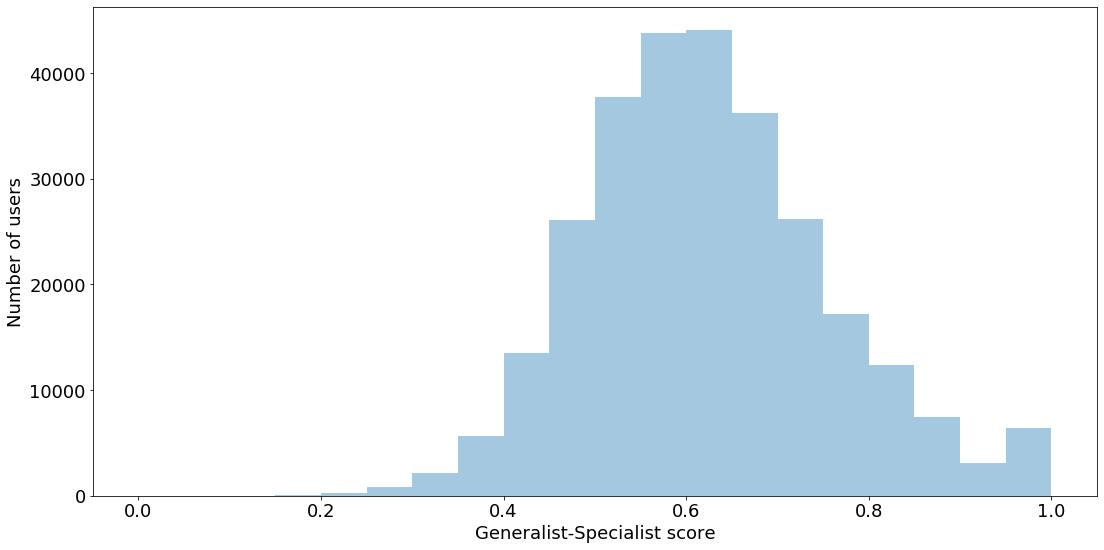

In [59]:
plt.figure(figsize=(18, 9))
sns.distplot(users_movies["gs_score"], kde=False, bins=20)
plt.xlabel("Generalist-Specialist score")
plt.ylabel("Number of users")